To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

# Setup

In [1]:
%matplotlib notebook
from matplotlib import pylab as plt
import time
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
#import pandas
import scipy
import json
import sklearn

In [2]:
import os, sys
# Ensure the notebook is running in the proper directory
# (only needed when compiling from sphinx)
if "docs/source/tutorials" in os.getcwd():
    os.chdir("../../../examples")
sys.path.insert(0,"../build/")
from rascal.representations import SphericalInvariants as SOAP

In [16]:
download_link = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06972-x/MediaObjects/41467_2018_6972_MOESM4_ESM.txt"
import urllib.request
urllib.request.urlretrieve(download_link, './data/CSD-500.xyz')
frames = read('./data/CSD-500.xyz','0:10')
# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)
print(frames[0])

Atoms(symbols='C88H96O8', pbc=True, cell=[[8.43116035, 0.0, 0.0], [0.158219155128, 14.5042431863, 0.0], [1.16980663624, 4.4685149855, 14.9100096405]], CS=...)


To compare position representations of environments $<r|X_i>$ and $<r|X_j>$ a statistical distance is required $d_(<r|X_i>,<r|X_j>)$. This can be the L2 norm distance

$d_{L2}(<r|X_i>,<r|X_j>) = \int \|<r|X_i> - <r|X_j>\|_2\mathrm{d}\,r$

which is not smooth. A solution for this is the proposed by using the earth mover distance/wasserstein metric
$d_{emd}(<r|X_i>,<r|X_j>) = \int \|icdf(<r|X_i>) - icdf(<r|X_j>)\|_2\mathrm{d}\,r,$
where $icdf$ is the inverted cumulative distance. Because it fulfills the smoothness it should give better results. We will find out if it does.

We need
$<r|X_i> = \sum_{n\alpha} <n\alpha|X_i> \tilde{R}_n(r)$, 

- where $<n\alpha|X_i>$ is the output of the SOAP vector

- $\tilde{R}_n(r)$ is the normalized basis function with the the jacobian determinant, if you compare with the SOAP derivation it is $R_n(r)r$ normalized.

In [3]:
from scipy.special import gamma
from scipy import integrate
from scipy.interpolate import interp1d

# N_n
def orthogonal_normalization(n, sigma):
    return np.sqrt( 2/(sigma**(2*n+3) *gamma(n+3/2)) )

# (S_nndash)^(-1/2)
def orthonormalization(n, b, N, sigma):
    ndash = n[:,np.newaxis]
    bdash = b[:,np.newaxis]
    sigmadash = sigma[:,np.newaxis]
    Ndash = N[:,np.newaxis]
    overlap = 0.5*N*Ndash*(b+bdash)**(-0.5*(3+n+ndash))*gamma(0.5*(3+n+ndash))
    return scipy.linalg.fractional_matrix_power(overlap,-0.5)
    
# R_n(r)*r
def gaussian_sigma_constant(N, b, n, r):
    return N * r**(n+1) * np.exp(-b*r**2)

# \tilde{R}_n(r)
def gto_basis_constant_function(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = orthogonal_normalization(n, sigma)
    b = 1/(2*sigma)
    Snorm = orthonormalization(n, b, N, sigma)
    return lambda r : gaussian_sigma_constant(N, b, n, r).dot(Snorm)


# computes the [<r|X_i>]_{ir} matrix where r is on a grid
def compute_position_representation_on_grid(frames, radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4, max_radial=6, interaction_cutoff=3.5, integration_grid_size = 100):
    # We start with <nα|X_i>
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial,
                  max_angular=0,
                  gaussian_sigma_constant=0.4,
                  gaussian_sigma_type="Constant",
                  cutoff_smooth_width=0.5,
                  normalize=True
                  )
    soap = SOAP(**hypers)
    SM = soap.transform(frames)
    soap_coeff = SM.get_dense_feature_matrix(soap)
    nb_envs = soap_coeff.shape[0]
    nb_species = int(soap_coeff.shape[1]/max_radial)
    basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
    position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )
    
    # [<r|X_i>]_{ir} matrix (envs, gridsize)
    integration_grid_eval = np.zeros((nb_envs, integration_grid_size))
    integration_grid = np.linspace(0,interaction_cutoff,integration_grid_size)
    for i in range(len(integration_grid)):
        integration_grid_eval[:,i] = position_repr(integration_grid[i])
    normalizations = np.trapz(integration_grid_eval, integration_grid)
    integration_grid_eval = integration_grid_eval/normalizations[:,np.newaxis]
    return (integration_grid_eval, integration_grid)

6
-2.4562970035198215e-06
(-187.84562403827147, 6.442611220616658e-10)
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -0.  0.]
 [ 0.  0.  1.  0. -0.  0.]
 [ 0.  0.  0.  1. -0.  0.]
 [ 0. -0. -0. -0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


<IPython.core.display.Javascript object>


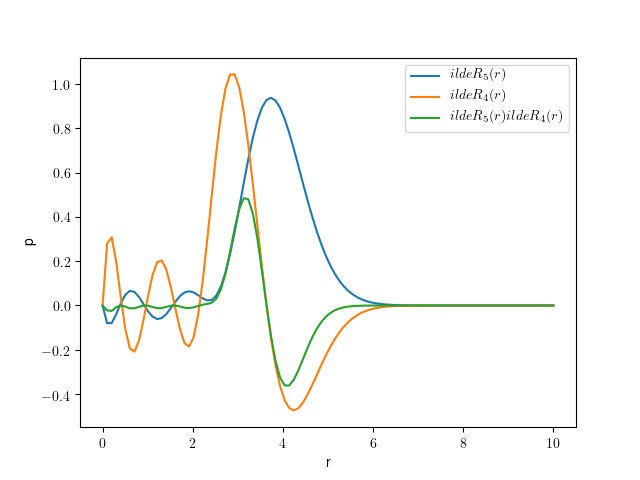

integrate.quad(bf_4_5, 0, 10) (1.1879386363489175e-13, 2.2733297195654858e-13)


In [13]:
from matplotlib import rc

#########
# Tests #
#########
max_n = 6
# the whole set of orthonormalized basis functions
bf = gto_basis_constant_function(max_n, 3.5)
# the nth orthornormal basis function
bf_4 = lambda r: bf(r)[4]
# all orthonormalized basis function for r=5
print(bf(5).size)
# the orthonormalized basis function n=4 for r=8
print(bf_4(8))
# just to try to integrate
print(integrate.quad(bf_4, -10, 10))

# computes \int \tilde{R}_n(r)\tilde{R}_{n'}(r) dr which should be equal \delta_{n,n'}
overlap = np.zeros((max_n,max_n))
for n in range(max_n):
    for ndash in range(max_n):
        bfs = lambda r :bf(r)[n] * bf(r)[ndash] 
        overlap[n,ndash] = integrate.quad(bfs, 0, 10)[0]
np.set_printoptions(suppress=True, linewidth=100)
print(overlap)

# Visualizes the effect of the normalization
x = np.linspace(0,10,100)
plt.close()

# \tilde{R}_5 over r \in \[0,10\]
plt.plot(x, np.array([bf(r)[5] for r in x]), label='$\tilde{R}_5(r)$')
# \tilde{R}_4 over r \in \[0,10\]
plt.plot(x, np.array([bf(r)[4] for r in x]), label='$\tilde{R}_4(r)$')
# \tilde{R}_5 * \tilde{R}_4 over r \in \[0,10\]
plt.plot(x, np.array([bf(r)[5]*bf(r)[4] for r in x]), label='$\tilde{R}_5(r)\tilde{R}_4(r)$')
plt.xlabel('r')
plt.ylabel('p')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.legend()
plt.show()

bf_4_5 = lambda r: bf(r)[5]*bf(r)[4]
# should be equal 0 (numerical inaccuracies)
print("integrate.quad(bf_4_5, 0, 10)", integrate.quad(bf_4_5, 0, 10))

1410
4


<IPython.core.display.Javascript object>


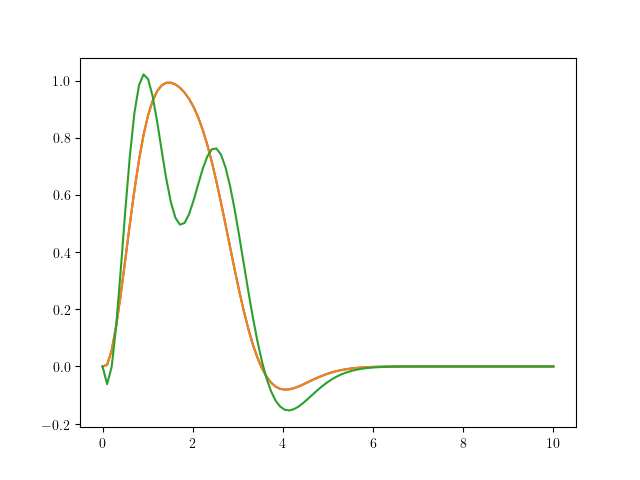

1.9618791190123823

In [17]:
# We start with <nα|X_i>
max_radial = 5
interaction_cutoff = 3.5
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=interaction_cutoff,
              max_radial=max_radial,
              max_angular=0,
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True
              )
soap = SOAP(**hypers)
SM = soap.transform(frames)
soap_coeff = SM.get_dense_feature_matrix(soap)
# soap_coeff shape is (number of envrionments, number of species * max_radial)
nb_envs = soap_coeff.shape[0]
nb_species = int(soap_coeff.shape[1]/max_radial)
# for one environment the order is (species, radial) e.g. for atomic structurre CH2 with max_radial = 3
# [(C, 0), (C, 1), ((C,2), (H_1,0), (H_1,1), (H_1,2), (H_2,0), (H_2,1), (H_2,2)]
print(nb_envs)
print(nb_species)
# \tilde{R}_n(r) for all n
basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )



# Visualizes the effect of the normalization
x = np.linspace(0,10,100)
plt.close()
# <r|X_0>
plt.plot(x, np.array([position_repr(r)[0] for r in x]), label='<r|X_0>')
# <r|X_1> which is by accident = <r|X_0>
plt.plot(x, np.array([position_repr(r)[1] for r in x]), label='<r|X_1>')
# <r|X_2>
plt.plot(x, np.array([position_repr(r)[2] for r in x]), label='<r|X_2>')
plt.legend()
plt.show()
np.trapz([position_repr(r)[1] for r in x],x)

1410
4


In [50]:
np.linalg.norm(soap_coeff,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

<IPython.core.display.Javascript object>


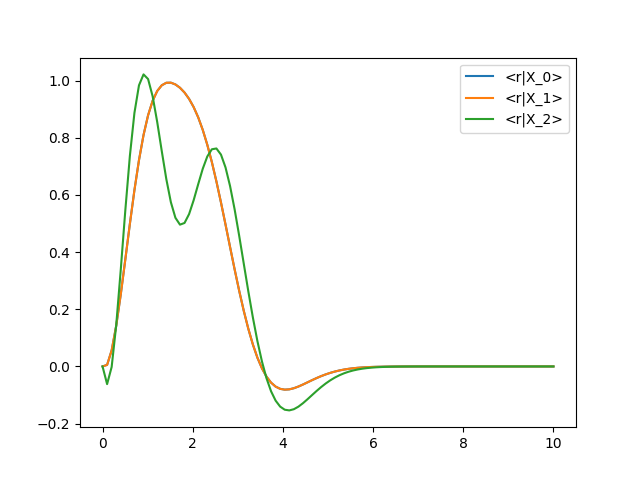

1.9618791190123868

In [52]:
eval_grid, grid = compute_position_representation_on_grid(frames)
np.trapz(eval_grid[0,:], grid)

2.207599572474956

In [55]:
np.trapz(eval_grid, grid)[0]

2.207599572474956

Now lets write this down in a more systematic way

In [ ]:
# computes the [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{ij} matrix
def compute_statistical_euclidean_distance_matrix(frames, radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4, max_radial=6, interaction_cutoff=3.5, integration_grid_size = 100):
    # We start with <nα|X_i>
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial,
                  max_angular=0,
                  gaussian_sigma_constant=0.4,
                  gaussian_sigma_type="Constant",
                  cutoff_smooth_width=0.5,
                  )
    soap = SOAP(**hypers)
    SM = soap.transform(frames)
    soap_coeff = SM.get_dense_feature_matrix(soap)
    nb_envs = soap_coeff.shape[0]
    nb_species = int(soap_coeff.shape[1]/max_radial)
    basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
    position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )
    
    # [<r|X_i>]_{ir} matrix
    integration_grid_eval = np.zeros((nb_envs, integration_grid_size))
    integration_grid = np.linspace(0,interaction_cutoff,integration_grid_size)
    for i in range(len(integration_grid)):
        integration_grid_eval[:,i] = position_repr(integration_grid[i])
    
    # This step is quite slow
    # [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{ij} matrix    
    integration_grid_eval_diff = np.zeros((nb_envs, nb_envs))
    for i in range(nb_envs):
        if i % 100 == 0: print(i)
        for j in range(nb_envs):
            # \|<r|X_i>-<r|X_j>\|_2 for r in grid 
            tmp = np.linalg.norm((integration_grid_eval[i,:]-integration_grid_eval[j,:])[:,np.newaxis], axis=1)
            integration_grid_eval_diff[i,j] = scipy.integrate.simps(tmp, integration_grid)
    return integration_grid_eval_diff

In [ ]:
#integration_grid_eval_diff = compute_statistical_euclidean_distance_matrix(frames)
#print(integration_grid_eval_diff)

In [53]:
from scipy.special import gamma
from scipy import integrate
from numba import jit, njit

# N_n
def orthogonal_normalization(n, sigma):
    return np.sqrt( 2/(sigma**(2*n+3) *gamma(n+3/2)) )

# (S_nndash)^(-1/2)
def orthonormalization(n, b, N, sigma):
    ndash = n[:,np.newaxis]
    bdash = b[:,np.newaxis]
    sigmadash = sigma[:,np.newaxis]
    Ndash = N[:,np.newaxis]
    overlap = 0.5*N*Ndash*(b+bdash)**(-0.5*(3+n+ndash))*gamma(0.5*(3+n+ndash))
    return scipy.linalg.fractional_matrix_power(overlap,-0.5)
    
# R_n(r)*r
def gaussian_sigma_constant(N, b, n, r):
    return N * r**(n+1) * np.exp(-b*r**2)

# \tilde{R}_n(r)
def gto_basis_constant_function(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = orthogonal_normalization(n, sigma)
    b = 1/(2*sigma)
    Snorm = orthonormalization(n, b, N, sigma)
    return lambda r : gaussian_sigma_constant(N, b, n, r).dot(Snorm)


# computes the [<r|X_i>]_{ir} matrix where r is on a grid
def compute_position_representation_on_grid(frames, radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4, max_radial=6, interaction_cutoff=3.5, integration_grid_size = 100):
    # We start with <nα|X_i>
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial,
                  max_angular=0,
                  gaussian_sigma_constant=0.4,
                  gaussian_sigma_type="Constant",
                  cutoff_smooth_width=0.5,
                  )
    soap = SOAP(**hypers)
    SM = soap.transform(frames)
    soap_coeff = SM.get_dense_feature_matrix(soap)
    nb_envs = soap_coeff.shape[0]
    nb_species = int(soap_coeff.shape[1]/max_radial)
    basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
    position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )
    
    # [<r|X_i>]_{ir} matrix (envs, gridsize)
    integration_grid_eval = np.zeros((nb_envs, integration_grid_size))
    integration_grid = np.linspace(0,interaction_cutoff,integration_grid_size)
    for i in range(len(integration_grid)):
        integration_grid_eval[:,i] = position_repr(integration_grid[i])
    return (integration_grid_eval, integration_grid)
    
# structure_ranges : ids of the environments in the frames used for the precomputation
def compute_structure_ranges(frames):
    # e.g. A_0 = frames[structure_ranges_index[0]:structure_ranges_index[1]];
    #      A_1 = frames[structure_ranges_index[1]:structure_ranges_index[2]]; ...
    structure_ranges_index = [0] * (len(frames)+1)
    for i in range(len(frames)):    
        structure_ranges_index[i+1] = frames[i].get_number_of_atoms() + structure_ranges_index[i]
    structure_ranges = []
    for i in range(len(structure_ranges_index)-1):
        structure_ranges.append(list(range(structure_ranges_index[i],structure_ranges_index[i+1])))
    return structure_ranges

# bottleneck
# this is a workaround to identifiy the structures from the soap coeffs
# d(A,B) = [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{X_i\in A, X_j\in B} 

def compute_distance_between_structures(struc_A, struc_B, integration_grid_eval, integration_grid):
    # This step is quite slow
    # [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{ij} matrix
    integration_grid_eval_diff = np.zeros((len(struc_A), len(struc_B)))
    # X_i = struc_A[i]
    for i in range(len(struc_A)):
        for j in range(len(struc_B)):
            # \|<r|X_i>-<r|X_j>\|_2 for r in grid
            tmp = np.linalg.norm((integration_grid_eval[struc_A[i],:]-integration_grid_eval[struc_B[j],:])[:,np.newaxis], axis=1)**2
            integration_grid_eval_diff[i,j] = scipy.integrate.simps(tmp, integration_grid)
    return integration_grid_eval_diff
        
def compute_structure_kernel_entry(kernel_function, struc_A, struc_B, integration_grid_eval_diff, integration_grid):
    return kernel_function( compute_distance_between_structures(struc_A, struc_B,
                                                                integration_grid_eval_diff, integration_grid) )

def compute_structure_kernel(kernel_function, structure_ranges1, structure_ranges2, integration_grid_eval_diff, integration_grid):
    struc_kernel = np.zeros((len(structure_ranges1),len(structure_ranges2)))
    for i in range(len(structure_ranges1)):
        for j in range(len(structure_ranges2)):
            print("(A_i,B_j)",i,j)
            struc_kernel[i,j] = compute_structure_kernel_entry(kernel_function, structure_ranges1[i], structure_ranges2[j], integration_grid_eval_diff, integration_grid)           
    return struc_kernel

@jit
def compute_structure_kernel_complete(kernel_function, structure_ranges, integration_grid_eval_diff, integration_grid):
    struc_kernel = np.ones((len(structure_ranges),len(structure_ranges)))
    for i in range(len(structure_ranges)):
        struc_kernel[i,i] = kernel_function(0)
        for j in range(i):
            print("(A_i,B_j)",i,j)
            struc_kernel[i,j] = compute_structure_kernel_entry(kernel_function, structure_ranges[i], structure_ranges[j], integration_grid_eval_diff, integration_grid)
            struc_kernel[j,i] = struc_kernel[i,j]
    return struc_kernel

class KRR(object):
    def __init__(self, frames, sigma=0.5):
        self.sigma = sigma
        self.kernel_function = lambda distances : np.mean(np.exp(-0.5*distances/self.sigma**2))
        self.integration_grid_eval_diff, self.integration_grid = compute_position_representation_on_grid(frames)
        self.structure_ranges = compute_structure_ranges(frames)
        self.weights = None
        self.nb_structures = len(frames)
                
    def compute_kernel(self, structures1_ids, structures2_ids):
        structures1 = [self.structure_ranges[struc_id] for struc_id in structures1_ids]
        structures2 = [self.structure_ranges[struc_id] for struc_id in structures2_ids]
        return compute_structure_kernel(self.kernel_function, structures1, structures2,
                                        self.integration_grid_eval_diff, self.integration_grid)
    
    def compute_kernel_complete(self, icdf=False):
        if (icdf):
            self.integration_grid_eval_diff = np.sort(self.integration_grid_eval_diff, axis=1)
        self.kernel_complete = compute_structure_kernel_complete(self.kernel_function, self.structure_ranges,
                                        self.integration_grid_eval_diff, self.integration_grid)

    def slice_kernel_complete_indices(self, ids1, ids2):
        indices = np.array(np.meshgrid(ids1,ids2)).T.reshape(-1,2)
        indices_x = indices[:,0]
        indices_y = indices[:,1]
        return self.kernel_complete[indices_x, indices_y].reshape(len(ids1),len(ids2))
        
    def compute_weights(self, structures_train_ids, train_labels, Lambda=10, jitter=1e-8):        
        kernel_train = self.slice_kernel_complete_indices(structures_train_ids, structures_train_ids)
        # adjust the kernel so that it is properly scaled
        delta = np.std(train_labels) / np.mean(self.kernel_complete.diagonal())
        kernel_train[np.diag_indices_from(kernel_train)] += Lambda**2 / delta **2 + jitter

        # train the krr model, w = (K_train + lambda*I)^(-1)y
        self.weights = np.linalg.solve(kernel_train, train_labels)
        
    def predict(self, structures_train_ids, structures_test_ids):
        # train the krr model, w = (K_train + lambda*I)^(-1)y
        kernel_test = self.slice_kernel_complete_indices(structures_train_ids, structures_test_ids)
        return np.dot(self.weights, kernel_test)
    
def split_dataset(N, test_fraction, seed=10):
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train_ids = ids[:Ntrain]
    test_ids = ids[Ntrain:]
    return train_ids, test_ids
def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

In [ ]:
#frames = read('./data/CSD-500.xyz','0:10')
## wraps the structures into the unit cell
#for i in range(len(frames)):
#    frames[i].wrap(eps=1e-11)

#sigma = 0.5
#kernel_function = lambda distances : np.mean(np.exp(-0.5*distances/sigma**2))
                                             
#integration_grid_eval_diff, integration_grid = compute_position_representation_on_grid(frames)
#structure_ranges = compute_structure_ranges(frames)
                                             
#kernel_train = compute_structure_kernel(kernel_function, [structure_ranges[0]], [structure_ranges[1]], integration_grid_eval_diff, integration_grid)

In [19]:
# prepare data and labels

# data
frames = read('./data/CSD-500.xyz','0:500')
# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)

# compatutational heavy compute 
model = KRR(frames)    
model.compute_kernel_complete()
model_icdf = KRR(frames)
model_icdf.compute_kernel_complete(icdf=True)

(A_i,B_j) 1 0
(A_i,B_j) 2 0
(A_i,B_j) 2 1
(A_i,B_j) 3 0
(A_i,B_j) 3 1
(A_i,B_j) 3 2
(A_i,B_j) 4 0
(A_i,B_j) 4 1
(A_i,B_j) 4 2
(A_i,B_j) 4 3
(A_i,B_j) 5 0
(A_i,B_j) 5 1
(A_i,B_j) 5 2
(A_i,B_j) 5 3
(A_i,B_j) 5 4
(A_i,B_j) 6 0
(A_i,B_j) 6 1
(A_i,B_j) 6 2
(A_i,B_j) 6 3
(A_i,B_j) 6 4
(A_i,B_j) 6 5
(A_i,B_j) 7 0
(A_i,B_j) 7 1
(A_i,B_j) 7 2
(A_i,B_j) 7 3
(A_i,B_j) 7 4
(A_i,B_j) 7 5
(A_i,B_j) 7 6
(A_i,B_j) 8 0
(A_i,B_j) 8 1
(A_i,B_j) 8 2
(A_i,B_j) 8 3
(A_i,B_j) 8 4
(A_i,B_j) 8 5
(A_i,B_j) 8 6
(A_i,B_j) 8 7
(A_i,B_j) 9 0
(A_i,B_j) 9 1
(A_i,B_j) 9 2
(A_i,B_j) 9 3
(A_i,B_j) 9 4
(A_i,B_j) 9 5
(A_i,B_j) 9 6
(A_i,B_j) 9 7
(A_i,B_j) 9 8
(A_i,B_j) 10 0
(A_i,B_j) 10 1
(A_i,B_j) 10 2
(A_i,B_j) 10 3
(A_i,B_j) 10 4
(A_i,B_j) 10 5
(A_i,B_j) 10 6
(A_i,B_j) 10 7
(A_i,B_j) 10 8
(A_i,B_j) 10 9
(A_i,B_j) 11 0
(A_i,B_j) 11 1
(A_i,B_j) 11 2
(A_i,B_j) 11 3
(A_i,B_j) 11 4
(A_i,B_j) 11 5
(A_i,B_j) 11 6
(A_i,B_j) 11 7
(A_i,B_j) 11 8
(A_i,B_j) 11 9
(A_i,B_j) 11 10
(A_i,B_j) 12 0
(A_i,B_j) 12 1
(A_i,B_j) 12 2
(A_i,B_j)

(A_i,B_j) 33 5
(A_i,B_j) 33 6
(A_i,B_j) 33 7
(A_i,B_j) 33 8
(A_i,B_j) 33 9
(A_i,B_j) 33 10
(A_i,B_j) 33 11
(A_i,B_j) 33 12
(A_i,B_j) 33 13
(A_i,B_j) 33 14
(A_i,B_j) 33 15
(A_i,B_j) 33 16
(A_i,B_j) 33 17
(A_i,B_j) 33 18
(A_i,B_j) 33 19
(A_i,B_j) 33 20
(A_i,B_j) 33 21
(A_i,B_j) 33 22
(A_i,B_j) 33 23
(A_i,B_j) 33 24
(A_i,B_j) 33 25
(A_i,B_j) 33 26
(A_i,B_j) 33 27
(A_i,B_j) 33 28
(A_i,B_j) 33 29
(A_i,B_j) 33 30
(A_i,B_j) 33 31
(A_i,B_j) 33 32
(A_i,B_j) 34 0
(A_i,B_j) 34 1
(A_i,B_j) 34 2
(A_i,B_j) 34 3
(A_i,B_j) 34 4
(A_i,B_j) 34 5
(A_i,B_j) 34 6
(A_i,B_j) 34 7
(A_i,B_j) 34 8
(A_i,B_j) 34 9
(A_i,B_j) 34 10
(A_i,B_j) 34 11
(A_i,B_j) 34 12
(A_i,B_j) 34 13
(A_i,B_j) 34 14
(A_i,B_j) 34 15
(A_i,B_j) 34 16
(A_i,B_j) 34 17
(A_i,B_j) 34 18
(A_i,B_j) 34 19
(A_i,B_j) 34 20
(A_i,B_j) 34 21
(A_i,B_j) 34 22
(A_i,B_j) 34 23
(A_i,B_j) 34 24
(A_i,B_j) 34 25
(A_i,B_j) 34 26
(A_i,B_j) 34 27
(A_i,B_j) 34 28
(A_i,B_j) 34 29
(A_i,B_j) 34 30
(A_i,B_j) 34 31
(A_i,B_j) 34 32
(A_i,B_j) 34 33
(A_i,B_j) 35 0
(A_i,B_j

(A_i,B_j) 46 19
(A_i,B_j) 46 20
(A_i,B_j) 46 21
(A_i,B_j) 46 22
(A_i,B_j) 46 23
(A_i,B_j) 46 24
(A_i,B_j) 46 25
(A_i,B_j) 46 26
(A_i,B_j) 46 27
(A_i,B_j) 46 28
(A_i,B_j) 46 29
(A_i,B_j) 46 30
(A_i,B_j) 46 31
(A_i,B_j) 46 32
(A_i,B_j) 46 33
(A_i,B_j) 46 34
(A_i,B_j) 46 35
(A_i,B_j) 46 36
(A_i,B_j) 46 37
(A_i,B_j) 46 38
(A_i,B_j) 46 39
(A_i,B_j) 46 40
(A_i,B_j) 46 41
(A_i,B_j) 46 42
(A_i,B_j) 46 43
(A_i,B_j) 46 44
(A_i,B_j) 46 45
(A_i,B_j) 47 0
(A_i,B_j) 47 1
(A_i,B_j) 47 2
(A_i,B_j) 47 3
(A_i,B_j) 47 4
(A_i,B_j) 47 5
(A_i,B_j) 47 6
(A_i,B_j) 47 7
(A_i,B_j) 47 8
(A_i,B_j) 47 9
(A_i,B_j) 47 10
(A_i,B_j) 47 11
(A_i,B_j) 47 12
(A_i,B_j) 47 13
(A_i,B_j) 47 14
(A_i,B_j) 47 15
(A_i,B_j) 47 16
(A_i,B_j) 47 17
(A_i,B_j) 47 18
(A_i,B_j) 47 19
(A_i,B_j) 47 20
(A_i,B_j) 47 21
(A_i,B_j) 47 22
(A_i,B_j) 47 23
(A_i,B_j) 47 24
(A_i,B_j) 47 25
(A_i,B_j) 47 26
(A_i,B_j) 47 27
(A_i,B_j) 47 28
(A_i,B_j) 47 29
(A_i,B_j) 47 30
(A_i,B_j) 47 31
(A_i,B_j) 47 32
(A_i,B_j) 47 33
(A_i,B_j) 47 34
(A_i,B_j) 47 35
(A

(A_i,B_j) 56 33
(A_i,B_j) 56 34
(A_i,B_j) 56 35
(A_i,B_j) 56 36
(A_i,B_j) 56 37
(A_i,B_j) 56 38
(A_i,B_j) 56 39
(A_i,B_j) 56 40
(A_i,B_j) 56 41
(A_i,B_j) 56 42
(A_i,B_j) 56 43
(A_i,B_j) 56 44
(A_i,B_j) 56 45
(A_i,B_j) 56 46
(A_i,B_j) 56 47
(A_i,B_j) 56 48
(A_i,B_j) 56 49
(A_i,B_j) 56 50
(A_i,B_j) 56 51
(A_i,B_j) 56 52
(A_i,B_j) 56 53
(A_i,B_j) 56 54
(A_i,B_j) 56 55
(A_i,B_j) 57 0
(A_i,B_j) 57 1
(A_i,B_j) 57 2
(A_i,B_j) 57 3
(A_i,B_j) 57 4
(A_i,B_j) 57 5
(A_i,B_j) 57 6
(A_i,B_j) 57 7
(A_i,B_j) 57 8
(A_i,B_j) 57 9
(A_i,B_j) 57 10
(A_i,B_j) 57 11
(A_i,B_j) 57 12
(A_i,B_j) 57 13
(A_i,B_j) 57 14
(A_i,B_j) 57 15
(A_i,B_j) 57 16
(A_i,B_j) 57 17
(A_i,B_j) 57 18
(A_i,B_j) 57 19
(A_i,B_j) 57 20
(A_i,B_j) 57 21
(A_i,B_j) 57 22
(A_i,B_j) 57 23
(A_i,B_j) 57 24
(A_i,B_j) 57 25
(A_i,B_j) 57 26
(A_i,B_j) 57 27
(A_i,B_j) 57 28
(A_i,B_j) 57 29
(A_i,B_j) 57 30
(A_i,B_j) 57 31
(A_i,B_j) 57 32
(A_i,B_j) 57 33
(A_i,B_j) 57 34
(A_i,B_j) 57 35
(A_i,B_j) 57 36
(A_i,B_j) 57 37
(A_i,B_j) 57 38
(A_i,B_j) 57 39
(A

(A_i,B_j) 65 11
(A_i,B_j) 65 12
(A_i,B_j) 65 13
(A_i,B_j) 65 14
(A_i,B_j) 65 15
(A_i,B_j) 65 16
(A_i,B_j) 65 17
(A_i,B_j) 65 18
(A_i,B_j) 65 19
(A_i,B_j) 65 20
(A_i,B_j) 65 21
(A_i,B_j) 65 22
(A_i,B_j) 65 23
(A_i,B_j) 65 24
(A_i,B_j) 65 25
(A_i,B_j) 65 26
(A_i,B_j) 65 27
(A_i,B_j) 65 28
(A_i,B_j) 65 29
(A_i,B_j) 65 30
(A_i,B_j) 65 31
(A_i,B_j) 65 32
(A_i,B_j) 65 33
(A_i,B_j) 65 34
(A_i,B_j) 65 35
(A_i,B_j) 65 36
(A_i,B_j) 65 37
(A_i,B_j) 65 38
(A_i,B_j) 65 39
(A_i,B_j) 65 40
(A_i,B_j) 65 41
(A_i,B_j) 65 42
(A_i,B_j) 65 43
(A_i,B_j) 65 44
(A_i,B_j) 65 45
(A_i,B_j) 65 46
(A_i,B_j) 65 47
(A_i,B_j) 65 48
(A_i,B_j) 65 49
(A_i,B_j) 65 50
(A_i,B_j) 65 51
(A_i,B_j) 65 52
(A_i,B_j) 65 53
(A_i,B_j) 65 54
(A_i,B_j) 65 55
(A_i,B_j) 65 56
(A_i,B_j) 65 57
(A_i,B_j) 65 58
(A_i,B_j) 65 59
(A_i,B_j) 65 60
(A_i,B_j) 65 61
(A_i,B_j) 65 62
(A_i,B_j) 65 63
(A_i,B_j) 65 64
(A_i,B_j) 66 0
(A_i,B_j) 66 1
(A_i,B_j) 66 2
(A_i,B_j) 66 3
(A_i,B_j) 66 4
(A_i,B_j) 66 5
(A_i,B_j) 66 6
(A_i,B_j) 66 7
(A_i,B_j) 66 8
(

(A_i,B_j) 72 52
(A_i,B_j) 72 53
(A_i,B_j) 72 54
(A_i,B_j) 72 55
(A_i,B_j) 72 56
(A_i,B_j) 72 57
(A_i,B_j) 72 58
(A_i,B_j) 72 59
(A_i,B_j) 72 60
(A_i,B_j) 72 61
(A_i,B_j) 72 62
(A_i,B_j) 72 63
(A_i,B_j) 72 64
(A_i,B_j) 72 65
(A_i,B_j) 72 66
(A_i,B_j) 72 67
(A_i,B_j) 72 68
(A_i,B_j) 72 69
(A_i,B_j) 72 70
(A_i,B_j) 72 71
(A_i,B_j) 73 0
(A_i,B_j) 73 1
(A_i,B_j) 73 2
(A_i,B_j) 73 3
(A_i,B_j) 73 4
(A_i,B_j) 73 5
(A_i,B_j) 73 6
(A_i,B_j) 73 7
(A_i,B_j) 73 8
(A_i,B_j) 73 9
(A_i,B_j) 73 10
(A_i,B_j) 73 11
(A_i,B_j) 73 12
(A_i,B_j) 73 13
(A_i,B_j) 73 14
(A_i,B_j) 73 15
(A_i,B_j) 73 16
(A_i,B_j) 73 17
(A_i,B_j) 73 18
(A_i,B_j) 73 19
(A_i,B_j) 73 20
(A_i,B_j) 73 21
(A_i,B_j) 73 22
(A_i,B_j) 73 23
(A_i,B_j) 73 24
(A_i,B_j) 73 25
(A_i,B_j) 73 26
(A_i,B_j) 73 27
(A_i,B_j) 73 28
(A_i,B_j) 73 29
(A_i,B_j) 73 30
(A_i,B_j) 73 31
(A_i,B_j) 73 32
(A_i,B_j) 73 33
(A_i,B_j) 73 34
(A_i,B_j) 73 35
(A_i,B_j) 73 36
(A_i,B_j) 73 37
(A_i,B_j) 73 38
(A_i,B_j) 73 39
(A_i,B_j) 73 40
(A_i,B_j) 73 41
(A_i,B_j) 73 42
(A

(A_i,B_j) 79 44
(A_i,B_j) 79 45
(A_i,B_j) 79 46
(A_i,B_j) 79 47
(A_i,B_j) 79 48
(A_i,B_j) 79 49
(A_i,B_j) 79 50
(A_i,B_j) 79 51
(A_i,B_j) 79 52
(A_i,B_j) 79 53
(A_i,B_j) 79 54
(A_i,B_j) 79 55
(A_i,B_j) 79 56
(A_i,B_j) 79 57
(A_i,B_j) 79 58
(A_i,B_j) 79 59
(A_i,B_j) 79 60
(A_i,B_j) 79 61
(A_i,B_j) 79 62
(A_i,B_j) 79 63
(A_i,B_j) 79 64
(A_i,B_j) 79 65
(A_i,B_j) 79 66
(A_i,B_j) 79 67
(A_i,B_j) 79 68
(A_i,B_j) 79 69
(A_i,B_j) 79 70
(A_i,B_j) 79 71
(A_i,B_j) 79 72
(A_i,B_j) 79 73
(A_i,B_j) 79 74
(A_i,B_j) 79 75
(A_i,B_j) 79 76
(A_i,B_j) 79 77
(A_i,B_j) 79 78
(A_i,B_j) 80 0
(A_i,B_j) 80 1
(A_i,B_j) 80 2
(A_i,B_j) 80 3
(A_i,B_j) 80 4
(A_i,B_j) 80 5
(A_i,B_j) 80 6
(A_i,B_j) 80 7
(A_i,B_j) 80 8
(A_i,B_j) 80 9
(A_i,B_j) 80 10
(A_i,B_j) 80 11
(A_i,B_j) 80 12
(A_i,B_j) 80 13
(A_i,B_j) 80 14
(A_i,B_j) 80 15
(A_i,B_j) 80 16
(A_i,B_j) 80 17
(A_i,B_j) 80 18
(A_i,B_j) 80 19
(A_i,B_j) 80 20
(A_i,B_j) 80 21
(A_i,B_j) 80 22
(A_i,B_j) 80 23
(A_i,B_j) 80 24
(A_i,B_j) 80 25
(A_i,B_j) 80 26
(A_i,B_j) 80 27
(A

(A_i,B_j) 85 71
(A_i,B_j) 85 72
(A_i,B_j) 85 73
(A_i,B_j) 85 74
(A_i,B_j) 85 75
(A_i,B_j) 85 76
(A_i,B_j) 85 77
(A_i,B_j) 85 78
(A_i,B_j) 85 79
(A_i,B_j) 85 80
(A_i,B_j) 85 81
(A_i,B_j) 85 82
(A_i,B_j) 85 83
(A_i,B_j) 85 84
(A_i,B_j) 86 0
(A_i,B_j) 86 1
(A_i,B_j) 86 2
(A_i,B_j) 86 3
(A_i,B_j) 86 4
(A_i,B_j) 86 5
(A_i,B_j) 86 6
(A_i,B_j) 86 7
(A_i,B_j) 86 8
(A_i,B_j) 86 9
(A_i,B_j) 86 10
(A_i,B_j) 86 11
(A_i,B_j) 86 12
(A_i,B_j) 86 13
(A_i,B_j) 86 14
(A_i,B_j) 86 15
(A_i,B_j) 86 16
(A_i,B_j) 86 17
(A_i,B_j) 86 18
(A_i,B_j) 86 19
(A_i,B_j) 86 20
(A_i,B_j) 86 21
(A_i,B_j) 86 22
(A_i,B_j) 86 23
(A_i,B_j) 86 24
(A_i,B_j) 86 25
(A_i,B_j) 86 26
(A_i,B_j) 86 27
(A_i,B_j) 86 28
(A_i,B_j) 86 29
(A_i,B_j) 86 30
(A_i,B_j) 86 31
(A_i,B_j) 86 32
(A_i,B_j) 86 33
(A_i,B_j) 86 34
(A_i,B_j) 86 35
(A_i,B_j) 86 36
(A_i,B_j) 86 37
(A_i,B_j) 86 38
(A_i,B_j) 86 39
(A_i,B_j) 86 40
(A_i,B_j) 86 41
(A_i,B_j) 86 42
(A_i,B_j) 86 43
(A_i,B_j) 86 44
(A_i,B_j) 86 45
(A_i,B_j) 86 46
(A_i,B_j) 86 47
(A_i,B_j) 86 48
(A

(A_i,B_j) 91 62
(A_i,B_j) 91 63
(A_i,B_j) 91 64
(A_i,B_j) 91 65
(A_i,B_j) 91 66
(A_i,B_j) 91 67
(A_i,B_j) 91 68
(A_i,B_j) 91 69
(A_i,B_j) 91 70
(A_i,B_j) 91 71
(A_i,B_j) 91 72
(A_i,B_j) 91 73
(A_i,B_j) 91 74
(A_i,B_j) 91 75
(A_i,B_j) 91 76
(A_i,B_j) 91 77
(A_i,B_j) 91 78
(A_i,B_j) 91 79
(A_i,B_j) 91 80
(A_i,B_j) 91 81
(A_i,B_j) 91 82
(A_i,B_j) 91 83
(A_i,B_j) 91 84
(A_i,B_j) 91 85
(A_i,B_j) 91 86
(A_i,B_j) 91 87
(A_i,B_j) 91 88
(A_i,B_j) 91 89
(A_i,B_j) 91 90
(A_i,B_j) 92 0
(A_i,B_j) 92 1
(A_i,B_j) 92 2
(A_i,B_j) 92 3
(A_i,B_j) 92 4
(A_i,B_j) 92 5
(A_i,B_j) 92 6
(A_i,B_j) 92 7
(A_i,B_j) 92 8
(A_i,B_j) 92 9
(A_i,B_j) 92 10
(A_i,B_j) 92 11
(A_i,B_j) 92 12
(A_i,B_j) 92 13
(A_i,B_j) 92 14
(A_i,B_j) 92 15
(A_i,B_j) 92 16
(A_i,B_j) 92 17
(A_i,B_j) 92 18
(A_i,B_j) 92 19
(A_i,B_j) 92 20
(A_i,B_j) 92 21
(A_i,B_j) 92 22
(A_i,B_j) 92 23
(A_i,B_j) 92 24
(A_i,B_j) 92 25
(A_i,B_j) 92 26
(A_i,B_j) 92 27
(A_i,B_j) 92 28
(A_i,B_j) 92 29
(A_i,B_j) 92 30
(A_i,B_j) 92 31
(A_i,B_j) 92 32
(A_i,B_j) 92 33
(A

(A_i,B_j) 97 17
(A_i,B_j) 97 18
(A_i,B_j) 97 19
(A_i,B_j) 97 20
(A_i,B_j) 97 21
(A_i,B_j) 97 22
(A_i,B_j) 97 23
(A_i,B_j) 97 24
(A_i,B_j) 97 25
(A_i,B_j) 97 26
(A_i,B_j) 97 27
(A_i,B_j) 97 28
(A_i,B_j) 97 29
(A_i,B_j) 97 30
(A_i,B_j) 97 31
(A_i,B_j) 97 32
(A_i,B_j) 97 33
(A_i,B_j) 97 34
(A_i,B_j) 97 35
(A_i,B_j) 97 36
(A_i,B_j) 97 37
(A_i,B_j) 97 38
(A_i,B_j) 97 39
(A_i,B_j) 97 40
(A_i,B_j) 97 41
(A_i,B_j) 97 42
(A_i,B_j) 97 43
(A_i,B_j) 97 44
(A_i,B_j) 97 45
(A_i,B_j) 97 46
(A_i,B_j) 97 47
(A_i,B_j) 97 48
(A_i,B_j) 97 49
(A_i,B_j) 97 50
(A_i,B_j) 97 51
(A_i,B_j) 97 52
(A_i,B_j) 97 53
(A_i,B_j) 97 54
(A_i,B_j) 97 55
(A_i,B_j) 97 56
(A_i,B_j) 97 57
(A_i,B_j) 97 58
(A_i,B_j) 97 59
(A_i,B_j) 97 60
(A_i,B_j) 97 61
(A_i,B_j) 97 62
(A_i,B_j) 97 63
(A_i,B_j) 97 64
(A_i,B_j) 97 65
(A_i,B_j) 97 66
(A_i,B_j) 97 67
(A_i,B_j) 97 68
(A_i,B_j) 97 69
(A_i,B_j) 97 70
(A_i,B_j) 97 71
(A_i,B_j) 97 72
(A_i,B_j) 97 73
(A_i,B_j) 97 74
(A_i,B_j) 97 75
(A_i,B_j) 97 76
(A_i,B_j) 97 77
(A_i,B_j) 97 78
(A_i,B_j

(A_i,B_j) 102 24
(A_i,B_j) 102 25
(A_i,B_j) 102 26
(A_i,B_j) 102 27
(A_i,B_j) 102 28
(A_i,B_j) 102 29
(A_i,B_j) 102 30
(A_i,B_j) 102 31
(A_i,B_j) 102 32
(A_i,B_j) 102 33
(A_i,B_j) 102 34
(A_i,B_j) 102 35
(A_i,B_j) 102 36
(A_i,B_j) 102 37
(A_i,B_j) 102 38
(A_i,B_j) 102 39
(A_i,B_j) 102 40
(A_i,B_j) 102 41
(A_i,B_j) 102 42
(A_i,B_j) 102 43
(A_i,B_j) 102 44
(A_i,B_j) 102 45
(A_i,B_j) 102 46
(A_i,B_j) 102 47
(A_i,B_j) 102 48
(A_i,B_j) 102 49
(A_i,B_j) 102 50
(A_i,B_j) 102 51
(A_i,B_j) 102 52
(A_i,B_j) 102 53
(A_i,B_j) 102 54
(A_i,B_j) 102 55
(A_i,B_j) 102 56
(A_i,B_j) 102 57
(A_i,B_j) 102 58
(A_i,B_j) 102 59
(A_i,B_j) 102 60
(A_i,B_j) 102 61
(A_i,B_j) 102 62
(A_i,B_j) 102 63
(A_i,B_j) 102 64
(A_i,B_j) 102 65
(A_i,B_j) 102 66
(A_i,B_j) 102 67
(A_i,B_j) 102 68
(A_i,B_j) 102 69
(A_i,B_j) 102 70
(A_i,B_j) 102 71
(A_i,B_j) 102 72
(A_i,B_j) 102 73
(A_i,B_j) 102 74
(A_i,B_j) 102 75
(A_i,B_j) 102 76
(A_i,B_j) 102 77
(A_i,B_j) 102 78
(A_i,B_j) 102 79
(A_i,B_j) 102 80
(A_i,B_j) 102 81
(A_i,B_j) 102 

(A_i,B_j) 106 94
(A_i,B_j) 106 95
(A_i,B_j) 106 96
(A_i,B_j) 106 97
(A_i,B_j) 106 98
(A_i,B_j) 106 99
(A_i,B_j) 106 100
(A_i,B_j) 106 101
(A_i,B_j) 106 102
(A_i,B_j) 106 103
(A_i,B_j) 106 104
(A_i,B_j) 106 105
(A_i,B_j) 107 0
(A_i,B_j) 107 1
(A_i,B_j) 107 2
(A_i,B_j) 107 3
(A_i,B_j) 107 4
(A_i,B_j) 107 5
(A_i,B_j) 107 6
(A_i,B_j) 107 7
(A_i,B_j) 107 8
(A_i,B_j) 107 9
(A_i,B_j) 107 10
(A_i,B_j) 107 11
(A_i,B_j) 107 12
(A_i,B_j) 107 13
(A_i,B_j) 107 14
(A_i,B_j) 107 15
(A_i,B_j) 107 16
(A_i,B_j) 107 17
(A_i,B_j) 107 18
(A_i,B_j) 107 19
(A_i,B_j) 107 20
(A_i,B_j) 107 21
(A_i,B_j) 107 22
(A_i,B_j) 107 23
(A_i,B_j) 107 24
(A_i,B_j) 107 25
(A_i,B_j) 107 26
(A_i,B_j) 107 27
(A_i,B_j) 107 28
(A_i,B_j) 107 29
(A_i,B_j) 107 30
(A_i,B_j) 107 31
(A_i,B_j) 107 32
(A_i,B_j) 107 33
(A_i,B_j) 107 34
(A_i,B_j) 107 35
(A_i,B_j) 107 36
(A_i,B_j) 107 37
(A_i,B_j) 107 38
(A_i,B_j) 107 39
(A_i,B_j) 107 40
(A_i,B_j) 107 41
(A_i,B_j) 107 42
(A_i,B_j) 107 43
(A_i,B_j) 107 44
(A_i,B_j) 107 45
(A_i,B_j) 107 46
(

(A_i,B_j) 111 37
(A_i,B_j) 111 38
(A_i,B_j) 111 39
(A_i,B_j) 111 40
(A_i,B_j) 111 41
(A_i,B_j) 111 42
(A_i,B_j) 111 43
(A_i,B_j) 111 44
(A_i,B_j) 111 45
(A_i,B_j) 111 46
(A_i,B_j) 111 47
(A_i,B_j) 111 48
(A_i,B_j) 111 49
(A_i,B_j) 111 50
(A_i,B_j) 111 51
(A_i,B_j) 111 52
(A_i,B_j) 111 53
(A_i,B_j) 111 54
(A_i,B_j) 111 55
(A_i,B_j) 111 56
(A_i,B_j) 111 57
(A_i,B_j) 111 58
(A_i,B_j) 111 59
(A_i,B_j) 111 60
(A_i,B_j) 111 61
(A_i,B_j) 111 62
(A_i,B_j) 111 63
(A_i,B_j) 111 64
(A_i,B_j) 111 65
(A_i,B_j) 111 66
(A_i,B_j) 111 67
(A_i,B_j) 111 68
(A_i,B_j) 111 69
(A_i,B_j) 111 70
(A_i,B_j) 111 71
(A_i,B_j) 111 72
(A_i,B_j) 111 73
(A_i,B_j) 111 74
(A_i,B_j) 111 75
(A_i,B_j) 111 76
(A_i,B_j) 111 77
(A_i,B_j) 111 78
(A_i,B_j) 111 79
(A_i,B_j) 111 80
(A_i,B_j) 111 81
(A_i,B_j) 111 82
(A_i,B_j) 111 83
(A_i,B_j) 111 84
(A_i,B_j) 111 85
(A_i,B_j) 111 86
(A_i,B_j) 111 87
(A_i,B_j) 111 88
(A_i,B_j) 111 89
(A_i,B_j) 111 90
(A_i,B_j) 111 91
(A_i,B_j) 111 92
(A_i,B_j) 111 93
(A_i,B_j) 111 94
(A_i,B_j) 111 

(A_i,B_j) 115 69
(A_i,B_j) 115 70
(A_i,B_j) 115 71
(A_i,B_j) 115 72
(A_i,B_j) 115 73
(A_i,B_j) 115 74
(A_i,B_j) 115 75
(A_i,B_j) 115 76
(A_i,B_j) 115 77
(A_i,B_j) 115 78
(A_i,B_j) 115 79
(A_i,B_j) 115 80
(A_i,B_j) 115 81
(A_i,B_j) 115 82
(A_i,B_j) 115 83
(A_i,B_j) 115 84
(A_i,B_j) 115 85
(A_i,B_j) 115 86
(A_i,B_j) 115 87
(A_i,B_j) 115 88
(A_i,B_j) 115 89
(A_i,B_j) 115 90
(A_i,B_j) 115 91
(A_i,B_j) 115 92
(A_i,B_j) 115 93
(A_i,B_j) 115 94
(A_i,B_j) 115 95
(A_i,B_j) 115 96
(A_i,B_j) 115 97
(A_i,B_j) 115 98
(A_i,B_j) 115 99
(A_i,B_j) 115 100
(A_i,B_j) 115 101
(A_i,B_j) 115 102
(A_i,B_j) 115 103
(A_i,B_j) 115 104
(A_i,B_j) 115 105
(A_i,B_j) 115 106
(A_i,B_j) 115 107
(A_i,B_j) 115 108
(A_i,B_j) 115 109
(A_i,B_j) 115 110
(A_i,B_j) 115 111
(A_i,B_j) 115 112
(A_i,B_j) 115 113
(A_i,B_j) 115 114
(A_i,B_j) 116 0
(A_i,B_j) 116 1
(A_i,B_j) 116 2
(A_i,B_j) 116 3
(A_i,B_j) 116 4
(A_i,B_j) 116 5
(A_i,B_j) 116 6
(A_i,B_j) 116 7
(A_i,B_j) 116 8
(A_i,B_j) 116 9
(A_i,B_j) 116 10
(A_i,B_j) 116 11
(A_i,B_j)

(A_i,B_j) 119 84
(A_i,B_j) 119 85
(A_i,B_j) 119 86
(A_i,B_j) 119 87
(A_i,B_j) 119 88
(A_i,B_j) 119 89
(A_i,B_j) 119 90
(A_i,B_j) 119 91
(A_i,B_j) 119 92
(A_i,B_j) 119 93
(A_i,B_j) 119 94
(A_i,B_j) 119 95
(A_i,B_j) 119 96
(A_i,B_j) 119 97
(A_i,B_j) 119 98
(A_i,B_j) 119 99
(A_i,B_j) 119 100
(A_i,B_j) 119 101
(A_i,B_j) 119 102
(A_i,B_j) 119 103
(A_i,B_j) 119 104
(A_i,B_j) 119 105
(A_i,B_j) 119 106
(A_i,B_j) 119 107
(A_i,B_j) 119 108
(A_i,B_j) 119 109
(A_i,B_j) 119 110
(A_i,B_j) 119 111
(A_i,B_j) 119 112
(A_i,B_j) 119 113
(A_i,B_j) 119 114
(A_i,B_j) 119 115
(A_i,B_j) 119 116
(A_i,B_j) 119 117
(A_i,B_j) 119 118
(A_i,B_j) 120 0
(A_i,B_j) 120 1
(A_i,B_j) 120 2
(A_i,B_j) 120 3
(A_i,B_j) 120 4
(A_i,B_j) 120 5
(A_i,B_j) 120 6
(A_i,B_j) 120 7
(A_i,B_j) 120 8
(A_i,B_j) 120 9
(A_i,B_j) 120 10
(A_i,B_j) 120 11
(A_i,B_j) 120 12
(A_i,B_j) 120 13
(A_i,B_j) 120 14
(A_i,B_j) 120 15
(A_i,B_j) 120 16
(A_i,B_j) 120 17
(A_i,B_j) 120 18
(A_i,B_j) 120 19
(A_i,B_j) 120 20
(A_i,B_j) 120 21
(A_i,B_j) 120 22
(A_i,

(A_i,B_j) 123 82
(A_i,B_j) 123 83
(A_i,B_j) 123 84
(A_i,B_j) 123 85
(A_i,B_j) 123 86
(A_i,B_j) 123 87
(A_i,B_j) 123 88
(A_i,B_j) 123 89
(A_i,B_j) 123 90
(A_i,B_j) 123 91
(A_i,B_j) 123 92
(A_i,B_j) 123 93
(A_i,B_j) 123 94
(A_i,B_j) 123 95
(A_i,B_j) 123 96
(A_i,B_j) 123 97
(A_i,B_j) 123 98
(A_i,B_j) 123 99
(A_i,B_j) 123 100
(A_i,B_j) 123 101
(A_i,B_j) 123 102
(A_i,B_j) 123 103
(A_i,B_j) 123 104
(A_i,B_j) 123 105
(A_i,B_j) 123 106
(A_i,B_j) 123 107
(A_i,B_j) 123 108
(A_i,B_j) 123 109
(A_i,B_j) 123 110
(A_i,B_j) 123 111
(A_i,B_j) 123 112
(A_i,B_j) 123 113
(A_i,B_j) 123 114
(A_i,B_j) 123 115
(A_i,B_j) 123 116
(A_i,B_j) 123 117
(A_i,B_j) 123 118
(A_i,B_j) 123 119
(A_i,B_j) 123 120
(A_i,B_j) 123 121
(A_i,B_j) 123 122
(A_i,B_j) 124 0
(A_i,B_j) 124 1
(A_i,B_j) 124 2
(A_i,B_j) 124 3
(A_i,B_j) 124 4
(A_i,B_j) 124 5
(A_i,B_j) 124 6
(A_i,B_j) 124 7
(A_i,B_j) 124 8
(A_i,B_j) 124 9
(A_i,B_j) 124 10
(A_i,B_j) 124 11
(A_i,B_j) 124 12
(A_i,B_j) 124 13
(A_i,B_j) 124 14
(A_i,B_j) 124 15
(A_i,B_j) 124 16
(

(A_i,B_j) 127 63
(A_i,B_j) 127 64
(A_i,B_j) 127 65
(A_i,B_j) 127 66
(A_i,B_j) 127 67
(A_i,B_j) 127 68
(A_i,B_j) 127 69
(A_i,B_j) 127 70
(A_i,B_j) 127 71
(A_i,B_j) 127 72
(A_i,B_j) 127 73
(A_i,B_j) 127 74
(A_i,B_j) 127 75
(A_i,B_j) 127 76
(A_i,B_j) 127 77
(A_i,B_j) 127 78
(A_i,B_j) 127 79
(A_i,B_j) 127 80
(A_i,B_j) 127 81
(A_i,B_j) 127 82
(A_i,B_j) 127 83
(A_i,B_j) 127 84
(A_i,B_j) 127 85
(A_i,B_j) 127 86
(A_i,B_j) 127 87
(A_i,B_j) 127 88
(A_i,B_j) 127 89
(A_i,B_j) 127 90
(A_i,B_j) 127 91
(A_i,B_j) 127 92
(A_i,B_j) 127 93
(A_i,B_j) 127 94
(A_i,B_j) 127 95
(A_i,B_j) 127 96
(A_i,B_j) 127 97
(A_i,B_j) 127 98
(A_i,B_j) 127 99
(A_i,B_j) 127 100
(A_i,B_j) 127 101
(A_i,B_j) 127 102
(A_i,B_j) 127 103
(A_i,B_j) 127 104
(A_i,B_j) 127 105
(A_i,B_j) 127 106
(A_i,B_j) 127 107
(A_i,B_j) 127 108
(A_i,B_j) 127 109
(A_i,B_j) 127 110
(A_i,B_j) 127 111
(A_i,B_j) 127 112
(A_i,B_j) 127 113
(A_i,B_j) 127 114
(A_i,B_j) 127 115
(A_i,B_j) 127 116
(A_i,B_j) 127 117
(A_i,B_j) 127 118
(A_i,B_j) 127 119
(A_i,B_j) 1

(A_i,B_j) 131 27
(A_i,B_j) 131 28
(A_i,B_j) 131 29
(A_i,B_j) 131 30
(A_i,B_j) 131 31
(A_i,B_j) 131 32
(A_i,B_j) 131 33
(A_i,B_j) 131 34
(A_i,B_j) 131 35
(A_i,B_j) 131 36
(A_i,B_j) 131 37
(A_i,B_j) 131 38
(A_i,B_j) 131 39
(A_i,B_j) 131 40
(A_i,B_j) 131 41
(A_i,B_j) 131 42
(A_i,B_j) 131 43
(A_i,B_j) 131 44
(A_i,B_j) 131 45
(A_i,B_j) 131 46
(A_i,B_j) 131 47
(A_i,B_j) 131 48
(A_i,B_j) 131 49
(A_i,B_j) 131 50
(A_i,B_j) 131 51
(A_i,B_j) 131 52
(A_i,B_j) 131 53
(A_i,B_j) 131 54
(A_i,B_j) 131 55
(A_i,B_j) 131 56
(A_i,B_j) 131 57
(A_i,B_j) 131 58
(A_i,B_j) 131 59
(A_i,B_j) 131 60
(A_i,B_j) 131 61
(A_i,B_j) 131 62
(A_i,B_j) 131 63
(A_i,B_j) 131 64
(A_i,B_j) 131 65
(A_i,B_j) 131 66
(A_i,B_j) 131 67
(A_i,B_j) 131 68
(A_i,B_j) 131 69
(A_i,B_j) 131 70
(A_i,B_j) 131 71
(A_i,B_j) 131 72
(A_i,B_j) 131 73
(A_i,B_j) 131 74
(A_i,B_j) 131 75
(A_i,B_j) 131 76
(A_i,B_j) 131 77
(A_i,B_j) 131 78
(A_i,B_j) 131 79
(A_i,B_j) 131 80
(A_i,B_j) 131 81
(A_i,B_j) 131 82
(A_i,B_j) 131 83
(A_i,B_j) 131 84
(A_i,B_j) 131 

(A_i,B_j) 134 109
(A_i,B_j) 134 110
(A_i,B_j) 134 111
(A_i,B_j) 134 112
(A_i,B_j) 134 113
(A_i,B_j) 134 114
(A_i,B_j) 134 115
(A_i,B_j) 134 116
(A_i,B_j) 134 117
(A_i,B_j) 134 118
(A_i,B_j) 134 119
(A_i,B_j) 134 120
(A_i,B_j) 134 121
(A_i,B_j) 134 122
(A_i,B_j) 134 123
(A_i,B_j) 134 124
(A_i,B_j) 134 125
(A_i,B_j) 134 126
(A_i,B_j) 134 127
(A_i,B_j) 134 128
(A_i,B_j) 134 129
(A_i,B_j) 134 130
(A_i,B_j) 134 131
(A_i,B_j) 134 132
(A_i,B_j) 134 133
(A_i,B_j) 135 0
(A_i,B_j) 135 1
(A_i,B_j) 135 2
(A_i,B_j) 135 3
(A_i,B_j) 135 4
(A_i,B_j) 135 5
(A_i,B_j) 135 6
(A_i,B_j) 135 7
(A_i,B_j) 135 8
(A_i,B_j) 135 9
(A_i,B_j) 135 10
(A_i,B_j) 135 11
(A_i,B_j) 135 12
(A_i,B_j) 135 13
(A_i,B_j) 135 14
(A_i,B_j) 135 15
(A_i,B_j) 135 16
(A_i,B_j) 135 17
(A_i,B_j) 135 18
(A_i,B_j) 135 19
(A_i,B_j) 135 20
(A_i,B_j) 135 21
(A_i,B_j) 135 22
(A_i,B_j) 135 23
(A_i,B_j) 135 24
(A_i,B_j) 135 25
(A_i,B_j) 135 26
(A_i,B_j) 135 27
(A_i,B_j) 135 28
(A_i,B_j) 135 29
(A_i,B_j) 135 30
(A_i,B_j) 135 31
(A_i,B_j) 135 32

(A_i,B_j) 138 44
(A_i,B_j) 138 45
(A_i,B_j) 138 46
(A_i,B_j) 138 47
(A_i,B_j) 138 48
(A_i,B_j) 138 49
(A_i,B_j) 138 50
(A_i,B_j) 138 51
(A_i,B_j) 138 52
(A_i,B_j) 138 53
(A_i,B_j) 138 54
(A_i,B_j) 138 55
(A_i,B_j) 138 56
(A_i,B_j) 138 57
(A_i,B_j) 138 58
(A_i,B_j) 138 59
(A_i,B_j) 138 60
(A_i,B_j) 138 61
(A_i,B_j) 138 62
(A_i,B_j) 138 63
(A_i,B_j) 138 64
(A_i,B_j) 138 65
(A_i,B_j) 138 66
(A_i,B_j) 138 67
(A_i,B_j) 138 68
(A_i,B_j) 138 69
(A_i,B_j) 138 70
(A_i,B_j) 138 71
(A_i,B_j) 138 72
(A_i,B_j) 138 73
(A_i,B_j) 138 74
(A_i,B_j) 138 75
(A_i,B_j) 138 76
(A_i,B_j) 138 77
(A_i,B_j) 138 78
(A_i,B_j) 138 79
(A_i,B_j) 138 80
(A_i,B_j) 138 81
(A_i,B_j) 138 82
(A_i,B_j) 138 83
(A_i,B_j) 138 84
(A_i,B_j) 138 85
(A_i,B_j) 138 86
(A_i,B_j) 138 87
(A_i,B_j) 138 88
(A_i,B_j) 138 89
(A_i,B_j) 138 90
(A_i,B_j) 138 91
(A_i,B_j) 138 92
(A_i,B_j) 138 93
(A_i,B_j) 138 94
(A_i,B_j) 138 95
(A_i,B_j) 138 96
(A_i,B_j) 138 97
(A_i,B_j) 138 98
(A_i,B_j) 138 99
(A_i,B_j) 138 100
(A_i,B_j) 138 101
(A_i,B_j) 13

(A_i,B_j) 141 104
(A_i,B_j) 141 105
(A_i,B_j) 141 106
(A_i,B_j) 141 107
(A_i,B_j) 141 108
(A_i,B_j) 141 109
(A_i,B_j) 141 110
(A_i,B_j) 141 111
(A_i,B_j) 141 112
(A_i,B_j) 141 113
(A_i,B_j) 141 114
(A_i,B_j) 141 115
(A_i,B_j) 141 116
(A_i,B_j) 141 117
(A_i,B_j) 141 118
(A_i,B_j) 141 119
(A_i,B_j) 141 120
(A_i,B_j) 141 121
(A_i,B_j) 141 122
(A_i,B_j) 141 123
(A_i,B_j) 141 124
(A_i,B_j) 141 125
(A_i,B_j) 141 126
(A_i,B_j) 141 127
(A_i,B_j) 141 128
(A_i,B_j) 141 129
(A_i,B_j) 141 130
(A_i,B_j) 141 131
(A_i,B_j) 141 132
(A_i,B_j) 141 133
(A_i,B_j) 141 134
(A_i,B_j) 141 135
(A_i,B_j) 141 136
(A_i,B_j) 141 137
(A_i,B_j) 141 138
(A_i,B_j) 141 139
(A_i,B_j) 141 140
(A_i,B_j) 142 0
(A_i,B_j) 142 1
(A_i,B_j) 142 2
(A_i,B_j) 142 3
(A_i,B_j) 142 4
(A_i,B_j) 142 5
(A_i,B_j) 142 6
(A_i,B_j) 142 7
(A_i,B_j) 142 8
(A_i,B_j) 142 9
(A_i,B_j) 142 10
(A_i,B_j) 142 11
(A_i,B_j) 142 12
(A_i,B_j) 142 13
(A_i,B_j) 142 14
(A_i,B_j) 142 15
(A_i,B_j) 142 16
(A_i,B_j) 142 17
(A_i,B_j) 142 18
(A_i,B_j) 142 19
(A_i

(A_i,B_j) 145 9
(A_i,B_j) 145 10
(A_i,B_j) 145 11
(A_i,B_j) 145 12
(A_i,B_j) 145 13
(A_i,B_j) 145 14
(A_i,B_j) 145 15
(A_i,B_j) 145 16
(A_i,B_j) 145 17
(A_i,B_j) 145 18
(A_i,B_j) 145 19
(A_i,B_j) 145 20
(A_i,B_j) 145 21
(A_i,B_j) 145 22
(A_i,B_j) 145 23
(A_i,B_j) 145 24
(A_i,B_j) 145 25
(A_i,B_j) 145 26
(A_i,B_j) 145 27
(A_i,B_j) 145 28
(A_i,B_j) 145 29
(A_i,B_j) 145 30
(A_i,B_j) 145 31
(A_i,B_j) 145 32
(A_i,B_j) 145 33
(A_i,B_j) 145 34
(A_i,B_j) 145 35
(A_i,B_j) 145 36
(A_i,B_j) 145 37
(A_i,B_j) 145 38
(A_i,B_j) 145 39
(A_i,B_j) 145 40
(A_i,B_j) 145 41
(A_i,B_j) 145 42
(A_i,B_j) 145 43
(A_i,B_j) 145 44
(A_i,B_j) 145 45
(A_i,B_j) 145 46
(A_i,B_j) 145 47
(A_i,B_j) 145 48
(A_i,B_j) 145 49
(A_i,B_j) 145 50
(A_i,B_j) 145 51
(A_i,B_j) 145 52
(A_i,B_j) 145 53
(A_i,B_j) 145 54
(A_i,B_j) 145 55
(A_i,B_j) 145 56
(A_i,B_j) 145 57
(A_i,B_j) 145 58
(A_i,B_j) 145 59
(A_i,B_j) 145 60
(A_i,B_j) 145 61
(A_i,B_j) 145 62
(A_i,B_j) 145 63
(A_i,B_j) 145 64
(A_i,B_j) 145 65
(A_i,B_j) 145 66
(A_i,B_j) 145 6

(A_i,B_j) 148 47
(A_i,B_j) 148 48
(A_i,B_j) 148 49
(A_i,B_j) 148 50
(A_i,B_j) 148 51
(A_i,B_j) 148 52
(A_i,B_j) 148 53
(A_i,B_j) 148 54
(A_i,B_j) 148 55
(A_i,B_j) 148 56
(A_i,B_j) 148 57
(A_i,B_j) 148 58
(A_i,B_j) 148 59
(A_i,B_j) 148 60
(A_i,B_j) 148 61
(A_i,B_j) 148 62
(A_i,B_j) 148 63
(A_i,B_j) 148 64
(A_i,B_j) 148 65
(A_i,B_j) 148 66
(A_i,B_j) 148 67
(A_i,B_j) 148 68
(A_i,B_j) 148 69
(A_i,B_j) 148 70
(A_i,B_j) 148 71
(A_i,B_j) 148 72
(A_i,B_j) 148 73
(A_i,B_j) 148 74
(A_i,B_j) 148 75
(A_i,B_j) 148 76
(A_i,B_j) 148 77
(A_i,B_j) 148 78
(A_i,B_j) 148 79
(A_i,B_j) 148 80
(A_i,B_j) 148 81
(A_i,B_j) 148 82
(A_i,B_j) 148 83
(A_i,B_j) 148 84
(A_i,B_j) 148 85
(A_i,B_j) 148 86
(A_i,B_j) 148 87
(A_i,B_j) 148 88
(A_i,B_j) 148 89
(A_i,B_j) 148 90
(A_i,B_j) 148 91
(A_i,B_j) 148 92
(A_i,B_j) 148 93
(A_i,B_j) 148 94
(A_i,B_j) 148 95
(A_i,B_j) 148 96
(A_i,B_j) 148 97
(A_i,B_j) 148 98
(A_i,B_j) 148 99
(A_i,B_j) 148 100
(A_i,B_j) 148 101
(A_i,B_j) 148 102
(A_i,B_j) 148 103
(A_i,B_j) 148 104
(A_i,B_j)

(A_i,B_j) 151 76
(A_i,B_j) 151 77
(A_i,B_j) 151 78
(A_i,B_j) 151 79
(A_i,B_j) 151 80
(A_i,B_j) 151 81
(A_i,B_j) 151 82
(A_i,B_j) 151 83
(A_i,B_j) 151 84
(A_i,B_j) 151 85
(A_i,B_j) 151 86
(A_i,B_j) 151 87
(A_i,B_j) 151 88
(A_i,B_j) 151 89
(A_i,B_j) 151 90
(A_i,B_j) 151 91
(A_i,B_j) 151 92
(A_i,B_j) 151 93
(A_i,B_j) 151 94
(A_i,B_j) 151 95
(A_i,B_j) 151 96
(A_i,B_j) 151 97
(A_i,B_j) 151 98
(A_i,B_j) 151 99
(A_i,B_j) 151 100
(A_i,B_j) 151 101
(A_i,B_j) 151 102
(A_i,B_j) 151 103
(A_i,B_j) 151 104
(A_i,B_j) 151 105
(A_i,B_j) 151 106
(A_i,B_j) 151 107
(A_i,B_j) 151 108
(A_i,B_j) 151 109
(A_i,B_j) 151 110
(A_i,B_j) 151 111
(A_i,B_j) 151 112
(A_i,B_j) 151 113
(A_i,B_j) 151 114
(A_i,B_j) 151 115
(A_i,B_j) 151 116
(A_i,B_j) 151 117
(A_i,B_j) 151 118
(A_i,B_j) 151 119
(A_i,B_j) 151 120
(A_i,B_j) 151 121
(A_i,B_j) 151 122
(A_i,B_j) 151 123
(A_i,B_j) 151 124
(A_i,B_j) 151 125
(A_i,B_j) 151 126
(A_i,B_j) 151 127
(A_i,B_j) 151 128
(A_i,B_j) 151 129
(A_i,B_j) 151 130
(A_i,B_j) 151 131
(A_i,B_j) 151 13

(A_i,B_j) 154 95
(A_i,B_j) 154 96
(A_i,B_j) 154 97
(A_i,B_j) 154 98
(A_i,B_j) 154 99
(A_i,B_j) 154 100
(A_i,B_j) 154 101
(A_i,B_j) 154 102
(A_i,B_j) 154 103
(A_i,B_j) 154 104
(A_i,B_j) 154 105
(A_i,B_j) 154 106
(A_i,B_j) 154 107
(A_i,B_j) 154 108
(A_i,B_j) 154 109
(A_i,B_j) 154 110
(A_i,B_j) 154 111
(A_i,B_j) 154 112
(A_i,B_j) 154 113
(A_i,B_j) 154 114
(A_i,B_j) 154 115
(A_i,B_j) 154 116
(A_i,B_j) 154 117
(A_i,B_j) 154 118
(A_i,B_j) 154 119
(A_i,B_j) 154 120
(A_i,B_j) 154 121
(A_i,B_j) 154 122
(A_i,B_j) 154 123
(A_i,B_j) 154 124
(A_i,B_j) 154 125
(A_i,B_j) 154 126
(A_i,B_j) 154 127
(A_i,B_j) 154 128
(A_i,B_j) 154 129
(A_i,B_j) 154 130
(A_i,B_j) 154 131
(A_i,B_j) 154 132
(A_i,B_j) 154 133
(A_i,B_j) 154 134
(A_i,B_j) 154 135
(A_i,B_j) 154 136
(A_i,B_j) 154 137
(A_i,B_j) 154 138
(A_i,B_j) 154 139
(A_i,B_j) 154 140
(A_i,B_j) 154 141
(A_i,B_j) 154 142
(A_i,B_j) 154 143
(A_i,B_j) 154 144
(A_i,B_j) 154 145
(A_i,B_j) 154 146
(A_i,B_j) 154 147
(A_i,B_j) 154 148
(A_i,B_j) 154 149
(A_i,B_j) 154 1

(A_i,B_j) 157 104
(A_i,B_j) 157 105
(A_i,B_j) 157 106
(A_i,B_j) 157 107
(A_i,B_j) 157 108
(A_i,B_j) 157 109
(A_i,B_j) 157 110
(A_i,B_j) 157 111
(A_i,B_j) 157 112
(A_i,B_j) 157 113
(A_i,B_j) 157 114
(A_i,B_j) 157 115
(A_i,B_j) 157 116
(A_i,B_j) 157 117
(A_i,B_j) 157 118
(A_i,B_j) 157 119
(A_i,B_j) 157 120
(A_i,B_j) 157 121
(A_i,B_j) 157 122
(A_i,B_j) 157 123
(A_i,B_j) 157 124
(A_i,B_j) 157 125
(A_i,B_j) 157 126
(A_i,B_j) 157 127
(A_i,B_j) 157 128
(A_i,B_j) 157 129
(A_i,B_j) 157 130
(A_i,B_j) 157 131
(A_i,B_j) 157 132
(A_i,B_j) 157 133
(A_i,B_j) 157 134
(A_i,B_j) 157 135
(A_i,B_j) 157 136
(A_i,B_j) 157 137
(A_i,B_j) 157 138
(A_i,B_j) 157 139
(A_i,B_j) 157 140
(A_i,B_j) 157 141
(A_i,B_j) 157 142
(A_i,B_j) 157 143
(A_i,B_j) 157 144
(A_i,B_j) 157 145
(A_i,B_j) 157 146
(A_i,B_j) 157 147
(A_i,B_j) 157 148
(A_i,B_j) 157 149
(A_i,B_j) 157 150
(A_i,B_j) 157 151
(A_i,B_j) 157 152
(A_i,B_j) 157 153
(A_i,B_j) 157 154
(A_i,B_j) 157 155
(A_i,B_j) 157 156
(A_i,B_j) 158 0
(A_i,B_j) 158 1
(A_i,B_j) 158 

(A_i,B_j) 160 104
(A_i,B_j) 160 105
(A_i,B_j) 160 106
(A_i,B_j) 160 107
(A_i,B_j) 160 108
(A_i,B_j) 160 109
(A_i,B_j) 160 110
(A_i,B_j) 160 111
(A_i,B_j) 160 112
(A_i,B_j) 160 113
(A_i,B_j) 160 114
(A_i,B_j) 160 115
(A_i,B_j) 160 116
(A_i,B_j) 160 117
(A_i,B_j) 160 118
(A_i,B_j) 160 119
(A_i,B_j) 160 120
(A_i,B_j) 160 121
(A_i,B_j) 160 122
(A_i,B_j) 160 123
(A_i,B_j) 160 124
(A_i,B_j) 160 125
(A_i,B_j) 160 126
(A_i,B_j) 160 127
(A_i,B_j) 160 128
(A_i,B_j) 160 129
(A_i,B_j) 160 130
(A_i,B_j) 160 131
(A_i,B_j) 160 132
(A_i,B_j) 160 133
(A_i,B_j) 160 134
(A_i,B_j) 160 135
(A_i,B_j) 160 136
(A_i,B_j) 160 137
(A_i,B_j) 160 138
(A_i,B_j) 160 139
(A_i,B_j) 160 140
(A_i,B_j) 160 141
(A_i,B_j) 160 142
(A_i,B_j) 160 143
(A_i,B_j) 160 144
(A_i,B_j) 160 145
(A_i,B_j) 160 146
(A_i,B_j) 160 147
(A_i,B_j) 160 148
(A_i,B_j) 160 149
(A_i,B_j) 160 150
(A_i,B_j) 160 151
(A_i,B_j) 160 152
(A_i,B_j) 160 153
(A_i,B_j) 160 154
(A_i,B_j) 160 155
(A_i,B_j) 160 156
(A_i,B_j) 160 157
(A_i,B_j) 160 158
(A_i,B_j) 

(A_i,B_j) 163 95
(A_i,B_j) 163 96
(A_i,B_j) 163 97
(A_i,B_j) 163 98
(A_i,B_j) 163 99
(A_i,B_j) 163 100
(A_i,B_j) 163 101
(A_i,B_j) 163 102
(A_i,B_j) 163 103
(A_i,B_j) 163 104
(A_i,B_j) 163 105
(A_i,B_j) 163 106
(A_i,B_j) 163 107
(A_i,B_j) 163 108
(A_i,B_j) 163 109
(A_i,B_j) 163 110
(A_i,B_j) 163 111
(A_i,B_j) 163 112
(A_i,B_j) 163 113
(A_i,B_j) 163 114
(A_i,B_j) 163 115
(A_i,B_j) 163 116
(A_i,B_j) 163 117
(A_i,B_j) 163 118
(A_i,B_j) 163 119
(A_i,B_j) 163 120
(A_i,B_j) 163 121
(A_i,B_j) 163 122
(A_i,B_j) 163 123
(A_i,B_j) 163 124
(A_i,B_j) 163 125
(A_i,B_j) 163 126
(A_i,B_j) 163 127
(A_i,B_j) 163 128
(A_i,B_j) 163 129
(A_i,B_j) 163 130
(A_i,B_j) 163 131
(A_i,B_j) 163 132
(A_i,B_j) 163 133
(A_i,B_j) 163 134
(A_i,B_j) 163 135
(A_i,B_j) 163 136
(A_i,B_j) 163 137
(A_i,B_j) 163 138
(A_i,B_j) 163 139
(A_i,B_j) 163 140
(A_i,B_j) 163 141
(A_i,B_j) 163 142
(A_i,B_j) 163 143
(A_i,B_j) 163 144
(A_i,B_j) 163 145
(A_i,B_j) 163 146
(A_i,B_j) 163 147
(A_i,B_j) 163 148
(A_i,B_j) 163 149
(A_i,B_j) 163 1

(A_i,B_j) 166 76
(A_i,B_j) 166 77
(A_i,B_j) 166 78
(A_i,B_j) 166 79
(A_i,B_j) 166 80
(A_i,B_j) 166 81
(A_i,B_j) 166 82
(A_i,B_j) 166 83
(A_i,B_j) 166 84
(A_i,B_j) 166 85
(A_i,B_j) 166 86
(A_i,B_j) 166 87
(A_i,B_j) 166 88
(A_i,B_j) 166 89
(A_i,B_j) 166 90
(A_i,B_j) 166 91
(A_i,B_j) 166 92
(A_i,B_j) 166 93
(A_i,B_j) 166 94
(A_i,B_j) 166 95
(A_i,B_j) 166 96
(A_i,B_j) 166 97
(A_i,B_j) 166 98
(A_i,B_j) 166 99
(A_i,B_j) 166 100
(A_i,B_j) 166 101
(A_i,B_j) 166 102
(A_i,B_j) 166 103
(A_i,B_j) 166 104
(A_i,B_j) 166 105
(A_i,B_j) 166 106
(A_i,B_j) 166 107
(A_i,B_j) 166 108
(A_i,B_j) 166 109
(A_i,B_j) 166 110
(A_i,B_j) 166 111
(A_i,B_j) 166 112
(A_i,B_j) 166 113
(A_i,B_j) 166 114
(A_i,B_j) 166 115
(A_i,B_j) 166 116
(A_i,B_j) 166 117
(A_i,B_j) 166 118
(A_i,B_j) 166 119
(A_i,B_j) 166 120
(A_i,B_j) 166 121
(A_i,B_j) 166 122
(A_i,B_j) 166 123
(A_i,B_j) 166 124
(A_i,B_j) 166 125
(A_i,B_j) 166 126
(A_i,B_j) 166 127
(A_i,B_j) 166 128
(A_i,B_j) 166 129
(A_i,B_j) 166 130
(A_i,B_j) 166 131
(A_i,B_j) 166 13

(A_i,B_j) 169 47
(A_i,B_j) 169 48
(A_i,B_j) 169 49
(A_i,B_j) 169 50
(A_i,B_j) 169 51
(A_i,B_j) 169 52
(A_i,B_j) 169 53
(A_i,B_j) 169 54
(A_i,B_j) 169 55
(A_i,B_j) 169 56
(A_i,B_j) 169 57
(A_i,B_j) 169 58
(A_i,B_j) 169 59
(A_i,B_j) 169 60
(A_i,B_j) 169 61
(A_i,B_j) 169 62
(A_i,B_j) 169 63
(A_i,B_j) 169 64
(A_i,B_j) 169 65
(A_i,B_j) 169 66
(A_i,B_j) 169 67
(A_i,B_j) 169 68
(A_i,B_j) 169 69
(A_i,B_j) 169 70
(A_i,B_j) 169 71
(A_i,B_j) 169 72
(A_i,B_j) 169 73
(A_i,B_j) 169 74
(A_i,B_j) 169 75
(A_i,B_j) 169 76
(A_i,B_j) 169 77
(A_i,B_j) 169 78
(A_i,B_j) 169 79
(A_i,B_j) 169 80
(A_i,B_j) 169 81
(A_i,B_j) 169 82
(A_i,B_j) 169 83
(A_i,B_j) 169 84
(A_i,B_j) 169 85
(A_i,B_j) 169 86
(A_i,B_j) 169 87
(A_i,B_j) 169 88
(A_i,B_j) 169 89
(A_i,B_j) 169 90
(A_i,B_j) 169 91
(A_i,B_j) 169 92
(A_i,B_j) 169 93
(A_i,B_j) 169 94
(A_i,B_j) 169 95
(A_i,B_j) 169 96
(A_i,B_j) 169 97
(A_i,B_j) 169 98
(A_i,B_j) 169 99
(A_i,B_j) 169 100
(A_i,B_j) 169 101
(A_i,B_j) 169 102
(A_i,B_j) 169 103
(A_i,B_j) 169 104
(A_i,B_j)

(A_i,B_j) 172 9
(A_i,B_j) 172 10
(A_i,B_j) 172 11
(A_i,B_j) 172 12
(A_i,B_j) 172 13
(A_i,B_j) 172 14
(A_i,B_j) 172 15
(A_i,B_j) 172 16
(A_i,B_j) 172 17
(A_i,B_j) 172 18
(A_i,B_j) 172 19
(A_i,B_j) 172 20
(A_i,B_j) 172 21
(A_i,B_j) 172 22
(A_i,B_j) 172 23
(A_i,B_j) 172 24
(A_i,B_j) 172 25
(A_i,B_j) 172 26
(A_i,B_j) 172 27
(A_i,B_j) 172 28
(A_i,B_j) 172 29
(A_i,B_j) 172 30
(A_i,B_j) 172 31
(A_i,B_j) 172 32
(A_i,B_j) 172 33
(A_i,B_j) 172 34
(A_i,B_j) 172 35
(A_i,B_j) 172 36
(A_i,B_j) 172 37
(A_i,B_j) 172 38
(A_i,B_j) 172 39
(A_i,B_j) 172 40
(A_i,B_j) 172 41
(A_i,B_j) 172 42
(A_i,B_j) 172 43
(A_i,B_j) 172 44
(A_i,B_j) 172 45
(A_i,B_j) 172 46
(A_i,B_j) 172 47
(A_i,B_j) 172 48
(A_i,B_j) 172 49
(A_i,B_j) 172 50
(A_i,B_j) 172 51
(A_i,B_j) 172 52
(A_i,B_j) 172 53
(A_i,B_j) 172 54
(A_i,B_j) 172 55
(A_i,B_j) 172 56
(A_i,B_j) 172 57
(A_i,B_j) 172 58
(A_i,B_j) 172 59
(A_i,B_j) 172 60
(A_i,B_j) 172 61
(A_i,B_j) 172 62
(A_i,B_j) 172 63
(A_i,B_j) 172 64
(A_i,B_j) 172 65
(A_i,B_j) 172 66
(A_i,B_j) 172 6

(A_i,B_j) 174 137
(A_i,B_j) 174 138
(A_i,B_j) 174 139
(A_i,B_j) 174 140
(A_i,B_j) 174 141
(A_i,B_j) 174 142
(A_i,B_j) 174 143
(A_i,B_j) 174 144
(A_i,B_j) 174 145
(A_i,B_j) 174 146
(A_i,B_j) 174 147
(A_i,B_j) 174 148
(A_i,B_j) 174 149
(A_i,B_j) 174 150
(A_i,B_j) 174 151
(A_i,B_j) 174 152
(A_i,B_j) 174 153
(A_i,B_j) 174 154
(A_i,B_j) 174 155
(A_i,B_j) 174 156
(A_i,B_j) 174 157
(A_i,B_j) 174 158
(A_i,B_j) 174 159
(A_i,B_j) 174 160
(A_i,B_j) 174 161
(A_i,B_j) 174 162
(A_i,B_j) 174 163
(A_i,B_j) 174 164
(A_i,B_j) 174 165
(A_i,B_j) 174 166
(A_i,B_j) 174 167
(A_i,B_j) 174 168
(A_i,B_j) 174 169
(A_i,B_j) 174 170
(A_i,B_j) 174 171
(A_i,B_j) 174 172
(A_i,B_j) 174 173
(A_i,B_j) 175 0
(A_i,B_j) 175 1
(A_i,B_j) 175 2
(A_i,B_j) 175 3
(A_i,B_j) 175 4
(A_i,B_j) 175 5
(A_i,B_j) 175 6
(A_i,B_j) 175 7
(A_i,B_j) 175 8
(A_i,B_j) 175 9
(A_i,B_j) 175 10
(A_i,B_j) 175 11
(A_i,B_j) 175 12
(A_i,B_j) 175 13
(A_i,B_j) 175 14
(A_i,B_j) 175 15
(A_i,B_j) 175 16
(A_i,B_j) 175 17
(A_i,B_j) 175 18
(A_i,B_j) 175 19
(A_i

(A_i,B_j) 177 85
(A_i,B_j) 177 86
(A_i,B_j) 177 87
(A_i,B_j) 177 88
(A_i,B_j) 177 89
(A_i,B_j) 177 90
(A_i,B_j) 177 91
(A_i,B_j) 177 92
(A_i,B_j) 177 93
(A_i,B_j) 177 94
(A_i,B_j) 177 95
(A_i,B_j) 177 96
(A_i,B_j) 177 97
(A_i,B_j) 177 98
(A_i,B_j) 177 99
(A_i,B_j) 177 100
(A_i,B_j) 177 101
(A_i,B_j) 177 102
(A_i,B_j) 177 103
(A_i,B_j) 177 104
(A_i,B_j) 177 105
(A_i,B_j) 177 106
(A_i,B_j) 177 107
(A_i,B_j) 177 108
(A_i,B_j) 177 109
(A_i,B_j) 177 110
(A_i,B_j) 177 111
(A_i,B_j) 177 112
(A_i,B_j) 177 113
(A_i,B_j) 177 114
(A_i,B_j) 177 115
(A_i,B_j) 177 116
(A_i,B_j) 177 117
(A_i,B_j) 177 118
(A_i,B_j) 177 119
(A_i,B_j) 177 120
(A_i,B_j) 177 121
(A_i,B_j) 177 122
(A_i,B_j) 177 123
(A_i,B_j) 177 124
(A_i,B_j) 177 125
(A_i,B_j) 177 126
(A_i,B_j) 177 127
(A_i,B_j) 177 128
(A_i,B_j) 177 129
(A_i,B_j) 177 130
(A_i,B_j) 177 131
(A_i,B_j) 177 132
(A_i,B_j) 177 133
(A_i,B_j) 177 134
(A_i,B_j) 177 135
(A_i,B_j) 177 136
(A_i,B_j) 177 137
(A_i,B_j) 177 138
(A_i,B_j) 177 139
(A_i,B_j) 177 140
(A_i,B_

(A_i,B_j) 180 21
(A_i,B_j) 180 22
(A_i,B_j) 180 23
(A_i,B_j) 180 24
(A_i,B_j) 180 25
(A_i,B_j) 180 26
(A_i,B_j) 180 27
(A_i,B_j) 180 28
(A_i,B_j) 180 29
(A_i,B_j) 180 30
(A_i,B_j) 180 31
(A_i,B_j) 180 32
(A_i,B_j) 180 33
(A_i,B_j) 180 34
(A_i,B_j) 180 35
(A_i,B_j) 180 36
(A_i,B_j) 180 37
(A_i,B_j) 180 38
(A_i,B_j) 180 39
(A_i,B_j) 180 40
(A_i,B_j) 180 41
(A_i,B_j) 180 42
(A_i,B_j) 180 43
(A_i,B_j) 180 44
(A_i,B_j) 180 45
(A_i,B_j) 180 46
(A_i,B_j) 180 47
(A_i,B_j) 180 48
(A_i,B_j) 180 49
(A_i,B_j) 180 50
(A_i,B_j) 180 51
(A_i,B_j) 180 52
(A_i,B_j) 180 53
(A_i,B_j) 180 54
(A_i,B_j) 180 55
(A_i,B_j) 180 56
(A_i,B_j) 180 57
(A_i,B_j) 180 58
(A_i,B_j) 180 59
(A_i,B_j) 180 60
(A_i,B_j) 180 61
(A_i,B_j) 180 62
(A_i,B_j) 180 63
(A_i,B_j) 180 64
(A_i,B_j) 180 65
(A_i,B_j) 180 66
(A_i,B_j) 180 67
(A_i,B_j) 180 68
(A_i,B_j) 180 69
(A_i,B_j) 180 70
(A_i,B_j) 180 71
(A_i,B_j) 180 72
(A_i,B_j) 180 73
(A_i,B_j) 180 74
(A_i,B_j) 180 75
(A_i,B_j) 180 76
(A_i,B_j) 180 77
(A_i,B_j) 180 78
(A_i,B_j) 180 

(A_i,B_j) 182 132
(A_i,B_j) 182 133
(A_i,B_j) 182 134
(A_i,B_j) 182 135
(A_i,B_j) 182 136
(A_i,B_j) 182 137
(A_i,B_j) 182 138
(A_i,B_j) 182 139
(A_i,B_j) 182 140
(A_i,B_j) 182 141
(A_i,B_j) 182 142
(A_i,B_j) 182 143
(A_i,B_j) 182 144
(A_i,B_j) 182 145
(A_i,B_j) 182 146
(A_i,B_j) 182 147
(A_i,B_j) 182 148
(A_i,B_j) 182 149
(A_i,B_j) 182 150
(A_i,B_j) 182 151
(A_i,B_j) 182 152
(A_i,B_j) 182 153
(A_i,B_j) 182 154
(A_i,B_j) 182 155
(A_i,B_j) 182 156
(A_i,B_j) 182 157
(A_i,B_j) 182 158
(A_i,B_j) 182 159
(A_i,B_j) 182 160
(A_i,B_j) 182 161
(A_i,B_j) 182 162
(A_i,B_j) 182 163
(A_i,B_j) 182 164
(A_i,B_j) 182 165
(A_i,B_j) 182 166
(A_i,B_j) 182 167
(A_i,B_j) 182 168
(A_i,B_j) 182 169
(A_i,B_j) 182 170
(A_i,B_j) 182 171
(A_i,B_j) 182 172
(A_i,B_j) 182 173
(A_i,B_j) 182 174
(A_i,B_j) 182 175
(A_i,B_j) 182 176
(A_i,B_j) 182 177
(A_i,B_j) 182 178
(A_i,B_j) 182 179
(A_i,B_j) 182 180
(A_i,B_j) 182 181
(A_i,B_j) 183 0
(A_i,B_j) 183 1
(A_i,B_j) 183 2
(A_i,B_j) 183 3
(A_i,B_j) 183 4
(A_i,B_j) 183 5
(A_i

(A_i,B_j) 185 54
(A_i,B_j) 185 55
(A_i,B_j) 185 56
(A_i,B_j) 185 57
(A_i,B_j) 185 58
(A_i,B_j) 185 59
(A_i,B_j) 185 60
(A_i,B_j) 185 61
(A_i,B_j) 185 62
(A_i,B_j) 185 63
(A_i,B_j) 185 64
(A_i,B_j) 185 65
(A_i,B_j) 185 66
(A_i,B_j) 185 67
(A_i,B_j) 185 68
(A_i,B_j) 185 69
(A_i,B_j) 185 70
(A_i,B_j) 185 71
(A_i,B_j) 185 72
(A_i,B_j) 185 73
(A_i,B_j) 185 74
(A_i,B_j) 185 75
(A_i,B_j) 185 76
(A_i,B_j) 185 77
(A_i,B_j) 185 78
(A_i,B_j) 185 79
(A_i,B_j) 185 80
(A_i,B_j) 185 81
(A_i,B_j) 185 82
(A_i,B_j) 185 83
(A_i,B_j) 185 84
(A_i,B_j) 185 85
(A_i,B_j) 185 86
(A_i,B_j) 185 87
(A_i,B_j) 185 88
(A_i,B_j) 185 89
(A_i,B_j) 185 90
(A_i,B_j) 185 91
(A_i,B_j) 185 92
(A_i,B_j) 185 93
(A_i,B_j) 185 94
(A_i,B_j) 185 95
(A_i,B_j) 185 96
(A_i,B_j) 185 97
(A_i,B_j) 185 98
(A_i,B_j) 185 99
(A_i,B_j) 185 100
(A_i,B_j) 185 101
(A_i,B_j) 185 102
(A_i,B_j) 185 103
(A_i,B_j) 185 104
(A_i,B_j) 185 105
(A_i,B_j) 185 106
(A_i,B_j) 185 107
(A_i,B_j) 185 108
(A_i,B_j) 185 109
(A_i,B_j) 185 110
(A_i,B_j) 185 111
(A

(A_i,B_j) 187 153
(A_i,B_j) 187 154
(A_i,B_j) 187 155
(A_i,B_j) 187 156
(A_i,B_j) 187 157
(A_i,B_j) 187 158
(A_i,B_j) 187 159
(A_i,B_j) 187 160
(A_i,B_j) 187 161
(A_i,B_j) 187 162
(A_i,B_j) 187 163
(A_i,B_j) 187 164
(A_i,B_j) 187 165
(A_i,B_j) 187 166
(A_i,B_j) 187 167
(A_i,B_j) 187 168
(A_i,B_j) 187 169
(A_i,B_j) 187 170
(A_i,B_j) 187 171
(A_i,B_j) 187 172
(A_i,B_j) 187 173
(A_i,B_j) 187 174
(A_i,B_j) 187 175
(A_i,B_j) 187 176
(A_i,B_j) 187 177
(A_i,B_j) 187 178
(A_i,B_j) 187 179
(A_i,B_j) 187 180
(A_i,B_j) 187 181
(A_i,B_j) 187 182
(A_i,B_j) 187 183
(A_i,B_j) 187 184
(A_i,B_j) 187 185
(A_i,B_j) 187 186
(A_i,B_j) 188 0
(A_i,B_j) 188 1
(A_i,B_j) 188 2
(A_i,B_j) 188 3
(A_i,B_j) 188 4
(A_i,B_j) 188 5
(A_i,B_j) 188 6
(A_i,B_j) 188 7
(A_i,B_j) 188 8
(A_i,B_j) 188 9
(A_i,B_j) 188 10
(A_i,B_j) 188 11
(A_i,B_j) 188 12
(A_i,B_j) 188 13
(A_i,B_j) 188 14
(A_i,B_j) 188 15
(A_i,B_j) 188 16
(A_i,B_j) 188 17
(A_i,B_j) 188 18
(A_i,B_j) 188 19
(A_i,B_j) 188 20
(A_i,B_j) 188 21
(A_i,B_j) 188 22
(A_i,B_

(A_i,B_j) 190 61
(A_i,B_j) 190 62
(A_i,B_j) 190 63
(A_i,B_j) 190 64
(A_i,B_j) 190 65
(A_i,B_j) 190 66
(A_i,B_j) 190 67
(A_i,B_j) 190 68
(A_i,B_j) 190 69
(A_i,B_j) 190 70
(A_i,B_j) 190 71
(A_i,B_j) 190 72
(A_i,B_j) 190 73
(A_i,B_j) 190 74
(A_i,B_j) 190 75
(A_i,B_j) 190 76
(A_i,B_j) 190 77
(A_i,B_j) 190 78
(A_i,B_j) 190 79
(A_i,B_j) 190 80
(A_i,B_j) 190 81
(A_i,B_j) 190 82
(A_i,B_j) 190 83
(A_i,B_j) 190 84
(A_i,B_j) 190 85
(A_i,B_j) 190 86
(A_i,B_j) 190 87
(A_i,B_j) 190 88
(A_i,B_j) 190 89
(A_i,B_j) 190 90
(A_i,B_j) 190 91
(A_i,B_j) 190 92
(A_i,B_j) 190 93
(A_i,B_j) 190 94
(A_i,B_j) 190 95
(A_i,B_j) 190 96
(A_i,B_j) 190 97
(A_i,B_j) 190 98
(A_i,B_j) 190 99
(A_i,B_j) 190 100
(A_i,B_j) 190 101
(A_i,B_j) 190 102
(A_i,B_j) 190 103
(A_i,B_j) 190 104
(A_i,B_j) 190 105
(A_i,B_j) 190 106
(A_i,B_j) 190 107
(A_i,B_j) 190 108
(A_i,B_j) 190 109
(A_i,B_j) 190 110
(A_i,B_j) 190 111
(A_i,B_j) 190 112
(A_i,B_j) 190 113
(A_i,B_j) 190 114
(A_i,B_j) 190 115
(A_i,B_j) 190 116
(A_i,B_j) 190 117
(A_i,B_j) 190

(A_i,B_j) 192 150
(A_i,B_j) 192 151
(A_i,B_j) 192 152
(A_i,B_j) 192 153
(A_i,B_j) 192 154
(A_i,B_j) 192 155
(A_i,B_j) 192 156
(A_i,B_j) 192 157
(A_i,B_j) 192 158
(A_i,B_j) 192 159
(A_i,B_j) 192 160
(A_i,B_j) 192 161
(A_i,B_j) 192 162
(A_i,B_j) 192 163
(A_i,B_j) 192 164
(A_i,B_j) 192 165
(A_i,B_j) 192 166
(A_i,B_j) 192 167
(A_i,B_j) 192 168
(A_i,B_j) 192 169
(A_i,B_j) 192 170
(A_i,B_j) 192 171
(A_i,B_j) 192 172
(A_i,B_j) 192 173
(A_i,B_j) 192 174
(A_i,B_j) 192 175
(A_i,B_j) 192 176
(A_i,B_j) 192 177
(A_i,B_j) 192 178
(A_i,B_j) 192 179
(A_i,B_j) 192 180
(A_i,B_j) 192 181
(A_i,B_j) 192 182
(A_i,B_j) 192 183
(A_i,B_j) 192 184
(A_i,B_j) 192 185
(A_i,B_j) 192 186
(A_i,B_j) 192 187
(A_i,B_j) 192 188
(A_i,B_j) 192 189
(A_i,B_j) 192 190
(A_i,B_j) 192 191
(A_i,B_j) 193 0
(A_i,B_j) 193 1
(A_i,B_j) 193 2
(A_i,B_j) 193 3
(A_i,B_j) 193 4
(A_i,B_j) 193 5
(A_i,B_j) 193 6
(A_i,B_j) 193 7
(A_i,B_j) 193 8
(A_i,B_j) 193 9
(A_i,B_j) 193 10
(A_i,B_j) 193 11
(A_i,B_j) 193 12
(A_i,B_j) 193 13
(A_i,B_j) 193 14

(A_i,B_j) 195 42
(A_i,B_j) 195 43
(A_i,B_j) 195 44
(A_i,B_j) 195 45
(A_i,B_j) 195 46
(A_i,B_j) 195 47
(A_i,B_j) 195 48
(A_i,B_j) 195 49
(A_i,B_j) 195 50
(A_i,B_j) 195 51
(A_i,B_j) 195 52
(A_i,B_j) 195 53
(A_i,B_j) 195 54
(A_i,B_j) 195 55
(A_i,B_j) 195 56
(A_i,B_j) 195 57
(A_i,B_j) 195 58
(A_i,B_j) 195 59
(A_i,B_j) 195 60
(A_i,B_j) 195 61
(A_i,B_j) 195 62
(A_i,B_j) 195 63
(A_i,B_j) 195 64
(A_i,B_j) 195 65
(A_i,B_j) 195 66
(A_i,B_j) 195 67
(A_i,B_j) 195 68
(A_i,B_j) 195 69
(A_i,B_j) 195 70
(A_i,B_j) 195 71
(A_i,B_j) 195 72
(A_i,B_j) 195 73
(A_i,B_j) 195 74
(A_i,B_j) 195 75
(A_i,B_j) 195 76
(A_i,B_j) 195 77
(A_i,B_j) 195 78
(A_i,B_j) 195 79
(A_i,B_j) 195 80
(A_i,B_j) 195 81
(A_i,B_j) 195 82
(A_i,B_j) 195 83
(A_i,B_j) 195 84
(A_i,B_j) 195 85
(A_i,B_j) 195 86
(A_i,B_j) 195 87
(A_i,B_j) 195 88
(A_i,B_j) 195 89
(A_i,B_j) 195 90
(A_i,B_j) 195 91
(A_i,B_j) 195 92
(A_i,B_j) 195 93
(A_i,B_j) 195 94
(A_i,B_j) 195 95
(A_i,B_j) 195 96
(A_i,B_j) 195 97
(A_i,B_j) 195 98
(A_i,B_j) 195 99
(A_i,B_j) 195 

(A_i,B_j) 197 122
(A_i,B_j) 197 123
(A_i,B_j) 197 124
(A_i,B_j) 197 125
(A_i,B_j) 197 126
(A_i,B_j) 197 127
(A_i,B_j) 197 128
(A_i,B_j) 197 129
(A_i,B_j) 197 130
(A_i,B_j) 197 131
(A_i,B_j) 197 132
(A_i,B_j) 197 133
(A_i,B_j) 197 134
(A_i,B_j) 197 135
(A_i,B_j) 197 136
(A_i,B_j) 197 137
(A_i,B_j) 197 138
(A_i,B_j) 197 139
(A_i,B_j) 197 140
(A_i,B_j) 197 141
(A_i,B_j) 197 142
(A_i,B_j) 197 143
(A_i,B_j) 197 144
(A_i,B_j) 197 145
(A_i,B_j) 197 146
(A_i,B_j) 197 147
(A_i,B_j) 197 148
(A_i,B_j) 197 149
(A_i,B_j) 197 150
(A_i,B_j) 197 151
(A_i,B_j) 197 152
(A_i,B_j) 197 153
(A_i,B_j) 197 154
(A_i,B_j) 197 155
(A_i,B_j) 197 156
(A_i,B_j) 197 157
(A_i,B_j) 197 158
(A_i,B_j) 197 159
(A_i,B_j) 197 160
(A_i,B_j) 197 161
(A_i,B_j) 197 162
(A_i,B_j) 197 163
(A_i,B_j) 197 164
(A_i,B_j) 197 165
(A_i,B_j) 197 166
(A_i,B_j) 197 167
(A_i,B_j) 197 168
(A_i,B_j) 197 169
(A_i,B_j) 197 170
(A_i,B_j) 197 171
(A_i,B_j) 197 172
(A_i,B_j) 197 173
(A_i,B_j) 197 174
(A_i,B_j) 197 175
(A_i,B_j) 197 176
(A_i,B_j) 

(A_i,B_j) 199 195
(A_i,B_j) 199 196
(A_i,B_j) 199 197
(A_i,B_j) 199 198
(A_i,B_j) 200 0
(A_i,B_j) 200 1
(A_i,B_j) 200 2
(A_i,B_j) 200 3
(A_i,B_j) 200 4
(A_i,B_j) 200 5
(A_i,B_j) 200 6
(A_i,B_j) 200 7
(A_i,B_j) 200 8
(A_i,B_j) 200 9
(A_i,B_j) 200 10
(A_i,B_j) 200 11
(A_i,B_j) 200 12
(A_i,B_j) 200 13
(A_i,B_j) 200 14
(A_i,B_j) 200 15
(A_i,B_j) 200 16
(A_i,B_j) 200 17
(A_i,B_j) 200 18
(A_i,B_j) 200 19
(A_i,B_j) 200 20
(A_i,B_j) 200 21
(A_i,B_j) 200 22
(A_i,B_j) 200 23
(A_i,B_j) 200 24
(A_i,B_j) 200 25
(A_i,B_j) 200 26
(A_i,B_j) 200 27
(A_i,B_j) 200 28
(A_i,B_j) 200 29
(A_i,B_j) 200 30
(A_i,B_j) 200 31
(A_i,B_j) 200 32
(A_i,B_j) 200 33
(A_i,B_j) 200 34
(A_i,B_j) 200 35
(A_i,B_j) 200 36
(A_i,B_j) 200 37
(A_i,B_j) 200 38
(A_i,B_j) 200 39
(A_i,B_j) 200 40
(A_i,B_j) 200 41
(A_i,B_j) 200 42
(A_i,B_j) 200 43
(A_i,B_j) 200 44
(A_i,B_j) 200 45
(A_i,B_j) 200 46
(A_i,B_j) 200 47
(A_i,B_j) 200 48
(A_i,B_j) 200 49
(A_i,B_j) 200 50
(A_i,B_j) 200 51
(A_i,B_j) 200 52
(A_i,B_j) 200 53
(A_i,B_j) 200 54
(A_

(A_i,B_j) 202 67
(A_i,B_j) 202 68
(A_i,B_j) 202 69
(A_i,B_j) 202 70
(A_i,B_j) 202 71
(A_i,B_j) 202 72
(A_i,B_j) 202 73
(A_i,B_j) 202 74
(A_i,B_j) 202 75
(A_i,B_j) 202 76
(A_i,B_j) 202 77
(A_i,B_j) 202 78
(A_i,B_j) 202 79
(A_i,B_j) 202 80
(A_i,B_j) 202 81
(A_i,B_j) 202 82
(A_i,B_j) 202 83
(A_i,B_j) 202 84
(A_i,B_j) 202 85
(A_i,B_j) 202 86
(A_i,B_j) 202 87
(A_i,B_j) 202 88
(A_i,B_j) 202 89
(A_i,B_j) 202 90
(A_i,B_j) 202 91
(A_i,B_j) 202 92
(A_i,B_j) 202 93
(A_i,B_j) 202 94
(A_i,B_j) 202 95
(A_i,B_j) 202 96
(A_i,B_j) 202 97
(A_i,B_j) 202 98
(A_i,B_j) 202 99
(A_i,B_j) 202 100
(A_i,B_j) 202 101
(A_i,B_j) 202 102
(A_i,B_j) 202 103
(A_i,B_j) 202 104
(A_i,B_j) 202 105
(A_i,B_j) 202 106
(A_i,B_j) 202 107
(A_i,B_j) 202 108
(A_i,B_j) 202 109
(A_i,B_j) 202 110
(A_i,B_j) 202 111
(A_i,B_j) 202 112
(A_i,B_j) 202 113
(A_i,B_j) 202 114
(A_i,B_j) 202 115
(A_i,B_j) 202 116
(A_i,B_j) 202 117
(A_i,B_j) 202 118
(A_i,B_j) 202 119
(A_i,B_j) 202 120
(A_i,B_j) 202 121
(A_i,B_j) 202 122
(A_i,B_j) 202 123
(A_i,B_

(A_i,B_j) 204 132
(A_i,B_j) 204 133
(A_i,B_j) 204 134
(A_i,B_j) 204 135
(A_i,B_j) 204 136
(A_i,B_j) 204 137
(A_i,B_j) 204 138
(A_i,B_j) 204 139
(A_i,B_j) 204 140
(A_i,B_j) 204 141
(A_i,B_j) 204 142
(A_i,B_j) 204 143
(A_i,B_j) 204 144
(A_i,B_j) 204 145
(A_i,B_j) 204 146
(A_i,B_j) 204 147
(A_i,B_j) 204 148
(A_i,B_j) 204 149
(A_i,B_j) 204 150
(A_i,B_j) 204 151
(A_i,B_j) 204 152
(A_i,B_j) 204 153
(A_i,B_j) 204 154
(A_i,B_j) 204 155
(A_i,B_j) 204 156
(A_i,B_j) 204 157
(A_i,B_j) 204 158
(A_i,B_j) 204 159
(A_i,B_j) 204 160
(A_i,B_j) 204 161
(A_i,B_j) 204 162
(A_i,B_j) 204 163
(A_i,B_j) 204 164
(A_i,B_j) 204 165
(A_i,B_j) 204 166
(A_i,B_j) 204 167
(A_i,B_j) 204 168
(A_i,B_j) 204 169
(A_i,B_j) 204 170
(A_i,B_j) 204 171
(A_i,B_j) 204 172
(A_i,B_j) 204 173
(A_i,B_j) 204 174
(A_i,B_j) 204 175
(A_i,B_j) 204 176
(A_i,B_j) 204 177
(A_i,B_j) 204 178
(A_i,B_j) 204 179
(A_i,B_j) 204 180
(A_i,B_j) 204 181
(A_i,B_j) 204 182
(A_i,B_j) 204 183
(A_i,B_j) 204 184
(A_i,B_j) 204 185
(A_i,B_j) 204 186
(A_i,B_j) 

(A_i,B_j) 206 191
(A_i,B_j) 206 192
(A_i,B_j) 206 193
(A_i,B_j) 206 194
(A_i,B_j) 206 195
(A_i,B_j) 206 196
(A_i,B_j) 206 197
(A_i,B_j) 206 198
(A_i,B_j) 206 199
(A_i,B_j) 206 200
(A_i,B_j) 206 201
(A_i,B_j) 206 202
(A_i,B_j) 206 203
(A_i,B_j) 206 204
(A_i,B_j) 206 205
(A_i,B_j) 207 0
(A_i,B_j) 207 1
(A_i,B_j) 207 2
(A_i,B_j) 207 3
(A_i,B_j) 207 4
(A_i,B_j) 207 5
(A_i,B_j) 207 6
(A_i,B_j) 207 7
(A_i,B_j) 207 8
(A_i,B_j) 207 9
(A_i,B_j) 207 10
(A_i,B_j) 207 11
(A_i,B_j) 207 12
(A_i,B_j) 207 13
(A_i,B_j) 207 14
(A_i,B_j) 207 15
(A_i,B_j) 207 16
(A_i,B_j) 207 17
(A_i,B_j) 207 18
(A_i,B_j) 207 19
(A_i,B_j) 207 20
(A_i,B_j) 207 21
(A_i,B_j) 207 22
(A_i,B_j) 207 23
(A_i,B_j) 207 24
(A_i,B_j) 207 25
(A_i,B_j) 207 26
(A_i,B_j) 207 27
(A_i,B_j) 207 28
(A_i,B_j) 207 29
(A_i,B_j) 207 30
(A_i,B_j) 207 31
(A_i,B_j) 207 32
(A_i,B_j) 207 33
(A_i,B_j) 207 34
(A_i,B_j) 207 35
(A_i,B_j) 207 36
(A_i,B_j) 207 37
(A_i,B_j) 207 38
(A_i,B_j) 207 39
(A_i,B_j) 207 40
(A_i,B_j) 207 41
(A_i,B_j) 207 42
(A_i,B_j)

(A_i,B_j) 209 41
(A_i,B_j) 209 42
(A_i,B_j) 209 43
(A_i,B_j) 209 44
(A_i,B_j) 209 45
(A_i,B_j) 209 46
(A_i,B_j) 209 47
(A_i,B_j) 209 48
(A_i,B_j) 209 49
(A_i,B_j) 209 50
(A_i,B_j) 209 51
(A_i,B_j) 209 52
(A_i,B_j) 209 53
(A_i,B_j) 209 54
(A_i,B_j) 209 55
(A_i,B_j) 209 56
(A_i,B_j) 209 57
(A_i,B_j) 209 58
(A_i,B_j) 209 59
(A_i,B_j) 209 60
(A_i,B_j) 209 61
(A_i,B_j) 209 62
(A_i,B_j) 209 63
(A_i,B_j) 209 64
(A_i,B_j) 209 65
(A_i,B_j) 209 66
(A_i,B_j) 209 67
(A_i,B_j) 209 68
(A_i,B_j) 209 69
(A_i,B_j) 209 70
(A_i,B_j) 209 71
(A_i,B_j) 209 72
(A_i,B_j) 209 73
(A_i,B_j) 209 74
(A_i,B_j) 209 75
(A_i,B_j) 209 76
(A_i,B_j) 209 77
(A_i,B_j) 209 78
(A_i,B_j) 209 79
(A_i,B_j) 209 80
(A_i,B_j) 209 81
(A_i,B_j) 209 82
(A_i,B_j) 209 83
(A_i,B_j) 209 84
(A_i,B_j) 209 85
(A_i,B_j) 209 86
(A_i,B_j) 209 87
(A_i,B_j) 209 88
(A_i,B_j) 209 89
(A_i,B_j) 209 90
(A_i,B_j) 209 91
(A_i,B_j) 209 92
(A_i,B_j) 209 93
(A_i,B_j) 209 94
(A_i,B_j) 209 95
(A_i,B_j) 209 96
(A_i,B_j) 209 97
(A_i,B_j) 209 98
(A_i,B_j) 209 

(A_i,B_j) 211 93
(A_i,B_j) 211 94
(A_i,B_j) 211 95
(A_i,B_j) 211 96
(A_i,B_j) 211 97
(A_i,B_j) 211 98
(A_i,B_j) 211 99
(A_i,B_j) 211 100
(A_i,B_j) 211 101
(A_i,B_j) 211 102
(A_i,B_j) 211 103
(A_i,B_j) 211 104
(A_i,B_j) 211 105
(A_i,B_j) 211 106
(A_i,B_j) 211 107
(A_i,B_j) 211 108
(A_i,B_j) 211 109
(A_i,B_j) 211 110
(A_i,B_j) 211 111
(A_i,B_j) 211 112
(A_i,B_j) 211 113
(A_i,B_j) 211 114
(A_i,B_j) 211 115
(A_i,B_j) 211 116
(A_i,B_j) 211 117
(A_i,B_j) 211 118
(A_i,B_j) 211 119
(A_i,B_j) 211 120
(A_i,B_j) 211 121
(A_i,B_j) 211 122
(A_i,B_j) 211 123
(A_i,B_j) 211 124
(A_i,B_j) 211 125
(A_i,B_j) 211 126
(A_i,B_j) 211 127
(A_i,B_j) 211 128
(A_i,B_j) 211 129
(A_i,B_j) 211 130
(A_i,B_j) 211 131
(A_i,B_j) 211 132
(A_i,B_j) 211 133
(A_i,B_j) 211 134
(A_i,B_j) 211 135
(A_i,B_j) 211 136
(A_i,B_j) 211 137
(A_i,B_j) 211 138
(A_i,B_j) 211 139
(A_i,B_j) 211 140
(A_i,B_j) 211 141
(A_i,B_j) 211 142
(A_i,B_j) 211 143
(A_i,B_j) 211 144
(A_i,B_j) 211 145
(A_i,B_j) 211 146
(A_i,B_j) 211 147
(A_i,B_j) 211 148

(A_i,B_j) 213 138
(A_i,B_j) 213 139
(A_i,B_j) 213 140
(A_i,B_j) 213 141
(A_i,B_j) 213 142
(A_i,B_j) 213 143
(A_i,B_j) 213 144
(A_i,B_j) 213 145
(A_i,B_j) 213 146
(A_i,B_j) 213 147
(A_i,B_j) 213 148
(A_i,B_j) 213 149
(A_i,B_j) 213 150
(A_i,B_j) 213 151
(A_i,B_j) 213 152
(A_i,B_j) 213 153
(A_i,B_j) 213 154
(A_i,B_j) 213 155
(A_i,B_j) 213 156
(A_i,B_j) 213 157
(A_i,B_j) 213 158
(A_i,B_j) 213 159
(A_i,B_j) 213 160
(A_i,B_j) 213 161
(A_i,B_j) 213 162
(A_i,B_j) 213 163
(A_i,B_j) 213 164
(A_i,B_j) 213 165
(A_i,B_j) 213 166
(A_i,B_j) 213 167
(A_i,B_j) 213 168
(A_i,B_j) 213 169
(A_i,B_j) 213 170
(A_i,B_j) 213 171
(A_i,B_j) 213 172
(A_i,B_j) 213 173
(A_i,B_j) 213 174
(A_i,B_j) 213 175
(A_i,B_j) 213 176
(A_i,B_j) 213 177
(A_i,B_j) 213 178
(A_i,B_j) 213 179
(A_i,B_j) 213 180
(A_i,B_j) 213 181
(A_i,B_j) 213 182
(A_i,B_j) 213 183
(A_i,B_j) 213 184
(A_i,B_j) 213 185
(A_i,B_j) 213 186
(A_i,B_j) 213 187
(A_i,B_j) 213 188
(A_i,B_j) 213 189
(A_i,B_j) 213 190
(A_i,B_j) 213 191
(A_i,B_j) 213 192
(A_i,B_j) 

(A_i,B_j) 215 179
(A_i,B_j) 215 180
(A_i,B_j) 215 181
(A_i,B_j) 215 182
(A_i,B_j) 215 183
(A_i,B_j) 215 184
(A_i,B_j) 215 185
(A_i,B_j) 215 186
(A_i,B_j) 215 187
(A_i,B_j) 215 188
(A_i,B_j) 215 189
(A_i,B_j) 215 190
(A_i,B_j) 215 191
(A_i,B_j) 215 192
(A_i,B_j) 215 193
(A_i,B_j) 215 194
(A_i,B_j) 215 195
(A_i,B_j) 215 196
(A_i,B_j) 215 197
(A_i,B_j) 215 198
(A_i,B_j) 215 199
(A_i,B_j) 215 200
(A_i,B_j) 215 201
(A_i,B_j) 215 202
(A_i,B_j) 215 203
(A_i,B_j) 215 204
(A_i,B_j) 215 205
(A_i,B_j) 215 206
(A_i,B_j) 215 207
(A_i,B_j) 215 208
(A_i,B_j) 215 209
(A_i,B_j) 215 210
(A_i,B_j) 215 211
(A_i,B_j) 215 212
(A_i,B_j) 215 213
(A_i,B_j) 215 214
(A_i,B_j) 216 0
(A_i,B_j) 216 1
(A_i,B_j) 216 2
(A_i,B_j) 216 3
(A_i,B_j) 216 4
(A_i,B_j) 216 5
(A_i,B_j) 216 6
(A_i,B_j) 216 7
(A_i,B_j) 216 8
(A_i,B_j) 216 9
(A_i,B_j) 216 10
(A_i,B_j) 216 11
(A_i,B_j) 216 12
(A_i,B_j) 216 13
(A_i,B_j) 216 14
(A_i,B_j) 216 15
(A_i,B_j) 216 16
(A_i,B_j) 216 17
(A_i,B_j) 216 18
(A_i,B_j) 216 19
(A_i,B_j) 216 20
(A_i,

(A_i,B_j) 217 216
(A_i,B_j) 218 0
(A_i,B_j) 218 1
(A_i,B_j) 218 2
(A_i,B_j) 218 3
(A_i,B_j) 218 4
(A_i,B_j) 218 5
(A_i,B_j) 218 6
(A_i,B_j) 218 7
(A_i,B_j) 218 8
(A_i,B_j) 218 9
(A_i,B_j) 218 10
(A_i,B_j) 218 11
(A_i,B_j) 218 12
(A_i,B_j) 218 13
(A_i,B_j) 218 14
(A_i,B_j) 218 15
(A_i,B_j) 218 16
(A_i,B_j) 218 17
(A_i,B_j) 218 18
(A_i,B_j) 218 19
(A_i,B_j) 218 20
(A_i,B_j) 218 21
(A_i,B_j) 218 22
(A_i,B_j) 218 23
(A_i,B_j) 218 24
(A_i,B_j) 218 25
(A_i,B_j) 218 26
(A_i,B_j) 218 27
(A_i,B_j) 218 28
(A_i,B_j) 218 29
(A_i,B_j) 218 30
(A_i,B_j) 218 31
(A_i,B_j) 218 32
(A_i,B_j) 218 33
(A_i,B_j) 218 34
(A_i,B_j) 218 35
(A_i,B_j) 218 36
(A_i,B_j) 218 37
(A_i,B_j) 218 38
(A_i,B_j) 218 39
(A_i,B_j) 218 40
(A_i,B_j) 218 41
(A_i,B_j) 218 42
(A_i,B_j) 218 43
(A_i,B_j) 218 44
(A_i,B_j) 218 45
(A_i,B_j) 218 46
(A_i,B_j) 218 47
(A_i,B_j) 218 48
(A_i,B_j) 218 49
(A_i,B_j) 218 50
(A_i,B_j) 218 51
(A_i,B_j) 218 52
(A_i,B_j) 218 53
(A_i,B_j) 218 54
(A_i,B_j) 218 55
(A_i,B_j) 218 56
(A_i,B_j) 218 57
(A_i,B

(A_i,B_j) 220 32
(A_i,B_j) 220 33
(A_i,B_j) 220 34
(A_i,B_j) 220 35
(A_i,B_j) 220 36
(A_i,B_j) 220 37
(A_i,B_j) 220 38
(A_i,B_j) 220 39
(A_i,B_j) 220 40
(A_i,B_j) 220 41
(A_i,B_j) 220 42
(A_i,B_j) 220 43
(A_i,B_j) 220 44
(A_i,B_j) 220 45
(A_i,B_j) 220 46
(A_i,B_j) 220 47
(A_i,B_j) 220 48
(A_i,B_j) 220 49
(A_i,B_j) 220 50
(A_i,B_j) 220 51
(A_i,B_j) 220 52
(A_i,B_j) 220 53
(A_i,B_j) 220 54
(A_i,B_j) 220 55
(A_i,B_j) 220 56
(A_i,B_j) 220 57
(A_i,B_j) 220 58
(A_i,B_j) 220 59
(A_i,B_j) 220 60
(A_i,B_j) 220 61
(A_i,B_j) 220 62
(A_i,B_j) 220 63
(A_i,B_j) 220 64
(A_i,B_j) 220 65
(A_i,B_j) 220 66
(A_i,B_j) 220 67
(A_i,B_j) 220 68
(A_i,B_j) 220 69
(A_i,B_j) 220 70
(A_i,B_j) 220 71
(A_i,B_j) 220 72
(A_i,B_j) 220 73
(A_i,B_j) 220 74
(A_i,B_j) 220 75
(A_i,B_j) 220 76
(A_i,B_j) 220 77
(A_i,B_j) 220 78
(A_i,B_j) 220 79
(A_i,B_j) 220 80
(A_i,B_j) 220 81
(A_i,B_j) 220 82
(A_i,B_j) 220 83
(A_i,B_j) 220 84
(A_i,B_j) 220 85
(A_i,B_j) 220 86
(A_i,B_j) 220 87
(A_i,B_j) 220 88
(A_i,B_j) 220 89
(A_i,B_j) 220 

(A_i,B_j) 222 60
(A_i,B_j) 222 61
(A_i,B_j) 222 62
(A_i,B_j) 222 63
(A_i,B_j) 222 64
(A_i,B_j) 222 65
(A_i,B_j) 222 66
(A_i,B_j) 222 67
(A_i,B_j) 222 68
(A_i,B_j) 222 69
(A_i,B_j) 222 70
(A_i,B_j) 222 71
(A_i,B_j) 222 72
(A_i,B_j) 222 73
(A_i,B_j) 222 74
(A_i,B_j) 222 75
(A_i,B_j) 222 76
(A_i,B_j) 222 77
(A_i,B_j) 222 78
(A_i,B_j) 222 79
(A_i,B_j) 222 80
(A_i,B_j) 222 81
(A_i,B_j) 222 82
(A_i,B_j) 222 83
(A_i,B_j) 222 84
(A_i,B_j) 222 85
(A_i,B_j) 222 86
(A_i,B_j) 222 87
(A_i,B_j) 222 88
(A_i,B_j) 222 89
(A_i,B_j) 222 90
(A_i,B_j) 222 91
(A_i,B_j) 222 92
(A_i,B_j) 222 93
(A_i,B_j) 222 94
(A_i,B_j) 222 95
(A_i,B_j) 222 96
(A_i,B_j) 222 97
(A_i,B_j) 222 98
(A_i,B_j) 222 99
(A_i,B_j) 222 100
(A_i,B_j) 222 101
(A_i,B_j) 222 102
(A_i,B_j) 222 103
(A_i,B_j) 222 104
(A_i,B_j) 222 105
(A_i,B_j) 222 106
(A_i,B_j) 222 107
(A_i,B_j) 222 108
(A_i,B_j) 222 109
(A_i,B_j) 222 110
(A_i,B_j) 222 111
(A_i,B_j) 222 112
(A_i,B_j) 222 113
(A_i,B_j) 222 114
(A_i,B_j) 222 115
(A_i,B_j) 222 116
(A_i,B_j) 222 

(A_i,B_j) 224 84
(A_i,B_j) 224 85
(A_i,B_j) 224 86
(A_i,B_j) 224 87
(A_i,B_j) 224 88
(A_i,B_j) 224 89
(A_i,B_j) 224 90
(A_i,B_j) 224 91
(A_i,B_j) 224 92
(A_i,B_j) 224 93
(A_i,B_j) 224 94
(A_i,B_j) 224 95
(A_i,B_j) 224 96
(A_i,B_j) 224 97
(A_i,B_j) 224 98
(A_i,B_j) 224 99
(A_i,B_j) 224 100
(A_i,B_j) 224 101
(A_i,B_j) 224 102
(A_i,B_j) 224 103
(A_i,B_j) 224 104
(A_i,B_j) 224 105
(A_i,B_j) 224 106
(A_i,B_j) 224 107
(A_i,B_j) 224 108
(A_i,B_j) 224 109
(A_i,B_j) 224 110
(A_i,B_j) 224 111
(A_i,B_j) 224 112
(A_i,B_j) 224 113
(A_i,B_j) 224 114
(A_i,B_j) 224 115
(A_i,B_j) 224 116
(A_i,B_j) 224 117
(A_i,B_j) 224 118
(A_i,B_j) 224 119
(A_i,B_j) 224 120
(A_i,B_j) 224 121
(A_i,B_j) 224 122
(A_i,B_j) 224 123
(A_i,B_j) 224 124
(A_i,B_j) 224 125
(A_i,B_j) 224 126
(A_i,B_j) 224 127
(A_i,B_j) 224 128
(A_i,B_j) 224 129
(A_i,B_j) 224 130
(A_i,B_j) 224 131
(A_i,B_j) 224 132
(A_i,B_j) 224 133
(A_i,B_j) 224 134
(A_i,B_j) 224 135
(A_i,B_j) 224 136
(A_i,B_j) 224 137
(A_i,B_j) 224 138
(A_i,B_j) 224 139
(A_i,B_j

(A_i,B_j) 226 104
(A_i,B_j) 226 105
(A_i,B_j) 226 106
(A_i,B_j) 226 107
(A_i,B_j) 226 108
(A_i,B_j) 226 109
(A_i,B_j) 226 110
(A_i,B_j) 226 111
(A_i,B_j) 226 112
(A_i,B_j) 226 113
(A_i,B_j) 226 114
(A_i,B_j) 226 115
(A_i,B_j) 226 116
(A_i,B_j) 226 117
(A_i,B_j) 226 118
(A_i,B_j) 226 119
(A_i,B_j) 226 120
(A_i,B_j) 226 121
(A_i,B_j) 226 122
(A_i,B_j) 226 123
(A_i,B_j) 226 124
(A_i,B_j) 226 125
(A_i,B_j) 226 126
(A_i,B_j) 226 127
(A_i,B_j) 226 128
(A_i,B_j) 226 129
(A_i,B_j) 226 130
(A_i,B_j) 226 131
(A_i,B_j) 226 132
(A_i,B_j) 226 133
(A_i,B_j) 226 134
(A_i,B_j) 226 135
(A_i,B_j) 226 136
(A_i,B_j) 226 137
(A_i,B_j) 226 138
(A_i,B_j) 226 139
(A_i,B_j) 226 140
(A_i,B_j) 226 141
(A_i,B_j) 226 142
(A_i,B_j) 226 143
(A_i,B_j) 226 144
(A_i,B_j) 226 145
(A_i,B_j) 226 146
(A_i,B_j) 226 147
(A_i,B_j) 226 148
(A_i,B_j) 226 149
(A_i,B_j) 226 150
(A_i,B_j) 226 151
(A_i,B_j) 226 152
(A_i,B_j) 226 153
(A_i,B_j) 226 154
(A_i,B_j) 226 155
(A_i,B_j) 226 156
(A_i,B_j) 226 157
(A_i,B_j) 226 158
(A_i,B_j) 

(A_i,B_j) 228 119
(A_i,B_j) 228 120
(A_i,B_j) 228 121
(A_i,B_j) 228 122
(A_i,B_j) 228 123
(A_i,B_j) 228 124
(A_i,B_j) 228 125
(A_i,B_j) 228 126
(A_i,B_j) 228 127
(A_i,B_j) 228 128
(A_i,B_j) 228 129
(A_i,B_j) 228 130
(A_i,B_j) 228 131
(A_i,B_j) 228 132
(A_i,B_j) 228 133
(A_i,B_j) 228 134
(A_i,B_j) 228 135
(A_i,B_j) 228 136
(A_i,B_j) 228 137
(A_i,B_j) 228 138
(A_i,B_j) 228 139
(A_i,B_j) 228 140
(A_i,B_j) 228 141
(A_i,B_j) 228 142
(A_i,B_j) 228 143
(A_i,B_j) 228 144
(A_i,B_j) 228 145
(A_i,B_j) 228 146
(A_i,B_j) 228 147
(A_i,B_j) 228 148
(A_i,B_j) 228 149
(A_i,B_j) 228 150
(A_i,B_j) 228 151
(A_i,B_j) 228 152
(A_i,B_j) 228 153
(A_i,B_j) 228 154
(A_i,B_j) 228 155
(A_i,B_j) 228 156
(A_i,B_j) 228 157
(A_i,B_j) 228 158
(A_i,B_j) 228 159
(A_i,B_j) 228 160
(A_i,B_j) 228 161
(A_i,B_j) 228 162
(A_i,B_j) 228 163
(A_i,B_j) 228 164
(A_i,B_j) 228 165
(A_i,B_j) 228 166
(A_i,B_j) 228 167
(A_i,B_j) 228 168
(A_i,B_j) 228 169
(A_i,B_j) 228 170
(A_i,B_j) 228 171
(A_i,B_j) 228 172
(A_i,B_j) 228 173
(A_i,B_j) 

(A_i,B_j) 230 130
(A_i,B_j) 230 131
(A_i,B_j) 230 132
(A_i,B_j) 230 133
(A_i,B_j) 230 134
(A_i,B_j) 230 135
(A_i,B_j) 230 136
(A_i,B_j) 230 137
(A_i,B_j) 230 138
(A_i,B_j) 230 139
(A_i,B_j) 230 140
(A_i,B_j) 230 141
(A_i,B_j) 230 142
(A_i,B_j) 230 143
(A_i,B_j) 230 144
(A_i,B_j) 230 145
(A_i,B_j) 230 146
(A_i,B_j) 230 147
(A_i,B_j) 230 148
(A_i,B_j) 230 149
(A_i,B_j) 230 150
(A_i,B_j) 230 151
(A_i,B_j) 230 152
(A_i,B_j) 230 153
(A_i,B_j) 230 154
(A_i,B_j) 230 155
(A_i,B_j) 230 156
(A_i,B_j) 230 157
(A_i,B_j) 230 158
(A_i,B_j) 230 159
(A_i,B_j) 230 160
(A_i,B_j) 230 161
(A_i,B_j) 230 162
(A_i,B_j) 230 163
(A_i,B_j) 230 164
(A_i,B_j) 230 165
(A_i,B_j) 230 166
(A_i,B_j) 230 167
(A_i,B_j) 230 168
(A_i,B_j) 230 169
(A_i,B_j) 230 170
(A_i,B_j) 230 171
(A_i,B_j) 230 172
(A_i,B_j) 230 173
(A_i,B_j) 230 174
(A_i,B_j) 230 175
(A_i,B_j) 230 176
(A_i,B_j) 230 177
(A_i,B_j) 230 178
(A_i,B_j) 230 179
(A_i,B_j) 230 180
(A_i,B_j) 230 181
(A_i,B_j) 230 182
(A_i,B_j) 230 183
(A_i,B_j) 230 184
(A_i,B_j) 

(A_i,B_j) 232 137
(A_i,B_j) 232 138
(A_i,B_j) 232 139
(A_i,B_j) 232 140
(A_i,B_j) 232 141
(A_i,B_j) 232 142
(A_i,B_j) 232 143
(A_i,B_j) 232 144
(A_i,B_j) 232 145
(A_i,B_j) 232 146
(A_i,B_j) 232 147
(A_i,B_j) 232 148
(A_i,B_j) 232 149
(A_i,B_j) 232 150
(A_i,B_j) 232 151
(A_i,B_j) 232 152
(A_i,B_j) 232 153
(A_i,B_j) 232 154
(A_i,B_j) 232 155
(A_i,B_j) 232 156
(A_i,B_j) 232 157
(A_i,B_j) 232 158
(A_i,B_j) 232 159
(A_i,B_j) 232 160
(A_i,B_j) 232 161
(A_i,B_j) 232 162
(A_i,B_j) 232 163
(A_i,B_j) 232 164
(A_i,B_j) 232 165
(A_i,B_j) 232 166
(A_i,B_j) 232 167
(A_i,B_j) 232 168
(A_i,B_j) 232 169
(A_i,B_j) 232 170
(A_i,B_j) 232 171
(A_i,B_j) 232 172
(A_i,B_j) 232 173
(A_i,B_j) 232 174
(A_i,B_j) 232 175
(A_i,B_j) 232 176
(A_i,B_j) 232 177
(A_i,B_j) 232 178
(A_i,B_j) 232 179
(A_i,B_j) 232 180
(A_i,B_j) 232 181
(A_i,B_j) 232 182
(A_i,B_j) 232 183
(A_i,B_j) 232 184
(A_i,B_j) 232 185
(A_i,B_j) 232 186
(A_i,B_j) 232 187
(A_i,B_j) 232 188
(A_i,B_j) 232 189
(A_i,B_j) 232 190
(A_i,B_j) 232 191
(A_i,B_j) 

(A_i,B_j) 234 140
(A_i,B_j) 234 141
(A_i,B_j) 234 142
(A_i,B_j) 234 143
(A_i,B_j) 234 144
(A_i,B_j) 234 145
(A_i,B_j) 234 146
(A_i,B_j) 234 147
(A_i,B_j) 234 148
(A_i,B_j) 234 149
(A_i,B_j) 234 150
(A_i,B_j) 234 151
(A_i,B_j) 234 152
(A_i,B_j) 234 153
(A_i,B_j) 234 154
(A_i,B_j) 234 155
(A_i,B_j) 234 156
(A_i,B_j) 234 157
(A_i,B_j) 234 158
(A_i,B_j) 234 159
(A_i,B_j) 234 160
(A_i,B_j) 234 161
(A_i,B_j) 234 162
(A_i,B_j) 234 163
(A_i,B_j) 234 164
(A_i,B_j) 234 165
(A_i,B_j) 234 166
(A_i,B_j) 234 167
(A_i,B_j) 234 168
(A_i,B_j) 234 169
(A_i,B_j) 234 170
(A_i,B_j) 234 171
(A_i,B_j) 234 172
(A_i,B_j) 234 173
(A_i,B_j) 234 174
(A_i,B_j) 234 175
(A_i,B_j) 234 176
(A_i,B_j) 234 177
(A_i,B_j) 234 178
(A_i,B_j) 234 179
(A_i,B_j) 234 180
(A_i,B_j) 234 181
(A_i,B_j) 234 182
(A_i,B_j) 234 183
(A_i,B_j) 234 184
(A_i,B_j) 234 185
(A_i,B_j) 234 186
(A_i,B_j) 234 187
(A_i,B_j) 234 188
(A_i,B_j) 234 189
(A_i,B_j) 234 190
(A_i,B_j) 234 191
(A_i,B_j) 234 192
(A_i,B_j) 234 193
(A_i,B_j) 234 194
(A_i,B_j) 

(A_i,B_j) 236 139
(A_i,B_j) 236 140
(A_i,B_j) 236 141
(A_i,B_j) 236 142
(A_i,B_j) 236 143
(A_i,B_j) 236 144
(A_i,B_j) 236 145
(A_i,B_j) 236 146
(A_i,B_j) 236 147
(A_i,B_j) 236 148
(A_i,B_j) 236 149
(A_i,B_j) 236 150
(A_i,B_j) 236 151
(A_i,B_j) 236 152
(A_i,B_j) 236 153
(A_i,B_j) 236 154
(A_i,B_j) 236 155
(A_i,B_j) 236 156
(A_i,B_j) 236 157
(A_i,B_j) 236 158
(A_i,B_j) 236 159
(A_i,B_j) 236 160
(A_i,B_j) 236 161
(A_i,B_j) 236 162
(A_i,B_j) 236 163
(A_i,B_j) 236 164
(A_i,B_j) 236 165
(A_i,B_j) 236 166
(A_i,B_j) 236 167
(A_i,B_j) 236 168
(A_i,B_j) 236 169
(A_i,B_j) 236 170
(A_i,B_j) 236 171
(A_i,B_j) 236 172
(A_i,B_j) 236 173
(A_i,B_j) 236 174
(A_i,B_j) 236 175
(A_i,B_j) 236 176
(A_i,B_j) 236 177
(A_i,B_j) 236 178
(A_i,B_j) 236 179
(A_i,B_j) 236 180
(A_i,B_j) 236 181
(A_i,B_j) 236 182
(A_i,B_j) 236 183
(A_i,B_j) 236 184
(A_i,B_j) 236 185
(A_i,B_j) 236 186
(A_i,B_j) 236 187
(A_i,B_j) 236 188
(A_i,B_j) 236 189
(A_i,B_j) 236 190
(A_i,B_j) 236 191
(A_i,B_j) 236 192
(A_i,B_j) 236 193
(A_i,B_j) 

(A_i,B_j) 238 134
(A_i,B_j) 238 135
(A_i,B_j) 238 136
(A_i,B_j) 238 137
(A_i,B_j) 238 138
(A_i,B_j) 238 139
(A_i,B_j) 238 140
(A_i,B_j) 238 141
(A_i,B_j) 238 142
(A_i,B_j) 238 143
(A_i,B_j) 238 144
(A_i,B_j) 238 145
(A_i,B_j) 238 146
(A_i,B_j) 238 147
(A_i,B_j) 238 148
(A_i,B_j) 238 149
(A_i,B_j) 238 150
(A_i,B_j) 238 151
(A_i,B_j) 238 152
(A_i,B_j) 238 153
(A_i,B_j) 238 154
(A_i,B_j) 238 155
(A_i,B_j) 238 156
(A_i,B_j) 238 157
(A_i,B_j) 238 158
(A_i,B_j) 238 159
(A_i,B_j) 238 160
(A_i,B_j) 238 161
(A_i,B_j) 238 162
(A_i,B_j) 238 163
(A_i,B_j) 238 164
(A_i,B_j) 238 165
(A_i,B_j) 238 166
(A_i,B_j) 238 167
(A_i,B_j) 238 168
(A_i,B_j) 238 169
(A_i,B_j) 238 170
(A_i,B_j) 238 171
(A_i,B_j) 238 172
(A_i,B_j) 238 173
(A_i,B_j) 238 174
(A_i,B_j) 238 175
(A_i,B_j) 238 176
(A_i,B_j) 238 177
(A_i,B_j) 238 178
(A_i,B_j) 238 179
(A_i,B_j) 238 180
(A_i,B_j) 238 181
(A_i,B_j) 238 182
(A_i,B_j) 238 183
(A_i,B_j) 238 184
(A_i,B_j) 238 185
(A_i,B_j) 238 186
(A_i,B_j) 238 187
(A_i,B_j) 238 188
(A_i,B_j) 

(A_i,B_j) 240 125
(A_i,B_j) 240 126
(A_i,B_j) 240 127
(A_i,B_j) 240 128
(A_i,B_j) 240 129
(A_i,B_j) 240 130
(A_i,B_j) 240 131
(A_i,B_j) 240 132
(A_i,B_j) 240 133
(A_i,B_j) 240 134
(A_i,B_j) 240 135
(A_i,B_j) 240 136
(A_i,B_j) 240 137
(A_i,B_j) 240 138
(A_i,B_j) 240 139
(A_i,B_j) 240 140
(A_i,B_j) 240 141
(A_i,B_j) 240 142
(A_i,B_j) 240 143
(A_i,B_j) 240 144
(A_i,B_j) 240 145
(A_i,B_j) 240 146
(A_i,B_j) 240 147
(A_i,B_j) 240 148
(A_i,B_j) 240 149
(A_i,B_j) 240 150
(A_i,B_j) 240 151
(A_i,B_j) 240 152
(A_i,B_j) 240 153
(A_i,B_j) 240 154
(A_i,B_j) 240 155
(A_i,B_j) 240 156
(A_i,B_j) 240 157
(A_i,B_j) 240 158
(A_i,B_j) 240 159
(A_i,B_j) 240 160
(A_i,B_j) 240 161
(A_i,B_j) 240 162
(A_i,B_j) 240 163
(A_i,B_j) 240 164
(A_i,B_j) 240 165
(A_i,B_j) 240 166
(A_i,B_j) 240 167
(A_i,B_j) 240 168
(A_i,B_j) 240 169
(A_i,B_j) 240 170
(A_i,B_j) 240 171
(A_i,B_j) 240 172
(A_i,B_j) 240 173
(A_i,B_j) 240 174
(A_i,B_j) 240 175
(A_i,B_j) 240 176
(A_i,B_j) 240 177
(A_i,B_j) 240 178
(A_i,B_j) 240 179
(A_i,B_j) 

(A_i,B_j) 242 112
(A_i,B_j) 242 113
(A_i,B_j) 242 114
(A_i,B_j) 242 115
(A_i,B_j) 242 116
(A_i,B_j) 242 117
(A_i,B_j) 242 118
(A_i,B_j) 242 119
(A_i,B_j) 242 120
(A_i,B_j) 242 121
(A_i,B_j) 242 122
(A_i,B_j) 242 123
(A_i,B_j) 242 124
(A_i,B_j) 242 125
(A_i,B_j) 242 126
(A_i,B_j) 242 127
(A_i,B_j) 242 128
(A_i,B_j) 242 129
(A_i,B_j) 242 130
(A_i,B_j) 242 131
(A_i,B_j) 242 132
(A_i,B_j) 242 133
(A_i,B_j) 242 134
(A_i,B_j) 242 135
(A_i,B_j) 242 136
(A_i,B_j) 242 137
(A_i,B_j) 242 138
(A_i,B_j) 242 139
(A_i,B_j) 242 140
(A_i,B_j) 242 141
(A_i,B_j) 242 142
(A_i,B_j) 242 143
(A_i,B_j) 242 144
(A_i,B_j) 242 145
(A_i,B_j) 242 146
(A_i,B_j) 242 147
(A_i,B_j) 242 148
(A_i,B_j) 242 149
(A_i,B_j) 242 150
(A_i,B_j) 242 151
(A_i,B_j) 242 152
(A_i,B_j) 242 153
(A_i,B_j) 242 154
(A_i,B_j) 242 155
(A_i,B_j) 242 156
(A_i,B_j) 242 157
(A_i,B_j) 242 158
(A_i,B_j) 242 159
(A_i,B_j) 242 160
(A_i,B_j) 242 161
(A_i,B_j) 242 162
(A_i,B_j) 242 163
(A_i,B_j) 242 164
(A_i,B_j) 242 165
(A_i,B_j) 242 166
(A_i,B_j) 

(A_i,B_j) 244 95
(A_i,B_j) 244 96
(A_i,B_j) 244 97
(A_i,B_j) 244 98
(A_i,B_j) 244 99
(A_i,B_j) 244 100
(A_i,B_j) 244 101
(A_i,B_j) 244 102
(A_i,B_j) 244 103
(A_i,B_j) 244 104
(A_i,B_j) 244 105
(A_i,B_j) 244 106
(A_i,B_j) 244 107
(A_i,B_j) 244 108
(A_i,B_j) 244 109
(A_i,B_j) 244 110
(A_i,B_j) 244 111
(A_i,B_j) 244 112
(A_i,B_j) 244 113
(A_i,B_j) 244 114
(A_i,B_j) 244 115
(A_i,B_j) 244 116
(A_i,B_j) 244 117
(A_i,B_j) 244 118
(A_i,B_j) 244 119
(A_i,B_j) 244 120
(A_i,B_j) 244 121
(A_i,B_j) 244 122
(A_i,B_j) 244 123
(A_i,B_j) 244 124
(A_i,B_j) 244 125
(A_i,B_j) 244 126
(A_i,B_j) 244 127
(A_i,B_j) 244 128
(A_i,B_j) 244 129
(A_i,B_j) 244 130
(A_i,B_j) 244 131
(A_i,B_j) 244 132
(A_i,B_j) 244 133
(A_i,B_j) 244 134
(A_i,B_j) 244 135
(A_i,B_j) 244 136
(A_i,B_j) 244 137
(A_i,B_j) 244 138
(A_i,B_j) 244 139
(A_i,B_j) 244 140
(A_i,B_j) 244 141
(A_i,B_j) 244 142
(A_i,B_j) 244 143
(A_i,B_j) 244 144
(A_i,B_j) 244 145
(A_i,B_j) 244 146
(A_i,B_j) 244 147
(A_i,B_j) 244 148
(A_i,B_j) 244 149
(A_i,B_j) 244 1

(A_i,B_j) 246 73
(A_i,B_j) 246 74
(A_i,B_j) 246 75
(A_i,B_j) 246 76
(A_i,B_j) 246 77
(A_i,B_j) 246 78
(A_i,B_j) 246 79
(A_i,B_j) 246 80
(A_i,B_j) 246 81
(A_i,B_j) 246 82
(A_i,B_j) 246 83
(A_i,B_j) 246 84
(A_i,B_j) 246 85
(A_i,B_j) 246 86
(A_i,B_j) 246 87
(A_i,B_j) 246 88
(A_i,B_j) 246 89
(A_i,B_j) 246 90
(A_i,B_j) 246 91
(A_i,B_j) 246 92
(A_i,B_j) 246 93
(A_i,B_j) 246 94
(A_i,B_j) 246 95
(A_i,B_j) 246 96
(A_i,B_j) 246 97
(A_i,B_j) 246 98
(A_i,B_j) 246 99
(A_i,B_j) 246 100
(A_i,B_j) 246 101
(A_i,B_j) 246 102
(A_i,B_j) 246 103
(A_i,B_j) 246 104
(A_i,B_j) 246 105
(A_i,B_j) 246 106
(A_i,B_j) 246 107
(A_i,B_j) 246 108
(A_i,B_j) 246 109
(A_i,B_j) 246 110
(A_i,B_j) 246 111
(A_i,B_j) 246 112
(A_i,B_j) 246 113
(A_i,B_j) 246 114
(A_i,B_j) 246 115
(A_i,B_j) 246 116
(A_i,B_j) 246 117
(A_i,B_j) 246 118
(A_i,B_j) 246 119
(A_i,B_j) 246 120
(A_i,B_j) 246 121
(A_i,B_j) 246 122
(A_i,B_j) 246 123
(A_i,B_j) 246 124
(A_i,B_j) 246 125
(A_i,B_j) 246 126
(A_i,B_j) 246 127
(A_i,B_j) 246 128
(A_i,B_j) 246 129
(

(A_i,B_j) 248 46
(A_i,B_j) 248 47
(A_i,B_j) 248 48
(A_i,B_j) 248 49
(A_i,B_j) 248 50
(A_i,B_j) 248 51
(A_i,B_j) 248 52
(A_i,B_j) 248 53
(A_i,B_j) 248 54
(A_i,B_j) 248 55
(A_i,B_j) 248 56
(A_i,B_j) 248 57
(A_i,B_j) 248 58
(A_i,B_j) 248 59
(A_i,B_j) 248 60
(A_i,B_j) 248 61
(A_i,B_j) 248 62
(A_i,B_j) 248 63
(A_i,B_j) 248 64
(A_i,B_j) 248 65
(A_i,B_j) 248 66
(A_i,B_j) 248 67
(A_i,B_j) 248 68
(A_i,B_j) 248 69
(A_i,B_j) 248 70
(A_i,B_j) 248 71
(A_i,B_j) 248 72
(A_i,B_j) 248 73
(A_i,B_j) 248 74
(A_i,B_j) 248 75
(A_i,B_j) 248 76
(A_i,B_j) 248 77
(A_i,B_j) 248 78
(A_i,B_j) 248 79
(A_i,B_j) 248 80
(A_i,B_j) 248 81
(A_i,B_j) 248 82
(A_i,B_j) 248 83
(A_i,B_j) 248 84
(A_i,B_j) 248 85
(A_i,B_j) 248 86
(A_i,B_j) 248 87
(A_i,B_j) 248 88
(A_i,B_j) 248 89
(A_i,B_j) 248 90
(A_i,B_j) 248 91
(A_i,B_j) 248 92
(A_i,B_j) 248 93
(A_i,B_j) 248 94
(A_i,B_j) 248 95
(A_i,B_j) 248 96
(A_i,B_j) 248 97
(A_i,B_j) 248 98
(A_i,B_j) 248 99
(A_i,B_j) 248 100
(A_i,B_j) 248 101
(A_i,B_j) 248 102
(A_i,B_j) 248 103
(A_i,B_j) 

(A_i,B_j) 250 15
(A_i,B_j) 250 16
(A_i,B_j) 250 17
(A_i,B_j) 250 18
(A_i,B_j) 250 19
(A_i,B_j) 250 20
(A_i,B_j) 250 21
(A_i,B_j) 250 22
(A_i,B_j) 250 23
(A_i,B_j) 250 24
(A_i,B_j) 250 25
(A_i,B_j) 250 26
(A_i,B_j) 250 27
(A_i,B_j) 250 28
(A_i,B_j) 250 29
(A_i,B_j) 250 30
(A_i,B_j) 250 31
(A_i,B_j) 250 32
(A_i,B_j) 250 33
(A_i,B_j) 250 34
(A_i,B_j) 250 35
(A_i,B_j) 250 36
(A_i,B_j) 250 37
(A_i,B_j) 250 38
(A_i,B_j) 250 39
(A_i,B_j) 250 40
(A_i,B_j) 250 41
(A_i,B_j) 250 42
(A_i,B_j) 250 43
(A_i,B_j) 250 44
(A_i,B_j) 250 45
(A_i,B_j) 250 46
(A_i,B_j) 250 47
(A_i,B_j) 250 48
(A_i,B_j) 250 49
(A_i,B_j) 250 50
(A_i,B_j) 250 51
(A_i,B_j) 250 52
(A_i,B_j) 250 53
(A_i,B_j) 250 54
(A_i,B_j) 250 55
(A_i,B_j) 250 56
(A_i,B_j) 250 57
(A_i,B_j) 250 58
(A_i,B_j) 250 59
(A_i,B_j) 250 60
(A_i,B_j) 250 61
(A_i,B_j) 250 62
(A_i,B_j) 250 63
(A_i,B_j) 250 64
(A_i,B_j) 250 65
(A_i,B_j) 250 66
(A_i,B_j) 250 67
(A_i,B_j) 250 68
(A_i,B_j) 250 69
(A_i,B_j) 250 70
(A_i,B_j) 250 71
(A_i,B_j) 250 72
(A_i,B_j) 250 

(A_i,B_j) 251 231
(A_i,B_j) 251 232
(A_i,B_j) 251 233
(A_i,B_j) 251 234
(A_i,B_j) 251 235
(A_i,B_j) 251 236
(A_i,B_j) 251 237
(A_i,B_j) 251 238
(A_i,B_j) 251 239
(A_i,B_j) 251 240
(A_i,B_j) 251 241
(A_i,B_j) 251 242
(A_i,B_j) 251 243
(A_i,B_j) 251 244
(A_i,B_j) 251 245
(A_i,B_j) 251 246
(A_i,B_j) 251 247
(A_i,B_j) 251 248
(A_i,B_j) 251 249
(A_i,B_j) 251 250
(A_i,B_j) 252 0
(A_i,B_j) 252 1
(A_i,B_j) 252 2
(A_i,B_j) 252 3
(A_i,B_j) 252 4
(A_i,B_j) 252 5
(A_i,B_j) 252 6
(A_i,B_j) 252 7
(A_i,B_j) 252 8
(A_i,B_j) 252 9
(A_i,B_j) 252 10
(A_i,B_j) 252 11
(A_i,B_j) 252 12
(A_i,B_j) 252 13
(A_i,B_j) 252 14
(A_i,B_j) 252 15
(A_i,B_j) 252 16
(A_i,B_j) 252 17
(A_i,B_j) 252 18
(A_i,B_j) 252 19
(A_i,B_j) 252 20
(A_i,B_j) 252 21
(A_i,B_j) 252 22
(A_i,B_j) 252 23
(A_i,B_j) 252 24
(A_i,B_j) 252 25
(A_i,B_j) 252 26
(A_i,B_j) 252 27
(A_i,B_j) 252 28
(A_i,B_j) 252 29
(A_i,B_j) 252 30
(A_i,B_j) 252 31
(A_i,B_j) 252 32
(A_i,B_j) 252 33
(A_i,B_j) 252 34
(A_i,B_j) 252 35
(A_i,B_j) 252 36
(A_i,B_j) 252 37
(A_i

(A_i,B_j) 253 196
(A_i,B_j) 253 197
(A_i,B_j) 253 198
(A_i,B_j) 253 199
(A_i,B_j) 253 200
(A_i,B_j) 253 201
(A_i,B_j) 253 202
(A_i,B_j) 253 203
(A_i,B_j) 253 204
(A_i,B_j) 253 205
(A_i,B_j) 253 206
(A_i,B_j) 253 207
(A_i,B_j) 253 208
(A_i,B_j) 253 209
(A_i,B_j) 253 210
(A_i,B_j) 253 211
(A_i,B_j) 253 212
(A_i,B_j) 253 213
(A_i,B_j) 253 214
(A_i,B_j) 253 215
(A_i,B_j) 253 216
(A_i,B_j) 253 217
(A_i,B_j) 253 218
(A_i,B_j) 253 219
(A_i,B_j) 253 220
(A_i,B_j) 253 221
(A_i,B_j) 253 222
(A_i,B_j) 253 223
(A_i,B_j) 253 224
(A_i,B_j) 253 225
(A_i,B_j) 253 226
(A_i,B_j) 253 227
(A_i,B_j) 253 228
(A_i,B_j) 253 229
(A_i,B_j) 253 230
(A_i,B_j) 253 231
(A_i,B_j) 253 232
(A_i,B_j) 253 233
(A_i,B_j) 253 234
(A_i,B_j) 253 235
(A_i,B_j) 253 236
(A_i,B_j) 253 237
(A_i,B_j) 253 238
(A_i,B_j) 253 239
(A_i,B_j) 253 240
(A_i,B_j) 253 241
(A_i,B_j) 253 242
(A_i,B_j) 253 243
(A_i,B_j) 253 244
(A_i,B_j) 253 245
(A_i,B_j) 253 246
(A_i,B_j) 253 247
(A_i,B_j) 253 248
(A_i,B_j) 253 249
(A_i,B_j) 253 250
(A_i,B_j) 

(A_i,B_j) 255 157
(A_i,B_j) 255 158
(A_i,B_j) 255 159
(A_i,B_j) 255 160
(A_i,B_j) 255 161
(A_i,B_j) 255 162
(A_i,B_j) 255 163
(A_i,B_j) 255 164
(A_i,B_j) 255 165
(A_i,B_j) 255 166
(A_i,B_j) 255 167
(A_i,B_j) 255 168
(A_i,B_j) 255 169
(A_i,B_j) 255 170
(A_i,B_j) 255 171
(A_i,B_j) 255 172
(A_i,B_j) 255 173
(A_i,B_j) 255 174
(A_i,B_j) 255 175
(A_i,B_j) 255 176
(A_i,B_j) 255 177
(A_i,B_j) 255 178
(A_i,B_j) 255 179
(A_i,B_j) 255 180
(A_i,B_j) 255 181
(A_i,B_j) 255 182
(A_i,B_j) 255 183
(A_i,B_j) 255 184
(A_i,B_j) 255 185
(A_i,B_j) 255 186
(A_i,B_j) 255 187
(A_i,B_j) 255 188
(A_i,B_j) 255 189
(A_i,B_j) 255 190
(A_i,B_j) 255 191
(A_i,B_j) 255 192
(A_i,B_j) 255 193
(A_i,B_j) 255 194
(A_i,B_j) 255 195
(A_i,B_j) 255 196
(A_i,B_j) 255 197
(A_i,B_j) 255 198
(A_i,B_j) 255 199
(A_i,B_j) 255 200
(A_i,B_j) 255 201
(A_i,B_j) 255 202
(A_i,B_j) 255 203
(A_i,B_j) 255 204
(A_i,B_j) 255 205
(A_i,B_j) 255 206
(A_i,B_j) 255 207
(A_i,B_j) 255 208
(A_i,B_j) 255 209
(A_i,B_j) 255 210
(A_i,B_j) 255 211
(A_i,B_j) 

(A_i,B_j) 257 114
(A_i,B_j) 257 115
(A_i,B_j) 257 116
(A_i,B_j) 257 117
(A_i,B_j) 257 118
(A_i,B_j) 257 119
(A_i,B_j) 257 120
(A_i,B_j) 257 121
(A_i,B_j) 257 122
(A_i,B_j) 257 123
(A_i,B_j) 257 124
(A_i,B_j) 257 125
(A_i,B_j) 257 126
(A_i,B_j) 257 127
(A_i,B_j) 257 128
(A_i,B_j) 257 129
(A_i,B_j) 257 130
(A_i,B_j) 257 131
(A_i,B_j) 257 132
(A_i,B_j) 257 133
(A_i,B_j) 257 134
(A_i,B_j) 257 135
(A_i,B_j) 257 136
(A_i,B_j) 257 137
(A_i,B_j) 257 138
(A_i,B_j) 257 139
(A_i,B_j) 257 140
(A_i,B_j) 257 141
(A_i,B_j) 257 142
(A_i,B_j) 257 143
(A_i,B_j) 257 144
(A_i,B_j) 257 145
(A_i,B_j) 257 146
(A_i,B_j) 257 147
(A_i,B_j) 257 148
(A_i,B_j) 257 149
(A_i,B_j) 257 150
(A_i,B_j) 257 151
(A_i,B_j) 257 152
(A_i,B_j) 257 153
(A_i,B_j) 257 154
(A_i,B_j) 257 155
(A_i,B_j) 257 156
(A_i,B_j) 257 157
(A_i,B_j) 257 158
(A_i,B_j) 257 159
(A_i,B_j) 257 160
(A_i,B_j) 257 161
(A_i,B_j) 257 162
(A_i,B_j) 257 163
(A_i,B_j) 257 164
(A_i,B_j) 257 165
(A_i,B_j) 257 166
(A_i,B_j) 257 167
(A_i,B_j) 257 168
(A_i,B_j) 

(A_i,B_j) 259 65
(A_i,B_j) 259 66
(A_i,B_j) 259 67
(A_i,B_j) 259 68
(A_i,B_j) 259 69
(A_i,B_j) 259 70
(A_i,B_j) 259 71
(A_i,B_j) 259 72
(A_i,B_j) 259 73
(A_i,B_j) 259 74
(A_i,B_j) 259 75
(A_i,B_j) 259 76
(A_i,B_j) 259 77
(A_i,B_j) 259 78
(A_i,B_j) 259 79
(A_i,B_j) 259 80
(A_i,B_j) 259 81
(A_i,B_j) 259 82
(A_i,B_j) 259 83
(A_i,B_j) 259 84
(A_i,B_j) 259 85
(A_i,B_j) 259 86
(A_i,B_j) 259 87
(A_i,B_j) 259 88
(A_i,B_j) 259 89
(A_i,B_j) 259 90
(A_i,B_j) 259 91
(A_i,B_j) 259 92
(A_i,B_j) 259 93
(A_i,B_j) 259 94
(A_i,B_j) 259 95
(A_i,B_j) 259 96
(A_i,B_j) 259 97
(A_i,B_j) 259 98
(A_i,B_j) 259 99
(A_i,B_j) 259 100
(A_i,B_j) 259 101
(A_i,B_j) 259 102
(A_i,B_j) 259 103
(A_i,B_j) 259 104
(A_i,B_j) 259 105
(A_i,B_j) 259 106
(A_i,B_j) 259 107
(A_i,B_j) 259 108
(A_i,B_j) 259 109
(A_i,B_j) 259 110
(A_i,B_j) 259 111
(A_i,B_j) 259 112
(A_i,B_j) 259 113
(A_i,B_j) 259 114
(A_i,B_j) 259 115
(A_i,B_j) 259 116
(A_i,B_j) 259 117
(A_i,B_j) 259 118
(A_i,B_j) 259 119
(A_i,B_j) 259 120
(A_i,B_j) 259 121
(A_i,B_j)

(A_i,B_j) 261 11
(A_i,B_j) 261 12
(A_i,B_j) 261 13
(A_i,B_j) 261 14
(A_i,B_j) 261 15
(A_i,B_j) 261 16
(A_i,B_j) 261 17
(A_i,B_j) 261 18
(A_i,B_j) 261 19
(A_i,B_j) 261 20
(A_i,B_j) 261 21
(A_i,B_j) 261 22
(A_i,B_j) 261 23
(A_i,B_j) 261 24
(A_i,B_j) 261 25
(A_i,B_j) 261 26
(A_i,B_j) 261 27
(A_i,B_j) 261 28
(A_i,B_j) 261 29
(A_i,B_j) 261 30
(A_i,B_j) 261 31
(A_i,B_j) 261 32
(A_i,B_j) 261 33
(A_i,B_j) 261 34
(A_i,B_j) 261 35
(A_i,B_j) 261 36
(A_i,B_j) 261 37
(A_i,B_j) 261 38
(A_i,B_j) 261 39
(A_i,B_j) 261 40
(A_i,B_j) 261 41
(A_i,B_j) 261 42
(A_i,B_j) 261 43
(A_i,B_j) 261 44
(A_i,B_j) 261 45
(A_i,B_j) 261 46
(A_i,B_j) 261 47
(A_i,B_j) 261 48
(A_i,B_j) 261 49
(A_i,B_j) 261 50
(A_i,B_j) 261 51
(A_i,B_j) 261 52
(A_i,B_j) 261 53
(A_i,B_j) 261 54
(A_i,B_j) 261 55
(A_i,B_j) 261 56
(A_i,B_j) 261 57
(A_i,B_j) 261 58
(A_i,B_j) 261 59
(A_i,B_j) 261 60
(A_i,B_j) 261 61
(A_i,B_j) 261 62
(A_i,B_j) 261 63
(A_i,B_j) 261 64
(A_i,B_j) 261 65
(A_i,B_j) 261 66
(A_i,B_j) 261 67
(A_i,B_j) 261 68
(A_i,B_j) 261 

(A_i,B_j) 262 217
(A_i,B_j) 262 218
(A_i,B_j) 262 219
(A_i,B_j) 262 220
(A_i,B_j) 262 221
(A_i,B_j) 262 222
(A_i,B_j) 262 223
(A_i,B_j) 262 224
(A_i,B_j) 262 225
(A_i,B_j) 262 226
(A_i,B_j) 262 227
(A_i,B_j) 262 228
(A_i,B_j) 262 229
(A_i,B_j) 262 230
(A_i,B_j) 262 231
(A_i,B_j) 262 232
(A_i,B_j) 262 233
(A_i,B_j) 262 234
(A_i,B_j) 262 235
(A_i,B_j) 262 236
(A_i,B_j) 262 237
(A_i,B_j) 262 238
(A_i,B_j) 262 239
(A_i,B_j) 262 240
(A_i,B_j) 262 241
(A_i,B_j) 262 242
(A_i,B_j) 262 243
(A_i,B_j) 262 244
(A_i,B_j) 262 245
(A_i,B_j) 262 246
(A_i,B_j) 262 247
(A_i,B_j) 262 248
(A_i,B_j) 262 249
(A_i,B_j) 262 250
(A_i,B_j) 262 251
(A_i,B_j) 262 252
(A_i,B_j) 262 253
(A_i,B_j) 262 254
(A_i,B_j) 262 255
(A_i,B_j) 262 256
(A_i,B_j) 262 257
(A_i,B_j) 262 258
(A_i,B_j) 262 259
(A_i,B_j) 262 260
(A_i,B_j) 262 261
(A_i,B_j) 263 0
(A_i,B_j) 263 1
(A_i,B_j) 263 2
(A_i,B_j) 263 3
(A_i,B_j) 263 4
(A_i,B_j) 263 5
(A_i,B_j) 263 6
(A_i,B_j) 263 7
(A_i,B_j) 263 8
(A_i,B_j) 263 9
(A_i,B_j) 263 10
(A_i,B_j) 263

(A_i,B_j) 264 160
(A_i,B_j) 264 161
(A_i,B_j) 264 162
(A_i,B_j) 264 163
(A_i,B_j) 264 164
(A_i,B_j) 264 165
(A_i,B_j) 264 166
(A_i,B_j) 264 167
(A_i,B_j) 264 168
(A_i,B_j) 264 169
(A_i,B_j) 264 170
(A_i,B_j) 264 171
(A_i,B_j) 264 172
(A_i,B_j) 264 173
(A_i,B_j) 264 174
(A_i,B_j) 264 175
(A_i,B_j) 264 176
(A_i,B_j) 264 177
(A_i,B_j) 264 178
(A_i,B_j) 264 179
(A_i,B_j) 264 180
(A_i,B_j) 264 181
(A_i,B_j) 264 182
(A_i,B_j) 264 183
(A_i,B_j) 264 184
(A_i,B_j) 264 185
(A_i,B_j) 264 186
(A_i,B_j) 264 187
(A_i,B_j) 264 188
(A_i,B_j) 264 189
(A_i,B_j) 264 190
(A_i,B_j) 264 191
(A_i,B_j) 264 192
(A_i,B_j) 264 193
(A_i,B_j) 264 194
(A_i,B_j) 264 195
(A_i,B_j) 264 196
(A_i,B_j) 264 197
(A_i,B_j) 264 198
(A_i,B_j) 264 199
(A_i,B_j) 264 200
(A_i,B_j) 264 201
(A_i,B_j) 264 202
(A_i,B_j) 264 203
(A_i,B_j) 264 204
(A_i,B_j) 264 205
(A_i,B_j) 264 206
(A_i,B_j) 264 207
(A_i,B_j) 264 208
(A_i,B_j) 264 209
(A_i,B_j) 264 210
(A_i,B_j) 264 211
(A_i,B_j) 264 212
(A_i,B_j) 264 213
(A_i,B_j) 264 214
(A_i,B_j) 

(A_i,B_j) 266 99
(A_i,B_j) 266 100
(A_i,B_j) 266 101
(A_i,B_j) 266 102
(A_i,B_j) 266 103
(A_i,B_j) 266 104
(A_i,B_j) 266 105
(A_i,B_j) 266 106
(A_i,B_j) 266 107
(A_i,B_j) 266 108
(A_i,B_j) 266 109
(A_i,B_j) 266 110
(A_i,B_j) 266 111
(A_i,B_j) 266 112
(A_i,B_j) 266 113
(A_i,B_j) 266 114
(A_i,B_j) 266 115
(A_i,B_j) 266 116
(A_i,B_j) 266 117
(A_i,B_j) 266 118
(A_i,B_j) 266 119
(A_i,B_j) 266 120
(A_i,B_j) 266 121
(A_i,B_j) 266 122
(A_i,B_j) 266 123
(A_i,B_j) 266 124
(A_i,B_j) 266 125
(A_i,B_j) 266 126
(A_i,B_j) 266 127
(A_i,B_j) 266 128
(A_i,B_j) 266 129
(A_i,B_j) 266 130
(A_i,B_j) 266 131
(A_i,B_j) 266 132
(A_i,B_j) 266 133
(A_i,B_j) 266 134
(A_i,B_j) 266 135
(A_i,B_j) 266 136
(A_i,B_j) 266 137
(A_i,B_j) 266 138
(A_i,B_j) 266 139
(A_i,B_j) 266 140
(A_i,B_j) 266 141
(A_i,B_j) 266 142
(A_i,B_j) 266 143
(A_i,B_j) 266 144
(A_i,B_j) 266 145
(A_i,B_j) 266 146
(A_i,B_j) 266 147
(A_i,B_j) 266 148
(A_i,B_j) 266 149
(A_i,B_j) 266 150
(A_i,B_j) 266 151
(A_i,B_j) 266 152
(A_i,B_j) 266 153
(A_i,B_j) 2

(A_i,B_j) 268 30
(A_i,B_j) 268 31
(A_i,B_j) 268 32
(A_i,B_j) 268 33
(A_i,B_j) 268 34
(A_i,B_j) 268 35
(A_i,B_j) 268 36
(A_i,B_j) 268 37
(A_i,B_j) 268 38
(A_i,B_j) 268 39
(A_i,B_j) 268 40
(A_i,B_j) 268 41
(A_i,B_j) 268 42
(A_i,B_j) 268 43
(A_i,B_j) 268 44
(A_i,B_j) 268 45
(A_i,B_j) 268 46
(A_i,B_j) 268 47
(A_i,B_j) 268 48
(A_i,B_j) 268 49
(A_i,B_j) 268 50
(A_i,B_j) 268 51
(A_i,B_j) 268 52
(A_i,B_j) 268 53
(A_i,B_j) 268 54
(A_i,B_j) 268 55
(A_i,B_j) 268 56
(A_i,B_j) 268 57
(A_i,B_j) 268 58
(A_i,B_j) 268 59
(A_i,B_j) 268 60
(A_i,B_j) 268 61
(A_i,B_j) 268 62
(A_i,B_j) 268 63
(A_i,B_j) 268 64
(A_i,B_j) 268 65
(A_i,B_j) 268 66
(A_i,B_j) 268 67
(A_i,B_j) 268 68
(A_i,B_j) 268 69
(A_i,B_j) 268 70
(A_i,B_j) 268 71
(A_i,B_j) 268 72
(A_i,B_j) 268 73
(A_i,B_j) 268 74
(A_i,B_j) 268 75
(A_i,B_j) 268 76
(A_i,B_j) 268 77
(A_i,B_j) 268 78
(A_i,B_j) 268 79
(A_i,B_j) 268 80
(A_i,B_j) 268 81
(A_i,B_j) 268 82
(A_i,B_j) 268 83
(A_i,B_j) 268 84
(A_i,B_j) 268 85
(A_i,B_j) 268 86
(A_i,B_j) 268 87
(A_i,B_j) 268 

(A_i,B_j) 269 228
(A_i,B_j) 269 229
(A_i,B_j) 269 230
(A_i,B_j) 269 231
(A_i,B_j) 269 232
(A_i,B_j) 269 233
(A_i,B_j) 269 234
(A_i,B_j) 269 235
(A_i,B_j) 269 236
(A_i,B_j) 269 237
(A_i,B_j) 269 238
(A_i,B_j) 269 239
(A_i,B_j) 269 240
(A_i,B_j) 269 241
(A_i,B_j) 269 242
(A_i,B_j) 269 243
(A_i,B_j) 269 244
(A_i,B_j) 269 245
(A_i,B_j) 269 246
(A_i,B_j) 269 247
(A_i,B_j) 269 248
(A_i,B_j) 269 249
(A_i,B_j) 269 250
(A_i,B_j) 269 251
(A_i,B_j) 269 252
(A_i,B_j) 269 253
(A_i,B_j) 269 254
(A_i,B_j) 269 255
(A_i,B_j) 269 256
(A_i,B_j) 269 257
(A_i,B_j) 269 258
(A_i,B_j) 269 259
(A_i,B_j) 269 260
(A_i,B_j) 269 261
(A_i,B_j) 269 262
(A_i,B_j) 269 263
(A_i,B_j) 269 264
(A_i,B_j) 269 265
(A_i,B_j) 269 266
(A_i,B_j) 269 267
(A_i,B_j) 269 268
(A_i,B_j) 270 0
(A_i,B_j) 270 1
(A_i,B_j) 270 2
(A_i,B_j) 270 3
(A_i,B_j) 270 4
(A_i,B_j) 270 5
(A_i,B_j) 270 6
(A_i,B_j) 270 7
(A_i,B_j) 270 8
(A_i,B_j) 270 9
(A_i,B_j) 270 10
(A_i,B_j) 270 11
(A_i,B_j) 270 12
(A_i,B_j) 270 13
(A_i,B_j) 270 14
(A_i,B_j) 270 15


(A_i,B_j) 271 157
(A_i,B_j) 271 158
(A_i,B_j) 271 159
(A_i,B_j) 271 160
(A_i,B_j) 271 161
(A_i,B_j) 271 162
(A_i,B_j) 271 163
(A_i,B_j) 271 164
(A_i,B_j) 271 165
(A_i,B_j) 271 166
(A_i,B_j) 271 167
(A_i,B_j) 271 168
(A_i,B_j) 271 169
(A_i,B_j) 271 170
(A_i,B_j) 271 171
(A_i,B_j) 271 172
(A_i,B_j) 271 173
(A_i,B_j) 271 174
(A_i,B_j) 271 175
(A_i,B_j) 271 176
(A_i,B_j) 271 177
(A_i,B_j) 271 178
(A_i,B_j) 271 179
(A_i,B_j) 271 180
(A_i,B_j) 271 181
(A_i,B_j) 271 182
(A_i,B_j) 271 183
(A_i,B_j) 271 184
(A_i,B_j) 271 185
(A_i,B_j) 271 186
(A_i,B_j) 271 187
(A_i,B_j) 271 188
(A_i,B_j) 271 189
(A_i,B_j) 271 190
(A_i,B_j) 271 191
(A_i,B_j) 271 192
(A_i,B_j) 271 193
(A_i,B_j) 271 194
(A_i,B_j) 271 195
(A_i,B_j) 271 196
(A_i,B_j) 271 197
(A_i,B_j) 271 198
(A_i,B_j) 271 199
(A_i,B_j) 271 200
(A_i,B_j) 271 201
(A_i,B_j) 271 202
(A_i,B_j) 271 203
(A_i,B_j) 271 204
(A_i,B_j) 271 205
(A_i,B_j) 271 206
(A_i,B_j) 271 207
(A_i,B_j) 271 208
(A_i,B_j) 271 209
(A_i,B_j) 271 210
(A_i,B_j) 271 211
(A_i,B_j) 

(A_i,B_j) 273 81
(A_i,B_j) 273 82
(A_i,B_j) 273 83
(A_i,B_j) 273 84
(A_i,B_j) 273 85
(A_i,B_j) 273 86
(A_i,B_j) 273 87
(A_i,B_j) 273 88
(A_i,B_j) 273 89
(A_i,B_j) 273 90
(A_i,B_j) 273 91
(A_i,B_j) 273 92
(A_i,B_j) 273 93
(A_i,B_j) 273 94
(A_i,B_j) 273 95
(A_i,B_j) 273 96
(A_i,B_j) 273 97
(A_i,B_j) 273 98
(A_i,B_j) 273 99
(A_i,B_j) 273 100
(A_i,B_j) 273 101
(A_i,B_j) 273 102
(A_i,B_j) 273 103
(A_i,B_j) 273 104
(A_i,B_j) 273 105
(A_i,B_j) 273 106
(A_i,B_j) 273 107
(A_i,B_j) 273 108
(A_i,B_j) 273 109
(A_i,B_j) 273 110
(A_i,B_j) 273 111
(A_i,B_j) 273 112
(A_i,B_j) 273 113
(A_i,B_j) 273 114
(A_i,B_j) 273 115
(A_i,B_j) 273 116
(A_i,B_j) 273 117
(A_i,B_j) 273 118
(A_i,B_j) 273 119
(A_i,B_j) 273 120
(A_i,B_j) 273 121
(A_i,B_j) 273 122
(A_i,B_j) 273 123
(A_i,B_j) 273 124
(A_i,B_j) 273 125
(A_i,B_j) 273 126
(A_i,B_j) 273 127
(A_i,B_j) 273 128
(A_i,B_j) 273 129
(A_i,B_j) 273 130
(A_i,B_j) 273 131
(A_i,B_j) 273 132
(A_i,B_j) 273 133
(A_i,B_j) 273 134
(A_i,B_j) 273 135
(A_i,B_j) 273 136
(A_i,B_j) 2

(A_i,B_j) 274 271
(A_i,B_j) 274 272
(A_i,B_j) 274 273
(A_i,B_j) 275 0
(A_i,B_j) 275 1
(A_i,B_j) 275 2
(A_i,B_j) 275 3
(A_i,B_j) 275 4
(A_i,B_j) 275 5
(A_i,B_j) 275 6
(A_i,B_j) 275 7
(A_i,B_j) 275 8
(A_i,B_j) 275 9
(A_i,B_j) 275 10
(A_i,B_j) 275 11
(A_i,B_j) 275 12
(A_i,B_j) 275 13
(A_i,B_j) 275 14
(A_i,B_j) 275 15
(A_i,B_j) 275 16
(A_i,B_j) 275 17
(A_i,B_j) 275 18
(A_i,B_j) 275 19
(A_i,B_j) 275 20
(A_i,B_j) 275 21
(A_i,B_j) 275 22
(A_i,B_j) 275 23
(A_i,B_j) 275 24
(A_i,B_j) 275 25
(A_i,B_j) 275 26
(A_i,B_j) 275 27
(A_i,B_j) 275 28
(A_i,B_j) 275 29
(A_i,B_j) 275 30
(A_i,B_j) 275 31
(A_i,B_j) 275 32
(A_i,B_j) 275 33
(A_i,B_j) 275 34
(A_i,B_j) 275 35
(A_i,B_j) 275 36
(A_i,B_j) 275 37
(A_i,B_j) 275 38
(A_i,B_j) 275 39
(A_i,B_j) 275 40
(A_i,B_j) 275 41
(A_i,B_j) 275 42
(A_i,B_j) 275 43
(A_i,B_j) 275 44
(A_i,B_j) 275 45
(A_i,B_j) 275 46
(A_i,B_j) 275 47
(A_i,B_j) 275 48
(A_i,B_j) 275 49
(A_i,B_j) 275 50
(A_i,B_j) 275 51
(A_i,B_j) 275 52
(A_i,B_j) 275 53
(A_i,B_j) 275 54
(A_i,B_j) 275 55
(A_i

(A_i,B_j) 276 190
(A_i,B_j) 276 191
(A_i,B_j) 276 192
(A_i,B_j) 276 193
(A_i,B_j) 276 194
(A_i,B_j) 276 195
(A_i,B_j) 276 196
(A_i,B_j) 276 197
(A_i,B_j) 276 198
(A_i,B_j) 276 199
(A_i,B_j) 276 200
(A_i,B_j) 276 201
(A_i,B_j) 276 202
(A_i,B_j) 276 203
(A_i,B_j) 276 204
(A_i,B_j) 276 205
(A_i,B_j) 276 206
(A_i,B_j) 276 207
(A_i,B_j) 276 208
(A_i,B_j) 276 209
(A_i,B_j) 276 210
(A_i,B_j) 276 211
(A_i,B_j) 276 212
(A_i,B_j) 276 213
(A_i,B_j) 276 214
(A_i,B_j) 276 215
(A_i,B_j) 276 216
(A_i,B_j) 276 217
(A_i,B_j) 276 218
(A_i,B_j) 276 219
(A_i,B_j) 276 220
(A_i,B_j) 276 221
(A_i,B_j) 276 222
(A_i,B_j) 276 223
(A_i,B_j) 276 224
(A_i,B_j) 276 225
(A_i,B_j) 276 226
(A_i,B_j) 276 227
(A_i,B_j) 276 228
(A_i,B_j) 276 229
(A_i,B_j) 276 230
(A_i,B_j) 276 231
(A_i,B_j) 276 232
(A_i,B_j) 276 233
(A_i,B_j) 276 234
(A_i,B_j) 276 235
(A_i,B_j) 276 236
(A_i,B_j) 276 237
(A_i,B_j) 276 238
(A_i,B_j) 276 239
(A_i,B_j) 276 240
(A_i,B_j) 276 241
(A_i,B_j) 276 242
(A_i,B_j) 276 243
(A_i,B_j) 276 244
(A_i,B_j) 

(A_i,B_j) 278 105
(A_i,B_j) 278 106
(A_i,B_j) 278 107
(A_i,B_j) 278 108
(A_i,B_j) 278 109
(A_i,B_j) 278 110
(A_i,B_j) 278 111
(A_i,B_j) 278 112
(A_i,B_j) 278 113
(A_i,B_j) 278 114
(A_i,B_j) 278 115
(A_i,B_j) 278 116
(A_i,B_j) 278 117
(A_i,B_j) 278 118
(A_i,B_j) 278 119
(A_i,B_j) 278 120
(A_i,B_j) 278 121
(A_i,B_j) 278 122
(A_i,B_j) 278 123
(A_i,B_j) 278 124
(A_i,B_j) 278 125
(A_i,B_j) 278 126
(A_i,B_j) 278 127
(A_i,B_j) 278 128
(A_i,B_j) 278 129
(A_i,B_j) 278 130
(A_i,B_j) 278 131
(A_i,B_j) 278 132
(A_i,B_j) 278 133
(A_i,B_j) 278 134
(A_i,B_j) 278 135
(A_i,B_j) 278 136
(A_i,B_j) 278 137
(A_i,B_j) 278 138
(A_i,B_j) 278 139
(A_i,B_j) 278 140
(A_i,B_j) 278 141
(A_i,B_j) 278 142
(A_i,B_j) 278 143
(A_i,B_j) 278 144
(A_i,B_j) 278 145
(A_i,B_j) 278 146
(A_i,B_j) 278 147
(A_i,B_j) 278 148
(A_i,B_j) 278 149
(A_i,B_j) 278 150
(A_i,B_j) 278 151
(A_i,B_j) 278 152
(A_i,B_j) 278 153
(A_i,B_j) 278 154
(A_i,B_j) 278 155
(A_i,B_j) 278 156
(A_i,B_j) 278 157
(A_i,B_j) 278 158
(A_i,B_j) 278 159
(A_i,B_j) 

(A_i,B_j) 280 11
(A_i,B_j) 280 12
(A_i,B_j) 280 13
(A_i,B_j) 280 14
(A_i,B_j) 280 15
(A_i,B_j) 280 16
(A_i,B_j) 280 17
(A_i,B_j) 280 18
(A_i,B_j) 280 19
(A_i,B_j) 280 20
(A_i,B_j) 280 21
(A_i,B_j) 280 22
(A_i,B_j) 280 23
(A_i,B_j) 280 24
(A_i,B_j) 280 25
(A_i,B_j) 280 26
(A_i,B_j) 280 27
(A_i,B_j) 280 28
(A_i,B_j) 280 29
(A_i,B_j) 280 30
(A_i,B_j) 280 31
(A_i,B_j) 280 32
(A_i,B_j) 280 33
(A_i,B_j) 280 34
(A_i,B_j) 280 35
(A_i,B_j) 280 36
(A_i,B_j) 280 37
(A_i,B_j) 280 38
(A_i,B_j) 280 39
(A_i,B_j) 280 40
(A_i,B_j) 280 41
(A_i,B_j) 280 42
(A_i,B_j) 280 43
(A_i,B_j) 280 44
(A_i,B_j) 280 45
(A_i,B_j) 280 46
(A_i,B_j) 280 47
(A_i,B_j) 280 48
(A_i,B_j) 280 49
(A_i,B_j) 280 50
(A_i,B_j) 280 51
(A_i,B_j) 280 52
(A_i,B_j) 280 53
(A_i,B_j) 280 54
(A_i,B_j) 280 55
(A_i,B_j) 280 56
(A_i,B_j) 280 57
(A_i,B_j) 280 58
(A_i,B_j) 280 59
(A_i,B_j) 280 60
(A_i,B_j) 280 61
(A_i,B_j) 280 62
(A_i,B_j) 280 63
(A_i,B_j) 280 64
(A_i,B_j) 280 65
(A_i,B_j) 280 66
(A_i,B_j) 280 67
(A_i,B_j) 280 68
(A_i,B_j) 280 

(A_i,B_j) 281 198
(A_i,B_j) 281 199
(A_i,B_j) 281 200
(A_i,B_j) 281 201
(A_i,B_j) 281 202
(A_i,B_j) 281 203
(A_i,B_j) 281 204
(A_i,B_j) 281 205
(A_i,B_j) 281 206
(A_i,B_j) 281 207
(A_i,B_j) 281 208
(A_i,B_j) 281 209
(A_i,B_j) 281 210
(A_i,B_j) 281 211
(A_i,B_j) 281 212
(A_i,B_j) 281 213
(A_i,B_j) 281 214
(A_i,B_j) 281 215
(A_i,B_j) 281 216
(A_i,B_j) 281 217
(A_i,B_j) 281 218
(A_i,B_j) 281 219
(A_i,B_j) 281 220
(A_i,B_j) 281 221
(A_i,B_j) 281 222
(A_i,B_j) 281 223
(A_i,B_j) 281 224
(A_i,B_j) 281 225
(A_i,B_j) 281 226
(A_i,B_j) 281 227
(A_i,B_j) 281 228
(A_i,B_j) 281 229
(A_i,B_j) 281 230
(A_i,B_j) 281 231
(A_i,B_j) 281 232
(A_i,B_j) 281 233
(A_i,B_j) 281 234
(A_i,B_j) 281 235
(A_i,B_j) 281 236
(A_i,B_j) 281 237
(A_i,B_j) 281 238
(A_i,B_j) 281 239
(A_i,B_j) 281 240
(A_i,B_j) 281 241
(A_i,B_j) 281 242
(A_i,B_j) 281 243
(A_i,B_j) 281 244
(A_i,B_j) 281 245
(A_i,B_j) 281 246
(A_i,B_j) 281 247
(A_i,B_j) 281 248
(A_i,B_j) 281 249
(A_i,B_j) 281 250
(A_i,B_j) 281 251
(A_i,B_j) 281 252
(A_i,B_j) 

(A_i,B_j) 283 103
(A_i,B_j) 283 104
(A_i,B_j) 283 105
(A_i,B_j) 283 106
(A_i,B_j) 283 107
(A_i,B_j) 283 108
(A_i,B_j) 283 109
(A_i,B_j) 283 110
(A_i,B_j) 283 111
(A_i,B_j) 283 112
(A_i,B_j) 283 113
(A_i,B_j) 283 114
(A_i,B_j) 283 115
(A_i,B_j) 283 116
(A_i,B_j) 283 117
(A_i,B_j) 283 118
(A_i,B_j) 283 119
(A_i,B_j) 283 120
(A_i,B_j) 283 121
(A_i,B_j) 283 122
(A_i,B_j) 283 123
(A_i,B_j) 283 124
(A_i,B_j) 283 125
(A_i,B_j) 283 126
(A_i,B_j) 283 127
(A_i,B_j) 283 128
(A_i,B_j) 283 129
(A_i,B_j) 283 130
(A_i,B_j) 283 131
(A_i,B_j) 283 132
(A_i,B_j) 283 133
(A_i,B_j) 283 134
(A_i,B_j) 283 135
(A_i,B_j) 283 136
(A_i,B_j) 283 137
(A_i,B_j) 283 138
(A_i,B_j) 283 139
(A_i,B_j) 283 140
(A_i,B_j) 283 141
(A_i,B_j) 283 142
(A_i,B_j) 283 143
(A_i,B_j) 283 144
(A_i,B_j) 283 145
(A_i,B_j) 283 146
(A_i,B_j) 283 147
(A_i,B_j) 283 148
(A_i,B_j) 283 149
(A_i,B_j) 283 150
(A_i,B_j) 283 151
(A_i,B_j) 283 152
(A_i,B_j) 283 153
(A_i,B_j) 283 154
(A_i,B_j) 283 155
(A_i,B_j) 283 156
(A_i,B_j) 283 157
(A_i,B_j) 

(A_i,B_j) 284 282
(A_i,B_j) 284 283
(A_i,B_j) 285 0
(A_i,B_j) 285 1
(A_i,B_j) 285 2
(A_i,B_j) 285 3
(A_i,B_j) 285 4
(A_i,B_j) 285 5
(A_i,B_j) 285 6
(A_i,B_j) 285 7
(A_i,B_j) 285 8
(A_i,B_j) 285 9
(A_i,B_j) 285 10
(A_i,B_j) 285 11
(A_i,B_j) 285 12
(A_i,B_j) 285 13
(A_i,B_j) 285 14
(A_i,B_j) 285 15
(A_i,B_j) 285 16
(A_i,B_j) 285 17
(A_i,B_j) 285 18
(A_i,B_j) 285 19
(A_i,B_j) 285 20
(A_i,B_j) 285 21
(A_i,B_j) 285 22
(A_i,B_j) 285 23
(A_i,B_j) 285 24
(A_i,B_j) 285 25
(A_i,B_j) 285 26
(A_i,B_j) 285 27
(A_i,B_j) 285 28
(A_i,B_j) 285 29
(A_i,B_j) 285 30
(A_i,B_j) 285 31
(A_i,B_j) 285 32
(A_i,B_j) 285 33
(A_i,B_j) 285 34
(A_i,B_j) 285 35
(A_i,B_j) 285 36
(A_i,B_j) 285 37
(A_i,B_j) 285 38
(A_i,B_j) 285 39
(A_i,B_j) 285 40
(A_i,B_j) 285 41
(A_i,B_j) 285 42
(A_i,B_j) 285 43
(A_i,B_j) 285 44
(A_i,B_j) 285 45
(A_i,B_j) 285 46
(A_i,B_j) 285 47
(A_i,B_j) 285 48
(A_i,B_j) 285 49
(A_i,B_j) 285 50
(A_i,B_j) 285 51
(A_i,B_j) 285 52
(A_i,B_j) 285 53
(A_i,B_j) 285 54
(A_i,B_j) 285 55
(A_i,B_j) 285 56
(A_i,

(A_i,B_j) 286 181
(A_i,B_j) 286 182
(A_i,B_j) 286 183
(A_i,B_j) 286 184
(A_i,B_j) 286 185
(A_i,B_j) 286 186
(A_i,B_j) 286 187
(A_i,B_j) 286 188
(A_i,B_j) 286 189
(A_i,B_j) 286 190
(A_i,B_j) 286 191
(A_i,B_j) 286 192
(A_i,B_j) 286 193
(A_i,B_j) 286 194
(A_i,B_j) 286 195
(A_i,B_j) 286 196
(A_i,B_j) 286 197
(A_i,B_j) 286 198
(A_i,B_j) 286 199
(A_i,B_j) 286 200
(A_i,B_j) 286 201
(A_i,B_j) 286 202
(A_i,B_j) 286 203
(A_i,B_j) 286 204
(A_i,B_j) 286 205
(A_i,B_j) 286 206
(A_i,B_j) 286 207
(A_i,B_j) 286 208
(A_i,B_j) 286 209
(A_i,B_j) 286 210
(A_i,B_j) 286 211
(A_i,B_j) 286 212
(A_i,B_j) 286 213
(A_i,B_j) 286 214
(A_i,B_j) 286 215
(A_i,B_j) 286 216
(A_i,B_j) 286 217
(A_i,B_j) 286 218
(A_i,B_j) 286 219
(A_i,B_j) 286 220
(A_i,B_j) 286 221
(A_i,B_j) 286 222
(A_i,B_j) 286 223
(A_i,B_j) 286 224
(A_i,B_j) 286 225
(A_i,B_j) 286 226
(A_i,B_j) 286 227
(A_i,B_j) 286 228
(A_i,B_j) 286 229
(A_i,B_j) 286 230
(A_i,B_j) 286 231
(A_i,B_j) 286 232
(A_i,B_j) 286 233
(A_i,B_j) 286 234
(A_i,B_j) 286 235
(A_i,B_j) 

(A_i,B_j) 288 74
(A_i,B_j) 288 75
(A_i,B_j) 288 76
(A_i,B_j) 288 77
(A_i,B_j) 288 78
(A_i,B_j) 288 79
(A_i,B_j) 288 80
(A_i,B_j) 288 81
(A_i,B_j) 288 82
(A_i,B_j) 288 83
(A_i,B_j) 288 84
(A_i,B_j) 288 85
(A_i,B_j) 288 86
(A_i,B_j) 288 87
(A_i,B_j) 288 88
(A_i,B_j) 288 89
(A_i,B_j) 288 90
(A_i,B_j) 288 91
(A_i,B_j) 288 92
(A_i,B_j) 288 93
(A_i,B_j) 288 94
(A_i,B_j) 288 95
(A_i,B_j) 288 96
(A_i,B_j) 288 97
(A_i,B_j) 288 98
(A_i,B_j) 288 99
(A_i,B_j) 288 100
(A_i,B_j) 288 101
(A_i,B_j) 288 102
(A_i,B_j) 288 103
(A_i,B_j) 288 104
(A_i,B_j) 288 105
(A_i,B_j) 288 106
(A_i,B_j) 288 107
(A_i,B_j) 288 108
(A_i,B_j) 288 109
(A_i,B_j) 288 110
(A_i,B_j) 288 111
(A_i,B_j) 288 112
(A_i,B_j) 288 113
(A_i,B_j) 288 114
(A_i,B_j) 288 115
(A_i,B_j) 288 116
(A_i,B_j) 288 117
(A_i,B_j) 288 118
(A_i,B_j) 288 119
(A_i,B_j) 288 120
(A_i,B_j) 288 121
(A_i,B_j) 288 122
(A_i,B_j) 288 123
(A_i,B_j) 288 124
(A_i,B_j) 288 125
(A_i,B_j) 288 126
(A_i,B_j) 288 127
(A_i,B_j) 288 128
(A_i,B_j) 288 129
(A_i,B_j) 288 130


(A_i,B_j) 289 249
(A_i,B_j) 289 250
(A_i,B_j) 289 251
(A_i,B_j) 289 252
(A_i,B_j) 289 253
(A_i,B_j) 289 254
(A_i,B_j) 289 255
(A_i,B_j) 289 256
(A_i,B_j) 289 257
(A_i,B_j) 289 258
(A_i,B_j) 289 259
(A_i,B_j) 289 260
(A_i,B_j) 289 261
(A_i,B_j) 289 262
(A_i,B_j) 289 263
(A_i,B_j) 289 264
(A_i,B_j) 289 265
(A_i,B_j) 289 266
(A_i,B_j) 289 267
(A_i,B_j) 289 268
(A_i,B_j) 289 269
(A_i,B_j) 289 270
(A_i,B_j) 289 271
(A_i,B_j) 289 272
(A_i,B_j) 289 273
(A_i,B_j) 289 274
(A_i,B_j) 289 275
(A_i,B_j) 289 276
(A_i,B_j) 289 277
(A_i,B_j) 289 278
(A_i,B_j) 289 279
(A_i,B_j) 289 280
(A_i,B_j) 289 281
(A_i,B_j) 289 282
(A_i,B_j) 289 283
(A_i,B_j) 289 284
(A_i,B_j) 289 285
(A_i,B_j) 289 286
(A_i,B_j) 289 287
(A_i,B_j) 289 288
(A_i,B_j) 290 0
(A_i,B_j) 290 1
(A_i,B_j) 290 2
(A_i,B_j) 290 3
(A_i,B_j) 290 4
(A_i,B_j) 290 5
(A_i,B_j) 290 6
(A_i,B_j) 290 7
(A_i,B_j) 290 8
(A_i,B_j) 290 9
(A_i,B_j) 290 10
(A_i,B_j) 290 11
(A_i,B_j) 290 12
(A_i,B_j) 290 13
(A_i,B_j) 290 14
(A_i,B_j) 290 15
(A_i,B_j) 290 16
(

(A_i,B_j) 291 138
(A_i,B_j) 291 139
(A_i,B_j) 291 140
(A_i,B_j) 291 141
(A_i,B_j) 291 142
(A_i,B_j) 291 143
(A_i,B_j) 291 144
(A_i,B_j) 291 145
(A_i,B_j) 291 146
(A_i,B_j) 291 147
(A_i,B_j) 291 148
(A_i,B_j) 291 149
(A_i,B_j) 291 150
(A_i,B_j) 291 151
(A_i,B_j) 291 152
(A_i,B_j) 291 153
(A_i,B_j) 291 154
(A_i,B_j) 291 155
(A_i,B_j) 291 156
(A_i,B_j) 291 157
(A_i,B_j) 291 158
(A_i,B_j) 291 159
(A_i,B_j) 291 160
(A_i,B_j) 291 161
(A_i,B_j) 291 162
(A_i,B_j) 291 163
(A_i,B_j) 291 164
(A_i,B_j) 291 165
(A_i,B_j) 291 166
(A_i,B_j) 291 167
(A_i,B_j) 291 168
(A_i,B_j) 291 169
(A_i,B_j) 291 170
(A_i,B_j) 291 171
(A_i,B_j) 291 172
(A_i,B_j) 291 173
(A_i,B_j) 291 174
(A_i,B_j) 291 175
(A_i,B_j) 291 176
(A_i,B_j) 291 177
(A_i,B_j) 291 178
(A_i,B_j) 291 179
(A_i,B_j) 291 180
(A_i,B_j) 291 181
(A_i,B_j) 291 182
(A_i,B_j) 291 183
(A_i,B_j) 291 184
(A_i,B_j) 291 185
(A_i,B_j) 291 186
(A_i,B_j) 291 187
(A_i,B_j) 291 188
(A_i,B_j) 291 189
(A_i,B_j) 291 190
(A_i,B_j) 291 191
(A_i,B_j) 291 192
(A_i,B_j) 

(A_i,B_j) 293 18
(A_i,B_j) 293 19
(A_i,B_j) 293 20
(A_i,B_j) 293 21
(A_i,B_j) 293 22
(A_i,B_j) 293 23
(A_i,B_j) 293 24
(A_i,B_j) 293 25
(A_i,B_j) 293 26
(A_i,B_j) 293 27
(A_i,B_j) 293 28
(A_i,B_j) 293 29
(A_i,B_j) 293 30
(A_i,B_j) 293 31
(A_i,B_j) 293 32
(A_i,B_j) 293 33
(A_i,B_j) 293 34
(A_i,B_j) 293 35
(A_i,B_j) 293 36
(A_i,B_j) 293 37
(A_i,B_j) 293 38
(A_i,B_j) 293 39
(A_i,B_j) 293 40
(A_i,B_j) 293 41
(A_i,B_j) 293 42
(A_i,B_j) 293 43
(A_i,B_j) 293 44
(A_i,B_j) 293 45
(A_i,B_j) 293 46
(A_i,B_j) 293 47
(A_i,B_j) 293 48
(A_i,B_j) 293 49
(A_i,B_j) 293 50
(A_i,B_j) 293 51
(A_i,B_j) 293 52
(A_i,B_j) 293 53
(A_i,B_j) 293 54
(A_i,B_j) 293 55
(A_i,B_j) 293 56
(A_i,B_j) 293 57
(A_i,B_j) 293 58
(A_i,B_j) 293 59
(A_i,B_j) 293 60
(A_i,B_j) 293 61
(A_i,B_j) 293 62
(A_i,B_j) 293 63
(A_i,B_j) 293 64
(A_i,B_j) 293 65
(A_i,B_j) 293 66
(A_i,B_j) 293 67
(A_i,B_j) 293 68
(A_i,B_j) 293 69
(A_i,B_j) 293 70
(A_i,B_j) 293 71
(A_i,B_j) 293 72
(A_i,B_j) 293 73
(A_i,B_j) 293 74
(A_i,B_j) 293 75
(A_i,B_j) 293 

(A_i,B_j) 294 191
(A_i,B_j) 294 192
(A_i,B_j) 294 193
(A_i,B_j) 294 194
(A_i,B_j) 294 195
(A_i,B_j) 294 196
(A_i,B_j) 294 197
(A_i,B_j) 294 198
(A_i,B_j) 294 199
(A_i,B_j) 294 200
(A_i,B_j) 294 201
(A_i,B_j) 294 202
(A_i,B_j) 294 203
(A_i,B_j) 294 204
(A_i,B_j) 294 205
(A_i,B_j) 294 206
(A_i,B_j) 294 207
(A_i,B_j) 294 208
(A_i,B_j) 294 209
(A_i,B_j) 294 210
(A_i,B_j) 294 211
(A_i,B_j) 294 212
(A_i,B_j) 294 213
(A_i,B_j) 294 214
(A_i,B_j) 294 215
(A_i,B_j) 294 216
(A_i,B_j) 294 217
(A_i,B_j) 294 218
(A_i,B_j) 294 219
(A_i,B_j) 294 220
(A_i,B_j) 294 221
(A_i,B_j) 294 222
(A_i,B_j) 294 223
(A_i,B_j) 294 224
(A_i,B_j) 294 225
(A_i,B_j) 294 226
(A_i,B_j) 294 227
(A_i,B_j) 294 228
(A_i,B_j) 294 229
(A_i,B_j) 294 230
(A_i,B_j) 294 231
(A_i,B_j) 294 232
(A_i,B_j) 294 233
(A_i,B_j) 294 234
(A_i,B_j) 294 235
(A_i,B_j) 294 236
(A_i,B_j) 294 237
(A_i,B_j) 294 238
(A_i,B_j) 294 239
(A_i,B_j) 294 240
(A_i,B_j) 294 241
(A_i,B_j) 294 242
(A_i,B_j) 294 243
(A_i,B_j) 294 244
(A_i,B_j) 294 245
(A_i,B_j) 

(A_i,B_j) 296 68
(A_i,B_j) 296 69
(A_i,B_j) 296 70
(A_i,B_j) 296 71
(A_i,B_j) 296 72
(A_i,B_j) 296 73
(A_i,B_j) 296 74
(A_i,B_j) 296 75
(A_i,B_j) 296 76
(A_i,B_j) 296 77
(A_i,B_j) 296 78
(A_i,B_j) 296 79
(A_i,B_j) 296 80
(A_i,B_j) 296 81
(A_i,B_j) 296 82
(A_i,B_j) 296 83
(A_i,B_j) 296 84
(A_i,B_j) 296 85
(A_i,B_j) 296 86
(A_i,B_j) 296 87
(A_i,B_j) 296 88
(A_i,B_j) 296 89
(A_i,B_j) 296 90
(A_i,B_j) 296 91
(A_i,B_j) 296 92
(A_i,B_j) 296 93
(A_i,B_j) 296 94
(A_i,B_j) 296 95
(A_i,B_j) 296 96
(A_i,B_j) 296 97
(A_i,B_j) 296 98
(A_i,B_j) 296 99
(A_i,B_j) 296 100
(A_i,B_j) 296 101
(A_i,B_j) 296 102
(A_i,B_j) 296 103
(A_i,B_j) 296 104
(A_i,B_j) 296 105
(A_i,B_j) 296 106
(A_i,B_j) 296 107
(A_i,B_j) 296 108
(A_i,B_j) 296 109
(A_i,B_j) 296 110
(A_i,B_j) 296 111
(A_i,B_j) 296 112
(A_i,B_j) 296 113
(A_i,B_j) 296 114
(A_i,B_j) 296 115
(A_i,B_j) 296 116
(A_i,B_j) 296 117
(A_i,B_j) 296 118
(A_i,B_j) 296 119
(A_i,B_j) 296 120
(A_i,B_j) 296 121
(A_i,B_j) 296 122
(A_i,B_j) 296 123
(A_i,B_j) 296 124
(A_i,B

(A_i,B_j) 297 236
(A_i,B_j) 297 237
(A_i,B_j) 297 238
(A_i,B_j) 297 239
(A_i,B_j) 297 240
(A_i,B_j) 297 241
(A_i,B_j) 297 242
(A_i,B_j) 297 243
(A_i,B_j) 297 244
(A_i,B_j) 297 245
(A_i,B_j) 297 246
(A_i,B_j) 297 247
(A_i,B_j) 297 248
(A_i,B_j) 297 249
(A_i,B_j) 297 250
(A_i,B_j) 297 251
(A_i,B_j) 297 252
(A_i,B_j) 297 253
(A_i,B_j) 297 254
(A_i,B_j) 297 255
(A_i,B_j) 297 256
(A_i,B_j) 297 257
(A_i,B_j) 297 258
(A_i,B_j) 297 259
(A_i,B_j) 297 260
(A_i,B_j) 297 261
(A_i,B_j) 297 262
(A_i,B_j) 297 263
(A_i,B_j) 297 264
(A_i,B_j) 297 265
(A_i,B_j) 297 266
(A_i,B_j) 297 267
(A_i,B_j) 297 268
(A_i,B_j) 297 269
(A_i,B_j) 297 270
(A_i,B_j) 297 271
(A_i,B_j) 297 272
(A_i,B_j) 297 273
(A_i,B_j) 297 274
(A_i,B_j) 297 275
(A_i,B_j) 297 276
(A_i,B_j) 297 277
(A_i,B_j) 297 278
(A_i,B_j) 297 279
(A_i,B_j) 297 280
(A_i,B_j) 297 281
(A_i,B_j) 297 282
(A_i,B_j) 297 283
(A_i,B_j) 297 284
(A_i,B_j) 297 285
(A_i,B_j) 297 286
(A_i,B_j) 297 287
(A_i,B_j) 297 288
(A_i,B_j) 297 289
(A_i,B_j) 297 290
(A_i,B_j) 

(A_i,B_j) 299 109
(A_i,B_j) 299 110
(A_i,B_j) 299 111
(A_i,B_j) 299 112
(A_i,B_j) 299 113
(A_i,B_j) 299 114
(A_i,B_j) 299 115
(A_i,B_j) 299 116
(A_i,B_j) 299 117
(A_i,B_j) 299 118
(A_i,B_j) 299 119
(A_i,B_j) 299 120
(A_i,B_j) 299 121
(A_i,B_j) 299 122
(A_i,B_j) 299 123
(A_i,B_j) 299 124
(A_i,B_j) 299 125
(A_i,B_j) 299 126
(A_i,B_j) 299 127
(A_i,B_j) 299 128
(A_i,B_j) 299 129
(A_i,B_j) 299 130
(A_i,B_j) 299 131
(A_i,B_j) 299 132
(A_i,B_j) 299 133
(A_i,B_j) 299 134
(A_i,B_j) 299 135
(A_i,B_j) 299 136
(A_i,B_j) 299 137
(A_i,B_j) 299 138
(A_i,B_j) 299 139
(A_i,B_j) 299 140
(A_i,B_j) 299 141
(A_i,B_j) 299 142
(A_i,B_j) 299 143
(A_i,B_j) 299 144
(A_i,B_j) 299 145
(A_i,B_j) 299 146
(A_i,B_j) 299 147
(A_i,B_j) 299 148
(A_i,B_j) 299 149
(A_i,B_j) 299 150
(A_i,B_j) 299 151
(A_i,B_j) 299 152
(A_i,B_j) 299 153
(A_i,B_j) 299 154
(A_i,B_j) 299 155
(A_i,B_j) 299 156
(A_i,B_j) 299 157
(A_i,B_j) 299 158
(A_i,B_j) 299 159
(A_i,B_j) 299 160
(A_i,B_j) 299 161
(A_i,B_j) 299 162
(A_i,B_j) 299 163
(A_i,B_j) 

(A_i,B_j) 300 272
(A_i,B_j) 300 273
(A_i,B_j) 300 274
(A_i,B_j) 300 275
(A_i,B_j) 300 276
(A_i,B_j) 300 277
(A_i,B_j) 300 278
(A_i,B_j) 300 279
(A_i,B_j) 300 280
(A_i,B_j) 300 281
(A_i,B_j) 300 282
(A_i,B_j) 300 283
(A_i,B_j) 300 284
(A_i,B_j) 300 285
(A_i,B_j) 300 286
(A_i,B_j) 300 287
(A_i,B_j) 300 288
(A_i,B_j) 300 289
(A_i,B_j) 300 290
(A_i,B_j) 300 291
(A_i,B_j) 300 292
(A_i,B_j) 300 293
(A_i,B_j) 300 294
(A_i,B_j) 300 295
(A_i,B_j) 300 296
(A_i,B_j) 300 297
(A_i,B_j) 300 298
(A_i,B_j) 300 299
(A_i,B_j) 301 0
(A_i,B_j) 301 1
(A_i,B_j) 301 2
(A_i,B_j) 301 3
(A_i,B_j) 301 4
(A_i,B_j) 301 5
(A_i,B_j) 301 6
(A_i,B_j) 301 7
(A_i,B_j) 301 8
(A_i,B_j) 301 9
(A_i,B_j) 301 10
(A_i,B_j) 301 11
(A_i,B_j) 301 12
(A_i,B_j) 301 13
(A_i,B_j) 301 14
(A_i,B_j) 301 15
(A_i,B_j) 301 16
(A_i,B_j) 301 17
(A_i,B_j) 301 18
(A_i,B_j) 301 19
(A_i,B_j) 301 20
(A_i,B_j) 301 21
(A_i,B_j) 301 22
(A_i,B_j) 301 23
(A_i,B_j) 301 24
(A_i,B_j) 301 25
(A_i,B_j) 301 26
(A_i,B_j) 301 27
(A_i,B_j) 301 28
(A_i,B_j) 301

(A_i,B_j) 302 139
(A_i,B_j) 302 140
(A_i,B_j) 302 141
(A_i,B_j) 302 142
(A_i,B_j) 302 143
(A_i,B_j) 302 144
(A_i,B_j) 302 145
(A_i,B_j) 302 146
(A_i,B_j) 302 147
(A_i,B_j) 302 148
(A_i,B_j) 302 149
(A_i,B_j) 302 150
(A_i,B_j) 302 151
(A_i,B_j) 302 152
(A_i,B_j) 302 153
(A_i,B_j) 302 154
(A_i,B_j) 302 155
(A_i,B_j) 302 156
(A_i,B_j) 302 157
(A_i,B_j) 302 158
(A_i,B_j) 302 159
(A_i,B_j) 302 160
(A_i,B_j) 302 161
(A_i,B_j) 302 162
(A_i,B_j) 302 163
(A_i,B_j) 302 164
(A_i,B_j) 302 165
(A_i,B_j) 302 166
(A_i,B_j) 302 167
(A_i,B_j) 302 168
(A_i,B_j) 302 169
(A_i,B_j) 302 170
(A_i,B_j) 302 171
(A_i,B_j) 302 172
(A_i,B_j) 302 173
(A_i,B_j) 302 174
(A_i,B_j) 302 175
(A_i,B_j) 302 176
(A_i,B_j) 302 177
(A_i,B_j) 302 178
(A_i,B_j) 302 179
(A_i,B_j) 302 180
(A_i,B_j) 302 181
(A_i,B_j) 302 182
(A_i,B_j) 302 183
(A_i,B_j) 302 184
(A_i,B_j) 302 185
(A_i,B_j) 302 186
(A_i,B_j) 302 187
(A_i,B_j) 302 188
(A_i,B_j) 302 189
(A_i,B_j) 302 190
(A_i,B_j) 302 191
(A_i,B_j) 302 192
(A_i,B_j) 302 193
(A_i,B_j) 

(A_i,B_j) 303 299
(A_i,B_j) 303 300
(A_i,B_j) 303 301
(A_i,B_j) 303 302
(A_i,B_j) 304 0
(A_i,B_j) 304 1
(A_i,B_j) 304 2
(A_i,B_j) 304 3
(A_i,B_j) 304 4
(A_i,B_j) 304 5
(A_i,B_j) 304 6
(A_i,B_j) 304 7
(A_i,B_j) 304 8
(A_i,B_j) 304 9
(A_i,B_j) 304 10
(A_i,B_j) 304 11
(A_i,B_j) 304 12
(A_i,B_j) 304 13
(A_i,B_j) 304 14
(A_i,B_j) 304 15
(A_i,B_j) 304 16
(A_i,B_j) 304 17
(A_i,B_j) 304 18
(A_i,B_j) 304 19
(A_i,B_j) 304 20
(A_i,B_j) 304 21
(A_i,B_j) 304 22
(A_i,B_j) 304 23
(A_i,B_j) 304 24
(A_i,B_j) 304 25
(A_i,B_j) 304 26
(A_i,B_j) 304 27
(A_i,B_j) 304 28
(A_i,B_j) 304 29
(A_i,B_j) 304 30
(A_i,B_j) 304 31
(A_i,B_j) 304 32
(A_i,B_j) 304 33
(A_i,B_j) 304 34
(A_i,B_j) 304 35
(A_i,B_j) 304 36
(A_i,B_j) 304 37
(A_i,B_j) 304 38
(A_i,B_j) 304 39
(A_i,B_j) 304 40
(A_i,B_j) 304 41
(A_i,B_j) 304 42
(A_i,B_j) 304 43
(A_i,B_j) 304 44
(A_i,B_j) 304 45
(A_i,B_j) 304 46
(A_i,B_j) 304 47
(A_i,B_j) 304 48
(A_i,B_j) 304 49
(A_i,B_j) 304 50
(A_i,B_j) 304 51
(A_i,B_j) 304 52
(A_i,B_j) 304 53
(A_i,B_j) 304 54
(A_

(A_i,B_j) 305 160
(A_i,B_j) 305 161
(A_i,B_j) 305 162
(A_i,B_j) 305 163
(A_i,B_j) 305 164
(A_i,B_j) 305 165
(A_i,B_j) 305 166
(A_i,B_j) 305 167
(A_i,B_j) 305 168
(A_i,B_j) 305 169
(A_i,B_j) 305 170
(A_i,B_j) 305 171
(A_i,B_j) 305 172
(A_i,B_j) 305 173
(A_i,B_j) 305 174
(A_i,B_j) 305 175
(A_i,B_j) 305 176
(A_i,B_j) 305 177
(A_i,B_j) 305 178
(A_i,B_j) 305 179
(A_i,B_j) 305 180
(A_i,B_j) 305 181
(A_i,B_j) 305 182
(A_i,B_j) 305 183
(A_i,B_j) 305 184
(A_i,B_j) 305 185
(A_i,B_j) 305 186
(A_i,B_j) 305 187
(A_i,B_j) 305 188
(A_i,B_j) 305 189
(A_i,B_j) 305 190
(A_i,B_j) 305 191
(A_i,B_j) 305 192
(A_i,B_j) 305 193
(A_i,B_j) 305 194
(A_i,B_j) 305 195
(A_i,B_j) 305 196
(A_i,B_j) 305 197
(A_i,B_j) 305 198
(A_i,B_j) 305 199
(A_i,B_j) 305 200
(A_i,B_j) 305 201
(A_i,B_j) 305 202
(A_i,B_j) 305 203
(A_i,B_j) 305 204
(A_i,B_j) 305 205
(A_i,B_j) 305 206
(A_i,B_j) 305 207
(A_i,B_j) 305 208
(A_i,B_j) 305 209
(A_i,B_j) 305 210
(A_i,B_j) 305 211
(A_i,B_j) 305 212
(A_i,B_j) 305 213
(A_i,B_j) 305 214
(A_i,B_j) 

(A_i,B_j) 307 12
(A_i,B_j) 307 13
(A_i,B_j) 307 14
(A_i,B_j) 307 15
(A_i,B_j) 307 16
(A_i,B_j) 307 17
(A_i,B_j) 307 18
(A_i,B_j) 307 19
(A_i,B_j) 307 20
(A_i,B_j) 307 21
(A_i,B_j) 307 22
(A_i,B_j) 307 23
(A_i,B_j) 307 24
(A_i,B_j) 307 25
(A_i,B_j) 307 26
(A_i,B_j) 307 27
(A_i,B_j) 307 28
(A_i,B_j) 307 29
(A_i,B_j) 307 30
(A_i,B_j) 307 31
(A_i,B_j) 307 32
(A_i,B_j) 307 33
(A_i,B_j) 307 34
(A_i,B_j) 307 35
(A_i,B_j) 307 36
(A_i,B_j) 307 37
(A_i,B_j) 307 38
(A_i,B_j) 307 39
(A_i,B_j) 307 40
(A_i,B_j) 307 41
(A_i,B_j) 307 42
(A_i,B_j) 307 43
(A_i,B_j) 307 44
(A_i,B_j) 307 45
(A_i,B_j) 307 46
(A_i,B_j) 307 47
(A_i,B_j) 307 48
(A_i,B_j) 307 49
(A_i,B_j) 307 50
(A_i,B_j) 307 51
(A_i,B_j) 307 52
(A_i,B_j) 307 53
(A_i,B_j) 307 54
(A_i,B_j) 307 55
(A_i,B_j) 307 56
(A_i,B_j) 307 57
(A_i,B_j) 307 58
(A_i,B_j) 307 59
(A_i,B_j) 307 60
(A_i,B_j) 307 61
(A_i,B_j) 307 62
(A_i,B_j) 307 63
(A_i,B_j) 307 64
(A_i,B_j) 307 65
(A_i,B_j) 307 66
(A_i,B_j) 307 67
(A_i,B_j) 307 68
(A_i,B_j) 307 69
(A_i,B_j) 307 

(A_i,B_j) 308 172
(A_i,B_j) 308 173
(A_i,B_j) 308 174
(A_i,B_j) 308 175
(A_i,B_j) 308 176
(A_i,B_j) 308 177
(A_i,B_j) 308 178
(A_i,B_j) 308 179
(A_i,B_j) 308 180
(A_i,B_j) 308 181
(A_i,B_j) 308 182
(A_i,B_j) 308 183
(A_i,B_j) 308 184
(A_i,B_j) 308 185
(A_i,B_j) 308 186
(A_i,B_j) 308 187
(A_i,B_j) 308 188
(A_i,B_j) 308 189
(A_i,B_j) 308 190
(A_i,B_j) 308 191
(A_i,B_j) 308 192
(A_i,B_j) 308 193
(A_i,B_j) 308 194
(A_i,B_j) 308 195
(A_i,B_j) 308 196
(A_i,B_j) 308 197
(A_i,B_j) 308 198
(A_i,B_j) 308 199
(A_i,B_j) 308 200
(A_i,B_j) 308 201
(A_i,B_j) 308 202
(A_i,B_j) 308 203
(A_i,B_j) 308 204
(A_i,B_j) 308 205
(A_i,B_j) 308 206
(A_i,B_j) 308 207
(A_i,B_j) 308 208
(A_i,B_j) 308 209
(A_i,B_j) 308 210
(A_i,B_j) 308 211
(A_i,B_j) 308 212
(A_i,B_j) 308 213
(A_i,B_j) 308 214
(A_i,B_j) 308 215
(A_i,B_j) 308 216
(A_i,B_j) 308 217
(A_i,B_j) 308 218
(A_i,B_j) 308 219
(A_i,B_j) 308 220
(A_i,B_j) 308 221
(A_i,B_j) 308 222
(A_i,B_j) 308 223
(A_i,B_j) 308 224
(A_i,B_j) 308 225
(A_i,B_j) 308 226
(A_i,B_j) 

(A_i,B_j) 310 18
(A_i,B_j) 310 19
(A_i,B_j) 310 20
(A_i,B_j) 310 21
(A_i,B_j) 310 22
(A_i,B_j) 310 23
(A_i,B_j) 310 24
(A_i,B_j) 310 25
(A_i,B_j) 310 26
(A_i,B_j) 310 27
(A_i,B_j) 310 28
(A_i,B_j) 310 29
(A_i,B_j) 310 30
(A_i,B_j) 310 31
(A_i,B_j) 310 32
(A_i,B_j) 310 33
(A_i,B_j) 310 34
(A_i,B_j) 310 35
(A_i,B_j) 310 36
(A_i,B_j) 310 37
(A_i,B_j) 310 38
(A_i,B_j) 310 39
(A_i,B_j) 310 40
(A_i,B_j) 310 41
(A_i,B_j) 310 42
(A_i,B_j) 310 43
(A_i,B_j) 310 44
(A_i,B_j) 310 45
(A_i,B_j) 310 46
(A_i,B_j) 310 47
(A_i,B_j) 310 48
(A_i,B_j) 310 49
(A_i,B_j) 310 50
(A_i,B_j) 310 51
(A_i,B_j) 310 52
(A_i,B_j) 310 53
(A_i,B_j) 310 54
(A_i,B_j) 310 55
(A_i,B_j) 310 56
(A_i,B_j) 310 57
(A_i,B_j) 310 58
(A_i,B_j) 310 59
(A_i,B_j) 310 60
(A_i,B_j) 310 61
(A_i,B_j) 310 62
(A_i,B_j) 310 63
(A_i,B_j) 310 64
(A_i,B_j) 310 65
(A_i,B_j) 310 66
(A_i,B_j) 310 67
(A_i,B_j) 310 68
(A_i,B_j) 310 69
(A_i,B_j) 310 70
(A_i,B_j) 310 71
(A_i,B_j) 310 72
(A_i,B_j) 310 73
(A_i,B_j) 310 74
(A_i,B_j) 310 75
(A_i,B_j) 310 

(A_i,B_j) 311 174
(A_i,B_j) 311 175
(A_i,B_j) 311 176
(A_i,B_j) 311 177
(A_i,B_j) 311 178
(A_i,B_j) 311 179
(A_i,B_j) 311 180
(A_i,B_j) 311 181
(A_i,B_j) 311 182
(A_i,B_j) 311 183
(A_i,B_j) 311 184
(A_i,B_j) 311 185
(A_i,B_j) 311 186
(A_i,B_j) 311 187
(A_i,B_j) 311 188
(A_i,B_j) 311 189
(A_i,B_j) 311 190
(A_i,B_j) 311 191
(A_i,B_j) 311 192
(A_i,B_j) 311 193
(A_i,B_j) 311 194
(A_i,B_j) 311 195
(A_i,B_j) 311 196
(A_i,B_j) 311 197
(A_i,B_j) 311 198
(A_i,B_j) 311 199
(A_i,B_j) 311 200
(A_i,B_j) 311 201
(A_i,B_j) 311 202
(A_i,B_j) 311 203
(A_i,B_j) 311 204
(A_i,B_j) 311 205
(A_i,B_j) 311 206
(A_i,B_j) 311 207
(A_i,B_j) 311 208
(A_i,B_j) 311 209
(A_i,B_j) 311 210
(A_i,B_j) 311 211
(A_i,B_j) 311 212
(A_i,B_j) 311 213
(A_i,B_j) 311 214
(A_i,B_j) 311 215
(A_i,B_j) 311 216
(A_i,B_j) 311 217
(A_i,B_j) 311 218
(A_i,B_j) 311 219
(A_i,B_j) 311 220
(A_i,B_j) 311 221
(A_i,B_j) 311 222
(A_i,B_j) 311 223
(A_i,B_j) 311 224
(A_i,B_j) 311 225
(A_i,B_j) 311 226
(A_i,B_j) 311 227
(A_i,B_j) 311 228
(A_i,B_j) 

(A_i,B_j) 313 14
(A_i,B_j) 313 15
(A_i,B_j) 313 16
(A_i,B_j) 313 17
(A_i,B_j) 313 18
(A_i,B_j) 313 19
(A_i,B_j) 313 20
(A_i,B_j) 313 21
(A_i,B_j) 313 22
(A_i,B_j) 313 23
(A_i,B_j) 313 24
(A_i,B_j) 313 25
(A_i,B_j) 313 26
(A_i,B_j) 313 27
(A_i,B_j) 313 28
(A_i,B_j) 313 29
(A_i,B_j) 313 30
(A_i,B_j) 313 31
(A_i,B_j) 313 32
(A_i,B_j) 313 33
(A_i,B_j) 313 34
(A_i,B_j) 313 35
(A_i,B_j) 313 36
(A_i,B_j) 313 37
(A_i,B_j) 313 38
(A_i,B_j) 313 39
(A_i,B_j) 313 40
(A_i,B_j) 313 41
(A_i,B_j) 313 42
(A_i,B_j) 313 43
(A_i,B_j) 313 44
(A_i,B_j) 313 45
(A_i,B_j) 313 46
(A_i,B_j) 313 47
(A_i,B_j) 313 48
(A_i,B_j) 313 49
(A_i,B_j) 313 50
(A_i,B_j) 313 51
(A_i,B_j) 313 52
(A_i,B_j) 313 53
(A_i,B_j) 313 54
(A_i,B_j) 313 55
(A_i,B_j) 313 56
(A_i,B_j) 313 57
(A_i,B_j) 313 58
(A_i,B_j) 313 59
(A_i,B_j) 313 60
(A_i,B_j) 313 61
(A_i,B_j) 313 62
(A_i,B_j) 313 63
(A_i,B_j) 313 64
(A_i,B_j) 313 65
(A_i,B_j) 313 66
(A_i,B_j) 313 67
(A_i,B_j) 313 68
(A_i,B_j) 313 69
(A_i,B_j) 313 70
(A_i,B_j) 313 71
(A_i,B_j) 313 

(A_i,B_j) 314 168
(A_i,B_j) 314 169
(A_i,B_j) 314 170
(A_i,B_j) 314 171
(A_i,B_j) 314 172
(A_i,B_j) 314 173
(A_i,B_j) 314 174
(A_i,B_j) 314 175
(A_i,B_j) 314 176
(A_i,B_j) 314 177
(A_i,B_j) 314 178
(A_i,B_j) 314 179
(A_i,B_j) 314 180
(A_i,B_j) 314 181
(A_i,B_j) 314 182
(A_i,B_j) 314 183
(A_i,B_j) 314 184
(A_i,B_j) 314 185
(A_i,B_j) 314 186
(A_i,B_j) 314 187
(A_i,B_j) 314 188
(A_i,B_j) 314 189
(A_i,B_j) 314 190
(A_i,B_j) 314 191
(A_i,B_j) 314 192
(A_i,B_j) 314 193
(A_i,B_j) 314 194
(A_i,B_j) 314 195
(A_i,B_j) 314 196
(A_i,B_j) 314 197
(A_i,B_j) 314 198
(A_i,B_j) 314 199
(A_i,B_j) 314 200
(A_i,B_j) 314 201
(A_i,B_j) 314 202
(A_i,B_j) 314 203
(A_i,B_j) 314 204
(A_i,B_j) 314 205
(A_i,B_j) 314 206
(A_i,B_j) 314 207
(A_i,B_j) 314 208
(A_i,B_j) 314 209
(A_i,B_j) 314 210
(A_i,B_j) 314 211
(A_i,B_j) 314 212
(A_i,B_j) 314 213
(A_i,B_j) 314 214
(A_i,B_j) 314 215
(A_i,B_j) 314 216
(A_i,B_j) 314 217
(A_i,B_j) 314 218
(A_i,B_j) 314 219
(A_i,B_j) 314 220
(A_i,B_j) 314 221
(A_i,B_j) 314 222
(A_i,B_j) 

(A_i,B_j) 316 1
(A_i,B_j) 316 2
(A_i,B_j) 316 3
(A_i,B_j) 316 4
(A_i,B_j) 316 5
(A_i,B_j) 316 6
(A_i,B_j) 316 7
(A_i,B_j) 316 8
(A_i,B_j) 316 9
(A_i,B_j) 316 10
(A_i,B_j) 316 11
(A_i,B_j) 316 12
(A_i,B_j) 316 13
(A_i,B_j) 316 14
(A_i,B_j) 316 15
(A_i,B_j) 316 16
(A_i,B_j) 316 17
(A_i,B_j) 316 18
(A_i,B_j) 316 19
(A_i,B_j) 316 20
(A_i,B_j) 316 21
(A_i,B_j) 316 22
(A_i,B_j) 316 23
(A_i,B_j) 316 24
(A_i,B_j) 316 25
(A_i,B_j) 316 26
(A_i,B_j) 316 27
(A_i,B_j) 316 28
(A_i,B_j) 316 29
(A_i,B_j) 316 30
(A_i,B_j) 316 31
(A_i,B_j) 316 32
(A_i,B_j) 316 33
(A_i,B_j) 316 34
(A_i,B_j) 316 35
(A_i,B_j) 316 36
(A_i,B_j) 316 37
(A_i,B_j) 316 38
(A_i,B_j) 316 39
(A_i,B_j) 316 40
(A_i,B_j) 316 41
(A_i,B_j) 316 42
(A_i,B_j) 316 43
(A_i,B_j) 316 44
(A_i,B_j) 316 45
(A_i,B_j) 316 46
(A_i,B_j) 316 47
(A_i,B_j) 316 48
(A_i,B_j) 316 49
(A_i,B_j) 316 50
(A_i,B_j) 316 51
(A_i,B_j) 316 52
(A_i,B_j) 316 53
(A_i,B_j) 316 54
(A_i,B_j) 316 55
(A_i,B_j) 316 56
(A_i,B_j) 316 57
(A_i,B_j) 316 58
(A_i,B_j) 316 59
(A_i,B

(A_i,B_j) 317 153
(A_i,B_j) 317 154
(A_i,B_j) 317 155
(A_i,B_j) 317 156
(A_i,B_j) 317 157
(A_i,B_j) 317 158
(A_i,B_j) 317 159
(A_i,B_j) 317 160
(A_i,B_j) 317 161
(A_i,B_j) 317 162
(A_i,B_j) 317 163
(A_i,B_j) 317 164
(A_i,B_j) 317 165
(A_i,B_j) 317 166
(A_i,B_j) 317 167
(A_i,B_j) 317 168
(A_i,B_j) 317 169
(A_i,B_j) 317 170
(A_i,B_j) 317 171
(A_i,B_j) 317 172
(A_i,B_j) 317 173
(A_i,B_j) 317 174
(A_i,B_j) 317 175
(A_i,B_j) 317 176
(A_i,B_j) 317 177
(A_i,B_j) 317 178
(A_i,B_j) 317 179
(A_i,B_j) 317 180
(A_i,B_j) 317 181
(A_i,B_j) 317 182
(A_i,B_j) 317 183
(A_i,B_j) 317 184
(A_i,B_j) 317 185
(A_i,B_j) 317 186
(A_i,B_j) 317 187
(A_i,B_j) 317 188
(A_i,B_j) 317 189
(A_i,B_j) 317 190
(A_i,B_j) 317 191
(A_i,B_j) 317 192
(A_i,B_j) 317 193
(A_i,B_j) 317 194
(A_i,B_j) 317 195
(A_i,B_j) 317 196
(A_i,B_j) 317 197
(A_i,B_j) 317 198
(A_i,B_j) 317 199
(A_i,B_j) 317 200
(A_i,B_j) 317 201
(A_i,B_j) 317 202
(A_i,B_j) 317 203
(A_i,B_j) 317 204
(A_i,B_j) 317 205
(A_i,B_j) 317 206
(A_i,B_j) 317 207
(A_i,B_j) 

(A_i,B_j) 318 298
(A_i,B_j) 318 299
(A_i,B_j) 318 300
(A_i,B_j) 318 301
(A_i,B_j) 318 302
(A_i,B_j) 318 303
(A_i,B_j) 318 304
(A_i,B_j) 318 305
(A_i,B_j) 318 306
(A_i,B_j) 318 307
(A_i,B_j) 318 308
(A_i,B_j) 318 309
(A_i,B_j) 318 310
(A_i,B_j) 318 311
(A_i,B_j) 318 312
(A_i,B_j) 318 313
(A_i,B_j) 318 314
(A_i,B_j) 318 315
(A_i,B_j) 318 316
(A_i,B_j) 318 317
(A_i,B_j) 319 0
(A_i,B_j) 319 1
(A_i,B_j) 319 2
(A_i,B_j) 319 3
(A_i,B_j) 319 4
(A_i,B_j) 319 5
(A_i,B_j) 319 6
(A_i,B_j) 319 7
(A_i,B_j) 319 8
(A_i,B_j) 319 9
(A_i,B_j) 319 10
(A_i,B_j) 319 11
(A_i,B_j) 319 12
(A_i,B_j) 319 13
(A_i,B_j) 319 14
(A_i,B_j) 319 15
(A_i,B_j) 319 16
(A_i,B_j) 319 17
(A_i,B_j) 319 18
(A_i,B_j) 319 19
(A_i,B_j) 319 20
(A_i,B_j) 319 21
(A_i,B_j) 319 22
(A_i,B_j) 319 23
(A_i,B_j) 319 24
(A_i,B_j) 319 25
(A_i,B_j) 319 26
(A_i,B_j) 319 27
(A_i,B_j) 319 28
(A_i,B_j) 319 29
(A_i,B_j) 319 30
(A_i,B_j) 319 31
(A_i,B_j) 319 32
(A_i,B_j) 319 33
(A_i,B_j) 319 34
(A_i,B_j) 319 35
(A_i,B_j) 319 36
(A_i,B_j) 319 37
(A_i

(A_i,B_j) 320 129
(A_i,B_j) 320 130
(A_i,B_j) 320 131
(A_i,B_j) 320 132
(A_i,B_j) 320 133
(A_i,B_j) 320 134
(A_i,B_j) 320 135
(A_i,B_j) 320 136
(A_i,B_j) 320 137
(A_i,B_j) 320 138
(A_i,B_j) 320 139
(A_i,B_j) 320 140
(A_i,B_j) 320 141
(A_i,B_j) 320 142
(A_i,B_j) 320 143
(A_i,B_j) 320 144
(A_i,B_j) 320 145
(A_i,B_j) 320 146
(A_i,B_j) 320 147
(A_i,B_j) 320 148
(A_i,B_j) 320 149
(A_i,B_j) 320 150
(A_i,B_j) 320 151
(A_i,B_j) 320 152
(A_i,B_j) 320 153
(A_i,B_j) 320 154
(A_i,B_j) 320 155
(A_i,B_j) 320 156
(A_i,B_j) 320 157
(A_i,B_j) 320 158
(A_i,B_j) 320 159
(A_i,B_j) 320 160
(A_i,B_j) 320 161
(A_i,B_j) 320 162
(A_i,B_j) 320 163
(A_i,B_j) 320 164
(A_i,B_j) 320 165
(A_i,B_j) 320 166
(A_i,B_j) 320 167
(A_i,B_j) 320 168
(A_i,B_j) 320 169
(A_i,B_j) 320 170
(A_i,B_j) 320 171
(A_i,B_j) 320 172
(A_i,B_j) 320 173
(A_i,B_j) 320 174
(A_i,B_j) 320 175
(A_i,B_j) 320 176
(A_i,B_j) 320 177
(A_i,B_j) 320 178
(A_i,B_j) 320 179
(A_i,B_j) 320 180
(A_i,B_j) 320 181
(A_i,B_j) 320 182
(A_i,B_j) 320 183
(A_i,B_j) 

(A_i,B_j) 321 271
(A_i,B_j) 321 272
(A_i,B_j) 321 273
(A_i,B_j) 321 274
(A_i,B_j) 321 275
(A_i,B_j) 321 276
(A_i,B_j) 321 277
(A_i,B_j) 321 278
(A_i,B_j) 321 279
(A_i,B_j) 321 280
(A_i,B_j) 321 281
(A_i,B_j) 321 282
(A_i,B_j) 321 283
(A_i,B_j) 321 284
(A_i,B_j) 321 285
(A_i,B_j) 321 286
(A_i,B_j) 321 287
(A_i,B_j) 321 288
(A_i,B_j) 321 289
(A_i,B_j) 321 290
(A_i,B_j) 321 291
(A_i,B_j) 321 292
(A_i,B_j) 321 293
(A_i,B_j) 321 294
(A_i,B_j) 321 295
(A_i,B_j) 321 296
(A_i,B_j) 321 297
(A_i,B_j) 321 298
(A_i,B_j) 321 299
(A_i,B_j) 321 300
(A_i,B_j) 321 301
(A_i,B_j) 321 302
(A_i,B_j) 321 303
(A_i,B_j) 321 304
(A_i,B_j) 321 305
(A_i,B_j) 321 306
(A_i,B_j) 321 307
(A_i,B_j) 321 308
(A_i,B_j) 321 309
(A_i,B_j) 321 310
(A_i,B_j) 321 311
(A_i,B_j) 321 312
(A_i,B_j) 321 313
(A_i,B_j) 321 314
(A_i,B_j) 321 315
(A_i,B_j) 321 316
(A_i,B_j) 321 317
(A_i,B_j) 321 318
(A_i,B_j) 321 319
(A_i,B_j) 321 320
(A_i,B_j) 322 0
(A_i,B_j) 322 1
(A_i,B_j) 322 2
(A_i,B_j) 322 3
(A_i,B_j) 322 4
(A_i,B_j) 322 5
(A_i

(A_i,B_j) 323 96
(A_i,B_j) 323 97
(A_i,B_j) 323 98
(A_i,B_j) 323 99
(A_i,B_j) 323 100
(A_i,B_j) 323 101
(A_i,B_j) 323 102
(A_i,B_j) 323 103
(A_i,B_j) 323 104
(A_i,B_j) 323 105
(A_i,B_j) 323 106
(A_i,B_j) 323 107
(A_i,B_j) 323 108
(A_i,B_j) 323 109
(A_i,B_j) 323 110
(A_i,B_j) 323 111
(A_i,B_j) 323 112
(A_i,B_j) 323 113
(A_i,B_j) 323 114
(A_i,B_j) 323 115
(A_i,B_j) 323 116
(A_i,B_j) 323 117
(A_i,B_j) 323 118
(A_i,B_j) 323 119
(A_i,B_j) 323 120
(A_i,B_j) 323 121
(A_i,B_j) 323 122
(A_i,B_j) 323 123
(A_i,B_j) 323 124
(A_i,B_j) 323 125
(A_i,B_j) 323 126
(A_i,B_j) 323 127
(A_i,B_j) 323 128
(A_i,B_j) 323 129
(A_i,B_j) 323 130
(A_i,B_j) 323 131
(A_i,B_j) 323 132
(A_i,B_j) 323 133
(A_i,B_j) 323 134
(A_i,B_j) 323 135
(A_i,B_j) 323 136
(A_i,B_j) 323 137
(A_i,B_j) 323 138
(A_i,B_j) 323 139
(A_i,B_j) 323 140
(A_i,B_j) 323 141
(A_i,B_j) 323 142
(A_i,B_j) 323 143
(A_i,B_j) 323 144
(A_i,B_j) 323 145
(A_i,B_j) 323 146
(A_i,B_j) 323 147
(A_i,B_j) 323 148
(A_i,B_j) 323 149
(A_i,B_j) 323 150
(A_i,B_j) 323 

(A_i,B_j) 324 235
(A_i,B_j) 324 236
(A_i,B_j) 324 237
(A_i,B_j) 324 238
(A_i,B_j) 324 239
(A_i,B_j) 324 240
(A_i,B_j) 324 241
(A_i,B_j) 324 242
(A_i,B_j) 324 243
(A_i,B_j) 324 244
(A_i,B_j) 324 245
(A_i,B_j) 324 246
(A_i,B_j) 324 247
(A_i,B_j) 324 248
(A_i,B_j) 324 249
(A_i,B_j) 324 250
(A_i,B_j) 324 251
(A_i,B_j) 324 252
(A_i,B_j) 324 253
(A_i,B_j) 324 254
(A_i,B_j) 324 255
(A_i,B_j) 324 256
(A_i,B_j) 324 257
(A_i,B_j) 324 258
(A_i,B_j) 324 259
(A_i,B_j) 324 260
(A_i,B_j) 324 261
(A_i,B_j) 324 262
(A_i,B_j) 324 263
(A_i,B_j) 324 264
(A_i,B_j) 324 265
(A_i,B_j) 324 266
(A_i,B_j) 324 267
(A_i,B_j) 324 268
(A_i,B_j) 324 269
(A_i,B_j) 324 270
(A_i,B_j) 324 271
(A_i,B_j) 324 272
(A_i,B_j) 324 273
(A_i,B_j) 324 274
(A_i,B_j) 324 275
(A_i,B_j) 324 276
(A_i,B_j) 324 277
(A_i,B_j) 324 278
(A_i,B_j) 324 279
(A_i,B_j) 324 280
(A_i,B_j) 324 281
(A_i,B_j) 324 282
(A_i,B_j) 324 283
(A_i,B_j) 324 284
(A_i,B_j) 324 285
(A_i,B_j) 324 286
(A_i,B_j) 324 287
(A_i,B_j) 324 288
(A_i,B_j) 324 289
(A_i,B_j) 

(A_i,B_j) 326 51
(A_i,B_j) 326 52
(A_i,B_j) 326 53
(A_i,B_j) 326 54
(A_i,B_j) 326 55
(A_i,B_j) 326 56
(A_i,B_j) 326 57
(A_i,B_j) 326 58
(A_i,B_j) 326 59
(A_i,B_j) 326 60
(A_i,B_j) 326 61
(A_i,B_j) 326 62
(A_i,B_j) 326 63
(A_i,B_j) 326 64
(A_i,B_j) 326 65
(A_i,B_j) 326 66
(A_i,B_j) 326 67
(A_i,B_j) 326 68
(A_i,B_j) 326 69
(A_i,B_j) 326 70
(A_i,B_j) 326 71
(A_i,B_j) 326 72
(A_i,B_j) 326 73
(A_i,B_j) 326 74
(A_i,B_j) 326 75
(A_i,B_j) 326 76
(A_i,B_j) 326 77
(A_i,B_j) 326 78
(A_i,B_j) 326 79
(A_i,B_j) 326 80
(A_i,B_j) 326 81
(A_i,B_j) 326 82
(A_i,B_j) 326 83
(A_i,B_j) 326 84
(A_i,B_j) 326 85
(A_i,B_j) 326 86
(A_i,B_j) 326 87
(A_i,B_j) 326 88
(A_i,B_j) 326 89
(A_i,B_j) 326 90
(A_i,B_j) 326 91
(A_i,B_j) 326 92
(A_i,B_j) 326 93
(A_i,B_j) 326 94
(A_i,B_j) 326 95
(A_i,B_j) 326 96
(A_i,B_j) 326 97
(A_i,B_j) 326 98
(A_i,B_j) 326 99
(A_i,B_j) 326 100
(A_i,B_j) 326 101
(A_i,B_j) 326 102
(A_i,B_j) 326 103
(A_i,B_j) 326 104
(A_i,B_j) 326 105
(A_i,B_j) 326 106
(A_i,B_j) 326 107
(A_i,B_j) 326 108
(A_i,

(A_i,B_j) 327 189
(A_i,B_j) 327 190
(A_i,B_j) 327 191
(A_i,B_j) 327 192
(A_i,B_j) 327 193
(A_i,B_j) 327 194
(A_i,B_j) 327 195
(A_i,B_j) 327 196
(A_i,B_j) 327 197
(A_i,B_j) 327 198
(A_i,B_j) 327 199
(A_i,B_j) 327 200
(A_i,B_j) 327 201
(A_i,B_j) 327 202
(A_i,B_j) 327 203
(A_i,B_j) 327 204
(A_i,B_j) 327 205
(A_i,B_j) 327 206
(A_i,B_j) 327 207
(A_i,B_j) 327 208
(A_i,B_j) 327 209
(A_i,B_j) 327 210
(A_i,B_j) 327 211
(A_i,B_j) 327 212
(A_i,B_j) 327 213
(A_i,B_j) 327 214
(A_i,B_j) 327 215
(A_i,B_j) 327 216
(A_i,B_j) 327 217
(A_i,B_j) 327 218
(A_i,B_j) 327 219
(A_i,B_j) 327 220
(A_i,B_j) 327 221
(A_i,B_j) 327 222
(A_i,B_j) 327 223
(A_i,B_j) 327 224
(A_i,B_j) 327 225
(A_i,B_j) 327 226
(A_i,B_j) 327 227
(A_i,B_j) 327 228
(A_i,B_j) 327 229
(A_i,B_j) 327 230
(A_i,B_j) 327 231
(A_i,B_j) 327 232
(A_i,B_j) 327 233
(A_i,B_j) 327 234
(A_i,B_j) 327 235
(A_i,B_j) 327 236
(A_i,B_j) 327 237
(A_i,B_j) 327 238
(A_i,B_j) 327 239
(A_i,B_j) 327 240
(A_i,B_j) 327 241
(A_i,B_j) 327 242
(A_i,B_j) 327 243
(A_i,B_j) 

(A_i,B_j) 328 324
(A_i,B_j) 328 325
(A_i,B_j) 328 326
(A_i,B_j) 328 327
(A_i,B_j) 329 0
(A_i,B_j) 329 1
(A_i,B_j) 329 2
(A_i,B_j) 329 3
(A_i,B_j) 329 4
(A_i,B_j) 329 5
(A_i,B_j) 329 6
(A_i,B_j) 329 7
(A_i,B_j) 329 8
(A_i,B_j) 329 9
(A_i,B_j) 329 10
(A_i,B_j) 329 11
(A_i,B_j) 329 12
(A_i,B_j) 329 13
(A_i,B_j) 329 14
(A_i,B_j) 329 15
(A_i,B_j) 329 16
(A_i,B_j) 329 17
(A_i,B_j) 329 18
(A_i,B_j) 329 19
(A_i,B_j) 329 20
(A_i,B_j) 329 21
(A_i,B_j) 329 22
(A_i,B_j) 329 23
(A_i,B_j) 329 24
(A_i,B_j) 329 25
(A_i,B_j) 329 26
(A_i,B_j) 329 27
(A_i,B_j) 329 28
(A_i,B_j) 329 29
(A_i,B_j) 329 30
(A_i,B_j) 329 31
(A_i,B_j) 329 32
(A_i,B_j) 329 33
(A_i,B_j) 329 34
(A_i,B_j) 329 35
(A_i,B_j) 329 36
(A_i,B_j) 329 37
(A_i,B_j) 329 38
(A_i,B_j) 329 39
(A_i,B_j) 329 40
(A_i,B_j) 329 41
(A_i,B_j) 329 42
(A_i,B_j) 329 43
(A_i,B_j) 329 44
(A_i,B_j) 329 45
(A_i,B_j) 329 46
(A_i,B_j) 329 47
(A_i,B_j) 329 48
(A_i,B_j) 329 49
(A_i,B_j) 329 50
(A_i,B_j) 329 51
(A_i,B_j) 329 52
(A_i,B_j) 329 53
(A_i,B_j) 329 54
(A_

(A_i,B_j) 330 135
(A_i,B_j) 330 136
(A_i,B_j) 330 137
(A_i,B_j) 330 138
(A_i,B_j) 330 139
(A_i,B_j) 330 140
(A_i,B_j) 330 141
(A_i,B_j) 330 142
(A_i,B_j) 330 143
(A_i,B_j) 330 144
(A_i,B_j) 330 145
(A_i,B_j) 330 146
(A_i,B_j) 330 147
(A_i,B_j) 330 148
(A_i,B_j) 330 149
(A_i,B_j) 330 150
(A_i,B_j) 330 151
(A_i,B_j) 330 152
(A_i,B_j) 330 153
(A_i,B_j) 330 154
(A_i,B_j) 330 155
(A_i,B_j) 330 156
(A_i,B_j) 330 157
(A_i,B_j) 330 158
(A_i,B_j) 330 159
(A_i,B_j) 330 160
(A_i,B_j) 330 161
(A_i,B_j) 330 162
(A_i,B_j) 330 163
(A_i,B_j) 330 164
(A_i,B_j) 330 165
(A_i,B_j) 330 166
(A_i,B_j) 330 167
(A_i,B_j) 330 168
(A_i,B_j) 330 169
(A_i,B_j) 330 170
(A_i,B_j) 330 171
(A_i,B_j) 330 172
(A_i,B_j) 330 173
(A_i,B_j) 330 174
(A_i,B_j) 330 175
(A_i,B_j) 330 176
(A_i,B_j) 330 177
(A_i,B_j) 330 178
(A_i,B_j) 330 179
(A_i,B_j) 330 180
(A_i,B_j) 330 181
(A_i,B_j) 330 182
(A_i,B_j) 330 183
(A_i,B_j) 330 184
(A_i,B_j) 330 185
(A_i,B_j) 330 186
(A_i,B_j) 330 187
(A_i,B_j) 330 188
(A_i,B_j) 330 189
(A_i,B_j) 

(A_i,B_j) 331 267
(A_i,B_j) 331 268
(A_i,B_j) 331 269
(A_i,B_j) 331 270
(A_i,B_j) 331 271
(A_i,B_j) 331 272
(A_i,B_j) 331 273
(A_i,B_j) 331 274
(A_i,B_j) 331 275
(A_i,B_j) 331 276
(A_i,B_j) 331 277
(A_i,B_j) 331 278
(A_i,B_j) 331 279
(A_i,B_j) 331 280
(A_i,B_j) 331 281
(A_i,B_j) 331 282
(A_i,B_j) 331 283
(A_i,B_j) 331 284
(A_i,B_j) 331 285
(A_i,B_j) 331 286
(A_i,B_j) 331 287
(A_i,B_j) 331 288
(A_i,B_j) 331 289
(A_i,B_j) 331 290
(A_i,B_j) 331 291
(A_i,B_j) 331 292
(A_i,B_j) 331 293
(A_i,B_j) 331 294
(A_i,B_j) 331 295
(A_i,B_j) 331 296
(A_i,B_j) 331 297
(A_i,B_j) 331 298
(A_i,B_j) 331 299
(A_i,B_j) 331 300
(A_i,B_j) 331 301
(A_i,B_j) 331 302
(A_i,B_j) 331 303
(A_i,B_j) 331 304
(A_i,B_j) 331 305
(A_i,B_j) 331 306
(A_i,B_j) 331 307
(A_i,B_j) 331 308
(A_i,B_j) 331 309
(A_i,B_j) 331 310
(A_i,B_j) 331 311
(A_i,B_j) 331 312
(A_i,B_j) 331 313
(A_i,B_j) 331 314
(A_i,B_j) 331 315
(A_i,B_j) 331 316
(A_i,B_j) 331 317
(A_i,B_j) 331 318
(A_i,B_j) 331 319
(A_i,B_j) 331 320
(A_i,B_j) 331 321
(A_i,B_j) 

(A_i,B_j) 333 70
(A_i,B_j) 333 71
(A_i,B_j) 333 72
(A_i,B_j) 333 73
(A_i,B_j) 333 74
(A_i,B_j) 333 75
(A_i,B_j) 333 76
(A_i,B_j) 333 77
(A_i,B_j) 333 78
(A_i,B_j) 333 79
(A_i,B_j) 333 80
(A_i,B_j) 333 81
(A_i,B_j) 333 82
(A_i,B_j) 333 83
(A_i,B_j) 333 84
(A_i,B_j) 333 85
(A_i,B_j) 333 86
(A_i,B_j) 333 87
(A_i,B_j) 333 88
(A_i,B_j) 333 89
(A_i,B_j) 333 90
(A_i,B_j) 333 91
(A_i,B_j) 333 92
(A_i,B_j) 333 93
(A_i,B_j) 333 94
(A_i,B_j) 333 95
(A_i,B_j) 333 96
(A_i,B_j) 333 97
(A_i,B_j) 333 98
(A_i,B_j) 333 99
(A_i,B_j) 333 100
(A_i,B_j) 333 101
(A_i,B_j) 333 102
(A_i,B_j) 333 103
(A_i,B_j) 333 104
(A_i,B_j) 333 105
(A_i,B_j) 333 106
(A_i,B_j) 333 107
(A_i,B_j) 333 108
(A_i,B_j) 333 109
(A_i,B_j) 333 110
(A_i,B_j) 333 111
(A_i,B_j) 333 112
(A_i,B_j) 333 113
(A_i,B_j) 333 114
(A_i,B_j) 333 115
(A_i,B_j) 333 116
(A_i,B_j) 333 117
(A_i,B_j) 333 118
(A_i,B_j) 333 119
(A_i,B_j) 333 120
(A_i,B_j) 333 121
(A_i,B_j) 333 122
(A_i,B_j) 333 123
(A_i,B_j) 333 124
(A_i,B_j) 333 125
(A_i,B_j) 333 126
(A_i

(A_i,B_j) 334 200
(A_i,B_j) 334 201
(A_i,B_j) 334 202
(A_i,B_j) 334 203
(A_i,B_j) 334 204
(A_i,B_j) 334 205
(A_i,B_j) 334 206
(A_i,B_j) 334 207
(A_i,B_j) 334 208
(A_i,B_j) 334 209
(A_i,B_j) 334 210
(A_i,B_j) 334 211
(A_i,B_j) 334 212
(A_i,B_j) 334 213
(A_i,B_j) 334 214
(A_i,B_j) 334 215
(A_i,B_j) 334 216
(A_i,B_j) 334 217
(A_i,B_j) 334 218
(A_i,B_j) 334 219
(A_i,B_j) 334 220
(A_i,B_j) 334 221
(A_i,B_j) 334 222
(A_i,B_j) 334 223
(A_i,B_j) 334 224
(A_i,B_j) 334 225
(A_i,B_j) 334 226
(A_i,B_j) 334 227
(A_i,B_j) 334 228
(A_i,B_j) 334 229
(A_i,B_j) 334 230
(A_i,B_j) 334 231
(A_i,B_j) 334 232
(A_i,B_j) 334 233
(A_i,B_j) 334 234
(A_i,B_j) 334 235
(A_i,B_j) 334 236
(A_i,B_j) 334 237
(A_i,B_j) 334 238
(A_i,B_j) 334 239
(A_i,B_j) 334 240
(A_i,B_j) 334 241
(A_i,B_j) 334 242
(A_i,B_j) 334 243
(A_i,B_j) 334 244
(A_i,B_j) 334 245
(A_i,B_j) 334 246
(A_i,B_j) 334 247
(A_i,B_j) 334 248
(A_i,B_j) 334 249
(A_i,B_j) 334 250
(A_i,B_j) 334 251
(A_i,B_j) 334 252
(A_i,B_j) 334 253
(A_i,B_j) 334 254
(A_i,B_j) 

(A_i,B_j) 335 328
(A_i,B_j) 335 329
(A_i,B_j) 335 330
(A_i,B_j) 335 331
(A_i,B_j) 335 332
(A_i,B_j) 335 333
(A_i,B_j) 335 334
(A_i,B_j) 336 0
(A_i,B_j) 336 1
(A_i,B_j) 336 2
(A_i,B_j) 336 3
(A_i,B_j) 336 4
(A_i,B_j) 336 5
(A_i,B_j) 336 6
(A_i,B_j) 336 7
(A_i,B_j) 336 8
(A_i,B_j) 336 9
(A_i,B_j) 336 10
(A_i,B_j) 336 11
(A_i,B_j) 336 12
(A_i,B_j) 336 13
(A_i,B_j) 336 14
(A_i,B_j) 336 15
(A_i,B_j) 336 16
(A_i,B_j) 336 17
(A_i,B_j) 336 18
(A_i,B_j) 336 19
(A_i,B_j) 336 20
(A_i,B_j) 336 21
(A_i,B_j) 336 22
(A_i,B_j) 336 23
(A_i,B_j) 336 24
(A_i,B_j) 336 25
(A_i,B_j) 336 26
(A_i,B_j) 336 27
(A_i,B_j) 336 28
(A_i,B_j) 336 29
(A_i,B_j) 336 30
(A_i,B_j) 336 31
(A_i,B_j) 336 32
(A_i,B_j) 336 33
(A_i,B_j) 336 34
(A_i,B_j) 336 35
(A_i,B_j) 336 36
(A_i,B_j) 336 37
(A_i,B_j) 336 38
(A_i,B_j) 336 39
(A_i,B_j) 336 40
(A_i,B_j) 336 41
(A_i,B_j) 336 42
(A_i,B_j) 336 43
(A_i,B_j) 336 44
(A_i,B_j) 336 45
(A_i,B_j) 336 46
(A_i,B_j) 336 47
(A_i,B_j) 336 48
(A_i,B_j) 336 49
(A_i,B_j) 336 50
(A_i,B_j) 336 51


(A_i,B_j) 337 125
(A_i,B_j) 337 126
(A_i,B_j) 337 127
(A_i,B_j) 337 128
(A_i,B_j) 337 129
(A_i,B_j) 337 130
(A_i,B_j) 337 131
(A_i,B_j) 337 132
(A_i,B_j) 337 133
(A_i,B_j) 337 134
(A_i,B_j) 337 135
(A_i,B_j) 337 136
(A_i,B_j) 337 137
(A_i,B_j) 337 138
(A_i,B_j) 337 139
(A_i,B_j) 337 140
(A_i,B_j) 337 141
(A_i,B_j) 337 142
(A_i,B_j) 337 143
(A_i,B_j) 337 144
(A_i,B_j) 337 145
(A_i,B_j) 337 146
(A_i,B_j) 337 147
(A_i,B_j) 337 148
(A_i,B_j) 337 149
(A_i,B_j) 337 150
(A_i,B_j) 337 151
(A_i,B_j) 337 152
(A_i,B_j) 337 153
(A_i,B_j) 337 154
(A_i,B_j) 337 155
(A_i,B_j) 337 156
(A_i,B_j) 337 157
(A_i,B_j) 337 158
(A_i,B_j) 337 159
(A_i,B_j) 337 160
(A_i,B_j) 337 161
(A_i,B_j) 337 162
(A_i,B_j) 337 163
(A_i,B_j) 337 164
(A_i,B_j) 337 165
(A_i,B_j) 337 166
(A_i,B_j) 337 167
(A_i,B_j) 337 168
(A_i,B_j) 337 169
(A_i,B_j) 337 170
(A_i,B_j) 337 171
(A_i,B_j) 337 172
(A_i,B_j) 337 173
(A_i,B_j) 337 174
(A_i,B_j) 337 175
(A_i,B_j) 337 176
(A_i,B_j) 337 177
(A_i,B_j) 337 178
(A_i,B_j) 337 179
(A_i,B_j) 

(A_i,B_j) 338 250
(A_i,B_j) 338 251
(A_i,B_j) 338 252
(A_i,B_j) 338 253
(A_i,B_j) 338 254
(A_i,B_j) 338 255
(A_i,B_j) 338 256
(A_i,B_j) 338 257
(A_i,B_j) 338 258
(A_i,B_j) 338 259
(A_i,B_j) 338 260
(A_i,B_j) 338 261
(A_i,B_j) 338 262
(A_i,B_j) 338 263
(A_i,B_j) 338 264
(A_i,B_j) 338 265
(A_i,B_j) 338 266
(A_i,B_j) 338 267
(A_i,B_j) 338 268
(A_i,B_j) 338 269
(A_i,B_j) 338 270
(A_i,B_j) 338 271
(A_i,B_j) 338 272
(A_i,B_j) 338 273
(A_i,B_j) 338 274
(A_i,B_j) 338 275
(A_i,B_j) 338 276
(A_i,B_j) 338 277
(A_i,B_j) 338 278
(A_i,B_j) 338 279
(A_i,B_j) 338 280
(A_i,B_j) 338 281
(A_i,B_j) 338 282
(A_i,B_j) 338 283
(A_i,B_j) 338 284
(A_i,B_j) 338 285
(A_i,B_j) 338 286
(A_i,B_j) 338 287
(A_i,B_j) 338 288
(A_i,B_j) 338 289
(A_i,B_j) 338 290
(A_i,B_j) 338 291
(A_i,B_j) 338 292
(A_i,B_j) 338 293
(A_i,B_j) 338 294
(A_i,B_j) 338 295
(A_i,B_j) 338 296
(A_i,B_j) 338 297
(A_i,B_j) 338 298
(A_i,B_j) 338 299
(A_i,B_j) 338 300
(A_i,B_j) 338 301
(A_i,B_j) 338 302
(A_i,B_j) 338 303
(A_i,B_j) 338 304
(A_i,B_j) 

(A_i,B_j) 340 37
(A_i,B_j) 340 38
(A_i,B_j) 340 39
(A_i,B_j) 340 40
(A_i,B_j) 340 41
(A_i,B_j) 340 42
(A_i,B_j) 340 43
(A_i,B_j) 340 44
(A_i,B_j) 340 45
(A_i,B_j) 340 46
(A_i,B_j) 340 47
(A_i,B_j) 340 48
(A_i,B_j) 340 49
(A_i,B_j) 340 50
(A_i,B_j) 340 51
(A_i,B_j) 340 52
(A_i,B_j) 340 53
(A_i,B_j) 340 54
(A_i,B_j) 340 55
(A_i,B_j) 340 56
(A_i,B_j) 340 57
(A_i,B_j) 340 58
(A_i,B_j) 340 59
(A_i,B_j) 340 60
(A_i,B_j) 340 61
(A_i,B_j) 340 62
(A_i,B_j) 340 63
(A_i,B_j) 340 64
(A_i,B_j) 340 65
(A_i,B_j) 340 66
(A_i,B_j) 340 67
(A_i,B_j) 340 68
(A_i,B_j) 340 69
(A_i,B_j) 340 70
(A_i,B_j) 340 71
(A_i,B_j) 340 72
(A_i,B_j) 340 73
(A_i,B_j) 340 74
(A_i,B_j) 340 75
(A_i,B_j) 340 76
(A_i,B_j) 340 77
(A_i,B_j) 340 78
(A_i,B_j) 340 79
(A_i,B_j) 340 80
(A_i,B_j) 340 81
(A_i,B_j) 340 82
(A_i,B_j) 340 83
(A_i,B_j) 340 84
(A_i,B_j) 340 85
(A_i,B_j) 340 86
(A_i,B_j) 340 87
(A_i,B_j) 340 88
(A_i,B_j) 340 89
(A_i,B_j) 340 90
(A_i,B_j) 340 91
(A_i,B_j) 340 92
(A_i,B_j) 340 93
(A_i,B_j) 340 94
(A_i,B_j) 340 

(A_i,B_j) 341 162
(A_i,B_j) 341 163
(A_i,B_j) 341 164
(A_i,B_j) 341 165
(A_i,B_j) 341 166
(A_i,B_j) 341 167
(A_i,B_j) 341 168
(A_i,B_j) 341 169
(A_i,B_j) 341 170
(A_i,B_j) 341 171
(A_i,B_j) 341 172
(A_i,B_j) 341 173
(A_i,B_j) 341 174
(A_i,B_j) 341 175
(A_i,B_j) 341 176
(A_i,B_j) 341 177
(A_i,B_j) 341 178
(A_i,B_j) 341 179
(A_i,B_j) 341 180
(A_i,B_j) 341 181
(A_i,B_j) 341 182
(A_i,B_j) 341 183
(A_i,B_j) 341 184
(A_i,B_j) 341 185
(A_i,B_j) 341 186
(A_i,B_j) 341 187
(A_i,B_j) 341 188
(A_i,B_j) 341 189
(A_i,B_j) 341 190
(A_i,B_j) 341 191
(A_i,B_j) 341 192
(A_i,B_j) 341 193
(A_i,B_j) 341 194
(A_i,B_j) 341 195
(A_i,B_j) 341 196
(A_i,B_j) 341 197
(A_i,B_j) 341 198
(A_i,B_j) 341 199
(A_i,B_j) 341 200
(A_i,B_j) 341 201
(A_i,B_j) 341 202
(A_i,B_j) 341 203
(A_i,B_j) 341 204
(A_i,B_j) 341 205
(A_i,B_j) 341 206
(A_i,B_j) 341 207
(A_i,B_j) 341 208
(A_i,B_j) 341 209
(A_i,B_j) 341 210
(A_i,B_j) 341 211
(A_i,B_j) 341 212
(A_i,B_j) 341 213
(A_i,B_j) 341 214
(A_i,B_j) 341 215
(A_i,B_j) 341 216
(A_i,B_j) 

(A_i,B_j) 342 283
(A_i,B_j) 342 284
(A_i,B_j) 342 285
(A_i,B_j) 342 286
(A_i,B_j) 342 287
(A_i,B_j) 342 288
(A_i,B_j) 342 289
(A_i,B_j) 342 290
(A_i,B_j) 342 291
(A_i,B_j) 342 292
(A_i,B_j) 342 293
(A_i,B_j) 342 294
(A_i,B_j) 342 295
(A_i,B_j) 342 296
(A_i,B_j) 342 297
(A_i,B_j) 342 298
(A_i,B_j) 342 299
(A_i,B_j) 342 300
(A_i,B_j) 342 301
(A_i,B_j) 342 302
(A_i,B_j) 342 303
(A_i,B_j) 342 304
(A_i,B_j) 342 305
(A_i,B_j) 342 306
(A_i,B_j) 342 307
(A_i,B_j) 342 308
(A_i,B_j) 342 309
(A_i,B_j) 342 310
(A_i,B_j) 342 311
(A_i,B_j) 342 312
(A_i,B_j) 342 313
(A_i,B_j) 342 314
(A_i,B_j) 342 315
(A_i,B_j) 342 316
(A_i,B_j) 342 317
(A_i,B_j) 342 318
(A_i,B_j) 342 319
(A_i,B_j) 342 320
(A_i,B_j) 342 321
(A_i,B_j) 342 322
(A_i,B_j) 342 323
(A_i,B_j) 342 324
(A_i,B_j) 342 325
(A_i,B_j) 342 326
(A_i,B_j) 342 327
(A_i,B_j) 342 328
(A_i,B_j) 342 329
(A_i,B_j) 342 330
(A_i,B_j) 342 331
(A_i,B_j) 342 332
(A_i,B_j) 342 333
(A_i,B_j) 342 334
(A_i,B_j) 342 335
(A_i,B_j) 342 336
(A_i,B_j) 342 337
(A_i,B_j) 

(A_i,B_j) 344 64
(A_i,B_j) 344 65
(A_i,B_j) 344 66
(A_i,B_j) 344 67
(A_i,B_j) 344 68
(A_i,B_j) 344 69
(A_i,B_j) 344 70
(A_i,B_j) 344 71
(A_i,B_j) 344 72
(A_i,B_j) 344 73
(A_i,B_j) 344 74
(A_i,B_j) 344 75
(A_i,B_j) 344 76
(A_i,B_j) 344 77
(A_i,B_j) 344 78
(A_i,B_j) 344 79
(A_i,B_j) 344 80
(A_i,B_j) 344 81
(A_i,B_j) 344 82
(A_i,B_j) 344 83
(A_i,B_j) 344 84
(A_i,B_j) 344 85
(A_i,B_j) 344 86
(A_i,B_j) 344 87
(A_i,B_j) 344 88
(A_i,B_j) 344 89
(A_i,B_j) 344 90
(A_i,B_j) 344 91
(A_i,B_j) 344 92
(A_i,B_j) 344 93
(A_i,B_j) 344 94
(A_i,B_j) 344 95
(A_i,B_j) 344 96
(A_i,B_j) 344 97
(A_i,B_j) 344 98
(A_i,B_j) 344 99
(A_i,B_j) 344 100
(A_i,B_j) 344 101
(A_i,B_j) 344 102
(A_i,B_j) 344 103
(A_i,B_j) 344 104
(A_i,B_j) 344 105
(A_i,B_j) 344 106
(A_i,B_j) 344 107
(A_i,B_j) 344 108
(A_i,B_j) 344 109
(A_i,B_j) 344 110
(A_i,B_j) 344 111
(A_i,B_j) 344 112
(A_i,B_j) 344 113
(A_i,B_j) 344 114
(A_i,B_j) 344 115
(A_i,B_j) 344 116
(A_i,B_j) 344 117
(A_i,B_j) 344 118
(A_i,B_j) 344 119
(A_i,B_j) 344 120
(A_i,B_j) 

(A_i,B_j) 345 184
(A_i,B_j) 345 185
(A_i,B_j) 345 186
(A_i,B_j) 345 187
(A_i,B_j) 345 188
(A_i,B_j) 345 189
(A_i,B_j) 345 190
(A_i,B_j) 345 191
(A_i,B_j) 345 192
(A_i,B_j) 345 193
(A_i,B_j) 345 194
(A_i,B_j) 345 195
(A_i,B_j) 345 196
(A_i,B_j) 345 197
(A_i,B_j) 345 198
(A_i,B_j) 345 199
(A_i,B_j) 345 200
(A_i,B_j) 345 201
(A_i,B_j) 345 202
(A_i,B_j) 345 203
(A_i,B_j) 345 204
(A_i,B_j) 345 205
(A_i,B_j) 345 206
(A_i,B_j) 345 207
(A_i,B_j) 345 208
(A_i,B_j) 345 209
(A_i,B_j) 345 210
(A_i,B_j) 345 211
(A_i,B_j) 345 212
(A_i,B_j) 345 213
(A_i,B_j) 345 214
(A_i,B_j) 345 215
(A_i,B_j) 345 216
(A_i,B_j) 345 217
(A_i,B_j) 345 218
(A_i,B_j) 345 219
(A_i,B_j) 345 220
(A_i,B_j) 345 221
(A_i,B_j) 345 222
(A_i,B_j) 345 223
(A_i,B_j) 345 224
(A_i,B_j) 345 225
(A_i,B_j) 345 226
(A_i,B_j) 345 227
(A_i,B_j) 345 228
(A_i,B_j) 345 229
(A_i,B_j) 345 230
(A_i,B_j) 345 231
(A_i,B_j) 345 232
(A_i,B_j) 345 233
(A_i,B_j) 345 234
(A_i,B_j) 345 235
(A_i,B_j) 345 236
(A_i,B_j) 345 237
(A_i,B_j) 345 238
(A_i,B_j) 

(A_i,B_j) 346 301
(A_i,B_j) 346 302
(A_i,B_j) 346 303
(A_i,B_j) 346 304
(A_i,B_j) 346 305
(A_i,B_j) 346 306
(A_i,B_j) 346 307
(A_i,B_j) 346 308
(A_i,B_j) 346 309
(A_i,B_j) 346 310
(A_i,B_j) 346 311
(A_i,B_j) 346 312
(A_i,B_j) 346 313
(A_i,B_j) 346 314
(A_i,B_j) 346 315
(A_i,B_j) 346 316
(A_i,B_j) 346 317
(A_i,B_j) 346 318
(A_i,B_j) 346 319
(A_i,B_j) 346 320
(A_i,B_j) 346 321
(A_i,B_j) 346 322
(A_i,B_j) 346 323
(A_i,B_j) 346 324
(A_i,B_j) 346 325
(A_i,B_j) 346 326
(A_i,B_j) 346 327
(A_i,B_j) 346 328
(A_i,B_j) 346 329
(A_i,B_j) 346 330
(A_i,B_j) 346 331
(A_i,B_j) 346 332
(A_i,B_j) 346 333
(A_i,B_j) 346 334
(A_i,B_j) 346 335
(A_i,B_j) 346 336
(A_i,B_j) 346 337
(A_i,B_j) 346 338
(A_i,B_j) 346 339
(A_i,B_j) 346 340
(A_i,B_j) 346 341
(A_i,B_j) 346 342
(A_i,B_j) 346 343
(A_i,B_j) 346 344
(A_i,B_j) 346 345
(A_i,B_j) 347 0
(A_i,B_j) 347 1
(A_i,B_j) 347 2
(A_i,B_j) 347 3
(A_i,B_j) 347 4
(A_i,B_j) 347 5
(A_i,B_j) 347 6
(A_i,B_j) 347 7
(A_i,B_j) 347 8
(A_i,B_j) 347 9
(A_i,B_j) 347 10
(A_i,B_j) 347

(A_i,B_j) 348 74
(A_i,B_j) 348 75
(A_i,B_j) 348 76
(A_i,B_j) 348 77
(A_i,B_j) 348 78
(A_i,B_j) 348 79
(A_i,B_j) 348 80
(A_i,B_j) 348 81
(A_i,B_j) 348 82
(A_i,B_j) 348 83
(A_i,B_j) 348 84
(A_i,B_j) 348 85
(A_i,B_j) 348 86
(A_i,B_j) 348 87
(A_i,B_j) 348 88
(A_i,B_j) 348 89
(A_i,B_j) 348 90
(A_i,B_j) 348 91
(A_i,B_j) 348 92
(A_i,B_j) 348 93
(A_i,B_j) 348 94
(A_i,B_j) 348 95
(A_i,B_j) 348 96
(A_i,B_j) 348 97
(A_i,B_j) 348 98
(A_i,B_j) 348 99
(A_i,B_j) 348 100
(A_i,B_j) 348 101
(A_i,B_j) 348 102
(A_i,B_j) 348 103
(A_i,B_j) 348 104
(A_i,B_j) 348 105
(A_i,B_j) 348 106
(A_i,B_j) 348 107
(A_i,B_j) 348 108
(A_i,B_j) 348 109
(A_i,B_j) 348 110
(A_i,B_j) 348 111
(A_i,B_j) 348 112
(A_i,B_j) 348 113
(A_i,B_j) 348 114
(A_i,B_j) 348 115
(A_i,B_j) 348 116
(A_i,B_j) 348 117
(A_i,B_j) 348 118
(A_i,B_j) 348 119
(A_i,B_j) 348 120
(A_i,B_j) 348 121
(A_i,B_j) 348 122
(A_i,B_j) 348 123
(A_i,B_j) 348 124
(A_i,B_j) 348 125
(A_i,B_j) 348 126
(A_i,B_j) 348 127
(A_i,B_j) 348 128
(A_i,B_j) 348 129
(A_i,B_j) 348 130


(A_i,B_j) 349 189
(A_i,B_j) 349 190
(A_i,B_j) 349 191
(A_i,B_j) 349 192
(A_i,B_j) 349 193
(A_i,B_j) 349 194
(A_i,B_j) 349 195
(A_i,B_j) 349 196
(A_i,B_j) 349 197
(A_i,B_j) 349 198
(A_i,B_j) 349 199
(A_i,B_j) 349 200
(A_i,B_j) 349 201
(A_i,B_j) 349 202
(A_i,B_j) 349 203
(A_i,B_j) 349 204
(A_i,B_j) 349 205
(A_i,B_j) 349 206
(A_i,B_j) 349 207
(A_i,B_j) 349 208
(A_i,B_j) 349 209
(A_i,B_j) 349 210
(A_i,B_j) 349 211
(A_i,B_j) 349 212
(A_i,B_j) 349 213
(A_i,B_j) 349 214
(A_i,B_j) 349 215
(A_i,B_j) 349 216
(A_i,B_j) 349 217
(A_i,B_j) 349 218
(A_i,B_j) 349 219
(A_i,B_j) 349 220
(A_i,B_j) 349 221
(A_i,B_j) 349 222
(A_i,B_j) 349 223
(A_i,B_j) 349 224
(A_i,B_j) 349 225
(A_i,B_j) 349 226
(A_i,B_j) 349 227
(A_i,B_j) 349 228
(A_i,B_j) 349 229
(A_i,B_j) 349 230
(A_i,B_j) 349 231
(A_i,B_j) 349 232
(A_i,B_j) 349 233
(A_i,B_j) 349 234
(A_i,B_j) 349 235
(A_i,B_j) 349 236
(A_i,B_j) 349 237
(A_i,B_j) 349 238
(A_i,B_j) 349 239
(A_i,B_j) 349 240
(A_i,B_j) 349 241
(A_i,B_j) 349 242
(A_i,B_j) 349 243
(A_i,B_j) 

(A_i,B_j) 350 302
(A_i,B_j) 350 303
(A_i,B_j) 350 304
(A_i,B_j) 350 305
(A_i,B_j) 350 306
(A_i,B_j) 350 307
(A_i,B_j) 350 308
(A_i,B_j) 350 309
(A_i,B_j) 350 310
(A_i,B_j) 350 311
(A_i,B_j) 350 312
(A_i,B_j) 350 313
(A_i,B_j) 350 314
(A_i,B_j) 350 315
(A_i,B_j) 350 316
(A_i,B_j) 350 317
(A_i,B_j) 350 318
(A_i,B_j) 350 319
(A_i,B_j) 350 320
(A_i,B_j) 350 321
(A_i,B_j) 350 322
(A_i,B_j) 350 323
(A_i,B_j) 350 324
(A_i,B_j) 350 325
(A_i,B_j) 350 326
(A_i,B_j) 350 327
(A_i,B_j) 350 328
(A_i,B_j) 350 329
(A_i,B_j) 350 330
(A_i,B_j) 350 331
(A_i,B_j) 350 332
(A_i,B_j) 350 333
(A_i,B_j) 350 334
(A_i,B_j) 350 335
(A_i,B_j) 350 336
(A_i,B_j) 350 337
(A_i,B_j) 350 338
(A_i,B_j) 350 339
(A_i,B_j) 350 340
(A_i,B_j) 350 341
(A_i,B_j) 350 342
(A_i,B_j) 350 343
(A_i,B_j) 350 344
(A_i,B_j) 350 345
(A_i,B_j) 350 346
(A_i,B_j) 350 347
(A_i,B_j) 350 348
(A_i,B_j) 350 349
(A_i,B_j) 351 0
(A_i,B_j) 351 1
(A_i,B_j) 351 2
(A_i,B_j) 351 3
(A_i,B_j) 351 4
(A_i,B_j) 351 5
(A_i,B_j) 351 6
(A_i,B_j) 351 7
(A_i,B_j

(A_i,B_j) 352 67
(A_i,B_j) 352 68
(A_i,B_j) 352 69
(A_i,B_j) 352 70
(A_i,B_j) 352 71
(A_i,B_j) 352 72
(A_i,B_j) 352 73
(A_i,B_j) 352 74
(A_i,B_j) 352 75
(A_i,B_j) 352 76
(A_i,B_j) 352 77
(A_i,B_j) 352 78
(A_i,B_j) 352 79
(A_i,B_j) 352 80
(A_i,B_j) 352 81
(A_i,B_j) 352 82
(A_i,B_j) 352 83
(A_i,B_j) 352 84
(A_i,B_j) 352 85
(A_i,B_j) 352 86
(A_i,B_j) 352 87
(A_i,B_j) 352 88
(A_i,B_j) 352 89
(A_i,B_j) 352 90
(A_i,B_j) 352 91
(A_i,B_j) 352 92
(A_i,B_j) 352 93
(A_i,B_j) 352 94
(A_i,B_j) 352 95
(A_i,B_j) 352 96
(A_i,B_j) 352 97
(A_i,B_j) 352 98
(A_i,B_j) 352 99
(A_i,B_j) 352 100
(A_i,B_j) 352 101
(A_i,B_j) 352 102
(A_i,B_j) 352 103
(A_i,B_j) 352 104
(A_i,B_j) 352 105
(A_i,B_j) 352 106
(A_i,B_j) 352 107
(A_i,B_j) 352 108
(A_i,B_j) 352 109
(A_i,B_j) 352 110
(A_i,B_j) 352 111
(A_i,B_j) 352 112
(A_i,B_j) 352 113
(A_i,B_j) 352 114
(A_i,B_j) 352 115
(A_i,B_j) 352 116
(A_i,B_j) 352 117
(A_i,B_j) 352 118
(A_i,B_j) 352 119
(A_i,B_j) 352 120
(A_i,B_j) 352 121
(A_i,B_j) 352 122
(A_i,B_j) 352 123
(A_i,B_

(A_i,B_j) 353 179
(A_i,B_j) 353 180
(A_i,B_j) 353 181
(A_i,B_j) 353 182
(A_i,B_j) 353 183
(A_i,B_j) 353 184
(A_i,B_j) 353 185
(A_i,B_j) 353 186
(A_i,B_j) 353 187
(A_i,B_j) 353 188
(A_i,B_j) 353 189
(A_i,B_j) 353 190
(A_i,B_j) 353 191
(A_i,B_j) 353 192
(A_i,B_j) 353 193
(A_i,B_j) 353 194
(A_i,B_j) 353 195
(A_i,B_j) 353 196
(A_i,B_j) 353 197
(A_i,B_j) 353 198
(A_i,B_j) 353 199
(A_i,B_j) 353 200
(A_i,B_j) 353 201
(A_i,B_j) 353 202
(A_i,B_j) 353 203
(A_i,B_j) 353 204
(A_i,B_j) 353 205
(A_i,B_j) 353 206
(A_i,B_j) 353 207
(A_i,B_j) 353 208
(A_i,B_j) 353 209
(A_i,B_j) 353 210
(A_i,B_j) 353 211
(A_i,B_j) 353 212
(A_i,B_j) 353 213
(A_i,B_j) 353 214
(A_i,B_j) 353 215
(A_i,B_j) 353 216
(A_i,B_j) 353 217
(A_i,B_j) 353 218
(A_i,B_j) 353 219
(A_i,B_j) 353 220
(A_i,B_j) 353 221
(A_i,B_j) 353 222
(A_i,B_j) 353 223
(A_i,B_j) 353 224
(A_i,B_j) 353 225
(A_i,B_j) 353 226
(A_i,B_j) 353 227
(A_i,B_j) 353 228
(A_i,B_j) 353 229
(A_i,B_j) 353 230
(A_i,B_j) 353 231
(A_i,B_j) 353 232
(A_i,B_j) 353 233
(A_i,B_j) 

(A_i,B_j) 354 288
(A_i,B_j) 354 289
(A_i,B_j) 354 290
(A_i,B_j) 354 291
(A_i,B_j) 354 292
(A_i,B_j) 354 293
(A_i,B_j) 354 294
(A_i,B_j) 354 295
(A_i,B_j) 354 296
(A_i,B_j) 354 297
(A_i,B_j) 354 298
(A_i,B_j) 354 299
(A_i,B_j) 354 300
(A_i,B_j) 354 301
(A_i,B_j) 354 302
(A_i,B_j) 354 303
(A_i,B_j) 354 304
(A_i,B_j) 354 305
(A_i,B_j) 354 306
(A_i,B_j) 354 307
(A_i,B_j) 354 308
(A_i,B_j) 354 309
(A_i,B_j) 354 310
(A_i,B_j) 354 311
(A_i,B_j) 354 312
(A_i,B_j) 354 313
(A_i,B_j) 354 314
(A_i,B_j) 354 315
(A_i,B_j) 354 316
(A_i,B_j) 354 317
(A_i,B_j) 354 318
(A_i,B_j) 354 319
(A_i,B_j) 354 320
(A_i,B_j) 354 321
(A_i,B_j) 354 322
(A_i,B_j) 354 323
(A_i,B_j) 354 324
(A_i,B_j) 354 325
(A_i,B_j) 354 326
(A_i,B_j) 354 327
(A_i,B_j) 354 328
(A_i,B_j) 354 329
(A_i,B_j) 354 330
(A_i,B_j) 354 331
(A_i,B_j) 354 332
(A_i,B_j) 354 333
(A_i,B_j) 354 334
(A_i,B_j) 354 335
(A_i,B_j) 354 336
(A_i,B_j) 354 337
(A_i,B_j) 354 338
(A_i,B_j) 354 339
(A_i,B_j) 354 340
(A_i,B_j) 354 341
(A_i,B_j) 354 342
(A_i,B_j) 

(A_i,B_j) 356 44
(A_i,B_j) 356 45
(A_i,B_j) 356 46
(A_i,B_j) 356 47
(A_i,B_j) 356 48
(A_i,B_j) 356 49
(A_i,B_j) 356 50
(A_i,B_j) 356 51
(A_i,B_j) 356 52
(A_i,B_j) 356 53
(A_i,B_j) 356 54
(A_i,B_j) 356 55
(A_i,B_j) 356 56
(A_i,B_j) 356 57
(A_i,B_j) 356 58
(A_i,B_j) 356 59
(A_i,B_j) 356 60
(A_i,B_j) 356 61
(A_i,B_j) 356 62
(A_i,B_j) 356 63
(A_i,B_j) 356 64
(A_i,B_j) 356 65
(A_i,B_j) 356 66
(A_i,B_j) 356 67
(A_i,B_j) 356 68
(A_i,B_j) 356 69
(A_i,B_j) 356 70
(A_i,B_j) 356 71
(A_i,B_j) 356 72
(A_i,B_j) 356 73
(A_i,B_j) 356 74
(A_i,B_j) 356 75
(A_i,B_j) 356 76
(A_i,B_j) 356 77
(A_i,B_j) 356 78
(A_i,B_j) 356 79
(A_i,B_j) 356 80
(A_i,B_j) 356 81
(A_i,B_j) 356 82
(A_i,B_j) 356 83
(A_i,B_j) 356 84
(A_i,B_j) 356 85
(A_i,B_j) 356 86
(A_i,B_j) 356 87
(A_i,B_j) 356 88
(A_i,B_j) 356 89
(A_i,B_j) 356 90
(A_i,B_j) 356 91
(A_i,B_j) 356 92
(A_i,B_j) 356 93
(A_i,B_j) 356 94
(A_i,B_j) 356 95
(A_i,B_j) 356 96
(A_i,B_j) 356 97
(A_i,B_j) 356 98
(A_i,B_j) 356 99
(A_i,B_j) 356 100
(A_i,B_j) 356 101
(A_i,B_j) 35

(A_i,B_j) 357 153
(A_i,B_j) 357 154
(A_i,B_j) 357 155
(A_i,B_j) 357 156
(A_i,B_j) 357 157
(A_i,B_j) 357 158
(A_i,B_j) 357 159
(A_i,B_j) 357 160
(A_i,B_j) 357 161
(A_i,B_j) 357 162
(A_i,B_j) 357 163
(A_i,B_j) 357 164
(A_i,B_j) 357 165
(A_i,B_j) 357 166
(A_i,B_j) 357 167
(A_i,B_j) 357 168
(A_i,B_j) 357 169
(A_i,B_j) 357 170
(A_i,B_j) 357 171
(A_i,B_j) 357 172
(A_i,B_j) 357 173
(A_i,B_j) 357 174
(A_i,B_j) 357 175
(A_i,B_j) 357 176
(A_i,B_j) 357 177
(A_i,B_j) 357 178
(A_i,B_j) 357 179
(A_i,B_j) 357 180
(A_i,B_j) 357 181
(A_i,B_j) 357 182
(A_i,B_j) 357 183
(A_i,B_j) 357 184
(A_i,B_j) 357 185
(A_i,B_j) 357 186
(A_i,B_j) 357 187
(A_i,B_j) 357 188
(A_i,B_j) 357 189
(A_i,B_j) 357 190
(A_i,B_j) 357 191
(A_i,B_j) 357 192
(A_i,B_j) 357 193
(A_i,B_j) 357 194
(A_i,B_j) 357 195
(A_i,B_j) 357 196
(A_i,B_j) 357 197
(A_i,B_j) 357 198
(A_i,B_j) 357 199
(A_i,B_j) 357 200
(A_i,B_j) 357 201
(A_i,B_j) 357 202
(A_i,B_j) 357 203
(A_i,B_j) 357 204
(A_i,B_j) 357 205
(A_i,B_j) 357 206
(A_i,B_j) 357 207
(A_i,B_j) 

(A_i,B_j) 358 258
(A_i,B_j) 358 259
(A_i,B_j) 358 260
(A_i,B_j) 358 261
(A_i,B_j) 358 262
(A_i,B_j) 358 263
(A_i,B_j) 358 264
(A_i,B_j) 358 265
(A_i,B_j) 358 266
(A_i,B_j) 358 267
(A_i,B_j) 358 268
(A_i,B_j) 358 269
(A_i,B_j) 358 270
(A_i,B_j) 358 271
(A_i,B_j) 358 272
(A_i,B_j) 358 273
(A_i,B_j) 358 274
(A_i,B_j) 358 275
(A_i,B_j) 358 276
(A_i,B_j) 358 277
(A_i,B_j) 358 278
(A_i,B_j) 358 279
(A_i,B_j) 358 280
(A_i,B_j) 358 281
(A_i,B_j) 358 282
(A_i,B_j) 358 283
(A_i,B_j) 358 284
(A_i,B_j) 358 285
(A_i,B_j) 358 286
(A_i,B_j) 358 287
(A_i,B_j) 358 288
(A_i,B_j) 358 289
(A_i,B_j) 358 290
(A_i,B_j) 358 291
(A_i,B_j) 358 292
(A_i,B_j) 358 293
(A_i,B_j) 358 294
(A_i,B_j) 358 295
(A_i,B_j) 358 296
(A_i,B_j) 358 297
(A_i,B_j) 358 298
(A_i,B_j) 358 299
(A_i,B_j) 358 300
(A_i,B_j) 358 301
(A_i,B_j) 358 302
(A_i,B_j) 358 303
(A_i,B_j) 358 304
(A_i,B_j) 358 305
(A_i,B_j) 358 306
(A_i,B_j) 358 307
(A_i,B_j) 358 308
(A_i,B_j) 358 309
(A_i,B_j) 358 310
(A_i,B_j) 358 311
(A_i,B_j) 358 312
(A_i,B_j) 

(A_i,B_j) 360 3
(A_i,B_j) 360 4
(A_i,B_j) 360 5
(A_i,B_j) 360 6
(A_i,B_j) 360 7
(A_i,B_j) 360 8
(A_i,B_j) 360 9
(A_i,B_j) 360 10
(A_i,B_j) 360 11
(A_i,B_j) 360 12
(A_i,B_j) 360 13
(A_i,B_j) 360 14
(A_i,B_j) 360 15
(A_i,B_j) 360 16
(A_i,B_j) 360 17
(A_i,B_j) 360 18
(A_i,B_j) 360 19
(A_i,B_j) 360 20
(A_i,B_j) 360 21
(A_i,B_j) 360 22
(A_i,B_j) 360 23
(A_i,B_j) 360 24
(A_i,B_j) 360 25
(A_i,B_j) 360 26
(A_i,B_j) 360 27
(A_i,B_j) 360 28
(A_i,B_j) 360 29
(A_i,B_j) 360 30
(A_i,B_j) 360 31
(A_i,B_j) 360 32
(A_i,B_j) 360 33
(A_i,B_j) 360 34
(A_i,B_j) 360 35
(A_i,B_j) 360 36
(A_i,B_j) 360 37
(A_i,B_j) 360 38
(A_i,B_j) 360 39
(A_i,B_j) 360 40
(A_i,B_j) 360 41
(A_i,B_j) 360 42
(A_i,B_j) 360 43
(A_i,B_j) 360 44
(A_i,B_j) 360 45
(A_i,B_j) 360 46
(A_i,B_j) 360 47
(A_i,B_j) 360 48
(A_i,B_j) 360 49
(A_i,B_j) 360 50
(A_i,B_j) 360 51
(A_i,B_j) 360 52
(A_i,B_j) 360 53
(A_i,B_j) 360 54
(A_i,B_j) 360 55
(A_i,B_j) 360 56
(A_i,B_j) 360 57
(A_i,B_j) 360 58
(A_i,B_j) 360 59
(A_i,B_j) 360 60
(A_i,B_j) 360 61
(A_i

(A_i,B_j) 361 111
(A_i,B_j) 361 112
(A_i,B_j) 361 113
(A_i,B_j) 361 114
(A_i,B_j) 361 115
(A_i,B_j) 361 116
(A_i,B_j) 361 117
(A_i,B_j) 361 118
(A_i,B_j) 361 119
(A_i,B_j) 361 120
(A_i,B_j) 361 121
(A_i,B_j) 361 122
(A_i,B_j) 361 123
(A_i,B_j) 361 124
(A_i,B_j) 361 125
(A_i,B_j) 361 126
(A_i,B_j) 361 127
(A_i,B_j) 361 128
(A_i,B_j) 361 129
(A_i,B_j) 361 130
(A_i,B_j) 361 131
(A_i,B_j) 361 132
(A_i,B_j) 361 133
(A_i,B_j) 361 134
(A_i,B_j) 361 135
(A_i,B_j) 361 136
(A_i,B_j) 361 137
(A_i,B_j) 361 138
(A_i,B_j) 361 139
(A_i,B_j) 361 140
(A_i,B_j) 361 141
(A_i,B_j) 361 142
(A_i,B_j) 361 143
(A_i,B_j) 361 144
(A_i,B_j) 361 145
(A_i,B_j) 361 146
(A_i,B_j) 361 147
(A_i,B_j) 361 148
(A_i,B_j) 361 149
(A_i,B_j) 361 150
(A_i,B_j) 361 151
(A_i,B_j) 361 152
(A_i,B_j) 361 153
(A_i,B_j) 361 154
(A_i,B_j) 361 155
(A_i,B_j) 361 156
(A_i,B_j) 361 157
(A_i,B_j) 361 158
(A_i,B_j) 361 159
(A_i,B_j) 361 160
(A_i,B_j) 361 161
(A_i,B_j) 361 162
(A_i,B_j) 361 163
(A_i,B_j) 361 164
(A_i,B_j) 361 165
(A_i,B_j) 

(A_i,B_j) 362 212
(A_i,B_j) 362 213
(A_i,B_j) 362 214
(A_i,B_j) 362 215
(A_i,B_j) 362 216
(A_i,B_j) 362 217
(A_i,B_j) 362 218
(A_i,B_j) 362 219
(A_i,B_j) 362 220
(A_i,B_j) 362 221
(A_i,B_j) 362 222
(A_i,B_j) 362 223
(A_i,B_j) 362 224
(A_i,B_j) 362 225
(A_i,B_j) 362 226
(A_i,B_j) 362 227
(A_i,B_j) 362 228
(A_i,B_j) 362 229
(A_i,B_j) 362 230
(A_i,B_j) 362 231
(A_i,B_j) 362 232
(A_i,B_j) 362 233
(A_i,B_j) 362 234
(A_i,B_j) 362 235
(A_i,B_j) 362 236
(A_i,B_j) 362 237
(A_i,B_j) 362 238
(A_i,B_j) 362 239
(A_i,B_j) 362 240
(A_i,B_j) 362 241
(A_i,B_j) 362 242
(A_i,B_j) 362 243
(A_i,B_j) 362 244
(A_i,B_j) 362 245
(A_i,B_j) 362 246
(A_i,B_j) 362 247
(A_i,B_j) 362 248
(A_i,B_j) 362 249
(A_i,B_j) 362 250
(A_i,B_j) 362 251
(A_i,B_j) 362 252
(A_i,B_j) 362 253
(A_i,B_j) 362 254
(A_i,B_j) 362 255
(A_i,B_j) 362 256
(A_i,B_j) 362 257
(A_i,B_j) 362 258
(A_i,B_j) 362 259
(A_i,B_j) 362 260
(A_i,B_j) 362 261
(A_i,B_j) 362 262
(A_i,B_j) 362 263
(A_i,B_j) 362 264
(A_i,B_j) 362 265
(A_i,B_j) 362 266
(A_i,B_j) 

(A_i,B_j) 363 312
(A_i,B_j) 363 313
(A_i,B_j) 363 314
(A_i,B_j) 363 315
(A_i,B_j) 363 316
(A_i,B_j) 363 317
(A_i,B_j) 363 318
(A_i,B_j) 363 319
(A_i,B_j) 363 320
(A_i,B_j) 363 321
(A_i,B_j) 363 322
(A_i,B_j) 363 323
(A_i,B_j) 363 324
(A_i,B_j) 363 325
(A_i,B_j) 363 326
(A_i,B_j) 363 327
(A_i,B_j) 363 328
(A_i,B_j) 363 329
(A_i,B_j) 363 330
(A_i,B_j) 363 331
(A_i,B_j) 363 332
(A_i,B_j) 363 333
(A_i,B_j) 363 334
(A_i,B_j) 363 335
(A_i,B_j) 363 336
(A_i,B_j) 363 337
(A_i,B_j) 363 338
(A_i,B_j) 363 339
(A_i,B_j) 363 340
(A_i,B_j) 363 341
(A_i,B_j) 363 342
(A_i,B_j) 363 343
(A_i,B_j) 363 344
(A_i,B_j) 363 345
(A_i,B_j) 363 346
(A_i,B_j) 363 347
(A_i,B_j) 363 348
(A_i,B_j) 363 349
(A_i,B_j) 363 350
(A_i,B_j) 363 351
(A_i,B_j) 363 352
(A_i,B_j) 363 353
(A_i,B_j) 363 354
(A_i,B_j) 363 355
(A_i,B_j) 363 356
(A_i,B_j) 363 357
(A_i,B_j) 363 358
(A_i,B_j) 363 359
(A_i,B_j) 363 360
(A_i,B_j) 363 361
(A_i,B_j) 363 362
(A_i,B_j) 364 0
(A_i,B_j) 364 1
(A_i,B_j) 364 2
(A_i,B_j) 364 3
(A_i,B_j) 364 4
(A

(A_i,B_j) 365 50
(A_i,B_j) 365 51
(A_i,B_j) 365 52
(A_i,B_j) 365 53
(A_i,B_j) 365 54
(A_i,B_j) 365 55
(A_i,B_j) 365 56
(A_i,B_j) 365 57
(A_i,B_j) 365 58
(A_i,B_j) 365 59
(A_i,B_j) 365 60
(A_i,B_j) 365 61
(A_i,B_j) 365 62
(A_i,B_j) 365 63
(A_i,B_j) 365 64
(A_i,B_j) 365 65
(A_i,B_j) 365 66
(A_i,B_j) 365 67
(A_i,B_j) 365 68
(A_i,B_j) 365 69
(A_i,B_j) 365 70
(A_i,B_j) 365 71
(A_i,B_j) 365 72
(A_i,B_j) 365 73
(A_i,B_j) 365 74
(A_i,B_j) 365 75
(A_i,B_j) 365 76
(A_i,B_j) 365 77
(A_i,B_j) 365 78
(A_i,B_j) 365 79
(A_i,B_j) 365 80
(A_i,B_j) 365 81
(A_i,B_j) 365 82
(A_i,B_j) 365 83
(A_i,B_j) 365 84
(A_i,B_j) 365 85
(A_i,B_j) 365 86
(A_i,B_j) 365 87
(A_i,B_j) 365 88
(A_i,B_j) 365 89
(A_i,B_j) 365 90
(A_i,B_j) 365 91
(A_i,B_j) 365 92
(A_i,B_j) 365 93
(A_i,B_j) 365 94
(A_i,B_j) 365 95
(A_i,B_j) 365 96
(A_i,B_j) 365 97
(A_i,B_j) 365 98
(A_i,B_j) 365 99
(A_i,B_j) 365 100
(A_i,B_j) 365 101
(A_i,B_j) 365 102
(A_i,B_j) 365 103
(A_i,B_j) 365 104
(A_i,B_j) 365 105
(A_i,B_j) 365 106
(A_i,B_j) 365 107
(A_i,B

(A_i,B_j) 366 150
(A_i,B_j) 366 151
(A_i,B_j) 366 152
(A_i,B_j) 366 153
(A_i,B_j) 366 154
(A_i,B_j) 366 155
(A_i,B_j) 366 156
(A_i,B_j) 366 157
(A_i,B_j) 366 158
(A_i,B_j) 366 159
(A_i,B_j) 366 160
(A_i,B_j) 366 161
(A_i,B_j) 366 162
(A_i,B_j) 366 163
(A_i,B_j) 366 164
(A_i,B_j) 366 165
(A_i,B_j) 366 166
(A_i,B_j) 366 167
(A_i,B_j) 366 168
(A_i,B_j) 366 169
(A_i,B_j) 366 170
(A_i,B_j) 366 171
(A_i,B_j) 366 172
(A_i,B_j) 366 173
(A_i,B_j) 366 174
(A_i,B_j) 366 175
(A_i,B_j) 366 176
(A_i,B_j) 366 177
(A_i,B_j) 366 178
(A_i,B_j) 366 179
(A_i,B_j) 366 180
(A_i,B_j) 366 181
(A_i,B_j) 366 182
(A_i,B_j) 366 183
(A_i,B_j) 366 184
(A_i,B_j) 366 185
(A_i,B_j) 366 186
(A_i,B_j) 366 187
(A_i,B_j) 366 188
(A_i,B_j) 366 189
(A_i,B_j) 366 190
(A_i,B_j) 366 191
(A_i,B_j) 366 192
(A_i,B_j) 366 193
(A_i,B_j) 366 194
(A_i,B_j) 366 195
(A_i,B_j) 366 196
(A_i,B_j) 366 197
(A_i,B_j) 366 198
(A_i,B_j) 366 199
(A_i,B_j) 366 200
(A_i,B_j) 366 201
(A_i,B_j) 366 202
(A_i,B_j) 366 203
(A_i,B_j) 366 204
(A_i,B_j) 

(A_i,B_j) 367 246
(A_i,B_j) 367 247
(A_i,B_j) 367 248
(A_i,B_j) 367 249
(A_i,B_j) 367 250
(A_i,B_j) 367 251
(A_i,B_j) 367 252
(A_i,B_j) 367 253
(A_i,B_j) 367 254
(A_i,B_j) 367 255
(A_i,B_j) 367 256
(A_i,B_j) 367 257
(A_i,B_j) 367 258
(A_i,B_j) 367 259
(A_i,B_j) 367 260
(A_i,B_j) 367 261
(A_i,B_j) 367 262
(A_i,B_j) 367 263
(A_i,B_j) 367 264
(A_i,B_j) 367 265
(A_i,B_j) 367 266
(A_i,B_j) 367 267
(A_i,B_j) 367 268
(A_i,B_j) 367 269
(A_i,B_j) 367 270
(A_i,B_j) 367 271
(A_i,B_j) 367 272
(A_i,B_j) 367 273
(A_i,B_j) 367 274
(A_i,B_j) 367 275
(A_i,B_j) 367 276
(A_i,B_j) 367 277
(A_i,B_j) 367 278
(A_i,B_j) 367 279
(A_i,B_j) 367 280
(A_i,B_j) 367 281
(A_i,B_j) 367 282
(A_i,B_j) 367 283
(A_i,B_j) 367 284
(A_i,B_j) 367 285
(A_i,B_j) 367 286
(A_i,B_j) 367 287
(A_i,B_j) 367 288
(A_i,B_j) 367 289
(A_i,B_j) 367 290
(A_i,B_j) 367 291
(A_i,B_j) 367 292
(A_i,B_j) 367 293
(A_i,B_j) 367 294
(A_i,B_j) 367 295
(A_i,B_j) 367 296
(A_i,B_j) 367 297
(A_i,B_j) 367 298
(A_i,B_j) 367 299
(A_i,B_j) 367 300
(A_i,B_j) 

(A_i,B_j) 368 341
(A_i,B_j) 368 342
(A_i,B_j) 368 343
(A_i,B_j) 368 344
(A_i,B_j) 368 345
(A_i,B_j) 368 346
(A_i,B_j) 368 347
(A_i,B_j) 368 348
(A_i,B_j) 368 349
(A_i,B_j) 368 350
(A_i,B_j) 368 351
(A_i,B_j) 368 352
(A_i,B_j) 368 353
(A_i,B_j) 368 354
(A_i,B_j) 368 355
(A_i,B_j) 368 356
(A_i,B_j) 368 357
(A_i,B_j) 368 358
(A_i,B_j) 368 359
(A_i,B_j) 368 360
(A_i,B_j) 368 361
(A_i,B_j) 368 362
(A_i,B_j) 368 363
(A_i,B_j) 368 364
(A_i,B_j) 368 365
(A_i,B_j) 368 366
(A_i,B_j) 368 367
(A_i,B_j) 369 0
(A_i,B_j) 369 1
(A_i,B_j) 369 2
(A_i,B_j) 369 3
(A_i,B_j) 369 4
(A_i,B_j) 369 5
(A_i,B_j) 369 6
(A_i,B_j) 369 7
(A_i,B_j) 369 8
(A_i,B_j) 369 9
(A_i,B_j) 369 10
(A_i,B_j) 369 11
(A_i,B_j) 369 12
(A_i,B_j) 369 13
(A_i,B_j) 369 14
(A_i,B_j) 369 15
(A_i,B_j) 369 16
(A_i,B_j) 369 17
(A_i,B_j) 369 18
(A_i,B_j) 369 19
(A_i,B_j) 369 20
(A_i,B_j) 369 21
(A_i,B_j) 369 22
(A_i,B_j) 369 23
(A_i,B_j) 369 24
(A_i,B_j) 369 25
(A_i,B_j) 369 26
(A_i,B_j) 369 27
(A_i,B_j) 369 28
(A_i,B_j) 369 29
(A_i,B_j) 369 

(A_i,B_j) 370 70
(A_i,B_j) 370 71
(A_i,B_j) 370 72
(A_i,B_j) 370 73
(A_i,B_j) 370 74
(A_i,B_j) 370 75
(A_i,B_j) 370 76
(A_i,B_j) 370 77
(A_i,B_j) 370 78
(A_i,B_j) 370 79
(A_i,B_j) 370 80
(A_i,B_j) 370 81
(A_i,B_j) 370 82
(A_i,B_j) 370 83
(A_i,B_j) 370 84
(A_i,B_j) 370 85
(A_i,B_j) 370 86
(A_i,B_j) 370 87
(A_i,B_j) 370 88
(A_i,B_j) 370 89
(A_i,B_j) 370 90
(A_i,B_j) 370 91
(A_i,B_j) 370 92
(A_i,B_j) 370 93
(A_i,B_j) 370 94
(A_i,B_j) 370 95
(A_i,B_j) 370 96
(A_i,B_j) 370 97
(A_i,B_j) 370 98
(A_i,B_j) 370 99
(A_i,B_j) 370 100
(A_i,B_j) 370 101
(A_i,B_j) 370 102
(A_i,B_j) 370 103
(A_i,B_j) 370 104
(A_i,B_j) 370 105
(A_i,B_j) 370 106
(A_i,B_j) 370 107
(A_i,B_j) 370 108
(A_i,B_j) 370 109
(A_i,B_j) 370 110
(A_i,B_j) 370 111
(A_i,B_j) 370 112
(A_i,B_j) 370 113
(A_i,B_j) 370 114
(A_i,B_j) 370 115
(A_i,B_j) 370 116
(A_i,B_j) 370 117
(A_i,B_j) 370 118
(A_i,B_j) 370 119
(A_i,B_j) 370 120
(A_i,B_j) 370 121
(A_i,B_j) 370 122
(A_i,B_j) 370 123
(A_i,B_j) 370 124
(A_i,B_j) 370 125
(A_i,B_j) 370 126
(A_i

(A_i,B_j) 371 163
(A_i,B_j) 371 164
(A_i,B_j) 371 165
(A_i,B_j) 371 166
(A_i,B_j) 371 167
(A_i,B_j) 371 168
(A_i,B_j) 371 169
(A_i,B_j) 371 170
(A_i,B_j) 371 171
(A_i,B_j) 371 172
(A_i,B_j) 371 173
(A_i,B_j) 371 174
(A_i,B_j) 371 175
(A_i,B_j) 371 176
(A_i,B_j) 371 177
(A_i,B_j) 371 178
(A_i,B_j) 371 179
(A_i,B_j) 371 180
(A_i,B_j) 371 181
(A_i,B_j) 371 182
(A_i,B_j) 371 183
(A_i,B_j) 371 184
(A_i,B_j) 371 185
(A_i,B_j) 371 186
(A_i,B_j) 371 187
(A_i,B_j) 371 188
(A_i,B_j) 371 189
(A_i,B_j) 371 190
(A_i,B_j) 371 191
(A_i,B_j) 371 192
(A_i,B_j) 371 193
(A_i,B_j) 371 194
(A_i,B_j) 371 195
(A_i,B_j) 371 196
(A_i,B_j) 371 197
(A_i,B_j) 371 198
(A_i,B_j) 371 199
(A_i,B_j) 371 200
(A_i,B_j) 371 201
(A_i,B_j) 371 202
(A_i,B_j) 371 203
(A_i,B_j) 371 204
(A_i,B_j) 371 205
(A_i,B_j) 371 206
(A_i,B_j) 371 207
(A_i,B_j) 371 208
(A_i,B_j) 371 209
(A_i,B_j) 371 210
(A_i,B_j) 371 211
(A_i,B_j) 371 212
(A_i,B_j) 371 213
(A_i,B_j) 371 214
(A_i,B_j) 371 215
(A_i,B_j) 371 216
(A_i,B_j) 371 217
(A_i,B_j) 

(A_i,B_j) 372 254
(A_i,B_j) 372 255
(A_i,B_j) 372 256
(A_i,B_j) 372 257
(A_i,B_j) 372 258
(A_i,B_j) 372 259
(A_i,B_j) 372 260
(A_i,B_j) 372 261
(A_i,B_j) 372 262
(A_i,B_j) 372 263
(A_i,B_j) 372 264
(A_i,B_j) 372 265
(A_i,B_j) 372 266
(A_i,B_j) 372 267
(A_i,B_j) 372 268
(A_i,B_j) 372 269
(A_i,B_j) 372 270
(A_i,B_j) 372 271
(A_i,B_j) 372 272
(A_i,B_j) 372 273
(A_i,B_j) 372 274
(A_i,B_j) 372 275
(A_i,B_j) 372 276
(A_i,B_j) 372 277
(A_i,B_j) 372 278
(A_i,B_j) 372 279
(A_i,B_j) 372 280
(A_i,B_j) 372 281
(A_i,B_j) 372 282
(A_i,B_j) 372 283
(A_i,B_j) 372 284
(A_i,B_j) 372 285
(A_i,B_j) 372 286
(A_i,B_j) 372 287
(A_i,B_j) 372 288
(A_i,B_j) 372 289
(A_i,B_j) 372 290
(A_i,B_j) 372 291
(A_i,B_j) 372 292
(A_i,B_j) 372 293
(A_i,B_j) 372 294
(A_i,B_j) 372 295
(A_i,B_j) 372 296
(A_i,B_j) 372 297
(A_i,B_j) 372 298
(A_i,B_j) 372 299
(A_i,B_j) 372 300
(A_i,B_j) 372 301
(A_i,B_j) 372 302
(A_i,B_j) 372 303
(A_i,B_j) 372 304
(A_i,B_j) 372 305
(A_i,B_j) 372 306
(A_i,B_j) 372 307
(A_i,B_j) 372 308
(A_i,B_j) 

(A_i,B_j) 373 344
(A_i,B_j) 373 345
(A_i,B_j) 373 346
(A_i,B_j) 373 347
(A_i,B_j) 373 348
(A_i,B_j) 373 349
(A_i,B_j) 373 350
(A_i,B_j) 373 351
(A_i,B_j) 373 352
(A_i,B_j) 373 353
(A_i,B_j) 373 354
(A_i,B_j) 373 355
(A_i,B_j) 373 356
(A_i,B_j) 373 357
(A_i,B_j) 373 358
(A_i,B_j) 373 359
(A_i,B_j) 373 360
(A_i,B_j) 373 361
(A_i,B_j) 373 362
(A_i,B_j) 373 363
(A_i,B_j) 373 364
(A_i,B_j) 373 365
(A_i,B_j) 373 366
(A_i,B_j) 373 367
(A_i,B_j) 373 368
(A_i,B_j) 373 369
(A_i,B_j) 373 370
(A_i,B_j) 373 371
(A_i,B_j) 373 372
(A_i,B_j) 374 0
(A_i,B_j) 374 1
(A_i,B_j) 374 2
(A_i,B_j) 374 3
(A_i,B_j) 374 4
(A_i,B_j) 374 5
(A_i,B_j) 374 6
(A_i,B_j) 374 7
(A_i,B_j) 374 8
(A_i,B_j) 374 9
(A_i,B_j) 374 10
(A_i,B_j) 374 11
(A_i,B_j) 374 12
(A_i,B_j) 374 13
(A_i,B_j) 374 14
(A_i,B_j) 374 15
(A_i,B_j) 374 16
(A_i,B_j) 374 17
(A_i,B_j) 374 18
(A_i,B_j) 374 19
(A_i,B_j) 374 20
(A_i,B_j) 374 21
(A_i,B_j) 374 22
(A_i,B_j) 374 23
(A_i,B_j) 374 24
(A_i,B_j) 374 25
(A_i,B_j) 374 26
(A_i,B_j) 374 27
(A_i,B_j) 37

(A_i,B_j) 375 63
(A_i,B_j) 375 64
(A_i,B_j) 375 65
(A_i,B_j) 375 66
(A_i,B_j) 375 67
(A_i,B_j) 375 68
(A_i,B_j) 375 69
(A_i,B_j) 375 70
(A_i,B_j) 375 71
(A_i,B_j) 375 72
(A_i,B_j) 375 73
(A_i,B_j) 375 74
(A_i,B_j) 375 75
(A_i,B_j) 375 76
(A_i,B_j) 375 77
(A_i,B_j) 375 78
(A_i,B_j) 375 79
(A_i,B_j) 375 80
(A_i,B_j) 375 81
(A_i,B_j) 375 82
(A_i,B_j) 375 83
(A_i,B_j) 375 84
(A_i,B_j) 375 85
(A_i,B_j) 375 86
(A_i,B_j) 375 87
(A_i,B_j) 375 88
(A_i,B_j) 375 89
(A_i,B_j) 375 90
(A_i,B_j) 375 91
(A_i,B_j) 375 92
(A_i,B_j) 375 93
(A_i,B_j) 375 94
(A_i,B_j) 375 95
(A_i,B_j) 375 96
(A_i,B_j) 375 97
(A_i,B_j) 375 98
(A_i,B_j) 375 99
(A_i,B_j) 375 100
(A_i,B_j) 375 101
(A_i,B_j) 375 102
(A_i,B_j) 375 103
(A_i,B_j) 375 104
(A_i,B_j) 375 105
(A_i,B_j) 375 106
(A_i,B_j) 375 107
(A_i,B_j) 375 108
(A_i,B_j) 375 109
(A_i,B_j) 375 110
(A_i,B_j) 375 111
(A_i,B_j) 375 112
(A_i,B_j) 375 113
(A_i,B_j) 375 114
(A_i,B_j) 375 115
(A_i,B_j) 375 116
(A_i,B_j) 375 117
(A_i,B_j) 375 118
(A_i,B_j) 375 119
(A_i,B_j) 3

(A_i,B_j) 376 152
(A_i,B_j) 376 153
(A_i,B_j) 376 154
(A_i,B_j) 376 155
(A_i,B_j) 376 156
(A_i,B_j) 376 157
(A_i,B_j) 376 158
(A_i,B_j) 376 159
(A_i,B_j) 376 160
(A_i,B_j) 376 161
(A_i,B_j) 376 162
(A_i,B_j) 376 163
(A_i,B_j) 376 164
(A_i,B_j) 376 165
(A_i,B_j) 376 166
(A_i,B_j) 376 167
(A_i,B_j) 376 168
(A_i,B_j) 376 169
(A_i,B_j) 376 170
(A_i,B_j) 376 171
(A_i,B_j) 376 172
(A_i,B_j) 376 173
(A_i,B_j) 376 174
(A_i,B_j) 376 175
(A_i,B_j) 376 176
(A_i,B_j) 376 177
(A_i,B_j) 376 178
(A_i,B_j) 376 179
(A_i,B_j) 376 180
(A_i,B_j) 376 181
(A_i,B_j) 376 182
(A_i,B_j) 376 183
(A_i,B_j) 376 184
(A_i,B_j) 376 185
(A_i,B_j) 376 186
(A_i,B_j) 376 187
(A_i,B_j) 376 188
(A_i,B_j) 376 189
(A_i,B_j) 376 190
(A_i,B_j) 376 191
(A_i,B_j) 376 192
(A_i,B_j) 376 193
(A_i,B_j) 376 194
(A_i,B_j) 376 195
(A_i,B_j) 376 196
(A_i,B_j) 376 197
(A_i,B_j) 376 198
(A_i,B_j) 376 199
(A_i,B_j) 376 200
(A_i,B_j) 376 201
(A_i,B_j) 376 202
(A_i,B_j) 376 203
(A_i,B_j) 376 204
(A_i,B_j) 376 205
(A_i,B_j) 376 206
(A_i,B_j) 

(A_i,B_j) 377 238
(A_i,B_j) 377 239
(A_i,B_j) 377 240
(A_i,B_j) 377 241
(A_i,B_j) 377 242
(A_i,B_j) 377 243
(A_i,B_j) 377 244
(A_i,B_j) 377 245
(A_i,B_j) 377 246
(A_i,B_j) 377 247
(A_i,B_j) 377 248
(A_i,B_j) 377 249
(A_i,B_j) 377 250
(A_i,B_j) 377 251
(A_i,B_j) 377 252
(A_i,B_j) 377 253
(A_i,B_j) 377 254
(A_i,B_j) 377 255
(A_i,B_j) 377 256
(A_i,B_j) 377 257
(A_i,B_j) 377 258
(A_i,B_j) 377 259
(A_i,B_j) 377 260
(A_i,B_j) 377 261
(A_i,B_j) 377 262
(A_i,B_j) 377 263
(A_i,B_j) 377 264
(A_i,B_j) 377 265
(A_i,B_j) 377 266
(A_i,B_j) 377 267
(A_i,B_j) 377 268
(A_i,B_j) 377 269
(A_i,B_j) 377 270
(A_i,B_j) 377 271
(A_i,B_j) 377 272
(A_i,B_j) 377 273
(A_i,B_j) 377 274
(A_i,B_j) 377 275
(A_i,B_j) 377 276
(A_i,B_j) 377 277
(A_i,B_j) 377 278
(A_i,B_j) 377 279
(A_i,B_j) 377 280
(A_i,B_j) 377 281
(A_i,B_j) 377 282
(A_i,B_j) 377 283
(A_i,B_j) 377 284
(A_i,B_j) 377 285
(A_i,B_j) 377 286
(A_i,B_j) 377 287
(A_i,B_j) 377 288
(A_i,B_j) 377 289
(A_i,B_j) 377 290
(A_i,B_j) 377 291
(A_i,B_j) 377 292
(A_i,B_j) 

(A_i,B_j) 378 323
(A_i,B_j) 378 324
(A_i,B_j) 378 325
(A_i,B_j) 378 326
(A_i,B_j) 378 327
(A_i,B_j) 378 328
(A_i,B_j) 378 329
(A_i,B_j) 378 330
(A_i,B_j) 378 331
(A_i,B_j) 378 332
(A_i,B_j) 378 333
(A_i,B_j) 378 334
(A_i,B_j) 378 335
(A_i,B_j) 378 336
(A_i,B_j) 378 337
(A_i,B_j) 378 338
(A_i,B_j) 378 339
(A_i,B_j) 378 340
(A_i,B_j) 378 341
(A_i,B_j) 378 342
(A_i,B_j) 378 343
(A_i,B_j) 378 344
(A_i,B_j) 378 345
(A_i,B_j) 378 346
(A_i,B_j) 378 347
(A_i,B_j) 378 348
(A_i,B_j) 378 349
(A_i,B_j) 378 350
(A_i,B_j) 378 351
(A_i,B_j) 378 352
(A_i,B_j) 378 353
(A_i,B_j) 378 354
(A_i,B_j) 378 355
(A_i,B_j) 378 356
(A_i,B_j) 378 357
(A_i,B_j) 378 358
(A_i,B_j) 378 359
(A_i,B_j) 378 360
(A_i,B_j) 378 361
(A_i,B_j) 378 362
(A_i,B_j) 378 363
(A_i,B_j) 378 364
(A_i,B_j) 378 365
(A_i,B_j) 378 366
(A_i,B_j) 378 367
(A_i,B_j) 378 368
(A_i,B_j) 378 369
(A_i,B_j) 378 370
(A_i,B_j) 378 371
(A_i,B_j) 378 372
(A_i,B_j) 378 373
(A_i,B_j) 378 374
(A_i,B_j) 378 375
(A_i,B_j) 378 376
(A_i,B_j) 378 377
(A_i,B_j) 

(A_i,B_j) 380 30
(A_i,B_j) 380 31
(A_i,B_j) 380 32
(A_i,B_j) 380 33
(A_i,B_j) 380 34
(A_i,B_j) 380 35
(A_i,B_j) 380 36
(A_i,B_j) 380 37
(A_i,B_j) 380 38
(A_i,B_j) 380 39
(A_i,B_j) 380 40
(A_i,B_j) 380 41
(A_i,B_j) 380 42
(A_i,B_j) 380 43
(A_i,B_j) 380 44
(A_i,B_j) 380 45
(A_i,B_j) 380 46
(A_i,B_j) 380 47
(A_i,B_j) 380 48
(A_i,B_j) 380 49
(A_i,B_j) 380 50
(A_i,B_j) 380 51
(A_i,B_j) 380 52
(A_i,B_j) 380 53
(A_i,B_j) 380 54
(A_i,B_j) 380 55
(A_i,B_j) 380 56
(A_i,B_j) 380 57
(A_i,B_j) 380 58
(A_i,B_j) 380 59
(A_i,B_j) 380 60
(A_i,B_j) 380 61
(A_i,B_j) 380 62
(A_i,B_j) 380 63
(A_i,B_j) 380 64
(A_i,B_j) 380 65
(A_i,B_j) 380 66
(A_i,B_j) 380 67
(A_i,B_j) 380 68
(A_i,B_j) 380 69
(A_i,B_j) 380 70
(A_i,B_j) 380 71
(A_i,B_j) 380 72
(A_i,B_j) 380 73
(A_i,B_j) 380 74
(A_i,B_j) 380 75
(A_i,B_j) 380 76
(A_i,B_j) 380 77
(A_i,B_j) 380 78
(A_i,B_j) 380 79
(A_i,B_j) 380 80
(A_i,B_j) 380 81
(A_i,B_j) 380 82
(A_i,B_j) 380 83
(A_i,B_j) 380 84
(A_i,B_j) 380 85
(A_i,B_j) 380 86
(A_i,B_j) 380 87
(A_i,B_j) 380 

(A_i,B_j) 381 116
(A_i,B_j) 381 117
(A_i,B_j) 381 118
(A_i,B_j) 381 119
(A_i,B_j) 381 120
(A_i,B_j) 381 121
(A_i,B_j) 381 122
(A_i,B_j) 381 123
(A_i,B_j) 381 124
(A_i,B_j) 381 125
(A_i,B_j) 381 126
(A_i,B_j) 381 127
(A_i,B_j) 381 128
(A_i,B_j) 381 129
(A_i,B_j) 381 130
(A_i,B_j) 381 131
(A_i,B_j) 381 132
(A_i,B_j) 381 133
(A_i,B_j) 381 134
(A_i,B_j) 381 135
(A_i,B_j) 381 136
(A_i,B_j) 381 137
(A_i,B_j) 381 138
(A_i,B_j) 381 139
(A_i,B_j) 381 140
(A_i,B_j) 381 141
(A_i,B_j) 381 142
(A_i,B_j) 381 143
(A_i,B_j) 381 144
(A_i,B_j) 381 145
(A_i,B_j) 381 146
(A_i,B_j) 381 147
(A_i,B_j) 381 148
(A_i,B_j) 381 149
(A_i,B_j) 381 150
(A_i,B_j) 381 151
(A_i,B_j) 381 152
(A_i,B_j) 381 153
(A_i,B_j) 381 154
(A_i,B_j) 381 155
(A_i,B_j) 381 156
(A_i,B_j) 381 157
(A_i,B_j) 381 158
(A_i,B_j) 381 159
(A_i,B_j) 381 160
(A_i,B_j) 381 161
(A_i,B_j) 381 162
(A_i,B_j) 381 163
(A_i,B_j) 381 164
(A_i,B_j) 381 165
(A_i,B_j) 381 166
(A_i,B_j) 381 167
(A_i,B_j) 381 168
(A_i,B_j) 381 169
(A_i,B_j) 381 170
(A_i,B_j) 

(A_i,B_j) 382 197
(A_i,B_j) 382 198
(A_i,B_j) 382 199
(A_i,B_j) 382 200
(A_i,B_j) 382 201
(A_i,B_j) 382 202
(A_i,B_j) 382 203
(A_i,B_j) 382 204
(A_i,B_j) 382 205
(A_i,B_j) 382 206
(A_i,B_j) 382 207
(A_i,B_j) 382 208
(A_i,B_j) 382 209
(A_i,B_j) 382 210
(A_i,B_j) 382 211
(A_i,B_j) 382 212
(A_i,B_j) 382 213
(A_i,B_j) 382 214
(A_i,B_j) 382 215
(A_i,B_j) 382 216
(A_i,B_j) 382 217
(A_i,B_j) 382 218
(A_i,B_j) 382 219
(A_i,B_j) 382 220
(A_i,B_j) 382 221
(A_i,B_j) 382 222
(A_i,B_j) 382 223
(A_i,B_j) 382 224
(A_i,B_j) 382 225
(A_i,B_j) 382 226
(A_i,B_j) 382 227
(A_i,B_j) 382 228
(A_i,B_j) 382 229
(A_i,B_j) 382 230
(A_i,B_j) 382 231
(A_i,B_j) 382 232
(A_i,B_j) 382 233
(A_i,B_j) 382 234
(A_i,B_j) 382 235
(A_i,B_j) 382 236
(A_i,B_j) 382 237
(A_i,B_j) 382 238
(A_i,B_j) 382 239
(A_i,B_j) 382 240
(A_i,B_j) 382 241
(A_i,B_j) 382 242
(A_i,B_j) 382 243
(A_i,B_j) 382 244
(A_i,B_j) 382 245
(A_i,B_j) 382 246
(A_i,B_j) 382 247
(A_i,B_j) 382 248
(A_i,B_j) 382 249
(A_i,B_j) 382 250
(A_i,B_j) 382 251
(A_i,B_j) 

(A_i,B_j) 383 277
(A_i,B_j) 383 278
(A_i,B_j) 383 279
(A_i,B_j) 383 280
(A_i,B_j) 383 281
(A_i,B_j) 383 282
(A_i,B_j) 383 283
(A_i,B_j) 383 284
(A_i,B_j) 383 285
(A_i,B_j) 383 286
(A_i,B_j) 383 287
(A_i,B_j) 383 288
(A_i,B_j) 383 289
(A_i,B_j) 383 290
(A_i,B_j) 383 291
(A_i,B_j) 383 292
(A_i,B_j) 383 293
(A_i,B_j) 383 294
(A_i,B_j) 383 295
(A_i,B_j) 383 296
(A_i,B_j) 383 297
(A_i,B_j) 383 298
(A_i,B_j) 383 299
(A_i,B_j) 383 300
(A_i,B_j) 383 301
(A_i,B_j) 383 302
(A_i,B_j) 383 303
(A_i,B_j) 383 304
(A_i,B_j) 383 305
(A_i,B_j) 383 306
(A_i,B_j) 383 307
(A_i,B_j) 383 308
(A_i,B_j) 383 309
(A_i,B_j) 383 310
(A_i,B_j) 383 311
(A_i,B_j) 383 312
(A_i,B_j) 383 313
(A_i,B_j) 383 314
(A_i,B_j) 383 315
(A_i,B_j) 383 316
(A_i,B_j) 383 317
(A_i,B_j) 383 318
(A_i,B_j) 383 319
(A_i,B_j) 383 320
(A_i,B_j) 383 321
(A_i,B_j) 383 322
(A_i,B_j) 383 323
(A_i,B_j) 383 324
(A_i,B_j) 383 325
(A_i,B_j) 383 326
(A_i,B_j) 383 327
(A_i,B_j) 383 328
(A_i,B_j) 383 329
(A_i,B_j) 383 330
(A_i,B_j) 383 331
(A_i,B_j) 

(A_i,B_j) 384 356
(A_i,B_j) 384 357
(A_i,B_j) 384 358
(A_i,B_j) 384 359
(A_i,B_j) 384 360
(A_i,B_j) 384 361
(A_i,B_j) 384 362
(A_i,B_j) 384 363
(A_i,B_j) 384 364
(A_i,B_j) 384 365
(A_i,B_j) 384 366
(A_i,B_j) 384 367
(A_i,B_j) 384 368
(A_i,B_j) 384 369
(A_i,B_j) 384 370
(A_i,B_j) 384 371
(A_i,B_j) 384 372
(A_i,B_j) 384 373
(A_i,B_j) 384 374
(A_i,B_j) 384 375
(A_i,B_j) 384 376
(A_i,B_j) 384 377
(A_i,B_j) 384 378
(A_i,B_j) 384 379
(A_i,B_j) 384 380
(A_i,B_j) 384 381
(A_i,B_j) 384 382
(A_i,B_j) 384 383
(A_i,B_j) 385 0
(A_i,B_j) 385 1
(A_i,B_j) 385 2
(A_i,B_j) 385 3
(A_i,B_j) 385 4
(A_i,B_j) 385 5
(A_i,B_j) 385 6
(A_i,B_j) 385 7
(A_i,B_j) 385 8
(A_i,B_j) 385 9
(A_i,B_j) 385 10
(A_i,B_j) 385 11
(A_i,B_j) 385 12
(A_i,B_j) 385 13
(A_i,B_j) 385 14
(A_i,B_j) 385 15
(A_i,B_j) 385 16
(A_i,B_j) 385 17
(A_i,B_j) 385 18
(A_i,B_j) 385 19
(A_i,B_j) 385 20
(A_i,B_j) 385 21
(A_i,B_j) 385 22
(A_i,B_j) 385 23
(A_i,B_j) 385 24
(A_i,B_j) 385 25
(A_i,B_j) 385 26
(A_i,B_j) 385 27
(A_i,B_j) 385 28
(A_i,B_j) 385

(A_i,B_j) 386 52
(A_i,B_j) 386 53
(A_i,B_j) 386 54
(A_i,B_j) 386 55
(A_i,B_j) 386 56
(A_i,B_j) 386 57
(A_i,B_j) 386 58
(A_i,B_j) 386 59
(A_i,B_j) 386 60
(A_i,B_j) 386 61
(A_i,B_j) 386 62
(A_i,B_j) 386 63
(A_i,B_j) 386 64
(A_i,B_j) 386 65
(A_i,B_j) 386 66
(A_i,B_j) 386 67
(A_i,B_j) 386 68
(A_i,B_j) 386 69
(A_i,B_j) 386 70
(A_i,B_j) 386 71
(A_i,B_j) 386 72
(A_i,B_j) 386 73
(A_i,B_j) 386 74
(A_i,B_j) 386 75
(A_i,B_j) 386 76
(A_i,B_j) 386 77
(A_i,B_j) 386 78
(A_i,B_j) 386 79
(A_i,B_j) 386 80
(A_i,B_j) 386 81
(A_i,B_j) 386 82
(A_i,B_j) 386 83
(A_i,B_j) 386 84
(A_i,B_j) 386 85
(A_i,B_j) 386 86
(A_i,B_j) 386 87
(A_i,B_j) 386 88
(A_i,B_j) 386 89
(A_i,B_j) 386 90
(A_i,B_j) 386 91
(A_i,B_j) 386 92
(A_i,B_j) 386 93
(A_i,B_j) 386 94
(A_i,B_j) 386 95
(A_i,B_j) 386 96
(A_i,B_j) 386 97
(A_i,B_j) 386 98
(A_i,B_j) 386 99
(A_i,B_j) 386 100
(A_i,B_j) 386 101
(A_i,B_j) 386 102
(A_i,B_j) 386 103
(A_i,B_j) 386 104
(A_i,B_j) 386 105
(A_i,B_j) 386 106
(A_i,B_j) 386 107
(A_i,B_j) 386 108
(A_i,B_j) 386 109
(A_i

(A_i,B_j) 387 130
(A_i,B_j) 387 131
(A_i,B_j) 387 132
(A_i,B_j) 387 133
(A_i,B_j) 387 134
(A_i,B_j) 387 135
(A_i,B_j) 387 136
(A_i,B_j) 387 137
(A_i,B_j) 387 138
(A_i,B_j) 387 139
(A_i,B_j) 387 140
(A_i,B_j) 387 141
(A_i,B_j) 387 142
(A_i,B_j) 387 143
(A_i,B_j) 387 144
(A_i,B_j) 387 145
(A_i,B_j) 387 146
(A_i,B_j) 387 147
(A_i,B_j) 387 148
(A_i,B_j) 387 149
(A_i,B_j) 387 150
(A_i,B_j) 387 151
(A_i,B_j) 387 152
(A_i,B_j) 387 153
(A_i,B_j) 387 154
(A_i,B_j) 387 155
(A_i,B_j) 387 156
(A_i,B_j) 387 157
(A_i,B_j) 387 158
(A_i,B_j) 387 159
(A_i,B_j) 387 160
(A_i,B_j) 387 161
(A_i,B_j) 387 162
(A_i,B_j) 387 163
(A_i,B_j) 387 164
(A_i,B_j) 387 165
(A_i,B_j) 387 166
(A_i,B_j) 387 167
(A_i,B_j) 387 168
(A_i,B_j) 387 169
(A_i,B_j) 387 170
(A_i,B_j) 387 171
(A_i,B_j) 387 172
(A_i,B_j) 387 173
(A_i,B_j) 387 174
(A_i,B_j) 387 175
(A_i,B_j) 387 176
(A_i,B_j) 387 177
(A_i,B_j) 387 178
(A_i,B_j) 387 179
(A_i,B_j) 387 180
(A_i,B_j) 387 181
(A_i,B_j) 387 182
(A_i,B_j) 387 183
(A_i,B_j) 387 184
(A_i,B_j) 

(A_i,B_j) 388 205
(A_i,B_j) 388 206
(A_i,B_j) 388 207
(A_i,B_j) 388 208
(A_i,B_j) 388 209
(A_i,B_j) 388 210
(A_i,B_j) 388 211
(A_i,B_j) 388 212
(A_i,B_j) 388 213
(A_i,B_j) 388 214
(A_i,B_j) 388 215
(A_i,B_j) 388 216
(A_i,B_j) 388 217
(A_i,B_j) 388 218
(A_i,B_j) 388 219
(A_i,B_j) 388 220
(A_i,B_j) 388 221
(A_i,B_j) 388 222
(A_i,B_j) 388 223
(A_i,B_j) 388 224
(A_i,B_j) 388 225
(A_i,B_j) 388 226
(A_i,B_j) 388 227
(A_i,B_j) 388 228
(A_i,B_j) 388 229
(A_i,B_j) 388 230
(A_i,B_j) 388 231
(A_i,B_j) 388 232
(A_i,B_j) 388 233
(A_i,B_j) 388 234
(A_i,B_j) 388 235
(A_i,B_j) 388 236
(A_i,B_j) 388 237
(A_i,B_j) 388 238
(A_i,B_j) 388 239
(A_i,B_j) 388 240
(A_i,B_j) 388 241
(A_i,B_j) 388 242
(A_i,B_j) 388 243
(A_i,B_j) 388 244
(A_i,B_j) 388 245
(A_i,B_j) 388 246
(A_i,B_j) 388 247
(A_i,B_j) 388 248
(A_i,B_j) 388 249
(A_i,B_j) 388 250
(A_i,B_j) 388 251
(A_i,B_j) 388 252
(A_i,B_j) 388 253
(A_i,B_j) 388 254
(A_i,B_j) 388 255
(A_i,B_j) 388 256
(A_i,B_j) 388 257
(A_i,B_j) 388 258
(A_i,B_j) 388 259
(A_i,B_j) 

(A_i,B_j) 389 279
(A_i,B_j) 389 280
(A_i,B_j) 389 281
(A_i,B_j) 389 282
(A_i,B_j) 389 283
(A_i,B_j) 389 284
(A_i,B_j) 389 285
(A_i,B_j) 389 286
(A_i,B_j) 389 287
(A_i,B_j) 389 288
(A_i,B_j) 389 289
(A_i,B_j) 389 290
(A_i,B_j) 389 291
(A_i,B_j) 389 292
(A_i,B_j) 389 293
(A_i,B_j) 389 294
(A_i,B_j) 389 295
(A_i,B_j) 389 296
(A_i,B_j) 389 297
(A_i,B_j) 389 298
(A_i,B_j) 389 299
(A_i,B_j) 389 300
(A_i,B_j) 389 301
(A_i,B_j) 389 302
(A_i,B_j) 389 303
(A_i,B_j) 389 304
(A_i,B_j) 389 305
(A_i,B_j) 389 306
(A_i,B_j) 389 307
(A_i,B_j) 389 308
(A_i,B_j) 389 309
(A_i,B_j) 389 310
(A_i,B_j) 389 311
(A_i,B_j) 389 312
(A_i,B_j) 389 313
(A_i,B_j) 389 314
(A_i,B_j) 389 315
(A_i,B_j) 389 316
(A_i,B_j) 389 317
(A_i,B_j) 389 318
(A_i,B_j) 389 319
(A_i,B_j) 389 320
(A_i,B_j) 389 321
(A_i,B_j) 389 322
(A_i,B_j) 389 323
(A_i,B_j) 389 324
(A_i,B_j) 389 325
(A_i,B_j) 389 326
(A_i,B_j) 389 327
(A_i,B_j) 389 328
(A_i,B_j) 389 329
(A_i,B_j) 389 330
(A_i,B_j) 389 331
(A_i,B_j) 389 332
(A_i,B_j) 389 333
(A_i,B_j) 

(A_i,B_j) 390 352
(A_i,B_j) 390 353
(A_i,B_j) 390 354
(A_i,B_j) 390 355
(A_i,B_j) 390 356
(A_i,B_j) 390 357
(A_i,B_j) 390 358
(A_i,B_j) 390 359
(A_i,B_j) 390 360
(A_i,B_j) 390 361
(A_i,B_j) 390 362
(A_i,B_j) 390 363
(A_i,B_j) 390 364
(A_i,B_j) 390 365
(A_i,B_j) 390 366
(A_i,B_j) 390 367
(A_i,B_j) 390 368
(A_i,B_j) 390 369
(A_i,B_j) 390 370
(A_i,B_j) 390 371
(A_i,B_j) 390 372
(A_i,B_j) 390 373
(A_i,B_j) 390 374
(A_i,B_j) 390 375
(A_i,B_j) 390 376
(A_i,B_j) 390 377
(A_i,B_j) 390 378
(A_i,B_j) 390 379
(A_i,B_j) 390 380
(A_i,B_j) 390 381
(A_i,B_j) 390 382
(A_i,B_j) 390 383
(A_i,B_j) 390 384
(A_i,B_j) 390 385
(A_i,B_j) 390 386
(A_i,B_j) 390 387
(A_i,B_j) 390 388
(A_i,B_j) 390 389
(A_i,B_j) 391 0
(A_i,B_j) 391 1
(A_i,B_j) 391 2
(A_i,B_j) 391 3
(A_i,B_j) 391 4
(A_i,B_j) 391 5
(A_i,B_j) 391 6
(A_i,B_j) 391 7
(A_i,B_j) 391 8
(A_i,B_j) 391 9
(A_i,B_j) 391 10
(A_i,B_j) 391 11
(A_i,B_j) 391 12
(A_i,B_j) 391 13
(A_i,B_j) 391 14
(A_i,B_j) 391 15
(A_i,B_j) 391 16
(A_i,B_j) 391 17
(A_i,B_j) 391 18
(A_

(A_i,B_j) 392 35
(A_i,B_j) 392 36
(A_i,B_j) 392 37
(A_i,B_j) 392 38
(A_i,B_j) 392 39
(A_i,B_j) 392 40
(A_i,B_j) 392 41
(A_i,B_j) 392 42
(A_i,B_j) 392 43
(A_i,B_j) 392 44
(A_i,B_j) 392 45
(A_i,B_j) 392 46
(A_i,B_j) 392 47
(A_i,B_j) 392 48
(A_i,B_j) 392 49
(A_i,B_j) 392 50
(A_i,B_j) 392 51
(A_i,B_j) 392 52
(A_i,B_j) 392 53
(A_i,B_j) 392 54
(A_i,B_j) 392 55
(A_i,B_j) 392 56
(A_i,B_j) 392 57
(A_i,B_j) 392 58
(A_i,B_j) 392 59
(A_i,B_j) 392 60
(A_i,B_j) 392 61
(A_i,B_j) 392 62
(A_i,B_j) 392 63
(A_i,B_j) 392 64
(A_i,B_j) 392 65
(A_i,B_j) 392 66
(A_i,B_j) 392 67
(A_i,B_j) 392 68
(A_i,B_j) 392 69
(A_i,B_j) 392 70
(A_i,B_j) 392 71
(A_i,B_j) 392 72
(A_i,B_j) 392 73
(A_i,B_j) 392 74
(A_i,B_j) 392 75
(A_i,B_j) 392 76
(A_i,B_j) 392 77
(A_i,B_j) 392 78
(A_i,B_j) 392 79
(A_i,B_j) 392 80
(A_i,B_j) 392 81
(A_i,B_j) 392 82
(A_i,B_j) 392 83
(A_i,B_j) 392 84
(A_i,B_j) 392 85
(A_i,B_j) 392 86
(A_i,B_j) 392 87
(A_i,B_j) 392 88
(A_i,B_j) 392 89
(A_i,B_j) 392 90
(A_i,B_j) 392 91
(A_i,B_j) 392 92
(A_i,B_j) 392 

(A_i,B_j) 393 108
(A_i,B_j) 393 109
(A_i,B_j) 393 110
(A_i,B_j) 393 111
(A_i,B_j) 393 112
(A_i,B_j) 393 113
(A_i,B_j) 393 114
(A_i,B_j) 393 115
(A_i,B_j) 393 116
(A_i,B_j) 393 117
(A_i,B_j) 393 118
(A_i,B_j) 393 119
(A_i,B_j) 393 120
(A_i,B_j) 393 121
(A_i,B_j) 393 122
(A_i,B_j) 393 123
(A_i,B_j) 393 124
(A_i,B_j) 393 125
(A_i,B_j) 393 126
(A_i,B_j) 393 127
(A_i,B_j) 393 128
(A_i,B_j) 393 129
(A_i,B_j) 393 130
(A_i,B_j) 393 131
(A_i,B_j) 393 132
(A_i,B_j) 393 133
(A_i,B_j) 393 134
(A_i,B_j) 393 135
(A_i,B_j) 393 136
(A_i,B_j) 393 137
(A_i,B_j) 393 138
(A_i,B_j) 393 139
(A_i,B_j) 393 140
(A_i,B_j) 393 141
(A_i,B_j) 393 142
(A_i,B_j) 393 143
(A_i,B_j) 393 144
(A_i,B_j) 393 145
(A_i,B_j) 393 146
(A_i,B_j) 393 147
(A_i,B_j) 393 148
(A_i,B_j) 393 149
(A_i,B_j) 393 150
(A_i,B_j) 393 151
(A_i,B_j) 393 152
(A_i,B_j) 393 153
(A_i,B_j) 393 154
(A_i,B_j) 393 155
(A_i,B_j) 393 156
(A_i,B_j) 393 157
(A_i,B_j) 393 158
(A_i,B_j) 393 159
(A_i,B_j) 393 160
(A_i,B_j) 393 161
(A_i,B_j) 393 162
(A_i,B_j) 

(A_i,B_j) 394 177
(A_i,B_j) 394 178
(A_i,B_j) 394 179
(A_i,B_j) 394 180
(A_i,B_j) 394 181
(A_i,B_j) 394 182
(A_i,B_j) 394 183
(A_i,B_j) 394 184
(A_i,B_j) 394 185
(A_i,B_j) 394 186
(A_i,B_j) 394 187
(A_i,B_j) 394 188
(A_i,B_j) 394 189
(A_i,B_j) 394 190
(A_i,B_j) 394 191
(A_i,B_j) 394 192
(A_i,B_j) 394 193
(A_i,B_j) 394 194
(A_i,B_j) 394 195
(A_i,B_j) 394 196
(A_i,B_j) 394 197
(A_i,B_j) 394 198
(A_i,B_j) 394 199
(A_i,B_j) 394 200
(A_i,B_j) 394 201
(A_i,B_j) 394 202
(A_i,B_j) 394 203
(A_i,B_j) 394 204
(A_i,B_j) 394 205
(A_i,B_j) 394 206
(A_i,B_j) 394 207
(A_i,B_j) 394 208
(A_i,B_j) 394 209
(A_i,B_j) 394 210
(A_i,B_j) 394 211
(A_i,B_j) 394 212
(A_i,B_j) 394 213
(A_i,B_j) 394 214
(A_i,B_j) 394 215
(A_i,B_j) 394 216
(A_i,B_j) 394 217
(A_i,B_j) 394 218
(A_i,B_j) 394 219
(A_i,B_j) 394 220
(A_i,B_j) 394 221
(A_i,B_j) 394 222
(A_i,B_j) 394 223
(A_i,B_j) 394 224
(A_i,B_j) 394 225
(A_i,B_j) 394 226
(A_i,B_j) 394 227
(A_i,B_j) 394 228
(A_i,B_j) 394 229
(A_i,B_j) 394 230
(A_i,B_j) 394 231
(A_i,B_j) 

(A_i,B_j) 395 245
(A_i,B_j) 395 246
(A_i,B_j) 395 247
(A_i,B_j) 395 248
(A_i,B_j) 395 249
(A_i,B_j) 395 250
(A_i,B_j) 395 251
(A_i,B_j) 395 252
(A_i,B_j) 395 253
(A_i,B_j) 395 254
(A_i,B_j) 395 255
(A_i,B_j) 395 256
(A_i,B_j) 395 257
(A_i,B_j) 395 258
(A_i,B_j) 395 259
(A_i,B_j) 395 260
(A_i,B_j) 395 261
(A_i,B_j) 395 262
(A_i,B_j) 395 263
(A_i,B_j) 395 264
(A_i,B_j) 395 265
(A_i,B_j) 395 266
(A_i,B_j) 395 267
(A_i,B_j) 395 268
(A_i,B_j) 395 269
(A_i,B_j) 395 270
(A_i,B_j) 395 271
(A_i,B_j) 395 272
(A_i,B_j) 395 273
(A_i,B_j) 395 274
(A_i,B_j) 395 275
(A_i,B_j) 395 276
(A_i,B_j) 395 277
(A_i,B_j) 395 278
(A_i,B_j) 395 279
(A_i,B_j) 395 280
(A_i,B_j) 395 281
(A_i,B_j) 395 282
(A_i,B_j) 395 283
(A_i,B_j) 395 284
(A_i,B_j) 395 285
(A_i,B_j) 395 286
(A_i,B_j) 395 287
(A_i,B_j) 395 288
(A_i,B_j) 395 289
(A_i,B_j) 395 290
(A_i,B_j) 395 291
(A_i,B_j) 395 292
(A_i,B_j) 395 293
(A_i,B_j) 395 294
(A_i,B_j) 395 295
(A_i,B_j) 395 296
(A_i,B_j) 395 297
(A_i,B_j) 395 298
(A_i,B_j) 395 299
(A_i,B_j) 

(A_i,B_j) 396 312
(A_i,B_j) 396 313
(A_i,B_j) 396 314
(A_i,B_j) 396 315
(A_i,B_j) 396 316
(A_i,B_j) 396 317
(A_i,B_j) 396 318
(A_i,B_j) 396 319
(A_i,B_j) 396 320
(A_i,B_j) 396 321
(A_i,B_j) 396 322
(A_i,B_j) 396 323
(A_i,B_j) 396 324
(A_i,B_j) 396 325
(A_i,B_j) 396 326
(A_i,B_j) 396 327
(A_i,B_j) 396 328
(A_i,B_j) 396 329
(A_i,B_j) 396 330
(A_i,B_j) 396 331
(A_i,B_j) 396 332
(A_i,B_j) 396 333
(A_i,B_j) 396 334
(A_i,B_j) 396 335
(A_i,B_j) 396 336
(A_i,B_j) 396 337
(A_i,B_j) 396 338
(A_i,B_j) 396 339
(A_i,B_j) 396 340
(A_i,B_j) 396 341
(A_i,B_j) 396 342
(A_i,B_j) 396 343
(A_i,B_j) 396 344
(A_i,B_j) 396 345
(A_i,B_j) 396 346
(A_i,B_j) 396 347
(A_i,B_j) 396 348
(A_i,B_j) 396 349
(A_i,B_j) 396 350
(A_i,B_j) 396 351
(A_i,B_j) 396 352
(A_i,B_j) 396 353
(A_i,B_j) 396 354
(A_i,B_j) 396 355
(A_i,B_j) 396 356
(A_i,B_j) 396 357
(A_i,B_j) 396 358
(A_i,B_j) 396 359
(A_i,B_j) 396 360
(A_i,B_j) 396 361
(A_i,B_j) 396 362
(A_i,B_j) 396 363
(A_i,B_j) 396 364
(A_i,B_j) 396 365
(A_i,B_j) 396 366
(A_i,B_j) 

(A_i,B_j) 397 378
(A_i,B_j) 397 379
(A_i,B_j) 397 380
(A_i,B_j) 397 381
(A_i,B_j) 397 382
(A_i,B_j) 397 383
(A_i,B_j) 397 384
(A_i,B_j) 397 385
(A_i,B_j) 397 386
(A_i,B_j) 397 387
(A_i,B_j) 397 388
(A_i,B_j) 397 389
(A_i,B_j) 397 390
(A_i,B_j) 397 391
(A_i,B_j) 397 392
(A_i,B_j) 397 393
(A_i,B_j) 397 394
(A_i,B_j) 397 395
(A_i,B_j) 397 396
(A_i,B_j) 398 0
(A_i,B_j) 398 1
(A_i,B_j) 398 2
(A_i,B_j) 398 3
(A_i,B_j) 398 4
(A_i,B_j) 398 5
(A_i,B_j) 398 6
(A_i,B_j) 398 7
(A_i,B_j) 398 8
(A_i,B_j) 398 9
(A_i,B_j) 398 10
(A_i,B_j) 398 11
(A_i,B_j) 398 12
(A_i,B_j) 398 13
(A_i,B_j) 398 14
(A_i,B_j) 398 15
(A_i,B_j) 398 16
(A_i,B_j) 398 17
(A_i,B_j) 398 18
(A_i,B_j) 398 19
(A_i,B_j) 398 20
(A_i,B_j) 398 21
(A_i,B_j) 398 22
(A_i,B_j) 398 23
(A_i,B_j) 398 24
(A_i,B_j) 398 25
(A_i,B_j) 398 26
(A_i,B_j) 398 27
(A_i,B_j) 398 28
(A_i,B_j) 398 29
(A_i,B_j) 398 30
(A_i,B_j) 398 31
(A_i,B_j) 398 32
(A_i,B_j) 398 33
(A_i,B_j) 398 34
(A_i,B_j) 398 35
(A_i,B_j) 398 36
(A_i,B_j) 398 37
(A_i,B_j) 398 38
(A_i,

(A_i,B_j) 399 48
(A_i,B_j) 399 49
(A_i,B_j) 399 50
(A_i,B_j) 399 51
(A_i,B_j) 399 52
(A_i,B_j) 399 53
(A_i,B_j) 399 54
(A_i,B_j) 399 55
(A_i,B_j) 399 56
(A_i,B_j) 399 57
(A_i,B_j) 399 58
(A_i,B_j) 399 59
(A_i,B_j) 399 60
(A_i,B_j) 399 61
(A_i,B_j) 399 62
(A_i,B_j) 399 63
(A_i,B_j) 399 64
(A_i,B_j) 399 65
(A_i,B_j) 399 66
(A_i,B_j) 399 67
(A_i,B_j) 399 68
(A_i,B_j) 399 69
(A_i,B_j) 399 70
(A_i,B_j) 399 71
(A_i,B_j) 399 72
(A_i,B_j) 399 73
(A_i,B_j) 399 74
(A_i,B_j) 399 75
(A_i,B_j) 399 76
(A_i,B_j) 399 77
(A_i,B_j) 399 78
(A_i,B_j) 399 79
(A_i,B_j) 399 80
(A_i,B_j) 399 81
(A_i,B_j) 399 82
(A_i,B_j) 399 83
(A_i,B_j) 399 84
(A_i,B_j) 399 85
(A_i,B_j) 399 86
(A_i,B_j) 399 87
(A_i,B_j) 399 88
(A_i,B_j) 399 89
(A_i,B_j) 399 90
(A_i,B_j) 399 91
(A_i,B_j) 399 92
(A_i,B_j) 399 93
(A_i,B_j) 399 94
(A_i,B_j) 399 95
(A_i,B_j) 399 96
(A_i,B_j) 399 97
(A_i,B_j) 399 98
(A_i,B_j) 399 99
(A_i,B_j) 399 100
(A_i,B_j) 399 101
(A_i,B_j) 399 102
(A_i,B_j) 399 103
(A_i,B_j) 399 104
(A_i,B_j) 399 105
(A_i,B_j

(A_i,B_j) 400 114
(A_i,B_j) 400 115
(A_i,B_j) 400 116
(A_i,B_j) 400 117
(A_i,B_j) 400 118
(A_i,B_j) 400 119
(A_i,B_j) 400 120
(A_i,B_j) 400 121
(A_i,B_j) 400 122
(A_i,B_j) 400 123
(A_i,B_j) 400 124
(A_i,B_j) 400 125
(A_i,B_j) 400 126
(A_i,B_j) 400 127
(A_i,B_j) 400 128
(A_i,B_j) 400 129
(A_i,B_j) 400 130
(A_i,B_j) 400 131
(A_i,B_j) 400 132
(A_i,B_j) 400 133
(A_i,B_j) 400 134
(A_i,B_j) 400 135
(A_i,B_j) 400 136
(A_i,B_j) 400 137
(A_i,B_j) 400 138
(A_i,B_j) 400 139
(A_i,B_j) 400 140
(A_i,B_j) 400 141
(A_i,B_j) 400 142
(A_i,B_j) 400 143
(A_i,B_j) 400 144
(A_i,B_j) 400 145
(A_i,B_j) 400 146
(A_i,B_j) 400 147
(A_i,B_j) 400 148
(A_i,B_j) 400 149
(A_i,B_j) 400 150
(A_i,B_j) 400 151
(A_i,B_j) 400 152
(A_i,B_j) 400 153
(A_i,B_j) 400 154
(A_i,B_j) 400 155
(A_i,B_j) 400 156
(A_i,B_j) 400 157
(A_i,B_j) 400 158
(A_i,B_j) 400 159
(A_i,B_j) 400 160
(A_i,B_j) 400 161
(A_i,B_j) 400 162
(A_i,B_j) 400 163
(A_i,B_j) 400 164
(A_i,B_j) 400 165
(A_i,B_j) 400 166
(A_i,B_j) 400 167
(A_i,B_j) 400 168
(A_i,B_j) 

(A_i,B_j) 401 176
(A_i,B_j) 401 177
(A_i,B_j) 401 178
(A_i,B_j) 401 179
(A_i,B_j) 401 180
(A_i,B_j) 401 181
(A_i,B_j) 401 182
(A_i,B_j) 401 183
(A_i,B_j) 401 184
(A_i,B_j) 401 185
(A_i,B_j) 401 186
(A_i,B_j) 401 187
(A_i,B_j) 401 188
(A_i,B_j) 401 189
(A_i,B_j) 401 190
(A_i,B_j) 401 191
(A_i,B_j) 401 192
(A_i,B_j) 401 193
(A_i,B_j) 401 194
(A_i,B_j) 401 195
(A_i,B_j) 401 196
(A_i,B_j) 401 197
(A_i,B_j) 401 198
(A_i,B_j) 401 199
(A_i,B_j) 401 200
(A_i,B_j) 401 201
(A_i,B_j) 401 202
(A_i,B_j) 401 203
(A_i,B_j) 401 204
(A_i,B_j) 401 205
(A_i,B_j) 401 206
(A_i,B_j) 401 207
(A_i,B_j) 401 208
(A_i,B_j) 401 209
(A_i,B_j) 401 210
(A_i,B_j) 401 211
(A_i,B_j) 401 212
(A_i,B_j) 401 213
(A_i,B_j) 401 214
(A_i,B_j) 401 215
(A_i,B_j) 401 216
(A_i,B_j) 401 217
(A_i,B_j) 401 218
(A_i,B_j) 401 219
(A_i,B_j) 401 220
(A_i,B_j) 401 221
(A_i,B_j) 401 222
(A_i,B_j) 401 223
(A_i,B_j) 401 224
(A_i,B_j) 401 225
(A_i,B_j) 401 226
(A_i,B_j) 401 227
(A_i,B_j) 401 228
(A_i,B_j) 401 229
(A_i,B_j) 401 230
(A_i,B_j) 

(A_i,B_j) 402 237
(A_i,B_j) 402 238
(A_i,B_j) 402 239
(A_i,B_j) 402 240
(A_i,B_j) 402 241
(A_i,B_j) 402 242
(A_i,B_j) 402 243
(A_i,B_j) 402 244
(A_i,B_j) 402 245
(A_i,B_j) 402 246
(A_i,B_j) 402 247
(A_i,B_j) 402 248
(A_i,B_j) 402 249
(A_i,B_j) 402 250
(A_i,B_j) 402 251
(A_i,B_j) 402 252
(A_i,B_j) 402 253
(A_i,B_j) 402 254
(A_i,B_j) 402 255
(A_i,B_j) 402 256
(A_i,B_j) 402 257
(A_i,B_j) 402 258
(A_i,B_j) 402 259
(A_i,B_j) 402 260
(A_i,B_j) 402 261
(A_i,B_j) 402 262
(A_i,B_j) 402 263
(A_i,B_j) 402 264
(A_i,B_j) 402 265
(A_i,B_j) 402 266
(A_i,B_j) 402 267
(A_i,B_j) 402 268
(A_i,B_j) 402 269
(A_i,B_j) 402 270
(A_i,B_j) 402 271
(A_i,B_j) 402 272
(A_i,B_j) 402 273
(A_i,B_j) 402 274
(A_i,B_j) 402 275
(A_i,B_j) 402 276
(A_i,B_j) 402 277
(A_i,B_j) 402 278
(A_i,B_j) 402 279
(A_i,B_j) 402 280
(A_i,B_j) 402 281
(A_i,B_j) 402 282
(A_i,B_j) 402 283
(A_i,B_j) 402 284
(A_i,B_j) 402 285
(A_i,B_j) 402 286
(A_i,B_j) 402 287
(A_i,B_j) 402 288
(A_i,B_j) 402 289
(A_i,B_j) 402 290
(A_i,B_j) 402 291
(A_i,B_j) 

(A_i,B_j) 403 297
(A_i,B_j) 403 298
(A_i,B_j) 403 299
(A_i,B_j) 403 300
(A_i,B_j) 403 301
(A_i,B_j) 403 302
(A_i,B_j) 403 303
(A_i,B_j) 403 304
(A_i,B_j) 403 305
(A_i,B_j) 403 306
(A_i,B_j) 403 307
(A_i,B_j) 403 308
(A_i,B_j) 403 309
(A_i,B_j) 403 310
(A_i,B_j) 403 311
(A_i,B_j) 403 312
(A_i,B_j) 403 313
(A_i,B_j) 403 314
(A_i,B_j) 403 315
(A_i,B_j) 403 316
(A_i,B_j) 403 317
(A_i,B_j) 403 318
(A_i,B_j) 403 319
(A_i,B_j) 403 320
(A_i,B_j) 403 321
(A_i,B_j) 403 322
(A_i,B_j) 403 323
(A_i,B_j) 403 324
(A_i,B_j) 403 325
(A_i,B_j) 403 326
(A_i,B_j) 403 327
(A_i,B_j) 403 328
(A_i,B_j) 403 329
(A_i,B_j) 403 330
(A_i,B_j) 403 331
(A_i,B_j) 403 332
(A_i,B_j) 403 333
(A_i,B_j) 403 334
(A_i,B_j) 403 335
(A_i,B_j) 403 336
(A_i,B_j) 403 337
(A_i,B_j) 403 338
(A_i,B_j) 403 339
(A_i,B_j) 403 340
(A_i,B_j) 403 341
(A_i,B_j) 403 342
(A_i,B_j) 403 343
(A_i,B_j) 403 344
(A_i,B_j) 403 345
(A_i,B_j) 403 346
(A_i,B_j) 403 347
(A_i,B_j) 403 348
(A_i,B_j) 403 349
(A_i,B_j) 403 350
(A_i,B_j) 403 351
(A_i,B_j) 

(A_i,B_j) 404 356
(A_i,B_j) 404 357
(A_i,B_j) 404 358
(A_i,B_j) 404 359
(A_i,B_j) 404 360
(A_i,B_j) 404 361
(A_i,B_j) 404 362
(A_i,B_j) 404 363
(A_i,B_j) 404 364
(A_i,B_j) 404 365
(A_i,B_j) 404 366
(A_i,B_j) 404 367
(A_i,B_j) 404 368
(A_i,B_j) 404 369
(A_i,B_j) 404 370
(A_i,B_j) 404 371
(A_i,B_j) 404 372
(A_i,B_j) 404 373
(A_i,B_j) 404 374
(A_i,B_j) 404 375
(A_i,B_j) 404 376
(A_i,B_j) 404 377
(A_i,B_j) 404 378
(A_i,B_j) 404 379
(A_i,B_j) 404 380
(A_i,B_j) 404 381
(A_i,B_j) 404 382
(A_i,B_j) 404 383
(A_i,B_j) 404 384
(A_i,B_j) 404 385
(A_i,B_j) 404 386
(A_i,B_j) 404 387
(A_i,B_j) 404 388
(A_i,B_j) 404 389
(A_i,B_j) 404 390
(A_i,B_j) 404 391
(A_i,B_j) 404 392
(A_i,B_j) 404 393
(A_i,B_j) 404 394
(A_i,B_j) 404 395
(A_i,B_j) 404 396
(A_i,B_j) 404 397
(A_i,B_j) 404 398
(A_i,B_j) 404 399
(A_i,B_j) 404 400
(A_i,B_j) 404 401
(A_i,B_j) 404 402
(A_i,B_j) 404 403
(A_i,B_j) 405 0
(A_i,B_j) 405 1
(A_i,B_j) 405 2
(A_i,B_j) 405 3
(A_i,B_j) 405 4
(A_i,B_j) 405 5
(A_i,B_j) 405 6
(A_i,B_j) 405 7
(A_i,B_j

(A_i,B_j) 406 10
(A_i,B_j) 406 11
(A_i,B_j) 406 12
(A_i,B_j) 406 13
(A_i,B_j) 406 14
(A_i,B_j) 406 15
(A_i,B_j) 406 16
(A_i,B_j) 406 17
(A_i,B_j) 406 18
(A_i,B_j) 406 19
(A_i,B_j) 406 20
(A_i,B_j) 406 21
(A_i,B_j) 406 22
(A_i,B_j) 406 23
(A_i,B_j) 406 24
(A_i,B_j) 406 25
(A_i,B_j) 406 26
(A_i,B_j) 406 27
(A_i,B_j) 406 28
(A_i,B_j) 406 29
(A_i,B_j) 406 30
(A_i,B_j) 406 31
(A_i,B_j) 406 32
(A_i,B_j) 406 33
(A_i,B_j) 406 34
(A_i,B_j) 406 35
(A_i,B_j) 406 36
(A_i,B_j) 406 37
(A_i,B_j) 406 38
(A_i,B_j) 406 39
(A_i,B_j) 406 40
(A_i,B_j) 406 41
(A_i,B_j) 406 42
(A_i,B_j) 406 43
(A_i,B_j) 406 44
(A_i,B_j) 406 45
(A_i,B_j) 406 46
(A_i,B_j) 406 47
(A_i,B_j) 406 48
(A_i,B_j) 406 49
(A_i,B_j) 406 50
(A_i,B_j) 406 51
(A_i,B_j) 406 52
(A_i,B_j) 406 53
(A_i,B_j) 406 54
(A_i,B_j) 406 55
(A_i,B_j) 406 56
(A_i,B_j) 406 57
(A_i,B_j) 406 58
(A_i,B_j) 406 59
(A_i,B_j) 406 60
(A_i,B_j) 406 61
(A_i,B_j) 406 62
(A_i,B_j) 406 63
(A_i,B_j) 406 64
(A_i,B_j) 406 65
(A_i,B_j) 406 66
(A_i,B_j) 406 67
(A_i,B_j) 406 

(A_i,B_j) 407 69
(A_i,B_j) 407 70
(A_i,B_j) 407 71
(A_i,B_j) 407 72
(A_i,B_j) 407 73
(A_i,B_j) 407 74
(A_i,B_j) 407 75
(A_i,B_j) 407 76
(A_i,B_j) 407 77
(A_i,B_j) 407 78
(A_i,B_j) 407 79
(A_i,B_j) 407 80
(A_i,B_j) 407 81
(A_i,B_j) 407 82
(A_i,B_j) 407 83
(A_i,B_j) 407 84
(A_i,B_j) 407 85
(A_i,B_j) 407 86
(A_i,B_j) 407 87
(A_i,B_j) 407 88
(A_i,B_j) 407 89
(A_i,B_j) 407 90
(A_i,B_j) 407 91
(A_i,B_j) 407 92
(A_i,B_j) 407 93
(A_i,B_j) 407 94
(A_i,B_j) 407 95
(A_i,B_j) 407 96
(A_i,B_j) 407 97
(A_i,B_j) 407 98
(A_i,B_j) 407 99
(A_i,B_j) 407 100
(A_i,B_j) 407 101
(A_i,B_j) 407 102
(A_i,B_j) 407 103
(A_i,B_j) 407 104
(A_i,B_j) 407 105
(A_i,B_j) 407 106
(A_i,B_j) 407 107
(A_i,B_j) 407 108
(A_i,B_j) 407 109
(A_i,B_j) 407 110
(A_i,B_j) 407 111
(A_i,B_j) 407 112
(A_i,B_j) 407 113
(A_i,B_j) 407 114
(A_i,B_j) 407 115
(A_i,B_j) 407 116
(A_i,B_j) 407 117
(A_i,B_j) 407 118
(A_i,B_j) 407 119
(A_i,B_j) 407 120
(A_i,B_j) 407 121
(A_i,B_j) 407 122
(A_i,B_j) 407 123
(A_i,B_j) 407 124
(A_i,B_j) 407 125
(A_i,

(A_i,B_j) 408 125
(A_i,B_j) 408 126
(A_i,B_j) 408 127
(A_i,B_j) 408 128
(A_i,B_j) 408 129
(A_i,B_j) 408 130
(A_i,B_j) 408 131
(A_i,B_j) 408 132
(A_i,B_j) 408 133
(A_i,B_j) 408 134
(A_i,B_j) 408 135
(A_i,B_j) 408 136
(A_i,B_j) 408 137
(A_i,B_j) 408 138
(A_i,B_j) 408 139
(A_i,B_j) 408 140
(A_i,B_j) 408 141
(A_i,B_j) 408 142
(A_i,B_j) 408 143
(A_i,B_j) 408 144
(A_i,B_j) 408 145
(A_i,B_j) 408 146
(A_i,B_j) 408 147
(A_i,B_j) 408 148
(A_i,B_j) 408 149
(A_i,B_j) 408 150
(A_i,B_j) 408 151
(A_i,B_j) 408 152
(A_i,B_j) 408 153
(A_i,B_j) 408 154
(A_i,B_j) 408 155
(A_i,B_j) 408 156
(A_i,B_j) 408 157
(A_i,B_j) 408 158
(A_i,B_j) 408 159
(A_i,B_j) 408 160
(A_i,B_j) 408 161
(A_i,B_j) 408 162
(A_i,B_j) 408 163
(A_i,B_j) 408 164
(A_i,B_j) 408 165
(A_i,B_j) 408 166
(A_i,B_j) 408 167
(A_i,B_j) 408 168
(A_i,B_j) 408 169
(A_i,B_j) 408 170
(A_i,B_j) 408 171
(A_i,B_j) 408 172
(A_i,B_j) 408 173
(A_i,B_j) 408 174
(A_i,B_j) 408 175
(A_i,B_j) 408 176
(A_i,B_j) 408 177
(A_i,B_j) 408 178
(A_i,B_j) 408 179
(A_i,B_j) 

(A_i,B_j) 409 179
(A_i,B_j) 409 180
(A_i,B_j) 409 181
(A_i,B_j) 409 182
(A_i,B_j) 409 183
(A_i,B_j) 409 184
(A_i,B_j) 409 185
(A_i,B_j) 409 186
(A_i,B_j) 409 187
(A_i,B_j) 409 188
(A_i,B_j) 409 189
(A_i,B_j) 409 190
(A_i,B_j) 409 191
(A_i,B_j) 409 192
(A_i,B_j) 409 193
(A_i,B_j) 409 194
(A_i,B_j) 409 195
(A_i,B_j) 409 196
(A_i,B_j) 409 197
(A_i,B_j) 409 198
(A_i,B_j) 409 199
(A_i,B_j) 409 200
(A_i,B_j) 409 201
(A_i,B_j) 409 202
(A_i,B_j) 409 203
(A_i,B_j) 409 204
(A_i,B_j) 409 205
(A_i,B_j) 409 206
(A_i,B_j) 409 207
(A_i,B_j) 409 208
(A_i,B_j) 409 209
(A_i,B_j) 409 210
(A_i,B_j) 409 211
(A_i,B_j) 409 212
(A_i,B_j) 409 213
(A_i,B_j) 409 214
(A_i,B_j) 409 215
(A_i,B_j) 409 216
(A_i,B_j) 409 217
(A_i,B_j) 409 218
(A_i,B_j) 409 219
(A_i,B_j) 409 220
(A_i,B_j) 409 221
(A_i,B_j) 409 222
(A_i,B_j) 409 223
(A_i,B_j) 409 224
(A_i,B_j) 409 225
(A_i,B_j) 409 226
(A_i,B_j) 409 227
(A_i,B_j) 409 228
(A_i,B_j) 409 229
(A_i,B_j) 409 230
(A_i,B_j) 409 231
(A_i,B_j) 409 232
(A_i,B_j) 409 233
(A_i,B_j) 

(A_i,B_j) 410 232
(A_i,B_j) 410 233
(A_i,B_j) 410 234
(A_i,B_j) 410 235
(A_i,B_j) 410 236
(A_i,B_j) 410 237
(A_i,B_j) 410 238
(A_i,B_j) 410 239
(A_i,B_j) 410 240
(A_i,B_j) 410 241
(A_i,B_j) 410 242
(A_i,B_j) 410 243
(A_i,B_j) 410 244
(A_i,B_j) 410 245
(A_i,B_j) 410 246
(A_i,B_j) 410 247
(A_i,B_j) 410 248
(A_i,B_j) 410 249
(A_i,B_j) 410 250
(A_i,B_j) 410 251
(A_i,B_j) 410 252
(A_i,B_j) 410 253
(A_i,B_j) 410 254
(A_i,B_j) 410 255
(A_i,B_j) 410 256
(A_i,B_j) 410 257
(A_i,B_j) 410 258
(A_i,B_j) 410 259
(A_i,B_j) 410 260
(A_i,B_j) 410 261
(A_i,B_j) 410 262
(A_i,B_j) 410 263
(A_i,B_j) 410 264
(A_i,B_j) 410 265
(A_i,B_j) 410 266
(A_i,B_j) 410 267
(A_i,B_j) 410 268
(A_i,B_j) 410 269
(A_i,B_j) 410 270
(A_i,B_j) 410 271
(A_i,B_j) 410 272
(A_i,B_j) 410 273
(A_i,B_j) 410 274
(A_i,B_j) 410 275
(A_i,B_j) 410 276
(A_i,B_j) 410 277
(A_i,B_j) 410 278
(A_i,B_j) 410 279
(A_i,B_j) 410 280
(A_i,B_j) 410 281
(A_i,B_j) 410 282
(A_i,B_j) 410 283
(A_i,B_j) 410 284
(A_i,B_j) 410 285
(A_i,B_j) 410 286
(A_i,B_j) 

(A_i,B_j) 411 284
(A_i,B_j) 411 285
(A_i,B_j) 411 286
(A_i,B_j) 411 287
(A_i,B_j) 411 288
(A_i,B_j) 411 289
(A_i,B_j) 411 290
(A_i,B_j) 411 291
(A_i,B_j) 411 292
(A_i,B_j) 411 293
(A_i,B_j) 411 294
(A_i,B_j) 411 295
(A_i,B_j) 411 296
(A_i,B_j) 411 297
(A_i,B_j) 411 298
(A_i,B_j) 411 299
(A_i,B_j) 411 300
(A_i,B_j) 411 301
(A_i,B_j) 411 302
(A_i,B_j) 411 303
(A_i,B_j) 411 304
(A_i,B_j) 411 305
(A_i,B_j) 411 306
(A_i,B_j) 411 307
(A_i,B_j) 411 308
(A_i,B_j) 411 309
(A_i,B_j) 411 310
(A_i,B_j) 411 311
(A_i,B_j) 411 312
(A_i,B_j) 411 313
(A_i,B_j) 411 314
(A_i,B_j) 411 315
(A_i,B_j) 411 316
(A_i,B_j) 411 317
(A_i,B_j) 411 318
(A_i,B_j) 411 319
(A_i,B_j) 411 320
(A_i,B_j) 411 321
(A_i,B_j) 411 322
(A_i,B_j) 411 323
(A_i,B_j) 411 324
(A_i,B_j) 411 325
(A_i,B_j) 411 326
(A_i,B_j) 411 327
(A_i,B_j) 411 328
(A_i,B_j) 411 329
(A_i,B_j) 411 330
(A_i,B_j) 411 331
(A_i,B_j) 411 332
(A_i,B_j) 411 333
(A_i,B_j) 411 334
(A_i,B_j) 411 335
(A_i,B_j) 411 336
(A_i,B_j) 411 337
(A_i,B_j) 411 338
(A_i,B_j) 

(A_i,B_j) 412 335
(A_i,B_j) 412 336
(A_i,B_j) 412 337
(A_i,B_j) 412 338
(A_i,B_j) 412 339
(A_i,B_j) 412 340
(A_i,B_j) 412 341
(A_i,B_j) 412 342
(A_i,B_j) 412 343
(A_i,B_j) 412 344
(A_i,B_j) 412 345
(A_i,B_j) 412 346
(A_i,B_j) 412 347
(A_i,B_j) 412 348
(A_i,B_j) 412 349
(A_i,B_j) 412 350
(A_i,B_j) 412 351
(A_i,B_j) 412 352
(A_i,B_j) 412 353
(A_i,B_j) 412 354
(A_i,B_j) 412 355
(A_i,B_j) 412 356
(A_i,B_j) 412 357
(A_i,B_j) 412 358
(A_i,B_j) 412 359
(A_i,B_j) 412 360
(A_i,B_j) 412 361
(A_i,B_j) 412 362
(A_i,B_j) 412 363
(A_i,B_j) 412 364
(A_i,B_j) 412 365
(A_i,B_j) 412 366
(A_i,B_j) 412 367
(A_i,B_j) 412 368
(A_i,B_j) 412 369
(A_i,B_j) 412 370
(A_i,B_j) 412 371
(A_i,B_j) 412 372
(A_i,B_j) 412 373
(A_i,B_j) 412 374
(A_i,B_j) 412 375
(A_i,B_j) 412 376
(A_i,B_j) 412 377
(A_i,B_j) 412 378
(A_i,B_j) 412 379
(A_i,B_j) 412 380
(A_i,B_j) 412 381
(A_i,B_j) 412 382
(A_i,B_j) 412 383
(A_i,B_j) 412 384
(A_i,B_j) 412 385
(A_i,B_j) 412 386
(A_i,B_j) 412 387
(A_i,B_j) 412 388
(A_i,B_j) 412 389
(A_i,B_j) 

(A_i,B_j) 413 385
(A_i,B_j) 413 386
(A_i,B_j) 413 387
(A_i,B_j) 413 388
(A_i,B_j) 413 389
(A_i,B_j) 413 390
(A_i,B_j) 413 391
(A_i,B_j) 413 392
(A_i,B_j) 413 393
(A_i,B_j) 413 394
(A_i,B_j) 413 395
(A_i,B_j) 413 396
(A_i,B_j) 413 397
(A_i,B_j) 413 398
(A_i,B_j) 413 399
(A_i,B_j) 413 400
(A_i,B_j) 413 401
(A_i,B_j) 413 402
(A_i,B_j) 413 403
(A_i,B_j) 413 404
(A_i,B_j) 413 405
(A_i,B_j) 413 406
(A_i,B_j) 413 407
(A_i,B_j) 413 408
(A_i,B_j) 413 409
(A_i,B_j) 413 410
(A_i,B_j) 413 411
(A_i,B_j) 413 412
(A_i,B_j) 414 0
(A_i,B_j) 414 1
(A_i,B_j) 414 2
(A_i,B_j) 414 3
(A_i,B_j) 414 4
(A_i,B_j) 414 5
(A_i,B_j) 414 6
(A_i,B_j) 414 7
(A_i,B_j) 414 8
(A_i,B_j) 414 9
(A_i,B_j) 414 10
(A_i,B_j) 414 11
(A_i,B_j) 414 12
(A_i,B_j) 414 13
(A_i,B_j) 414 14
(A_i,B_j) 414 15
(A_i,B_j) 414 16
(A_i,B_j) 414 17
(A_i,B_j) 414 18
(A_i,B_j) 414 19
(A_i,B_j) 414 20
(A_i,B_j) 414 21
(A_i,B_j) 414 22
(A_i,B_j) 414 23
(A_i,B_j) 414 24
(A_i,B_j) 414 25
(A_i,B_j) 414 26
(A_i,B_j) 414 27
(A_i,B_j) 414 28
(A_i,B_j) 414

(A_i,B_j) 415 21
(A_i,B_j) 415 22
(A_i,B_j) 415 23
(A_i,B_j) 415 24
(A_i,B_j) 415 25
(A_i,B_j) 415 26
(A_i,B_j) 415 27
(A_i,B_j) 415 28
(A_i,B_j) 415 29
(A_i,B_j) 415 30
(A_i,B_j) 415 31
(A_i,B_j) 415 32
(A_i,B_j) 415 33
(A_i,B_j) 415 34
(A_i,B_j) 415 35
(A_i,B_j) 415 36
(A_i,B_j) 415 37
(A_i,B_j) 415 38
(A_i,B_j) 415 39
(A_i,B_j) 415 40
(A_i,B_j) 415 41
(A_i,B_j) 415 42
(A_i,B_j) 415 43
(A_i,B_j) 415 44
(A_i,B_j) 415 45
(A_i,B_j) 415 46
(A_i,B_j) 415 47
(A_i,B_j) 415 48
(A_i,B_j) 415 49
(A_i,B_j) 415 50
(A_i,B_j) 415 51
(A_i,B_j) 415 52
(A_i,B_j) 415 53
(A_i,B_j) 415 54
(A_i,B_j) 415 55
(A_i,B_j) 415 56
(A_i,B_j) 415 57
(A_i,B_j) 415 58
(A_i,B_j) 415 59
(A_i,B_j) 415 60
(A_i,B_j) 415 61
(A_i,B_j) 415 62
(A_i,B_j) 415 63
(A_i,B_j) 415 64
(A_i,B_j) 415 65
(A_i,B_j) 415 66
(A_i,B_j) 415 67
(A_i,B_j) 415 68
(A_i,B_j) 415 69
(A_i,B_j) 415 70
(A_i,B_j) 415 71
(A_i,B_j) 415 72
(A_i,B_j) 415 73
(A_i,B_j) 415 74
(A_i,B_j) 415 75
(A_i,B_j) 415 76
(A_i,B_j) 415 77
(A_i,B_j) 415 78
(A_i,B_j) 415 

(A_i,B_j) 416 70
(A_i,B_j) 416 71
(A_i,B_j) 416 72
(A_i,B_j) 416 73
(A_i,B_j) 416 74
(A_i,B_j) 416 75
(A_i,B_j) 416 76
(A_i,B_j) 416 77
(A_i,B_j) 416 78
(A_i,B_j) 416 79
(A_i,B_j) 416 80
(A_i,B_j) 416 81
(A_i,B_j) 416 82
(A_i,B_j) 416 83
(A_i,B_j) 416 84
(A_i,B_j) 416 85
(A_i,B_j) 416 86
(A_i,B_j) 416 87
(A_i,B_j) 416 88
(A_i,B_j) 416 89
(A_i,B_j) 416 90
(A_i,B_j) 416 91
(A_i,B_j) 416 92
(A_i,B_j) 416 93
(A_i,B_j) 416 94
(A_i,B_j) 416 95
(A_i,B_j) 416 96
(A_i,B_j) 416 97
(A_i,B_j) 416 98
(A_i,B_j) 416 99
(A_i,B_j) 416 100
(A_i,B_j) 416 101
(A_i,B_j) 416 102
(A_i,B_j) 416 103
(A_i,B_j) 416 104
(A_i,B_j) 416 105
(A_i,B_j) 416 106
(A_i,B_j) 416 107
(A_i,B_j) 416 108
(A_i,B_j) 416 109
(A_i,B_j) 416 110
(A_i,B_j) 416 111
(A_i,B_j) 416 112
(A_i,B_j) 416 113
(A_i,B_j) 416 114
(A_i,B_j) 416 115
(A_i,B_j) 416 116
(A_i,B_j) 416 117
(A_i,B_j) 416 118
(A_i,B_j) 416 119
(A_i,B_j) 416 120
(A_i,B_j) 416 121
(A_i,B_j) 416 122
(A_i,B_j) 416 123
(A_i,B_j) 416 124
(A_i,B_j) 416 125
(A_i,B_j) 416 126
(A_i

(A_i,B_j) 417 117
(A_i,B_j) 417 118
(A_i,B_j) 417 119
(A_i,B_j) 417 120
(A_i,B_j) 417 121
(A_i,B_j) 417 122
(A_i,B_j) 417 123
(A_i,B_j) 417 124
(A_i,B_j) 417 125
(A_i,B_j) 417 126
(A_i,B_j) 417 127
(A_i,B_j) 417 128
(A_i,B_j) 417 129
(A_i,B_j) 417 130
(A_i,B_j) 417 131
(A_i,B_j) 417 132
(A_i,B_j) 417 133
(A_i,B_j) 417 134
(A_i,B_j) 417 135
(A_i,B_j) 417 136
(A_i,B_j) 417 137
(A_i,B_j) 417 138
(A_i,B_j) 417 139
(A_i,B_j) 417 140
(A_i,B_j) 417 141
(A_i,B_j) 417 142
(A_i,B_j) 417 143
(A_i,B_j) 417 144
(A_i,B_j) 417 145
(A_i,B_j) 417 146
(A_i,B_j) 417 147
(A_i,B_j) 417 148
(A_i,B_j) 417 149
(A_i,B_j) 417 150
(A_i,B_j) 417 151
(A_i,B_j) 417 152
(A_i,B_j) 417 153
(A_i,B_j) 417 154
(A_i,B_j) 417 155
(A_i,B_j) 417 156
(A_i,B_j) 417 157
(A_i,B_j) 417 158
(A_i,B_j) 417 159
(A_i,B_j) 417 160
(A_i,B_j) 417 161
(A_i,B_j) 417 162
(A_i,B_j) 417 163
(A_i,B_j) 417 164
(A_i,B_j) 417 165
(A_i,B_j) 417 166
(A_i,B_j) 417 167
(A_i,B_j) 417 168
(A_i,B_j) 417 169
(A_i,B_j) 417 170
(A_i,B_j) 417 171
(A_i,B_j) 

(A_i,B_j) 418 162
(A_i,B_j) 418 163
(A_i,B_j) 418 164
(A_i,B_j) 418 165
(A_i,B_j) 418 166
(A_i,B_j) 418 167
(A_i,B_j) 418 168
(A_i,B_j) 418 169
(A_i,B_j) 418 170
(A_i,B_j) 418 171
(A_i,B_j) 418 172
(A_i,B_j) 418 173
(A_i,B_j) 418 174
(A_i,B_j) 418 175
(A_i,B_j) 418 176
(A_i,B_j) 418 177
(A_i,B_j) 418 178
(A_i,B_j) 418 179
(A_i,B_j) 418 180
(A_i,B_j) 418 181
(A_i,B_j) 418 182
(A_i,B_j) 418 183
(A_i,B_j) 418 184
(A_i,B_j) 418 185
(A_i,B_j) 418 186
(A_i,B_j) 418 187
(A_i,B_j) 418 188
(A_i,B_j) 418 189
(A_i,B_j) 418 190
(A_i,B_j) 418 191
(A_i,B_j) 418 192
(A_i,B_j) 418 193
(A_i,B_j) 418 194
(A_i,B_j) 418 195
(A_i,B_j) 418 196
(A_i,B_j) 418 197
(A_i,B_j) 418 198
(A_i,B_j) 418 199
(A_i,B_j) 418 200
(A_i,B_j) 418 201
(A_i,B_j) 418 202
(A_i,B_j) 418 203
(A_i,B_j) 418 204
(A_i,B_j) 418 205
(A_i,B_j) 418 206
(A_i,B_j) 418 207
(A_i,B_j) 418 208
(A_i,B_j) 418 209
(A_i,B_j) 418 210
(A_i,B_j) 418 211
(A_i,B_j) 418 212
(A_i,B_j) 418 213
(A_i,B_j) 418 214
(A_i,B_j) 418 215
(A_i,B_j) 418 216
(A_i,B_j) 

(A_i,B_j) 419 206
(A_i,B_j) 419 207
(A_i,B_j) 419 208
(A_i,B_j) 419 209
(A_i,B_j) 419 210
(A_i,B_j) 419 211
(A_i,B_j) 419 212
(A_i,B_j) 419 213
(A_i,B_j) 419 214
(A_i,B_j) 419 215
(A_i,B_j) 419 216
(A_i,B_j) 419 217
(A_i,B_j) 419 218
(A_i,B_j) 419 219
(A_i,B_j) 419 220
(A_i,B_j) 419 221
(A_i,B_j) 419 222
(A_i,B_j) 419 223
(A_i,B_j) 419 224
(A_i,B_j) 419 225
(A_i,B_j) 419 226
(A_i,B_j) 419 227
(A_i,B_j) 419 228
(A_i,B_j) 419 229
(A_i,B_j) 419 230
(A_i,B_j) 419 231
(A_i,B_j) 419 232
(A_i,B_j) 419 233
(A_i,B_j) 419 234
(A_i,B_j) 419 235
(A_i,B_j) 419 236
(A_i,B_j) 419 237
(A_i,B_j) 419 238
(A_i,B_j) 419 239
(A_i,B_j) 419 240
(A_i,B_j) 419 241
(A_i,B_j) 419 242
(A_i,B_j) 419 243
(A_i,B_j) 419 244
(A_i,B_j) 419 245
(A_i,B_j) 419 246
(A_i,B_j) 419 247
(A_i,B_j) 419 248
(A_i,B_j) 419 249
(A_i,B_j) 419 250
(A_i,B_j) 419 251
(A_i,B_j) 419 252
(A_i,B_j) 419 253
(A_i,B_j) 419 254
(A_i,B_j) 419 255
(A_i,B_j) 419 256
(A_i,B_j) 419 257
(A_i,B_j) 419 258
(A_i,B_j) 419 259
(A_i,B_j) 419 260
(A_i,B_j) 

(A_i,B_j) 420 249
(A_i,B_j) 420 250
(A_i,B_j) 420 251
(A_i,B_j) 420 252
(A_i,B_j) 420 253
(A_i,B_j) 420 254
(A_i,B_j) 420 255
(A_i,B_j) 420 256
(A_i,B_j) 420 257
(A_i,B_j) 420 258
(A_i,B_j) 420 259
(A_i,B_j) 420 260
(A_i,B_j) 420 261
(A_i,B_j) 420 262
(A_i,B_j) 420 263
(A_i,B_j) 420 264
(A_i,B_j) 420 265
(A_i,B_j) 420 266
(A_i,B_j) 420 267
(A_i,B_j) 420 268
(A_i,B_j) 420 269
(A_i,B_j) 420 270
(A_i,B_j) 420 271
(A_i,B_j) 420 272
(A_i,B_j) 420 273
(A_i,B_j) 420 274
(A_i,B_j) 420 275
(A_i,B_j) 420 276
(A_i,B_j) 420 277
(A_i,B_j) 420 278
(A_i,B_j) 420 279
(A_i,B_j) 420 280
(A_i,B_j) 420 281
(A_i,B_j) 420 282
(A_i,B_j) 420 283
(A_i,B_j) 420 284
(A_i,B_j) 420 285
(A_i,B_j) 420 286
(A_i,B_j) 420 287
(A_i,B_j) 420 288
(A_i,B_j) 420 289
(A_i,B_j) 420 290
(A_i,B_j) 420 291
(A_i,B_j) 420 292
(A_i,B_j) 420 293
(A_i,B_j) 420 294
(A_i,B_j) 420 295
(A_i,B_j) 420 296
(A_i,B_j) 420 297
(A_i,B_j) 420 298
(A_i,B_j) 420 299
(A_i,B_j) 420 300
(A_i,B_j) 420 301
(A_i,B_j) 420 302
(A_i,B_j) 420 303
(A_i,B_j) 

(A_i,B_j) 421 291
(A_i,B_j) 421 292
(A_i,B_j) 421 293
(A_i,B_j) 421 294
(A_i,B_j) 421 295
(A_i,B_j) 421 296
(A_i,B_j) 421 297
(A_i,B_j) 421 298
(A_i,B_j) 421 299
(A_i,B_j) 421 300
(A_i,B_j) 421 301
(A_i,B_j) 421 302
(A_i,B_j) 421 303
(A_i,B_j) 421 304
(A_i,B_j) 421 305
(A_i,B_j) 421 306
(A_i,B_j) 421 307
(A_i,B_j) 421 308
(A_i,B_j) 421 309
(A_i,B_j) 421 310
(A_i,B_j) 421 311
(A_i,B_j) 421 312
(A_i,B_j) 421 313
(A_i,B_j) 421 314
(A_i,B_j) 421 315
(A_i,B_j) 421 316
(A_i,B_j) 421 317
(A_i,B_j) 421 318
(A_i,B_j) 421 319
(A_i,B_j) 421 320
(A_i,B_j) 421 321
(A_i,B_j) 421 322
(A_i,B_j) 421 323
(A_i,B_j) 421 324
(A_i,B_j) 421 325
(A_i,B_j) 421 326
(A_i,B_j) 421 327
(A_i,B_j) 421 328
(A_i,B_j) 421 329
(A_i,B_j) 421 330
(A_i,B_j) 421 331
(A_i,B_j) 421 332
(A_i,B_j) 421 333
(A_i,B_j) 421 334
(A_i,B_j) 421 335
(A_i,B_j) 421 336
(A_i,B_j) 421 337
(A_i,B_j) 421 338
(A_i,B_j) 421 339
(A_i,B_j) 421 340
(A_i,B_j) 421 341
(A_i,B_j) 421 342
(A_i,B_j) 421 343
(A_i,B_j) 421 344
(A_i,B_j) 421 345
(A_i,B_j) 

(A_i,B_j) 422 332
(A_i,B_j) 422 333
(A_i,B_j) 422 334
(A_i,B_j) 422 335
(A_i,B_j) 422 336
(A_i,B_j) 422 337
(A_i,B_j) 422 338
(A_i,B_j) 422 339
(A_i,B_j) 422 340
(A_i,B_j) 422 341
(A_i,B_j) 422 342
(A_i,B_j) 422 343
(A_i,B_j) 422 344
(A_i,B_j) 422 345
(A_i,B_j) 422 346
(A_i,B_j) 422 347
(A_i,B_j) 422 348
(A_i,B_j) 422 349
(A_i,B_j) 422 350
(A_i,B_j) 422 351
(A_i,B_j) 422 352
(A_i,B_j) 422 353
(A_i,B_j) 422 354
(A_i,B_j) 422 355
(A_i,B_j) 422 356
(A_i,B_j) 422 357
(A_i,B_j) 422 358
(A_i,B_j) 422 359
(A_i,B_j) 422 360
(A_i,B_j) 422 361
(A_i,B_j) 422 362
(A_i,B_j) 422 363
(A_i,B_j) 422 364
(A_i,B_j) 422 365
(A_i,B_j) 422 366
(A_i,B_j) 422 367
(A_i,B_j) 422 368
(A_i,B_j) 422 369
(A_i,B_j) 422 370
(A_i,B_j) 422 371
(A_i,B_j) 422 372
(A_i,B_j) 422 373
(A_i,B_j) 422 374
(A_i,B_j) 422 375
(A_i,B_j) 422 376
(A_i,B_j) 422 377
(A_i,B_j) 422 378
(A_i,B_j) 422 379
(A_i,B_j) 422 380
(A_i,B_j) 422 381
(A_i,B_j) 422 382
(A_i,B_j) 422 383
(A_i,B_j) 422 384
(A_i,B_j) 422 385
(A_i,B_j) 422 386
(A_i,B_j) 

(A_i,B_j) 423 372
(A_i,B_j) 423 373
(A_i,B_j) 423 374
(A_i,B_j) 423 375
(A_i,B_j) 423 376
(A_i,B_j) 423 377
(A_i,B_j) 423 378
(A_i,B_j) 423 379
(A_i,B_j) 423 380
(A_i,B_j) 423 381
(A_i,B_j) 423 382
(A_i,B_j) 423 383
(A_i,B_j) 423 384
(A_i,B_j) 423 385
(A_i,B_j) 423 386
(A_i,B_j) 423 387
(A_i,B_j) 423 388
(A_i,B_j) 423 389
(A_i,B_j) 423 390
(A_i,B_j) 423 391
(A_i,B_j) 423 392
(A_i,B_j) 423 393
(A_i,B_j) 423 394
(A_i,B_j) 423 395
(A_i,B_j) 423 396
(A_i,B_j) 423 397
(A_i,B_j) 423 398
(A_i,B_j) 423 399
(A_i,B_j) 423 400
(A_i,B_j) 423 401
(A_i,B_j) 423 402
(A_i,B_j) 423 403
(A_i,B_j) 423 404
(A_i,B_j) 423 405
(A_i,B_j) 423 406
(A_i,B_j) 423 407
(A_i,B_j) 423 408
(A_i,B_j) 423 409
(A_i,B_j) 423 410
(A_i,B_j) 423 411
(A_i,B_j) 423 412
(A_i,B_j) 423 413
(A_i,B_j) 423 414
(A_i,B_j) 423 415
(A_i,B_j) 423 416
(A_i,B_j) 423 417
(A_i,B_j) 423 418
(A_i,B_j) 423 419
(A_i,B_j) 423 420
(A_i,B_j) 423 421
(A_i,B_j) 423 422
(A_i,B_j) 424 0
(A_i,B_j) 424 1
(A_i,B_j) 424 2
(A_i,B_j) 424 3
(A_i,B_j) 424 4
(A

(A_i,B_j) 424 411
(A_i,B_j) 424 412
(A_i,B_j) 424 413
(A_i,B_j) 424 414
(A_i,B_j) 424 415
(A_i,B_j) 424 416
(A_i,B_j) 424 417
(A_i,B_j) 424 418
(A_i,B_j) 424 419
(A_i,B_j) 424 420
(A_i,B_j) 424 421
(A_i,B_j) 424 422
(A_i,B_j) 424 423
(A_i,B_j) 425 0
(A_i,B_j) 425 1
(A_i,B_j) 425 2
(A_i,B_j) 425 3
(A_i,B_j) 425 4
(A_i,B_j) 425 5
(A_i,B_j) 425 6
(A_i,B_j) 425 7
(A_i,B_j) 425 8
(A_i,B_j) 425 9
(A_i,B_j) 425 10
(A_i,B_j) 425 11
(A_i,B_j) 425 12
(A_i,B_j) 425 13
(A_i,B_j) 425 14
(A_i,B_j) 425 15
(A_i,B_j) 425 16
(A_i,B_j) 425 17
(A_i,B_j) 425 18
(A_i,B_j) 425 19
(A_i,B_j) 425 20
(A_i,B_j) 425 21
(A_i,B_j) 425 22
(A_i,B_j) 425 23
(A_i,B_j) 425 24
(A_i,B_j) 425 25
(A_i,B_j) 425 26
(A_i,B_j) 425 27
(A_i,B_j) 425 28
(A_i,B_j) 425 29
(A_i,B_j) 425 30
(A_i,B_j) 425 31
(A_i,B_j) 425 32
(A_i,B_j) 425 33
(A_i,B_j) 425 34
(A_i,B_j) 425 35
(A_i,B_j) 425 36
(A_i,B_j) 425 37
(A_i,B_j) 425 38
(A_i,B_j) 425 39
(A_i,B_j) 425 40
(A_i,B_j) 425 41
(A_i,B_j) 425 42
(A_i,B_j) 425 43
(A_i,B_j) 425 44
(A_i,B_j) 4

(A_i,B_j) 426 26
(A_i,B_j) 426 27
(A_i,B_j) 426 28
(A_i,B_j) 426 29
(A_i,B_j) 426 30
(A_i,B_j) 426 31
(A_i,B_j) 426 32
(A_i,B_j) 426 33
(A_i,B_j) 426 34
(A_i,B_j) 426 35
(A_i,B_j) 426 36
(A_i,B_j) 426 37
(A_i,B_j) 426 38
(A_i,B_j) 426 39
(A_i,B_j) 426 40
(A_i,B_j) 426 41
(A_i,B_j) 426 42
(A_i,B_j) 426 43
(A_i,B_j) 426 44
(A_i,B_j) 426 45
(A_i,B_j) 426 46
(A_i,B_j) 426 47
(A_i,B_j) 426 48
(A_i,B_j) 426 49
(A_i,B_j) 426 50
(A_i,B_j) 426 51
(A_i,B_j) 426 52
(A_i,B_j) 426 53
(A_i,B_j) 426 54
(A_i,B_j) 426 55
(A_i,B_j) 426 56
(A_i,B_j) 426 57
(A_i,B_j) 426 58
(A_i,B_j) 426 59
(A_i,B_j) 426 60
(A_i,B_j) 426 61
(A_i,B_j) 426 62
(A_i,B_j) 426 63
(A_i,B_j) 426 64
(A_i,B_j) 426 65
(A_i,B_j) 426 66
(A_i,B_j) 426 67
(A_i,B_j) 426 68
(A_i,B_j) 426 69
(A_i,B_j) 426 70
(A_i,B_j) 426 71
(A_i,B_j) 426 72
(A_i,B_j) 426 73
(A_i,B_j) 426 74
(A_i,B_j) 426 75
(A_i,B_j) 426 76
(A_i,B_j) 426 77
(A_i,B_j) 426 78
(A_i,B_j) 426 79
(A_i,B_j) 426 80
(A_i,B_j) 426 81
(A_i,B_j) 426 82
(A_i,B_j) 426 83
(A_i,B_j) 426 

(A_i,B_j) 427 64
(A_i,B_j) 427 65
(A_i,B_j) 427 66
(A_i,B_j) 427 67
(A_i,B_j) 427 68
(A_i,B_j) 427 69
(A_i,B_j) 427 70
(A_i,B_j) 427 71
(A_i,B_j) 427 72
(A_i,B_j) 427 73
(A_i,B_j) 427 74
(A_i,B_j) 427 75
(A_i,B_j) 427 76
(A_i,B_j) 427 77
(A_i,B_j) 427 78
(A_i,B_j) 427 79
(A_i,B_j) 427 80
(A_i,B_j) 427 81
(A_i,B_j) 427 82
(A_i,B_j) 427 83
(A_i,B_j) 427 84
(A_i,B_j) 427 85
(A_i,B_j) 427 86
(A_i,B_j) 427 87
(A_i,B_j) 427 88
(A_i,B_j) 427 89
(A_i,B_j) 427 90
(A_i,B_j) 427 91
(A_i,B_j) 427 92
(A_i,B_j) 427 93
(A_i,B_j) 427 94
(A_i,B_j) 427 95
(A_i,B_j) 427 96
(A_i,B_j) 427 97
(A_i,B_j) 427 98
(A_i,B_j) 427 99
(A_i,B_j) 427 100
(A_i,B_j) 427 101
(A_i,B_j) 427 102
(A_i,B_j) 427 103
(A_i,B_j) 427 104
(A_i,B_j) 427 105
(A_i,B_j) 427 106
(A_i,B_j) 427 107
(A_i,B_j) 427 108
(A_i,B_j) 427 109
(A_i,B_j) 427 110
(A_i,B_j) 427 111
(A_i,B_j) 427 112
(A_i,B_j) 427 113
(A_i,B_j) 427 114
(A_i,B_j) 427 115
(A_i,B_j) 427 116
(A_i,B_j) 427 117
(A_i,B_j) 427 118
(A_i,B_j) 427 119
(A_i,B_j) 427 120
(A_i,B_j) 

(A_i,B_j) 428 101
(A_i,B_j) 428 102
(A_i,B_j) 428 103
(A_i,B_j) 428 104
(A_i,B_j) 428 105
(A_i,B_j) 428 106
(A_i,B_j) 428 107
(A_i,B_j) 428 108
(A_i,B_j) 428 109
(A_i,B_j) 428 110
(A_i,B_j) 428 111
(A_i,B_j) 428 112
(A_i,B_j) 428 113
(A_i,B_j) 428 114
(A_i,B_j) 428 115
(A_i,B_j) 428 116
(A_i,B_j) 428 117
(A_i,B_j) 428 118
(A_i,B_j) 428 119
(A_i,B_j) 428 120
(A_i,B_j) 428 121
(A_i,B_j) 428 122
(A_i,B_j) 428 123
(A_i,B_j) 428 124
(A_i,B_j) 428 125
(A_i,B_j) 428 126
(A_i,B_j) 428 127
(A_i,B_j) 428 128
(A_i,B_j) 428 129
(A_i,B_j) 428 130
(A_i,B_j) 428 131
(A_i,B_j) 428 132
(A_i,B_j) 428 133
(A_i,B_j) 428 134
(A_i,B_j) 428 135
(A_i,B_j) 428 136
(A_i,B_j) 428 137
(A_i,B_j) 428 138
(A_i,B_j) 428 139
(A_i,B_j) 428 140
(A_i,B_j) 428 141
(A_i,B_j) 428 142
(A_i,B_j) 428 143
(A_i,B_j) 428 144
(A_i,B_j) 428 145
(A_i,B_j) 428 146
(A_i,B_j) 428 147
(A_i,B_j) 428 148
(A_i,B_j) 428 149
(A_i,B_j) 428 150
(A_i,B_j) 428 151
(A_i,B_j) 428 152
(A_i,B_j) 428 153
(A_i,B_j) 428 154
(A_i,B_j) 428 155
(A_i,B_j) 

(A_i,B_j) 429 135
(A_i,B_j) 429 136
(A_i,B_j) 429 137
(A_i,B_j) 429 138
(A_i,B_j) 429 139
(A_i,B_j) 429 140
(A_i,B_j) 429 141
(A_i,B_j) 429 142
(A_i,B_j) 429 143
(A_i,B_j) 429 144
(A_i,B_j) 429 145
(A_i,B_j) 429 146
(A_i,B_j) 429 147
(A_i,B_j) 429 148
(A_i,B_j) 429 149
(A_i,B_j) 429 150
(A_i,B_j) 429 151
(A_i,B_j) 429 152
(A_i,B_j) 429 153
(A_i,B_j) 429 154
(A_i,B_j) 429 155
(A_i,B_j) 429 156
(A_i,B_j) 429 157
(A_i,B_j) 429 158
(A_i,B_j) 429 159
(A_i,B_j) 429 160
(A_i,B_j) 429 161
(A_i,B_j) 429 162
(A_i,B_j) 429 163
(A_i,B_j) 429 164
(A_i,B_j) 429 165
(A_i,B_j) 429 166
(A_i,B_j) 429 167
(A_i,B_j) 429 168
(A_i,B_j) 429 169
(A_i,B_j) 429 170
(A_i,B_j) 429 171
(A_i,B_j) 429 172
(A_i,B_j) 429 173
(A_i,B_j) 429 174
(A_i,B_j) 429 175
(A_i,B_j) 429 176
(A_i,B_j) 429 177
(A_i,B_j) 429 178
(A_i,B_j) 429 179
(A_i,B_j) 429 180
(A_i,B_j) 429 181
(A_i,B_j) 429 182
(A_i,B_j) 429 183
(A_i,B_j) 429 184
(A_i,B_j) 429 185
(A_i,B_j) 429 186
(A_i,B_j) 429 187
(A_i,B_j) 429 188
(A_i,B_j) 429 189
(A_i,B_j) 

(A_i,B_j) 430 168
(A_i,B_j) 430 169
(A_i,B_j) 430 170
(A_i,B_j) 430 171
(A_i,B_j) 430 172
(A_i,B_j) 430 173
(A_i,B_j) 430 174
(A_i,B_j) 430 175
(A_i,B_j) 430 176
(A_i,B_j) 430 177
(A_i,B_j) 430 178
(A_i,B_j) 430 179
(A_i,B_j) 430 180
(A_i,B_j) 430 181
(A_i,B_j) 430 182
(A_i,B_j) 430 183
(A_i,B_j) 430 184
(A_i,B_j) 430 185
(A_i,B_j) 430 186
(A_i,B_j) 430 187
(A_i,B_j) 430 188
(A_i,B_j) 430 189
(A_i,B_j) 430 190
(A_i,B_j) 430 191
(A_i,B_j) 430 192
(A_i,B_j) 430 193
(A_i,B_j) 430 194
(A_i,B_j) 430 195
(A_i,B_j) 430 196
(A_i,B_j) 430 197
(A_i,B_j) 430 198
(A_i,B_j) 430 199
(A_i,B_j) 430 200
(A_i,B_j) 430 201
(A_i,B_j) 430 202
(A_i,B_j) 430 203
(A_i,B_j) 430 204
(A_i,B_j) 430 205
(A_i,B_j) 430 206
(A_i,B_j) 430 207
(A_i,B_j) 430 208
(A_i,B_j) 430 209
(A_i,B_j) 430 210
(A_i,B_j) 430 211
(A_i,B_j) 430 212
(A_i,B_j) 430 213
(A_i,B_j) 430 214
(A_i,B_j) 430 215
(A_i,B_j) 430 216
(A_i,B_j) 430 217
(A_i,B_j) 430 218
(A_i,B_j) 430 219
(A_i,B_j) 430 220
(A_i,B_j) 430 221
(A_i,B_j) 430 222
(A_i,B_j) 

(A_i,B_j) 431 200
(A_i,B_j) 431 201
(A_i,B_j) 431 202
(A_i,B_j) 431 203
(A_i,B_j) 431 204
(A_i,B_j) 431 205
(A_i,B_j) 431 206
(A_i,B_j) 431 207
(A_i,B_j) 431 208
(A_i,B_j) 431 209
(A_i,B_j) 431 210
(A_i,B_j) 431 211
(A_i,B_j) 431 212
(A_i,B_j) 431 213
(A_i,B_j) 431 214
(A_i,B_j) 431 215
(A_i,B_j) 431 216
(A_i,B_j) 431 217
(A_i,B_j) 431 218
(A_i,B_j) 431 219
(A_i,B_j) 431 220
(A_i,B_j) 431 221
(A_i,B_j) 431 222
(A_i,B_j) 431 223
(A_i,B_j) 431 224
(A_i,B_j) 431 225
(A_i,B_j) 431 226
(A_i,B_j) 431 227
(A_i,B_j) 431 228
(A_i,B_j) 431 229
(A_i,B_j) 431 230
(A_i,B_j) 431 231
(A_i,B_j) 431 232
(A_i,B_j) 431 233
(A_i,B_j) 431 234
(A_i,B_j) 431 235
(A_i,B_j) 431 236
(A_i,B_j) 431 237
(A_i,B_j) 431 238
(A_i,B_j) 431 239
(A_i,B_j) 431 240
(A_i,B_j) 431 241
(A_i,B_j) 431 242
(A_i,B_j) 431 243
(A_i,B_j) 431 244
(A_i,B_j) 431 245
(A_i,B_j) 431 246
(A_i,B_j) 431 247
(A_i,B_j) 431 248
(A_i,B_j) 431 249
(A_i,B_j) 431 250
(A_i,B_j) 431 251
(A_i,B_j) 431 252
(A_i,B_j) 431 253
(A_i,B_j) 431 254
(A_i,B_j) 

(A_i,B_j) 432 231
(A_i,B_j) 432 232
(A_i,B_j) 432 233
(A_i,B_j) 432 234
(A_i,B_j) 432 235
(A_i,B_j) 432 236
(A_i,B_j) 432 237
(A_i,B_j) 432 238
(A_i,B_j) 432 239
(A_i,B_j) 432 240
(A_i,B_j) 432 241
(A_i,B_j) 432 242
(A_i,B_j) 432 243
(A_i,B_j) 432 244
(A_i,B_j) 432 245
(A_i,B_j) 432 246
(A_i,B_j) 432 247
(A_i,B_j) 432 248
(A_i,B_j) 432 249
(A_i,B_j) 432 250
(A_i,B_j) 432 251
(A_i,B_j) 432 252
(A_i,B_j) 432 253
(A_i,B_j) 432 254
(A_i,B_j) 432 255
(A_i,B_j) 432 256
(A_i,B_j) 432 257
(A_i,B_j) 432 258
(A_i,B_j) 432 259
(A_i,B_j) 432 260
(A_i,B_j) 432 261
(A_i,B_j) 432 262
(A_i,B_j) 432 263
(A_i,B_j) 432 264
(A_i,B_j) 432 265
(A_i,B_j) 432 266
(A_i,B_j) 432 267
(A_i,B_j) 432 268
(A_i,B_j) 432 269
(A_i,B_j) 432 270
(A_i,B_j) 432 271
(A_i,B_j) 432 272
(A_i,B_j) 432 273
(A_i,B_j) 432 274
(A_i,B_j) 432 275
(A_i,B_j) 432 276
(A_i,B_j) 432 277
(A_i,B_j) 432 278
(A_i,B_j) 432 279
(A_i,B_j) 432 280
(A_i,B_j) 432 281
(A_i,B_j) 432 282
(A_i,B_j) 432 283
(A_i,B_j) 432 284
(A_i,B_j) 432 285
(A_i,B_j) 

(A_i,B_j) 433 261
(A_i,B_j) 433 262
(A_i,B_j) 433 263
(A_i,B_j) 433 264
(A_i,B_j) 433 265
(A_i,B_j) 433 266
(A_i,B_j) 433 267
(A_i,B_j) 433 268
(A_i,B_j) 433 269
(A_i,B_j) 433 270
(A_i,B_j) 433 271
(A_i,B_j) 433 272
(A_i,B_j) 433 273
(A_i,B_j) 433 274
(A_i,B_j) 433 275
(A_i,B_j) 433 276
(A_i,B_j) 433 277
(A_i,B_j) 433 278
(A_i,B_j) 433 279
(A_i,B_j) 433 280
(A_i,B_j) 433 281
(A_i,B_j) 433 282
(A_i,B_j) 433 283
(A_i,B_j) 433 284
(A_i,B_j) 433 285
(A_i,B_j) 433 286
(A_i,B_j) 433 287
(A_i,B_j) 433 288
(A_i,B_j) 433 289
(A_i,B_j) 433 290
(A_i,B_j) 433 291
(A_i,B_j) 433 292
(A_i,B_j) 433 293
(A_i,B_j) 433 294
(A_i,B_j) 433 295
(A_i,B_j) 433 296
(A_i,B_j) 433 297
(A_i,B_j) 433 298
(A_i,B_j) 433 299
(A_i,B_j) 433 300
(A_i,B_j) 433 301
(A_i,B_j) 433 302
(A_i,B_j) 433 303
(A_i,B_j) 433 304
(A_i,B_j) 433 305
(A_i,B_j) 433 306
(A_i,B_j) 433 307
(A_i,B_j) 433 308
(A_i,B_j) 433 309
(A_i,B_j) 433 310
(A_i,B_j) 433 311
(A_i,B_j) 433 312
(A_i,B_j) 433 313
(A_i,B_j) 433 314
(A_i,B_j) 433 315
(A_i,B_j) 

(A_i,B_j) 434 290
(A_i,B_j) 434 291
(A_i,B_j) 434 292
(A_i,B_j) 434 293
(A_i,B_j) 434 294
(A_i,B_j) 434 295
(A_i,B_j) 434 296
(A_i,B_j) 434 297
(A_i,B_j) 434 298
(A_i,B_j) 434 299
(A_i,B_j) 434 300
(A_i,B_j) 434 301
(A_i,B_j) 434 302
(A_i,B_j) 434 303
(A_i,B_j) 434 304
(A_i,B_j) 434 305
(A_i,B_j) 434 306
(A_i,B_j) 434 307
(A_i,B_j) 434 308
(A_i,B_j) 434 309
(A_i,B_j) 434 310
(A_i,B_j) 434 311
(A_i,B_j) 434 312
(A_i,B_j) 434 313
(A_i,B_j) 434 314
(A_i,B_j) 434 315
(A_i,B_j) 434 316
(A_i,B_j) 434 317
(A_i,B_j) 434 318
(A_i,B_j) 434 319
(A_i,B_j) 434 320
(A_i,B_j) 434 321
(A_i,B_j) 434 322
(A_i,B_j) 434 323
(A_i,B_j) 434 324
(A_i,B_j) 434 325
(A_i,B_j) 434 326
(A_i,B_j) 434 327
(A_i,B_j) 434 328
(A_i,B_j) 434 329
(A_i,B_j) 434 330
(A_i,B_j) 434 331
(A_i,B_j) 434 332
(A_i,B_j) 434 333
(A_i,B_j) 434 334
(A_i,B_j) 434 335
(A_i,B_j) 434 336
(A_i,B_j) 434 337
(A_i,B_j) 434 338
(A_i,B_j) 434 339
(A_i,B_j) 434 340
(A_i,B_j) 434 341
(A_i,B_j) 434 342
(A_i,B_j) 434 343
(A_i,B_j) 434 344
(A_i,B_j) 

(A_i,B_j) 435 318
(A_i,B_j) 435 319
(A_i,B_j) 435 320
(A_i,B_j) 435 321
(A_i,B_j) 435 322
(A_i,B_j) 435 323
(A_i,B_j) 435 324
(A_i,B_j) 435 325
(A_i,B_j) 435 326
(A_i,B_j) 435 327
(A_i,B_j) 435 328
(A_i,B_j) 435 329
(A_i,B_j) 435 330
(A_i,B_j) 435 331
(A_i,B_j) 435 332
(A_i,B_j) 435 333
(A_i,B_j) 435 334
(A_i,B_j) 435 335
(A_i,B_j) 435 336
(A_i,B_j) 435 337
(A_i,B_j) 435 338
(A_i,B_j) 435 339
(A_i,B_j) 435 340
(A_i,B_j) 435 341
(A_i,B_j) 435 342
(A_i,B_j) 435 343
(A_i,B_j) 435 344
(A_i,B_j) 435 345
(A_i,B_j) 435 346
(A_i,B_j) 435 347
(A_i,B_j) 435 348
(A_i,B_j) 435 349
(A_i,B_j) 435 350
(A_i,B_j) 435 351
(A_i,B_j) 435 352
(A_i,B_j) 435 353
(A_i,B_j) 435 354
(A_i,B_j) 435 355
(A_i,B_j) 435 356
(A_i,B_j) 435 357
(A_i,B_j) 435 358
(A_i,B_j) 435 359
(A_i,B_j) 435 360
(A_i,B_j) 435 361
(A_i,B_j) 435 362
(A_i,B_j) 435 363
(A_i,B_j) 435 364
(A_i,B_j) 435 365
(A_i,B_j) 435 366
(A_i,B_j) 435 367
(A_i,B_j) 435 368
(A_i,B_j) 435 369
(A_i,B_j) 435 370
(A_i,B_j) 435 371
(A_i,B_j) 435 372
(A_i,B_j) 

(A_i,B_j) 436 345
(A_i,B_j) 436 346
(A_i,B_j) 436 347
(A_i,B_j) 436 348
(A_i,B_j) 436 349
(A_i,B_j) 436 350
(A_i,B_j) 436 351
(A_i,B_j) 436 352
(A_i,B_j) 436 353
(A_i,B_j) 436 354
(A_i,B_j) 436 355
(A_i,B_j) 436 356
(A_i,B_j) 436 357
(A_i,B_j) 436 358
(A_i,B_j) 436 359
(A_i,B_j) 436 360
(A_i,B_j) 436 361
(A_i,B_j) 436 362
(A_i,B_j) 436 363
(A_i,B_j) 436 364
(A_i,B_j) 436 365
(A_i,B_j) 436 366
(A_i,B_j) 436 367
(A_i,B_j) 436 368
(A_i,B_j) 436 369
(A_i,B_j) 436 370
(A_i,B_j) 436 371
(A_i,B_j) 436 372
(A_i,B_j) 436 373
(A_i,B_j) 436 374
(A_i,B_j) 436 375
(A_i,B_j) 436 376
(A_i,B_j) 436 377
(A_i,B_j) 436 378
(A_i,B_j) 436 379
(A_i,B_j) 436 380
(A_i,B_j) 436 381
(A_i,B_j) 436 382
(A_i,B_j) 436 383
(A_i,B_j) 436 384
(A_i,B_j) 436 385
(A_i,B_j) 436 386
(A_i,B_j) 436 387
(A_i,B_j) 436 388
(A_i,B_j) 436 389
(A_i,B_j) 436 390
(A_i,B_j) 436 391
(A_i,B_j) 436 392
(A_i,B_j) 436 393
(A_i,B_j) 436 394
(A_i,B_j) 436 395
(A_i,B_j) 436 396
(A_i,B_j) 436 397
(A_i,B_j) 436 398
(A_i,B_j) 436 399
(A_i,B_j) 

(A_i,B_j) 437 371
(A_i,B_j) 437 372
(A_i,B_j) 437 373
(A_i,B_j) 437 374
(A_i,B_j) 437 375
(A_i,B_j) 437 376
(A_i,B_j) 437 377
(A_i,B_j) 437 378
(A_i,B_j) 437 379
(A_i,B_j) 437 380
(A_i,B_j) 437 381
(A_i,B_j) 437 382
(A_i,B_j) 437 383
(A_i,B_j) 437 384
(A_i,B_j) 437 385
(A_i,B_j) 437 386
(A_i,B_j) 437 387
(A_i,B_j) 437 388
(A_i,B_j) 437 389
(A_i,B_j) 437 390
(A_i,B_j) 437 391
(A_i,B_j) 437 392
(A_i,B_j) 437 393
(A_i,B_j) 437 394
(A_i,B_j) 437 395
(A_i,B_j) 437 396
(A_i,B_j) 437 397
(A_i,B_j) 437 398
(A_i,B_j) 437 399
(A_i,B_j) 437 400
(A_i,B_j) 437 401
(A_i,B_j) 437 402
(A_i,B_j) 437 403
(A_i,B_j) 437 404
(A_i,B_j) 437 405
(A_i,B_j) 437 406
(A_i,B_j) 437 407
(A_i,B_j) 437 408
(A_i,B_j) 437 409
(A_i,B_j) 437 410
(A_i,B_j) 437 411
(A_i,B_j) 437 412
(A_i,B_j) 437 413
(A_i,B_j) 437 414
(A_i,B_j) 437 415
(A_i,B_j) 437 416
(A_i,B_j) 437 417
(A_i,B_j) 437 418
(A_i,B_j) 437 419
(A_i,B_j) 437 420
(A_i,B_j) 437 421
(A_i,B_j) 437 422
(A_i,B_j) 437 423
(A_i,B_j) 437 424
(A_i,B_j) 437 425
(A_i,B_j) 

(A_i,B_j) 438 396
(A_i,B_j) 438 397
(A_i,B_j) 438 398
(A_i,B_j) 438 399
(A_i,B_j) 438 400
(A_i,B_j) 438 401
(A_i,B_j) 438 402
(A_i,B_j) 438 403
(A_i,B_j) 438 404
(A_i,B_j) 438 405
(A_i,B_j) 438 406
(A_i,B_j) 438 407
(A_i,B_j) 438 408
(A_i,B_j) 438 409
(A_i,B_j) 438 410
(A_i,B_j) 438 411
(A_i,B_j) 438 412
(A_i,B_j) 438 413
(A_i,B_j) 438 414
(A_i,B_j) 438 415
(A_i,B_j) 438 416
(A_i,B_j) 438 417
(A_i,B_j) 438 418
(A_i,B_j) 438 419
(A_i,B_j) 438 420
(A_i,B_j) 438 421
(A_i,B_j) 438 422
(A_i,B_j) 438 423
(A_i,B_j) 438 424
(A_i,B_j) 438 425
(A_i,B_j) 438 426
(A_i,B_j) 438 427
(A_i,B_j) 438 428
(A_i,B_j) 438 429
(A_i,B_j) 438 430
(A_i,B_j) 438 431
(A_i,B_j) 438 432
(A_i,B_j) 438 433
(A_i,B_j) 438 434
(A_i,B_j) 438 435
(A_i,B_j) 438 436
(A_i,B_j) 438 437
(A_i,B_j) 439 0
(A_i,B_j) 439 1
(A_i,B_j) 439 2
(A_i,B_j) 439 3
(A_i,B_j) 439 4
(A_i,B_j) 439 5
(A_i,B_j) 439 6
(A_i,B_j) 439 7
(A_i,B_j) 439 8
(A_i,B_j) 439 9
(A_i,B_j) 439 10
(A_i,B_j) 439 11
(A_i,B_j) 439 12
(A_i,B_j) 439 13
(A_i,B_j) 439 14

(A_i,B_j) 439 420
(A_i,B_j) 439 421
(A_i,B_j) 439 422
(A_i,B_j) 439 423
(A_i,B_j) 439 424
(A_i,B_j) 439 425
(A_i,B_j) 439 426
(A_i,B_j) 439 427
(A_i,B_j) 439 428
(A_i,B_j) 439 429
(A_i,B_j) 439 430
(A_i,B_j) 439 431
(A_i,B_j) 439 432
(A_i,B_j) 439 433
(A_i,B_j) 439 434
(A_i,B_j) 439 435
(A_i,B_j) 439 436
(A_i,B_j) 439 437
(A_i,B_j) 439 438
(A_i,B_j) 440 0
(A_i,B_j) 440 1
(A_i,B_j) 440 2
(A_i,B_j) 440 3
(A_i,B_j) 440 4
(A_i,B_j) 440 5
(A_i,B_j) 440 6
(A_i,B_j) 440 7
(A_i,B_j) 440 8
(A_i,B_j) 440 9
(A_i,B_j) 440 10
(A_i,B_j) 440 11
(A_i,B_j) 440 12
(A_i,B_j) 440 13
(A_i,B_j) 440 14
(A_i,B_j) 440 15
(A_i,B_j) 440 16
(A_i,B_j) 440 17
(A_i,B_j) 440 18
(A_i,B_j) 440 19
(A_i,B_j) 440 20
(A_i,B_j) 440 21
(A_i,B_j) 440 22
(A_i,B_j) 440 23
(A_i,B_j) 440 24
(A_i,B_j) 440 25
(A_i,B_j) 440 26
(A_i,B_j) 440 27
(A_i,B_j) 440 28
(A_i,B_j) 440 29
(A_i,B_j) 440 30
(A_i,B_j) 440 31
(A_i,B_j) 440 32
(A_i,B_j) 440 33
(A_i,B_j) 440 34
(A_i,B_j) 440 35
(A_i,B_j) 440 36
(A_i,B_j) 440 37
(A_i,B_j) 440 38
(A_i,

(A_i,B_j) 441 3
(A_i,B_j) 441 4
(A_i,B_j) 441 5
(A_i,B_j) 441 6
(A_i,B_j) 441 7
(A_i,B_j) 441 8
(A_i,B_j) 441 9
(A_i,B_j) 441 10
(A_i,B_j) 441 11
(A_i,B_j) 441 12
(A_i,B_j) 441 13
(A_i,B_j) 441 14
(A_i,B_j) 441 15
(A_i,B_j) 441 16
(A_i,B_j) 441 17
(A_i,B_j) 441 18
(A_i,B_j) 441 19
(A_i,B_j) 441 20
(A_i,B_j) 441 21
(A_i,B_j) 441 22
(A_i,B_j) 441 23
(A_i,B_j) 441 24
(A_i,B_j) 441 25
(A_i,B_j) 441 26
(A_i,B_j) 441 27
(A_i,B_j) 441 28
(A_i,B_j) 441 29
(A_i,B_j) 441 30
(A_i,B_j) 441 31
(A_i,B_j) 441 32
(A_i,B_j) 441 33
(A_i,B_j) 441 34
(A_i,B_j) 441 35
(A_i,B_j) 441 36
(A_i,B_j) 441 37
(A_i,B_j) 441 38
(A_i,B_j) 441 39
(A_i,B_j) 441 40
(A_i,B_j) 441 41
(A_i,B_j) 441 42
(A_i,B_j) 441 43
(A_i,B_j) 441 44
(A_i,B_j) 441 45
(A_i,B_j) 441 46
(A_i,B_j) 441 47
(A_i,B_j) 441 48
(A_i,B_j) 441 49
(A_i,B_j) 441 50
(A_i,B_j) 441 51
(A_i,B_j) 441 52
(A_i,B_j) 441 53
(A_i,B_j) 441 54
(A_i,B_j) 441 55
(A_i,B_j) 441 56
(A_i,B_j) 441 57
(A_i,B_j) 441 58
(A_i,B_j) 441 59
(A_i,B_j) 441 60
(A_i,B_j) 441 61
(A_i

(A_i,B_j) 442 25
(A_i,B_j) 442 26
(A_i,B_j) 442 27
(A_i,B_j) 442 28
(A_i,B_j) 442 29
(A_i,B_j) 442 30
(A_i,B_j) 442 31
(A_i,B_j) 442 32
(A_i,B_j) 442 33
(A_i,B_j) 442 34
(A_i,B_j) 442 35
(A_i,B_j) 442 36
(A_i,B_j) 442 37
(A_i,B_j) 442 38
(A_i,B_j) 442 39
(A_i,B_j) 442 40
(A_i,B_j) 442 41
(A_i,B_j) 442 42
(A_i,B_j) 442 43
(A_i,B_j) 442 44
(A_i,B_j) 442 45
(A_i,B_j) 442 46
(A_i,B_j) 442 47
(A_i,B_j) 442 48
(A_i,B_j) 442 49
(A_i,B_j) 442 50
(A_i,B_j) 442 51
(A_i,B_j) 442 52
(A_i,B_j) 442 53
(A_i,B_j) 442 54
(A_i,B_j) 442 55
(A_i,B_j) 442 56
(A_i,B_j) 442 57
(A_i,B_j) 442 58
(A_i,B_j) 442 59
(A_i,B_j) 442 60
(A_i,B_j) 442 61
(A_i,B_j) 442 62
(A_i,B_j) 442 63
(A_i,B_j) 442 64
(A_i,B_j) 442 65
(A_i,B_j) 442 66
(A_i,B_j) 442 67
(A_i,B_j) 442 68
(A_i,B_j) 442 69
(A_i,B_j) 442 70
(A_i,B_j) 442 71
(A_i,B_j) 442 72
(A_i,B_j) 442 73
(A_i,B_j) 442 74
(A_i,B_j) 442 75
(A_i,B_j) 442 76
(A_i,B_j) 442 77
(A_i,B_j) 442 78
(A_i,B_j) 442 79
(A_i,B_j) 442 80
(A_i,B_j) 442 81
(A_i,B_j) 442 82
(A_i,B_j) 442 

(A_i,B_j) 443 46
(A_i,B_j) 443 47
(A_i,B_j) 443 48
(A_i,B_j) 443 49
(A_i,B_j) 443 50
(A_i,B_j) 443 51
(A_i,B_j) 443 52
(A_i,B_j) 443 53
(A_i,B_j) 443 54
(A_i,B_j) 443 55
(A_i,B_j) 443 56
(A_i,B_j) 443 57
(A_i,B_j) 443 58
(A_i,B_j) 443 59
(A_i,B_j) 443 60
(A_i,B_j) 443 61
(A_i,B_j) 443 62
(A_i,B_j) 443 63
(A_i,B_j) 443 64
(A_i,B_j) 443 65
(A_i,B_j) 443 66
(A_i,B_j) 443 67
(A_i,B_j) 443 68
(A_i,B_j) 443 69
(A_i,B_j) 443 70
(A_i,B_j) 443 71
(A_i,B_j) 443 72
(A_i,B_j) 443 73
(A_i,B_j) 443 74
(A_i,B_j) 443 75
(A_i,B_j) 443 76
(A_i,B_j) 443 77
(A_i,B_j) 443 78
(A_i,B_j) 443 79
(A_i,B_j) 443 80
(A_i,B_j) 443 81
(A_i,B_j) 443 82
(A_i,B_j) 443 83
(A_i,B_j) 443 84
(A_i,B_j) 443 85
(A_i,B_j) 443 86
(A_i,B_j) 443 87
(A_i,B_j) 443 88
(A_i,B_j) 443 89
(A_i,B_j) 443 90
(A_i,B_j) 443 91
(A_i,B_j) 443 92
(A_i,B_j) 443 93
(A_i,B_j) 443 94
(A_i,B_j) 443 95
(A_i,B_j) 443 96
(A_i,B_j) 443 97
(A_i,B_j) 443 98
(A_i,B_j) 443 99
(A_i,B_j) 443 100
(A_i,B_j) 443 101
(A_i,B_j) 443 102
(A_i,B_j) 443 103
(A_i,B_j) 

(A_i,B_j) 444 66
(A_i,B_j) 444 67
(A_i,B_j) 444 68
(A_i,B_j) 444 69
(A_i,B_j) 444 70
(A_i,B_j) 444 71
(A_i,B_j) 444 72
(A_i,B_j) 444 73
(A_i,B_j) 444 74
(A_i,B_j) 444 75
(A_i,B_j) 444 76
(A_i,B_j) 444 77
(A_i,B_j) 444 78
(A_i,B_j) 444 79
(A_i,B_j) 444 80
(A_i,B_j) 444 81
(A_i,B_j) 444 82
(A_i,B_j) 444 83
(A_i,B_j) 444 84
(A_i,B_j) 444 85
(A_i,B_j) 444 86
(A_i,B_j) 444 87
(A_i,B_j) 444 88
(A_i,B_j) 444 89
(A_i,B_j) 444 90
(A_i,B_j) 444 91
(A_i,B_j) 444 92
(A_i,B_j) 444 93
(A_i,B_j) 444 94
(A_i,B_j) 444 95
(A_i,B_j) 444 96
(A_i,B_j) 444 97
(A_i,B_j) 444 98
(A_i,B_j) 444 99
(A_i,B_j) 444 100
(A_i,B_j) 444 101
(A_i,B_j) 444 102
(A_i,B_j) 444 103
(A_i,B_j) 444 104
(A_i,B_j) 444 105
(A_i,B_j) 444 106
(A_i,B_j) 444 107
(A_i,B_j) 444 108
(A_i,B_j) 444 109
(A_i,B_j) 444 110
(A_i,B_j) 444 111
(A_i,B_j) 444 112
(A_i,B_j) 444 113
(A_i,B_j) 444 114
(A_i,B_j) 444 115
(A_i,B_j) 444 116
(A_i,B_j) 444 117
(A_i,B_j) 444 118
(A_i,B_j) 444 119
(A_i,B_j) 444 120
(A_i,B_j) 444 121
(A_i,B_j) 444 122
(A_i,B_j

(A_i,B_j) 445 85
(A_i,B_j) 445 86
(A_i,B_j) 445 87
(A_i,B_j) 445 88
(A_i,B_j) 445 89
(A_i,B_j) 445 90
(A_i,B_j) 445 91
(A_i,B_j) 445 92
(A_i,B_j) 445 93
(A_i,B_j) 445 94
(A_i,B_j) 445 95
(A_i,B_j) 445 96
(A_i,B_j) 445 97
(A_i,B_j) 445 98
(A_i,B_j) 445 99
(A_i,B_j) 445 100
(A_i,B_j) 445 101
(A_i,B_j) 445 102
(A_i,B_j) 445 103
(A_i,B_j) 445 104
(A_i,B_j) 445 105
(A_i,B_j) 445 106
(A_i,B_j) 445 107
(A_i,B_j) 445 108
(A_i,B_j) 445 109
(A_i,B_j) 445 110
(A_i,B_j) 445 111
(A_i,B_j) 445 112
(A_i,B_j) 445 113
(A_i,B_j) 445 114
(A_i,B_j) 445 115
(A_i,B_j) 445 116
(A_i,B_j) 445 117
(A_i,B_j) 445 118
(A_i,B_j) 445 119
(A_i,B_j) 445 120
(A_i,B_j) 445 121
(A_i,B_j) 445 122
(A_i,B_j) 445 123
(A_i,B_j) 445 124
(A_i,B_j) 445 125
(A_i,B_j) 445 126
(A_i,B_j) 445 127
(A_i,B_j) 445 128
(A_i,B_j) 445 129
(A_i,B_j) 445 130
(A_i,B_j) 445 131
(A_i,B_j) 445 132
(A_i,B_j) 445 133
(A_i,B_j) 445 134
(A_i,B_j) 445 135
(A_i,B_j) 445 136
(A_i,B_j) 445 137
(A_i,B_j) 445 138
(A_i,B_j) 445 139
(A_i,B_j) 445 140
(A_i,B_

(A_i,B_j) 446 103
(A_i,B_j) 446 104
(A_i,B_j) 446 105
(A_i,B_j) 446 106
(A_i,B_j) 446 107
(A_i,B_j) 446 108
(A_i,B_j) 446 109
(A_i,B_j) 446 110
(A_i,B_j) 446 111
(A_i,B_j) 446 112
(A_i,B_j) 446 113
(A_i,B_j) 446 114
(A_i,B_j) 446 115
(A_i,B_j) 446 116
(A_i,B_j) 446 117
(A_i,B_j) 446 118
(A_i,B_j) 446 119
(A_i,B_j) 446 120
(A_i,B_j) 446 121
(A_i,B_j) 446 122
(A_i,B_j) 446 123
(A_i,B_j) 446 124
(A_i,B_j) 446 125
(A_i,B_j) 446 126
(A_i,B_j) 446 127
(A_i,B_j) 446 128
(A_i,B_j) 446 129
(A_i,B_j) 446 130
(A_i,B_j) 446 131
(A_i,B_j) 446 132
(A_i,B_j) 446 133
(A_i,B_j) 446 134
(A_i,B_j) 446 135
(A_i,B_j) 446 136
(A_i,B_j) 446 137
(A_i,B_j) 446 138
(A_i,B_j) 446 139
(A_i,B_j) 446 140
(A_i,B_j) 446 141
(A_i,B_j) 446 142
(A_i,B_j) 446 143
(A_i,B_j) 446 144
(A_i,B_j) 446 145
(A_i,B_j) 446 146
(A_i,B_j) 446 147
(A_i,B_j) 446 148
(A_i,B_j) 446 149
(A_i,B_j) 446 150
(A_i,B_j) 446 151
(A_i,B_j) 446 152
(A_i,B_j) 446 153
(A_i,B_j) 446 154
(A_i,B_j) 446 155
(A_i,B_j) 446 156
(A_i,B_j) 446 157
(A_i,B_j) 

(A_i,B_j) 447 119
(A_i,B_j) 447 120
(A_i,B_j) 447 121
(A_i,B_j) 447 122
(A_i,B_j) 447 123
(A_i,B_j) 447 124
(A_i,B_j) 447 125
(A_i,B_j) 447 126
(A_i,B_j) 447 127
(A_i,B_j) 447 128
(A_i,B_j) 447 129
(A_i,B_j) 447 130
(A_i,B_j) 447 131
(A_i,B_j) 447 132
(A_i,B_j) 447 133
(A_i,B_j) 447 134
(A_i,B_j) 447 135
(A_i,B_j) 447 136
(A_i,B_j) 447 137
(A_i,B_j) 447 138
(A_i,B_j) 447 139
(A_i,B_j) 447 140
(A_i,B_j) 447 141
(A_i,B_j) 447 142
(A_i,B_j) 447 143
(A_i,B_j) 447 144
(A_i,B_j) 447 145
(A_i,B_j) 447 146
(A_i,B_j) 447 147
(A_i,B_j) 447 148
(A_i,B_j) 447 149
(A_i,B_j) 447 150
(A_i,B_j) 447 151
(A_i,B_j) 447 152
(A_i,B_j) 447 153
(A_i,B_j) 447 154
(A_i,B_j) 447 155
(A_i,B_j) 447 156
(A_i,B_j) 447 157
(A_i,B_j) 447 158
(A_i,B_j) 447 159
(A_i,B_j) 447 160
(A_i,B_j) 447 161
(A_i,B_j) 447 162
(A_i,B_j) 447 163
(A_i,B_j) 447 164
(A_i,B_j) 447 165
(A_i,B_j) 447 166
(A_i,B_j) 447 167
(A_i,B_j) 447 168
(A_i,B_j) 447 169
(A_i,B_j) 447 170
(A_i,B_j) 447 171
(A_i,B_j) 447 172
(A_i,B_j) 447 173
(A_i,B_j) 

(A_i,B_j) 448 134
(A_i,B_j) 448 135
(A_i,B_j) 448 136
(A_i,B_j) 448 137
(A_i,B_j) 448 138
(A_i,B_j) 448 139
(A_i,B_j) 448 140
(A_i,B_j) 448 141
(A_i,B_j) 448 142
(A_i,B_j) 448 143
(A_i,B_j) 448 144
(A_i,B_j) 448 145
(A_i,B_j) 448 146
(A_i,B_j) 448 147
(A_i,B_j) 448 148
(A_i,B_j) 448 149
(A_i,B_j) 448 150
(A_i,B_j) 448 151
(A_i,B_j) 448 152
(A_i,B_j) 448 153
(A_i,B_j) 448 154
(A_i,B_j) 448 155
(A_i,B_j) 448 156
(A_i,B_j) 448 157
(A_i,B_j) 448 158
(A_i,B_j) 448 159
(A_i,B_j) 448 160
(A_i,B_j) 448 161
(A_i,B_j) 448 162
(A_i,B_j) 448 163
(A_i,B_j) 448 164
(A_i,B_j) 448 165
(A_i,B_j) 448 166
(A_i,B_j) 448 167
(A_i,B_j) 448 168
(A_i,B_j) 448 169
(A_i,B_j) 448 170
(A_i,B_j) 448 171
(A_i,B_j) 448 172
(A_i,B_j) 448 173
(A_i,B_j) 448 174
(A_i,B_j) 448 175
(A_i,B_j) 448 176
(A_i,B_j) 448 177
(A_i,B_j) 448 178
(A_i,B_j) 448 179
(A_i,B_j) 448 180
(A_i,B_j) 448 181
(A_i,B_j) 448 182
(A_i,B_j) 448 183
(A_i,B_j) 448 184
(A_i,B_j) 448 185
(A_i,B_j) 448 186
(A_i,B_j) 448 187
(A_i,B_j) 448 188
(A_i,B_j) 

(A_i,B_j) 449 148
(A_i,B_j) 449 149
(A_i,B_j) 449 150
(A_i,B_j) 449 151
(A_i,B_j) 449 152
(A_i,B_j) 449 153
(A_i,B_j) 449 154
(A_i,B_j) 449 155
(A_i,B_j) 449 156
(A_i,B_j) 449 157
(A_i,B_j) 449 158
(A_i,B_j) 449 159
(A_i,B_j) 449 160
(A_i,B_j) 449 161
(A_i,B_j) 449 162
(A_i,B_j) 449 163
(A_i,B_j) 449 164
(A_i,B_j) 449 165
(A_i,B_j) 449 166
(A_i,B_j) 449 167
(A_i,B_j) 449 168
(A_i,B_j) 449 169
(A_i,B_j) 449 170
(A_i,B_j) 449 171
(A_i,B_j) 449 172
(A_i,B_j) 449 173
(A_i,B_j) 449 174
(A_i,B_j) 449 175
(A_i,B_j) 449 176
(A_i,B_j) 449 177
(A_i,B_j) 449 178
(A_i,B_j) 449 179
(A_i,B_j) 449 180
(A_i,B_j) 449 181
(A_i,B_j) 449 182
(A_i,B_j) 449 183
(A_i,B_j) 449 184
(A_i,B_j) 449 185
(A_i,B_j) 449 186
(A_i,B_j) 449 187
(A_i,B_j) 449 188
(A_i,B_j) 449 189
(A_i,B_j) 449 190
(A_i,B_j) 449 191
(A_i,B_j) 449 192
(A_i,B_j) 449 193
(A_i,B_j) 449 194
(A_i,B_j) 449 195
(A_i,B_j) 449 196
(A_i,B_j) 449 197
(A_i,B_j) 449 198
(A_i,B_j) 449 199
(A_i,B_j) 449 200
(A_i,B_j) 449 201
(A_i,B_j) 449 202
(A_i,B_j) 

(A_i,B_j) 450 161
(A_i,B_j) 450 162
(A_i,B_j) 450 163
(A_i,B_j) 450 164
(A_i,B_j) 450 165
(A_i,B_j) 450 166
(A_i,B_j) 450 167
(A_i,B_j) 450 168
(A_i,B_j) 450 169
(A_i,B_j) 450 170
(A_i,B_j) 450 171
(A_i,B_j) 450 172
(A_i,B_j) 450 173
(A_i,B_j) 450 174
(A_i,B_j) 450 175
(A_i,B_j) 450 176
(A_i,B_j) 450 177
(A_i,B_j) 450 178
(A_i,B_j) 450 179
(A_i,B_j) 450 180
(A_i,B_j) 450 181
(A_i,B_j) 450 182
(A_i,B_j) 450 183
(A_i,B_j) 450 184
(A_i,B_j) 450 185
(A_i,B_j) 450 186
(A_i,B_j) 450 187
(A_i,B_j) 450 188
(A_i,B_j) 450 189
(A_i,B_j) 450 190
(A_i,B_j) 450 191
(A_i,B_j) 450 192
(A_i,B_j) 450 193
(A_i,B_j) 450 194
(A_i,B_j) 450 195
(A_i,B_j) 450 196
(A_i,B_j) 450 197
(A_i,B_j) 450 198
(A_i,B_j) 450 199
(A_i,B_j) 450 200
(A_i,B_j) 450 201
(A_i,B_j) 450 202
(A_i,B_j) 450 203
(A_i,B_j) 450 204
(A_i,B_j) 450 205
(A_i,B_j) 450 206
(A_i,B_j) 450 207
(A_i,B_j) 450 208
(A_i,B_j) 450 209
(A_i,B_j) 450 210
(A_i,B_j) 450 211
(A_i,B_j) 450 212
(A_i,B_j) 450 213
(A_i,B_j) 450 214
(A_i,B_j) 450 215
(A_i,B_j) 

(A_i,B_j) 451 173
(A_i,B_j) 451 174
(A_i,B_j) 451 175
(A_i,B_j) 451 176
(A_i,B_j) 451 177
(A_i,B_j) 451 178
(A_i,B_j) 451 179
(A_i,B_j) 451 180
(A_i,B_j) 451 181
(A_i,B_j) 451 182
(A_i,B_j) 451 183
(A_i,B_j) 451 184
(A_i,B_j) 451 185
(A_i,B_j) 451 186
(A_i,B_j) 451 187
(A_i,B_j) 451 188
(A_i,B_j) 451 189
(A_i,B_j) 451 190
(A_i,B_j) 451 191
(A_i,B_j) 451 192
(A_i,B_j) 451 193
(A_i,B_j) 451 194
(A_i,B_j) 451 195
(A_i,B_j) 451 196
(A_i,B_j) 451 197
(A_i,B_j) 451 198
(A_i,B_j) 451 199
(A_i,B_j) 451 200
(A_i,B_j) 451 201
(A_i,B_j) 451 202
(A_i,B_j) 451 203
(A_i,B_j) 451 204
(A_i,B_j) 451 205
(A_i,B_j) 451 206
(A_i,B_j) 451 207
(A_i,B_j) 451 208
(A_i,B_j) 451 209
(A_i,B_j) 451 210
(A_i,B_j) 451 211
(A_i,B_j) 451 212
(A_i,B_j) 451 213
(A_i,B_j) 451 214
(A_i,B_j) 451 215
(A_i,B_j) 451 216
(A_i,B_j) 451 217
(A_i,B_j) 451 218
(A_i,B_j) 451 219
(A_i,B_j) 451 220
(A_i,B_j) 451 221
(A_i,B_j) 451 222
(A_i,B_j) 451 223
(A_i,B_j) 451 224
(A_i,B_j) 451 225
(A_i,B_j) 451 226
(A_i,B_j) 451 227
(A_i,B_j) 

(A_i,B_j) 452 184
(A_i,B_j) 452 185
(A_i,B_j) 452 186
(A_i,B_j) 452 187
(A_i,B_j) 452 188
(A_i,B_j) 452 189
(A_i,B_j) 452 190
(A_i,B_j) 452 191
(A_i,B_j) 452 192
(A_i,B_j) 452 193
(A_i,B_j) 452 194
(A_i,B_j) 452 195
(A_i,B_j) 452 196
(A_i,B_j) 452 197
(A_i,B_j) 452 198
(A_i,B_j) 452 199
(A_i,B_j) 452 200
(A_i,B_j) 452 201
(A_i,B_j) 452 202
(A_i,B_j) 452 203
(A_i,B_j) 452 204
(A_i,B_j) 452 205
(A_i,B_j) 452 206
(A_i,B_j) 452 207
(A_i,B_j) 452 208
(A_i,B_j) 452 209
(A_i,B_j) 452 210
(A_i,B_j) 452 211
(A_i,B_j) 452 212
(A_i,B_j) 452 213
(A_i,B_j) 452 214
(A_i,B_j) 452 215
(A_i,B_j) 452 216
(A_i,B_j) 452 217
(A_i,B_j) 452 218
(A_i,B_j) 452 219
(A_i,B_j) 452 220
(A_i,B_j) 452 221
(A_i,B_j) 452 222
(A_i,B_j) 452 223
(A_i,B_j) 452 224
(A_i,B_j) 452 225
(A_i,B_j) 452 226
(A_i,B_j) 452 227
(A_i,B_j) 452 228
(A_i,B_j) 452 229
(A_i,B_j) 452 230
(A_i,B_j) 452 231
(A_i,B_j) 452 232
(A_i,B_j) 452 233
(A_i,B_j) 452 234
(A_i,B_j) 452 235
(A_i,B_j) 452 236
(A_i,B_j) 452 237
(A_i,B_j) 452 238
(A_i,B_j) 

(A_i,B_j) 453 194
(A_i,B_j) 453 195
(A_i,B_j) 453 196
(A_i,B_j) 453 197
(A_i,B_j) 453 198
(A_i,B_j) 453 199
(A_i,B_j) 453 200
(A_i,B_j) 453 201
(A_i,B_j) 453 202
(A_i,B_j) 453 203
(A_i,B_j) 453 204
(A_i,B_j) 453 205
(A_i,B_j) 453 206
(A_i,B_j) 453 207
(A_i,B_j) 453 208
(A_i,B_j) 453 209
(A_i,B_j) 453 210
(A_i,B_j) 453 211
(A_i,B_j) 453 212
(A_i,B_j) 453 213
(A_i,B_j) 453 214
(A_i,B_j) 453 215
(A_i,B_j) 453 216
(A_i,B_j) 453 217
(A_i,B_j) 453 218
(A_i,B_j) 453 219
(A_i,B_j) 453 220
(A_i,B_j) 453 221
(A_i,B_j) 453 222
(A_i,B_j) 453 223
(A_i,B_j) 453 224
(A_i,B_j) 453 225
(A_i,B_j) 453 226
(A_i,B_j) 453 227
(A_i,B_j) 453 228
(A_i,B_j) 453 229
(A_i,B_j) 453 230
(A_i,B_j) 453 231
(A_i,B_j) 453 232
(A_i,B_j) 453 233
(A_i,B_j) 453 234
(A_i,B_j) 453 235
(A_i,B_j) 453 236
(A_i,B_j) 453 237
(A_i,B_j) 453 238
(A_i,B_j) 453 239
(A_i,B_j) 453 240
(A_i,B_j) 453 241
(A_i,B_j) 453 242
(A_i,B_j) 453 243
(A_i,B_j) 453 244
(A_i,B_j) 453 245
(A_i,B_j) 453 246
(A_i,B_j) 453 247
(A_i,B_j) 453 248
(A_i,B_j) 

(A_i,B_j) 454 203
(A_i,B_j) 454 204
(A_i,B_j) 454 205
(A_i,B_j) 454 206
(A_i,B_j) 454 207
(A_i,B_j) 454 208
(A_i,B_j) 454 209
(A_i,B_j) 454 210
(A_i,B_j) 454 211
(A_i,B_j) 454 212
(A_i,B_j) 454 213
(A_i,B_j) 454 214
(A_i,B_j) 454 215
(A_i,B_j) 454 216
(A_i,B_j) 454 217
(A_i,B_j) 454 218
(A_i,B_j) 454 219
(A_i,B_j) 454 220
(A_i,B_j) 454 221
(A_i,B_j) 454 222
(A_i,B_j) 454 223
(A_i,B_j) 454 224
(A_i,B_j) 454 225
(A_i,B_j) 454 226
(A_i,B_j) 454 227
(A_i,B_j) 454 228
(A_i,B_j) 454 229
(A_i,B_j) 454 230
(A_i,B_j) 454 231
(A_i,B_j) 454 232
(A_i,B_j) 454 233
(A_i,B_j) 454 234
(A_i,B_j) 454 235
(A_i,B_j) 454 236
(A_i,B_j) 454 237
(A_i,B_j) 454 238
(A_i,B_j) 454 239
(A_i,B_j) 454 240
(A_i,B_j) 454 241
(A_i,B_j) 454 242
(A_i,B_j) 454 243
(A_i,B_j) 454 244
(A_i,B_j) 454 245
(A_i,B_j) 454 246
(A_i,B_j) 454 247
(A_i,B_j) 454 248
(A_i,B_j) 454 249
(A_i,B_j) 454 250
(A_i,B_j) 454 251
(A_i,B_j) 454 252
(A_i,B_j) 454 253
(A_i,B_j) 454 254
(A_i,B_j) 454 255
(A_i,B_j) 454 256
(A_i,B_j) 454 257
(A_i,B_j) 

(A_i,B_j) 455 211
(A_i,B_j) 455 212
(A_i,B_j) 455 213
(A_i,B_j) 455 214
(A_i,B_j) 455 215
(A_i,B_j) 455 216
(A_i,B_j) 455 217
(A_i,B_j) 455 218
(A_i,B_j) 455 219
(A_i,B_j) 455 220
(A_i,B_j) 455 221
(A_i,B_j) 455 222
(A_i,B_j) 455 223
(A_i,B_j) 455 224
(A_i,B_j) 455 225
(A_i,B_j) 455 226
(A_i,B_j) 455 227
(A_i,B_j) 455 228
(A_i,B_j) 455 229
(A_i,B_j) 455 230
(A_i,B_j) 455 231
(A_i,B_j) 455 232
(A_i,B_j) 455 233
(A_i,B_j) 455 234
(A_i,B_j) 455 235
(A_i,B_j) 455 236
(A_i,B_j) 455 237
(A_i,B_j) 455 238
(A_i,B_j) 455 239
(A_i,B_j) 455 240
(A_i,B_j) 455 241
(A_i,B_j) 455 242
(A_i,B_j) 455 243
(A_i,B_j) 455 244
(A_i,B_j) 455 245
(A_i,B_j) 455 246
(A_i,B_j) 455 247
(A_i,B_j) 455 248
(A_i,B_j) 455 249
(A_i,B_j) 455 250
(A_i,B_j) 455 251
(A_i,B_j) 455 252
(A_i,B_j) 455 253
(A_i,B_j) 455 254
(A_i,B_j) 455 255
(A_i,B_j) 455 256
(A_i,B_j) 455 257
(A_i,B_j) 455 258
(A_i,B_j) 455 259
(A_i,B_j) 455 260
(A_i,B_j) 455 261
(A_i,B_j) 455 262
(A_i,B_j) 455 263
(A_i,B_j) 455 264
(A_i,B_j) 455 265
(A_i,B_j) 

(A_i,B_j) 456 218
(A_i,B_j) 456 219
(A_i,B_j) 456 220
(A_i,B_j) 456 221
(A_i,B_j) 456 222
(A_i,B_j) 456 223
(A_i,B_j) 456 224
(A_i,B_j) 456 225
(A_i,B_j) 456 226
(A_i,B_j) 456 227
(A_i,B_j) 456 228
(A_i,B_j) 456 229
(A_i,B_j) 456 230
(A_i,B_j) 456 231
(A_i,B_j) 456 232
(A_i,B_j) 456 233
(A_i,B_j) 456 234
(A_i,B_j) 456 235
(A_i,B_j) 456 236
(A_i,B_j) 456 237
(A_i,B_j) 456 238
(A_i,B_j) 456 239
(A_i,B_j) 456 240
(A_i,B_j) 456 241
(A_i,B_j) 456 242
(A_i,B_j) 456 243
(A_i,B_j) 456 244
(A_i,B_j) 456 245
(A_i,B_j) 456 246
(A_i,B_j) 456 247
(A_i,B_j) 456 248
(A_i,B_j) 456 249
(A_i,B_j) 456 250
(A_i,B_j) 456 251
(A_i,B_j) 456 252
(A_i,B_j) 456 253
(A_i,B_j) 456 254
(A_i,B_j) 456 255
(A_i,B_j) 456 256
(A_i,B_j) 456 257
(A_i,B_j) 456 258
(A_i,B_j) 456 259
(A_i,B_j) 456 260
(A_i,B_j) 456 261
(A_i,B_j) 456 262
(A_i,B_j) 456 263
(A_i,B_j) 456 264
(A_i,B_j) 456 265
(A_i,B_j) 456 266
(A_i,B_j) 456 267
(A_i,B_j) 456 268
(A_i,B_j) 456 269
(A_i,B_j) 456 270
(A_i,B_j) 456 271
(A_i,B_j) 456 272
(A_i,B_j) 

(A_i,B_j) 457 224
(A_i,B_j) 457 225
(A_i,B_j) 457 226
(A_i,B_j) 457 227
(A_i,B_j) 457 228
(A_i,B_j) 457 229
(A_i,B_j) 457 230
(A_i,B_j) 457 231
(A_i,B_j) 457 232
(A_i,B_j) 457 233
(A_i,B_j) 457 234
(A_i,B_j) 457 235
(A_i,B_j) 457 236
(A_i,B_j) 457 237
(A_i,B_j) 457 238
(A_i,B_j) 457 239
(A_i,B_j) 457 240
(A_i,B_j) 457 241
(A_i,B_j) 457 242
(A_i,B_j) 457 243
(A_i,B_j) 457 244
(A_i,B_j) 457 245
(A_i,B_j) 457 246
(A_i,B_j) 457 247
(A_i,B_j) 457 248
(A_i,B_j) 457 249
(A_i,B_j) 457 250
(A_i,B_j) 457 251
(A_i,B_j) 457 252
(A_i,B_j) 457 253
(A_i,B_j) 457 254
(A_i,B_j) 457 255
(A_i,B_j) 457 256
(A_i,B_j) 457 257
(A_i,B_j) 457 258
(A_i,B_j) 457 259
(A_i,B_j) 457 260
(A_i,B_j) 457 261
(A_i,B_j) 457 262
(A_i,B_j) 457 263
(A_i,B_j) 457 264
(A_i,B_j) 457 265
(A_i,B_j) 457 266
(A_i,B_j) 457 267
(A_i,B_j) 457 268
(A_i,B_j) 457 269
(A_i,B_j) 457 270
(A_i,B_j) 457 271
(A_i,B_j) 457 272
(A_i,B_j) 457 273
(A_i,B_j) 457 274
(A_i,B_j) 457 275
(A_i,B_j) 457 276
(A_i,B_j) 457 277
(A_i,B_j) 457 278
(A_i,B_j) 

(A_i,B_j) 458 229
(A_i,B_j) 458 230
(A_i,B_j) 458 231
(A_i,B_j) 458 232
(A_i,B_j) 458 233
(A_i,B_j) 458 234
(A_i,B_j) 458 235
(A_i,B_j) 458 236
(A_i,B_j) 458 237
(A_i,B_j) 458 238
(A_i,B_j) 458 239
(A_i,B_j) 458 240
(A_i,B_j) 458 241
(A_i,B_j) 458 242
(A_i,B_j) 458 243
(A_i,B_j) 458 244
(A_i,B_j) 458 245
(A_i,B_j) 458 246
(A_i,B_j) 458 247
(A_i,B_j) 458 248
(A_i,B_j) 458 249
(A_i,B_j) 458 250
(A_i,B_j) 458 251
(A_i,B_j) 458 252
(A_i,B_j) 458 253
(A_i,B_j) 458 254
(A_i,B_j) 458 255
(A_i,B_j) 458 256
(A_i,B_j) 458 257
(A_i,B_j) 458 258
(A_i,B_j) 458 259
(A_i,B_j) 458 260
(A_i,B_j) 458 261
(A_i,B_j) 458 262
(A_i,B_j) 458 263
(A_i,B_j) 458 264
(A_i,B_j) 458 265
(A_i,B_j) 458 266
(A_i,B_j) 458 267
(A_i,B_j) 458 268
(A_i,B_j) 458 269
(A_i,B_j) 458 270
(A_i,B_j) 458 271
(A_i,B_j) 458 272
(A_i,B_j) 458 273
(A_i,B_j) 458 274
(A_i,B_j) 458 275
(A_i,B_j) 458 276
(A_i,B_j) 458 277
(A_i,B_j) 458 278
(A_i,B_j) 458 279
(A_i,B_j) 458 280
(A_i,B_j) 458 281
(A_i,B_j) 458 282
(A_i,B_j) 458 283
(A_i,B_j) 

(A_i,B_j) 459 233
(A_i,B_j) 459 234
(A_i,B_j) 459 235
(A_i,B_j) 459 236
(A_i,B_j) 459 237
(A_i,B_j) 459 238
(A_i,B_j) 459 239
(A_i,B_j) 459 240
(A_i,B_j) 459 241
(A_i,B_j) 459 242
(A_i,B_j) 459 243
(A_i,B_j) 459 244
(A_i,B_j) 459 245
(A_i,B_j) 459 246
(A_i,B_j) 459 247
(A_i,B_j) 459 248
(A_i,B_j) 459 249
(A_i,B_j) 459 250
(A_i,B_j) 459 251
(A_i,B_j) 459 252
(A_i,B_j) 459 253
(A_i,B_j) 459 254
(A_i,B_j) 459 255
(A_i,B_j) 459 256
(A_i,B_j) 459 257
(A_i,B_j) 459 258
(A_i,B_j) 459 259
(A_i,B_j) 459 260
(A_i,B_j) 459 261
(A_i,B_j) 459 262
(A_i,B_j) 459 263
(A_i,B_j) 459 264
(A_i,B_j) 459 265
(A_i,B_j) 459 266
(A_i,B_j) 459 267
(A_i,B_j) 459 268
(A_i,B_j) 459 269
(A_i,B_j) 459 270
(A_i,B_j) 459 271
(A_i,B_j) 459 272
(A_i,B_j) 459 273
(A_i,B_j) 459 274
(A_i,B_j) 459 275
(A_i,B_j) 459 276
(A_i,B_j) 459 277
(A_i,B_j) 459 278
(A_i,B_j) 459 279
(A_i,B_j) 459 280
(A_i,B_j) 459 281
(A_i,B_j) 459 282
(A_i,B_j) 459 283
(A_i,B_j) 459 284
(A_i,B_j) 459 285
(A_i,B_j) 459 286
(A_i,B_j) 459 287
(A_i,B_j) 

(A_i,B_j) 460 236
(A_i,B_j) 460 237
(A_i,B_j) 460 238
(A_i,B_j) 460 239
(A_i,B_j) 460 240
(A_i,B_j) 460 241
(A_i,B_j) 460 242
(A_i,B_j) 460 243
(A_i,B_j) 460 244
(A_i,B_j) 460 245
(A_i,B_j) 460 246
(A_i,B_j) 460 247
(A_i,B_j) 460 248
(A_i,B_j) 460 249
(A_i,B_j) 460 250
(A_i,B_j) 460 251
(A_i,B_j) 460 252
(A_i,B_j) 460 253
(A_i,B_j) 460 254
(A_i,B_j) 460 255
(A_i,B_j) 460 256
(A_i,B_j) 460 257
(A_i,B_j) 460 258
(A_i,B_j) 460 259
(A_i,B_j) 460 260
(A_i,B_j) 460 261
(A_i,B_j) 460 262
(A_i,B_j) 460 263
(A_i,B_j) 460 264
(A_i,B_j) 460 265
(A_i,B_j) 460 266
(A_i,B_j) 460 267
(A_i,B_j) 460 268
(A_i,B_j) 460 269
(A_i,B_j) 460 270
(A_i,B_j) 460 271
(A_i,B_j) 460 272
(A_i,B_j) 460 273
(A_i,B_j) 460 274
(A_i,B_j) 460 275
(A_i,B_j) 460 276
(A_i,B_j) 460 277
(A_i,B_j) 460 278
(A_i,B_j) 460 279
(A_i,B_j) 460 280
(A_i,B_j) 460 281
(A_i,B_j) 460 282
(A_i,B_j) 460 283
(A_i,B_j) 460 284
(A_i,B_j) 460 285
(A_i,B_j) 460 286
(A_i,B_j) 460 287
(A_i,B_j) 460 288
(A_i,B_j) 460 289
(A_i,B_j) 460 290
(A_i,B_j) 

(A_i,B_j) 461 238
(A_i,B_j) 461 239
(A_i,B_j) 461 240
(A_i,B_j) 461 241
(A_i,B_j) 461 242
(A_i,B_j) 461 243
(A_i,B_j) 461 244
(A_i,B_j) 461 245
(A_i,B_j) 461 246
(A_i,B_j) 461 247
(A_i,B_j) 461 248
(A_i,B_j) 461 249
(A_i,B_j) 461 250
(A_i,B_j) 461 251
(A_i,B_j) 461 252
(A_i,B_j) 461 253
(A_i,B_j) 461 254
(A_i,B_j) 461 255
(A_i,B_j) 461 256
(A_i,B_j) 461 257
(A_i,B_j) 461 258
(A_i,B_j) 461 259
(A_i,B_j) 461 260
(A_i,B_j) 461 261
(A_i,B_j) 461 262
(A_i,B_j) 461 263
(A_i,B_j) 461 264
(A_i,B_j) 461 265
(A_i,B_j) 461 266
(A_i,B_j) 461 267
(A_i,B_j) 461 268
(A_i,B_j) 461 269
(A_i,B_j) 461 270
(A_i,B_j) 461 271
(A_i,B_j) 461 272
(A_i,B_j) 461 273
(A_i,B_j) 461 274
(A_i,B_j) 461 275
(A_i,B_j) 461 276
(A_i,B_j) 461 277
(A_i,B_j) 461 278
(A_i,B_j) 461 279
(A_i,B_j) 461 280
(A_i,B_j) 461 281
(A_i,B_j) 461 282
(A_i,B_j) 461 283
(A_i,B_j) 461 284
(A_i,B_j) 461 285
(A_i,B_j) 461 286
(A_i,B_j) 461 287
(A_i,B_j) 461 288
(A_i,B_j) 461 289
(A_i,B_j) 461 290
(A_i,B_j) 461 291
(A_i,B_j) 461 292
(A_i,B_j) 

(A_i,B_j) 462 239
(A_i,B_j) 462 240
(A_i,B_j) 462 241
(A_i,B_j) 462 242
(A_i,B_j) 462 243
(A_i,B_j) 462 244
(A_i,B_j) 462 245
(A_i,B_j) 462 246
(A_i,B_j) 462 247
(A_i,B_j) 462 248
(A_i,B_j) 462 249
(A_i,B_j) 462 250
(A_i,B_j) 462 251
(A_i,B_j) 462 252
(A_i,B_j) 462 253
(A_i,B_j) 462 254
(A_i,B_j) 462 255
(A_i,B_j) 462 256
(A_i,B_j) 462 257
(A_i,B_j) 462 258
(A_i,B_j) 462 259
(A_i,B_j) 462 260
(A_i,B_j) 462 261
(A_i,B_j) 462 262
(A_i,B_j) 462 263
(A_i,B_j) 462 264
(A_i,B_j) 462 265
(A_i,B_j) 462 266
(A_i,B_j) 462 267
(A_i,B_j) 462 268
(A_i,B_j) 462 269
(A_i,B_j) 462 270
(A_i,B_j) 462 271
(A_i,B_j) 462 272
(A_i,B_j) 462 273
(A_i,B_j) 462 274
(A_i,B_j) 462 275
(A_i,B_j) 462 276
(A_i,B_j) 462 277
(A_i,B_j) 462 278
(A_i,B_j) 462 279
(A_i,B_j) 462 280
(A_i,B_j) 462 281
(A_i,B_j) 462 282
(A_i,B_j) 462 283
(A_i,B_j) 462 284
(A_i,B_j) 462 285
(A_i,B_j) 462 286
(A_i,B_j) 462 287
(A_i,B_j) 462 288
(A_i,B_j) 462 289
(A_i,B_j) 462 290
(A_i,B_j) 462 291
(A_i,B_j) 462 292
(A_i,B_j) 462 293
(A_i,B_j) 

(A_i,B_j) 463 239
(A_i,B_j) 463 240
(A_i,B_j) 463 241
(A_i,B_j) 463 242
(A_i,B_j) 463 243
(A_i,B_j) 463 244
(A_i,B_j) 463 245
(A_i,B_j) 463 246
(A_i,B_j) 463 247
(A_i,B_j) 463 248
(A_i,B_j) 463 249
(A_i,B_j) 463 250
(A_i,B_j) 463 251
(A_i,B_j) 463 252
(A_i,B_j) 463 253
(A_i,B_j) 463 254
(A_i,B_j) 463 255
(A_i,B_j) 463 256
(A_i,B_j) 463 257
(A_i,B_j) 463 258
(A_i,B_j) 463 259
(A_i,B_j) 463 260
(A_i,B_j) 463 261
(A_i,B_j) 463 262
(A_i,B_j) 463 263
(A_i,B_j) 463 264
(A_i,B_j) 463 265
(A_i,B_j) 463 266
(A_i,B_j) 463 267
(A_i,B_j) 463 268
(A_i,B_j) 463 269
(A_i,B_j) 463 270
(A_i,B_j) 463 271
(A_i,B_j) 463 272
(A_i,B_j) 463 273
(A_i,B_j) 463 274
(A_i,B_j) 463 275
(A_i,B_j) 463 276
(A_i,B_j) 463 277
(A_i,B_j) 463 278
(A_i,B_j) 463 279
(A_i,B_j) 463 280
(A_i,B_j) 463 281
(A_i,B_j) 463 282
(A_i,B_j) 463 283
(A_i,B_j) 463 284
(A_i,B_j) 463 285
(A_i,B_j) 463 286
(A_i,B_j) 463 287
(A_i,B_j) 463 288
(A_i,B_j) 463 289
(A_i,B_j) 463 290
(A_i,B_j) 463 291
(A_i,B_j) 463 292
(A_i,B_j) 463 293
(A_i,B_j) 

(A_i,B_j) 464 238
(A_i,B_j) 464 239
(A_i,B_j) 464 240
(A_i,B_j) 464 241
(A_i,B_j) 464 242
(A_i,B_j) 464 243
(A_i,B_j) 464 244
(A_i,B_j) 464 245
(A_i,B_j) 464 246
(A_i,B_j) 464 247
(A_i,B_j) 464 248
(A_i,B_j) 464 249
(A_i,B_j) 464 250
(A_i,B_j) 464 251
(A_i,B_j) 464 252
(A_i,B_j) 464 253
(A_i,B_j) 464 254
(A_i,B_j) 464 255
(A_i,B_j) 464 256
(A_i,B_j) 464 257
(A_i,B_j) 464 258
(A_i,B_j) 464 259
(A_i,B_j) 464 260
(A_i,B_j) 464 261
(A_i,B_j) 464 262
(A_i,B_j) 464 263
(A_i,B_j) 464 264
(A_i,B_j) 464 265
(A_i,B_j) 464 266
(A_i,B_j) 464 267
(A_i,B_j) 464 268
(A_i,B_j) 464 269
(A_i,B_j) 464 270
(A_i,B_j) 464 271
(A_i,B_j) 464 272
(A_i,B_j) 464 273
(A_i,B_j) 464 274
(A_i,B_j) 464 275
(A_i,B_j) 464 276
(A_i,B_j) 464 277
(A_i,B_j) 464 278
(A_i,B_j) 464 279
(A_i,B_j) 464 280
(A_i,B_j) 464 281
(A_i,B_j) 464 282
(A_i,B_j) 464 283
(A_i,B_j) 464 284
(A_i,B_j) 464 285
(A_i,B_j) 464 286
(A_i,B_j) 464 287
(A_i,B_j) 464 288
(A_i,B_j) 464 289
(A_i,B_j) 464 290
(A_i,B_j) 464 291
(A_i,B_j) 464 292
(A_i,B_j) 

(A_i,B_j) 465 236
(A_i,B_j) 465 237
(A_i,B_j) 465 238
(A_i,B_j) 465 239
(A_i,B_j) 465 240
(A_i,B_j) 465 241
(A_i,B_j) 465 242
(A_i,B_j) 465 243
(A_i,B_j) 465 244
(A_i,B_j) 465 245
(A_i,B_j) 465 246
(A_i,B_j) 465 247
(A_i,B_j) 465 248
(A_i,B_j) 465 249
(A_i,B_j) 465 250
(A_i,B_j) 465 251
(A_i,B_j) 465 252
(A_i,B_j) 465 253
(A_i,B_j) 465 254
(A_i,B_j) 465 255
(A_i,B_j) 465 256
(A_i,B_j) 465 257
(A_i,B_j) 465 258
(A_i,B_j) 465 259
(A_i,B_j) 465 260
(A_i,B_j) 465 261
(A_i,B_j) 465 262
(A_i,B_j) 465 263
(A_i,B_j) 465 264
(A_i,B_j) 465 265
(A_i,B_j) 465 266
(A_i,B_j) 465 267
(A_i,B_j) 465 268
(A_i,B_j) 465 269
(A_i,B_j) 465 270
(A_i,B_j) 465 271
(A_i,B_j) 465 272
(A_i,B_j) 465 273
(A_i,B_j) 465 274
(A_i,B_j) 465 275
(A_i,B_j) 465 276
(A_i,B_j) 465 277
(A_i,B_j) 465 278
(A_i,B_j) 465 279
(A_i,B_j) 465 280
(A_i,B_j) 465 281
(A_i,B_j) 465 282
(A_i,B_j) 465 283
(A_i,B_j) 465 284
(A_i,B_j) 465 285
(A_i,B_j) 465 286
(A_i,B_j) 465 287
(A_i,B_j) 465 288
(A_i,B_j) 465 289
(A_i,B_j) 465 290
(A_i,B_j) 

(A_i,B_j) 466 233
(A_i,B_j) 466 234
(A_i,B_j) 466 235
(A_i,B_j) 466 236
(A_i,B_j) 466 237
(A_i,B_j) 466 238
(A_i,B_j) 466 239
(A_i,B_j) 466 240
(A_i,B_j) 466 241
(A_i,B_j) 466 242
(A_i,B_j) 466 243
(A_i,B_j) 466 244
(A_i,B_j) 466 245
(A_i,B_j) 466 246
(A_i,B_j) 466 247
(A_i,B_j) 466 248
(A_i,B_j) 466 249
(A_i,B_j) 466 250
(A_i,B_j) 466 251
(A_i,B_j) 466 252
(A_i,B_j) 466 253
(A_i,B_j) 466 254
(A_i,B_j) 466 255
(A_i,B_j) 466 256
(A_i,B_j) 466 257
(A_i,B_j) 466 258
(A_i,B_j) 466 259
(A_i,B_j) 466 260
(A_i,B_j) 466 261
(A_i,B_j) 466 262
(A_i,B_j) 466 263
(A_i,B_j) 466 264
(A_i,B_j) 466 265
(A_i,B_j) 466 266
(A_i,B_j) 466 267
(A_i,B_j) 466 268
(A_i,B_j) 466 269
(A_i,B_j) 466 270
(A_i,B_j) 466 271
(A_i,B_j) 466 272
(A_i,B_j) 466 273
(A_i,B_j) 466 274
(A_i,B_j) 466 275
(A_i,B_j) 466 276
(A_i,B_j) 466 277
(A_i,B_j) 466 278
(A_i,B_j) 466 279
(A_i,B_j) 466 280
(A_i,B_j) 466 281
(A_i,B_j) 466 282
(A_i,B_j) 466 283
(A_i,B_j) 466 284
(A_i,B_j) 466 285
(A_i,B_j) 466 286
(A_i,B_j) 466 287
(A_i,B_j) 

(A_i,B_j) 467 229
(A_i,B_j) 467 230
(A_i,B_j) 467 231
(A_i,B_j) 467 232
(A_i,B_j) 467 233
(A_i,B_j) 467 234
(A_i,B_j) 467 235
(A_i,B_j) 467 236
(A_i,B_j) 467 237
(A_i,B_j) 467 238
(A_i,B_j) 467 239
(A_i,B_j) 467 240
(A_i,B_j) 467 241
(A_i,B_j) 467 242
(A_i,B_j) 467 243
(A_i,B_j) 467 244
(A_i,B_j) 467 245
(A_i,B_j) 467 246
(A_i,B_j) 467 247
(A_i,B_j) 467 248
(A_i,B_j) 467 249
(A_i,B_j) 467 250
(A_i,B_j) 467 251
(A_i,B_j) 467 252
(A_i,B_j) 467 253
(A_i,B_j) 467 254
(A_i,B_j) 467 255
(A_i,B_j) 467 256
(A_i,B_j) 467 257
(A_i,B_j) 467 258
(A_i,B_j) 467 259
(A_i,B_j) 467 260
(A_i,B_j) 467 261
(A_i,B_j) 467 262
(A_i,B_j) 467 263
(A_i,B_j) 467 264
(A_i,B_j) 467 265
(A_i,B_j) 467 266
(A_i,B_j) 467 267
(A_i,B_j) 467 268
(A_i,B_j) 467 269
(A_i,B_j) 467 270
(A_i,B_j) 467 271
(A_i,B_j) 467 272
(A_i,B_j) 467 273
(A_i,B_j) 467 274
(A_i,B_j) 467 275
(A_i,B_j) 467 276
(A_i,B_j) 467 277
(A_i,B_j) 467 278
(A_i,B_j) 467 279
(A_i,B_j) 467 280
(A_i,B_j) 467 281
(A_i,B_j) 467 282
(A_i,B_j) 467 283
(A_i,B_j) 

(A_i,B_j) 468 224
(A_i,B_j) 468 225
(A_i,B_j) 468 226
(A_i,B_j) 468 227
(A_i,B_j) 468 228
(A_i,B_j) 468 229
(A_i,B_j) 468 230
(A_i,B_j) 468 231
(A_i,B_j) 468 232
(A_i,B_j) 468 233
(A_i,B_j) 468 234
(A_i,B_j) 468 235
(A_i,B_j) 468 236
(A_i,B_j) 468 237
(A_i,B_j) 468 238
(A_i,B_j) 468 239
(A_i,B_j) 468 240
(A_i,B_j) 468 241
(A_i,B_j) 468 242
(A_i,B_j) 468 243
(A_i,B_j) 468 244
(A_i,B_j) 468 245
(A_i,B_j) 468 246
(A_i,B_j) 468 247
(A_i,B_j) 468 248
(A_i,B_j) 468 249
(A_i,B_j) 468 250
(A_i,B_j) 468 251
(A_i,B_j) 468 252
(A_i,B_j) 468 253
(A_i,B_j) 468 254
(A_i,B_j) 468 255
(A_i,B_j) 468 256
(A_i,B_j) 468 257
(A_i,B_j) 468 258
(A_i,B_j) 468 259
(A_i,B_j) 468 260
(A_i,B_j) 468 261
(A_i,B_j) 468 262
(A_i,B_j) 468 263
(A_i,B_j) 468 264
(A_i,B_j) 468 265
(A_i,B_j) 468 266
(A_i,B_j) 468 267
(A_i,B_j) 468 268
(A_i,B_j) 468 269
(A_i,B_j) 468 270
(A_i,B_j) 468 271
(A_i,B_j) 468 272
(A_i,B_j) 468 273
(A_i,B_j) 468 274
(A_i,B_j) 468 275
(A_i,B_j) 468 276
(A_i,B_j) 468 277
(A_i,B_j) 468 278
(A_i,B_j) 

(A_i,B_j) 469 218
(A_i,B_j) 469 219
(A_i,B_j) 469 220
(A_i,B_j) 469 221
(A_i,B_j) 469 222
(A_i,B_j) 469 223
(A_i,B_j) 469 224
(A_i,B_j) 469 225
(A_i,B_j) 469 226
(A_i,B_j) 469 227
(A_i,B_j) 469 228
(A_i,B_j) 469 229
(A_i,B_j) 469 230
(A_i,B_j) 469 231
(A_i,B_j) 469 232
(A_i,B_j) 469 233
(A_i,B_j) 469 234
(A_i,B_j) 469 235
(A_i,B_j) 469 236
(A_i,B_j) 469 237
(A_i,B_j) 469 238
(A_i,B_j) 469 239
(A_i,B_j) 469 240
(A_i,B_j) 469 241
(A_i,B_j) 469 242
(A_i,B_j) 469 243
(A_i,B_j) 469 244
(A_i,B_j) 469 245
(A_i,B_j) 469 246
(A_i,B_j) 469 247
(A_i,B_j) 469 248
(A_i,B_j) 469 249
(A_i,B_j) 469 250
(A_i,B_j) 469 251
(A_i,B_j) 469 252
(A_i,B_j) 469 253
(A_i,B_j) 469 254
(A_i,B_j) 469 255
(A_i,B_j) 469 256
(A_i,B_j) 469 257
(A_i,B_j) 469 258
(A_i,B_j) 469 259
(A_i,B_j) 469 260
(A_i,B_j) 469 261
(A_i,B_j) 469 262
(A_i,B_j) 469 263
(A_i,B_j) 469 264
(A_i,B_j) 469 265
(A_i,B_j) 469 266
(A_i,B_j) 469 267
(A_i,B_j) 469 268
(A_i,B_j) 469 269
(A_i,B_j) 469 270
(A_i,B_j) 469 271
(A_i,B_j) 469 272
(A_i,B_j) 

(A_i,B_j) 470 211
(A_i,B_j) 470 212
(A_i,B_j) 470 213
(A_i,B_j) 470 214
(A_i,B_j) 470 215
(A_i,B_j) 470 216
(A_i,B_j) 470 217
(A_i,B_j) 470 218
(A_i,B_j) 470 219
(A_i,B_j) 470 220
(A_i,B_j) 470 221
(A_i,B_j) 470 222
(A_i,B_j) 470 223
(A_i,B_j) 470 224
(A_i,B_j) 470 225
(A_i,B_j) 470 226
(A_i,B_j) 470 227
(A_i,B_j) 470 228
(A_i,B_j) 470 229
(A_i,B_j) 470 230
(A_i,B_j) 470 231
(A_i,B_j) 470 232
(A_i,B_j) 470 233
(A_i,B_j) 470 234
(A_i,B_j) 470 235
(A_i,B_j) 470 236
(A_i,B_j) 470 237
(A_i,B_j) 470 238
(A_i,B_j) 470 239
(A_i,B_j) 470 240
(A_i,B_j) 470 241
(A_i,B_j) 470 242
(A_i,B_j) 470 243
(A_i,B_j) 470 244
(A_i,B_j) 470 245
(A_i,B_j) 470 246
(A_i,B_j) 470 247
(A_i,B_j) 470 248
(A_i,B_j) 470 249
(A_i,B_j) 470 250
(A_i,B_j) 470 251
(A_i,B_j) 470 252
(A_i,B_j) 470 253
(A_i,B_j) 470 254
(A_i,B_j) 470 255
(A_i,B_j) 470 256
(A_i,B_j) 470 257
(A_i,B_j) 470 258
(A_i,B_j) 470 259
(A_i,B_j) 470 260
(A_i,B_j) 470 261
(A_i,B_j) 470 262
(A_i,B_j) 470 263
(A_i,B_j) 470 264
(A_i,B_j) 470 265
(A_i,B_j) 

(A_i,B_j) 471 203
(A_i,B_j) 471 204
(A_i,B_j) 471 205
(A_i,B_j) 471 206
(A_i,B_j) 471 207
(A_i,B_j) 471 208
(A_i,B_j) 471 209
(A_i,B_j) 471 210
(A_i,B_j) 471 211
(A_i,B_j) 471 212
(A_i,B_j) 471 213
(A_i,B_j) 471 214
(A_i,B_j) 471 215
(A_i,B_j) 471 216
(A_i,B_j) 471 217
(A_i,B_j) 471 218
(A_i,B_j) 471 219
(A_i,B_j) 471 220
(A_i,B_j) 471 221
(A_i,B_j) 471 222
(A_i,B_j) 471 223
(A_i,B_j) 471 224
(A_i,B_j) 471 225
(A_i,B_j) 471 226
(A_i,B_j) 471 227
(A_i,B_j) 471 228
(A_i,B_j) 471 229
(A_i,B_j) 471 230
(A_i,B_j) 471 231
(A_i,B_j) 471 232
(A_i,B_j) 471 233
(A_i,B_j) 471 234
(A_i,B_j) 471 235
(A_i,B_j) 471 236
(A_i,B_j) 471 237
(A_i,B_j) 471 238
(A_i,B_j) 471 239
(A_i,B_j) 471 240
(A_i,B_j) 471 241
(A_i,B_j) 471 242
(A_i,B_j) 471 243
(A_i,B_j) 471 244
(A_i,B_j) 471 245
(A_i,B_j) 471 246
(A_i,B_j) 471 247
(A_i,B_j) 471 248
(A_i,B_j) 471 249
(A_i,B_j) 471 250
(A_i,B_j) 471 251
(A_i,B_j) 471 252
(A_i,B_j) 471 253
(A_i,B_j) 471 254
(A_i,B_j) 471 255
(A_i,B_j) 471 256
(A_i,B_j) 471 257
(A_i,B_j) 

(A_i,B_j) 472 194
(A_i,B_j) 472 195
(A_i,B_j) 472 196
(A_i,B_j) 472 197
(A_i,B_j) 472 198
(A_i,B_j) 472 199
(A_i,B_j) 472 200
(A_i,B_j) 472 201
(A_i,B_j) 472 202
(A_i,B_j) 472 203
(A_i,B_j) 472 204
(A_i,B_j) 472 205
(A_i,B_j) 472 206
(A_i,B_j) 472 207
(A_i,B_j) 472 208
(A_i,B_j) 472 209
(A_i,B_j) 472 210
(A_i,B_j) 472 211
(A_i,B_j) 472 212
(A_i,B_j) 472 213
(A_i,B_j) 472 214
(A_i,B_j) 472 215
(A_i,B_j) 472 216
(A_i,B_j) 472 217
(A_i,B_j) 472 218
(A_i,B_j) 472 219
(A_i,B_j) 472 220
(A_i,B_j) 472 221
(A_i,B_j) 472 222
(A_i,B_j) 472 223
(A_i,B_j) 472 224
(A_i,B_j) 472 225
(A_i,B_j) 472 226
(A_i,B_j) 472 227
(A_i,B_j) 472 228
(A_i,B_j) 472 229
(A_i,B_j) 472 230
(A_i,B_j) 472 231
(A_i,B_j) 472 232
(A_i,B_j) 472 233
(A_i,B_j) 472 234
(A_i,B_j) 472 235
(A_i,B_j) 472 236
(A_i,B_j) 472 237
(A_i,B_j) 472 238
(A_i,B_j) 472 239
(A_i,B_j) 472 240
(A_i,B_j) 472 241
(A_i,B_j) 472 242
(A_i,B_j) 472 243
(A_i,B_j) 472 244
(A_i,B_j) 472 245
(A_i,B_j) 472 246
(A_i,B_j) 472 247
(A_i,B_j) 472 248
(A_i,B_j) 

(A_i,B_j) 473 184
(A_i,B_j) 473 185
(A_i,B_j) 473 186
(A_i,B_j) 473 187
(A_i,B_j) 473 188
(A_i,B_j) 473 189
(A_i,B_j) 473 190
(A_i,B_j) 473 191
(A_i,B_j) 473 192
(A_i,B_j) 473 193
(A_i,B_j) 473 194
(A_i,B_j) 473 195
(A_i,B_j) 473 196
(A_i,B_j) 473 197
(A_i,B_j) 473 198
(A_i,B_j) 473 199
(A_i,B_j) 473 200
(A_i,B_j) 473 201
(A_i,B_j) 473 202
(A_i,B_j) 473 203
(A_i,B_j) 473 204
(A_i,B_j) 473 205
(A_i,B_j) 473 206
(A_i,B_j) 473 207
(A_i,B_j) 473 208
(A_i,B_j) 473 209
(A_i,B_j) 473 210
(A_i,B_j) 473 211
(A_i,B_j) 473 212
(A_i,B_j) 473 213
(A_i,B_j) 473 214
(A_i,B_j) 473 215
(A_i,B_j) 473 216
(A_i,B_j) 473 217
(A_i,B_j) 473 218
(A_i,B_j) 473 219
(A_i,B_j) 473 220
(A_i,B_j) 473 221
(A_i,B_j) 473 222
(A_i,B_j) 473 223
(A_i,B_j) 473 224
(A_i,B_j) 473 225
(A_i,B_j) 473 226
(A_i,B_j) 473 227
(A_i,B_j) 473 228
(A_i,B_j) 473 229
(A_i,B_j) 473 230
(A_i,B_j) 473 231
(A_i,B_j) 473 232
(A_i,B_j) 473 233
(A_i,B_j) 473 234
(A_i,B_j) 473 235
(A_i,B_j) 473 236
(A_i,B_j) 473 237
(A_i,B_j) 473 238
(A_i,B_j) 

(A_i,B_j) 474 173
(A_i,B_j) 474 174
(A_i,B_j) 474 175
(A_i,B_j) 474 176
(A_i,B_j) 474 177
(A_i,B_j) 474 178
(A_i,B_j) 474 179
(A_i,B_j) 474 180
(A_i,B_j) 474 181
(A_i,B_j) 474 182
(A_i,B_j) 474 183
(A_i,B_j) 474 184
(A_i,B_j) 474 185
(A_i,B_j) 474 186
(A_i,B_j) 474 187
(A_i,B_j) 474 188
(A_i,B_j) 474 189
(A_i,B_j) 474 190
(A_i,B_j) 474 191
(A_i,B_j) 474 192
(A_i,B_j) 474 193
(A_i,B_j) 474 194
(A_i,B_j) 474 195
(A_i,B_j) 474 196
(A_i,B_j) 474 197
(A_i,B_j) 474 198
(A_i,B_j) 474 199
(A_i,B_j) 474 200
(A_i,B_j) 474 201
(A_i,B_j) 474 202
(A_i,B_j) 474 203
(A_i,B_j) 474 204
(A_i,B_j) 474 205
(A_i,B_j) 474 206
(A_i,B_j) 474 207
(A_i,B_j) 474 208
(A_i,B_j) 474 209
(A_i,B_j) 474 210
(A_i,B_j) 474 211
(A_i,B_j) 474 212
(A_i,B_j) 474 213
(A_i,B_j) 474 214
(A_i,B_j) 474 215
(A_i,B_j) 474 216
(A_i,B_j) 474 217
(A_i,B_j) 474 218
(A_i,B_j) 474 219
(A_i,B_j) 474 220
(A_i,B_j) 474 221
(A_i,B_j) 474 222
(A_i,B_j) 474 223
(A_i,B_j) 474 224
(A_i,B_j) 474 225
(A_i,B_j) 474 226
(A_i,B_j) 474 227
(A_i,B_j) 

(A_i,B_j) 475 161
(A_i,B_j) 475 162
(A_i,B_j) 475 163
(A_i,B_j) 475 164
(A_i,B_j) 475 165
(A_i,B_j) 475 166
(A_i,B_j) 475 167
(A_i,B_j) 475 168
(A_i,B_j) 475 169
(A_i,B_j) 475 170
(A_i,B_j) 475 171
(A_i,B_j) 475 172
(A_i,B_j) 475 173
(A_i,B_j) 475 174
(A_i,B_j) 475 175
(A_i,B_j) 475 176
(A_i,B_j) 475 177
(A_i,B_j) 475 178
(A_i,B_j) 475 179
(A_i,B_j) 475 180
(A_i,B_j) 475 181
(A_i,B_j) 475 182
(A_i,B_j) 475 183
(A_i,B_j) 475 184
(A_i,B_j) 475 185
(A_i,B_j) 475 186
(A_i,B_j) 475 187
(A_i,B_j) 475 188
(A_i,B_j) 475 189
(A_i,B_j) 475 190
(A_i,B_j) 475 191
(A_i,B_j) 475 192
(A_i,B_j) 475 193
(A_i,B_j) 475 194
(A_i,B_j) 475 195
(A_i,B_j) 475 196
(A_i,B_j) 475 197
(A_i,B_j) 475 198
(A_i,B_j) 475 199
(A_i,B_j) 475 200
(A_i,B_j) 475 201
(A_i,B_j) 475 202
(A_i,B_j) 475 203
(A_i,B_j) 475 204
(A_i,B_j) 475 205
(A_i,B_j) 475 206
(A_i,B_j) 475 207
(A_i,B_j) 475 208
(A_i,B_j) 475 209
(A_i,B_j) 475 210
(A_i,B_j) 475 211
(A_i,B_j) 475 212
(A_i,B_j) 475 213
(A_i,B_j) 475 214
(A_i,B_j) 475 215
(A_i,B_j) 

(A_i,B_j) 476 148
(A_i,B_j) 476 149
(A_i,B_j) 476 150
(A_i,B_j) 476 151
(A_i,B_j) 476 152
(A_i,B_j) 476 153
(A_i,B_j) 476 154
(A_i,B_j) 476 155
(A_i,B_j) 476 156
(A_i,B_j) 476 157
(A_i,B_j) 476 158
(A_i,B_j) 476 159
(A_i,B_j) 476 160
(A_i,B_j) 476 161
(A_i,B_j) 476 162
(A_i,B_j) 476 163
(A_i,B_j) 476 164
(A_i,B_j) 476 165
(A_i,B_j) 476 166
(A_i,B_j) 476 167
(A_i,B_j) 476 168
(A_i,B_j) 476 169
(A_i,B_j) 476 170
(A_i,B_j) 476 171
(A_i,B_j) 476 172
(A_i,B_j) 476 173
(A_i,B_j) 476 174
(A_i,B_j) 476 175
(A_i,B_j) 476 176
(A_i,B_j) 476 177
(A_i,B_j) 476 178
(A_i,B_j) 476 179
(A_i,B_j) 476 180
(A_i,B_j) 476 181
(A_i,B_j) 476 182
(A_i,B_j) 476 183
(A_i,B_j) 476 184
(A_i,B_j) 476 185
(A_i,B_j) 476 186
(A_i,B_j) 476 187
(A_i,B_j) 476 188
(A_i,B_j) 476 189
(A_i,B_j) 476 190
(A_i,B_j) 476 191
(A_i,B_j) 476 192
(A_i,B_j) 476 193
(A_i,B_j) 476 194
(A_i,B_j) 476 195
(A_i,B_j) 476 196
(A_i,B_j) 476 197
(A_i,B_j) 476 198
(A_i,B_j) 476 199
(A_i,B_j) 476 200
(A_i,B_j) 476 201
(A_i,B_j) 476 202
(A_i,B_j) 

(A_i,B_j) 477 134
(A_i,B_j) 477 135
(A_i,B_j) 477 136
(A_i,B_j) 477 137
(A_i,B_j) 477 138
(A_i,B_j) 477 139
(A_i,B_j) 477 140
(A_i,B_j) 477 141
(A_i,B_j) 477 142
(A_i,B_j) 477 143
(A_i,B_j) 477 144
(A_i,B_j) 477 145
(A_i,B_j) 477 146
(A_i,B_j) 477 147
(A_i,B_j) 477 148
(A_i,B_j) 477 149
(A_i,B_j) 477 150
(A_i,B_j) 477 151
(A_i,B_j) 477 152
(A_i,B_j) 477 153
(A_i,B_j) 477 154
(A_i,B_j) 477 155
(A_i,B_j) 477 156
(A_i,B_j) 477 157
(A_i,B_j) 477 158
(A_i,B_j) 477 159
(A_i,B_j) 477 160
(A_i,B_j) 477 161
(A_i,B_j) 477 162
(A_i,B_j) 477 163
(A_i,B_j) 477 164
(A_i,B_j) 477 165
(A_i,B_j) 477 166
(A_i,B_j) 477 167
(A_i,B_j) 477 168
(A_i,B_j) 477 169
(A_i,B_j) 477 170
(A_i,B_j) 477 171
(A_i,B_j) 477 172
(A_i,B_j) 477 173
(A_i,B_j) 477 174
(A_i,B_j) 477 175
(A_i,B_j) 477 176
(A_i,B_j) 477 177
(A_i,B_j) 477 178
(A_i,B_j) 477 179
(A_i,B_j) 477 180
(A_i,B_j) 477 181
(A_i,B_j) 477 182
(A_i,B_j) 477 183
(A_i,B_j) 477 184
(A_i,B_j) 477 185
(A_i,B_j) 477 186
(A_i,B_j) 477 187
(A_i,B_j) 477 188
(A_i,B_j) 

(A_i,B_j) 478 119
(A_i,B_j) 478 120
(A_i,B_j) 478 121
(A_i,B_j) 478 122
(A_i,B_j) 478 123
(A_i,B_j) 478 124
(A_i,B_j) 478 125
(A_i,B_j) 478 126
(A_i,B_j) 478 127
(A_i,B_j) 478 128
(A_i,B_j) 478 129
(A_i,B_j) 478 130
(A_i,B_j) 478 131
(A_i,B_j) 478 132
(A_i,B_j) 478 133
(A_i,B_j) 478 134
(A_i,B_j) 478 135
(A_i,B_j) 478 136
(A_i,B_j) 478 137
(A_i,B_j) 478 138
(A_i,B_j) 478 139
(A_i,B_j) 478 140
(A_i,B_j) 478 141
(A_i,B_j) 478 142
(A_i,B_j) 478 143
(A_i,B_j) 478 144
(A_i,B_j) 478 145
(A_i,B_j) 478 146
(A_i,B_j) 478 147
(A_i,B_j) 478 148
(A_i,B_j) 478 149
(A_i,B_j) 478 150
(A_i,B_j) 478 151
(A_i,B_j) 478 152
(A_i,B_j) 478 153
(A_i,B_j) 478 154
(A_i,B_j) 478 155
(A_i,B_j) 478 156
(A_i,B_j) 478 157
(A_i,B_j) 478 158
(A_i,B_j) 478 159
(A_i,B_j) 478 160
(A_i,B_j) 478 161
(A_i,B_j) 478 162
(A_i,B_j) 478 163
(A_i,B_j) 478 164
(A_i,B_j) 478 165
(A_i,B_j) 478 166
(A_i,B_j) 478 167
(A_i,B_j) 478 168
(A_i,B_j) 478 169
(A_i,B_j) 478 170
(A_i,B_j) 478 171
(A_i,B_j) 478 172
(A_i,B_j) 478 173
(A_i,B_j) 

(A_i,B_j) 479 103
(A_i,B_j) 479 104
(A_i,B_j) 479 105
(A_i,B_j) 479 106
(A_i,B_j) 479 107
(A_i,B_j) 479 108
(A_i,B_j) 479 109
(A_i,B_j) 479 110
(A_i,B_j) 479 111
(A_i,B_j) 479 112
(A_i,B_j) 479 113
(A_i,B_j) 479 114
(A_i,B_j) 479 115
(A_i,B_j) 479 116
(A_i,B_j) 479 117
(A_i,B_j) 479 118
(A_i,B_j) 479 119
(A_i,B_j) 479 120
(A_i,B_j) 479 121
(A_i,B_j) 479 122
(A_i,B_j) 479 123
(A_i,B_j) 479 124
(A_i,B_j) 479 125
(A_i,B_j) 479 126
(A_i,B_j) 479 127
(A_i,B_j) 479 128
(A_i,B_j) 479 129
(A_i,B_j) 479 130
(A_i,B_j) 479 131
(A_i,B_j) 479 132
(A_i,B_j) 479 133
(A_i,B_j) 479 134
(A_i,B_j) 479 135
(A_i,B_j) 479 136
(A_i,B_j) 479 137
(A_i,B_j) 479 138
(A_i,B_j) 479 139
(A_i,B_j) 479 140
(A_i,B_j) 479 141
(A_i,B_j) 479 142
(A_i,B_j) 479 143
(A_i,B_j) 479 144
(A_i,B_j) 479 145
(A_i,B_j) 479 146
(A_i,B_j) 479 147
(A_i,B_j) 479 148
(A_i,B_j) 479 149
(A_i,B_j) 479 150
(A_i,B_j) 479 151
(A_i,B_j) 479 152
(A_i,B_j) 479 153
(A_i,B_j) 479 154
(A_i,B_j) 479 155
(A_i,B_j) 479 156
(A_i,B_j) 479 157
(A_i,B_j) 

(A_i,B_j) 480 85
(A_i,B_j) 480 86
(A_i,B_j) 480 87
(A_i,B_j) 480 88
(A_i,B_j) 480 89
(A_i,B_j) 480 90
(A_i,B_j) 480 91
(A_i,B_j) 480 92
(A_i,B_j) 480 93
(A_i,B_j) 480 94
(A_i,B_j) 480 95
(A_i,B_j) 480 96
(A_i,B_j) 480 97
(A_i,B_j) 480 98
(A_i,B_j) 480 99
(A_i,B_j) 480 100
(A_i,B_j) 480 101
(A_i,B_j) 480 102
(A_i,B_j) 480 103
(A_i,B_j) 480 104
(A_i,B_j) 480 105
(A_i,B_j) 480 106
(A_i,B_j) 480 107
(A_i,B_j) 480 108
(A_i,B_j) 480 109
(A_i,B_j) 480 110
(A_i,B_j) 480 111
(A_i,B_j) 480 112
(A_i,B_j) 480 113
(A_i,B_j) 480 114
(A_i,B_j) 480 115
(A_i,B_j) 480 116
(A_i,B_j) 480 117
(A_i,B_j) 480 118
(A_i,B_j) 480 119
(A_i,B_j) 480 120
(A_i,B_j) 480 121
(A_i,B_j) 480 122
(A_i,B_j) 480 123
(A_i,B_j) 480 124
(A_i,B_j) 480 125
(A_i,B_j) 480 126
(A_i,B_j) 480 127
(A_i,B_j) 480 128
(A_i,B_j) 480 129
(A_i,B_j) 480 130
(A_i,B_j) 480 131
(A_i,B_j) 480 132
(A_i,B_j) 480 133
(A_i,B_j) 480 134
(A_i,B_j) 480 135
(A_i,B_j) 480 136
(A_i,B_j) 480 137
(A_i,B_j) 480 138
(A_i,B_j) 480 139
(A_i,B_j) 480 140
(A_i,B_

(A_i,B_j) 481 66
(A_i,B_j) 481 67
(A_i,B_j) 481 68
(A_i,B_j) 481 69
(A_i,B_j) 481 70
(A_i,B_j) 481 71
(A_i,B_j) 481 72
(A_i,B_j) 481 73
(A_i,B_j) 481 74
(A_i,B_j) 481 75
(A_i,B_j) 481 76
(A_i,B_j) 481 77
(A_i,B_j) 481 78
(A_i,B_j) 481 79
(A_i,B_j) 481 80
(A_i,B_j) 481 81
(A_i,B_j) 481 82
(A_i,B_j) 481 83
(A_i,B_j) 481 84
(A_i,B_j) 481 85
(A_i,B_j) 481 86
(A_i,B_j) 481 87
(A_i,B_j) 481 88
(A_i,B_j) 481 89
(A_i,B_j) 481 90
(A_i,B_j) 481 91
(A_i,B_j) 481 92
(A_i,B_j) 481 93
(A_i,B_j) 481 94
(A_i,B_j) 481 95
(A_i,B_j) 481 96
(A_i,B_j) 481 97
(A_i,B_j) 481 98
(A_i,B_j) 481 99
(A_i,B_j) 481 100
(A_i,B_j) 481 101
(A_i,B_j) 481 102
(A_i,B_j) 481 103
(A_i,B_j) 481 104
(A_i,B_j) 481 105
(A_i,B_j) 481 106
(A_i,B_j) 481 107
(A_i,B_j) 481 108
(A_i,B_j) 481 109
(A_i,B_j) 481 110
(A_i,B_j) 481 111
(A_i,B_j) 481 112
(A_i,B_j) 481 113
(A_i,B_j) 481 114
(A_i,B_j) 481 115
(A_i,B_j) 481 116
(A_i,B_j) 481 117
(A_i,B_j) 481 118
(A_i,B_j) 481 119
(A_i,B_j) 481 120
(A_i,B_j) 481 121
(A_i,B_j) 481 122
(A_i,B_j

(A_i,B_j) 482 46
(A_i,B_j) 482 47
(A_i,B_j) 482 48
(A_i,B_j) 482 49
(A_i,B_j) 482 50
(A_i,B_j) 482 51
(A_i,B_j) 482 52
(A_i,B_j) 482 53
(A_i,B_j) 482 54
(A_i,B_j) 482 55
(A_i,B_j) 482 56
(A_i,B_j) 482 57
(A_i,B_j) 482 58
(A_i,B_j) 482 59
(A_i,B_j) 482 60
(A_i,B_j) 482 61
(A_i,B_j) 482 62
(A_i,B_j) 482 63
(A_i,B_j) 482 64
(A_i,B_j) 482 65
(A_i,B_j) 482 66
(A_i,B_j) 482 67
(A_i,B_j) 482 68
(A_i,B_j) 482 69
(A_i,B_j) 482 70
(A_i,B_j) 482 71
(A_i,B_j) 482 72
(A_i,B_j) 482 73
(A_i,B_j) 482 74
(A_i,B_j) 482 75
(A_i,B_j) 482 76
(A_i,B_j) 482 77
(A_i,B_j) 482 78
(A_i,B_j) 482 79
(A_i,B_j) 482 80
(A_i,B_j) 482 81
(A_i,B_j) 482 82
(A_i,B_j) 482 83
(A_i,B_j) 482 84
(A_i,B_j) 482 85
(A_i,B_j) 482 86
(A_i,B_j) 482 87
(A_i,B_j) 482 88
(A_i,B_j) 482 89
(A_i,B_j) 482 90
(A_i,B_j) 482 91
(A_i,B_j) 482 92
(A_i,B_j) 482 93
(A_i,B_j) 482 94
(A_i,B_j) 482 95
(A_i,B_j) 482 96
(A_i,B_j) 482 97
(A_i,B_j) 482 98
(A_i,B_j) 482 99
(A_i,B_j) 482 100
(A_i,B_j) 482 101
(A_i,B_j) 482 102
(A_i,B_j) 482 103
(A_i,B_j) 

(A_i,B_j) 483 25
(A_i,B_j) 483 26
(A_i,B_j) 483 27
(A_i,B_j) 483 28
(A_i,B_j) 483 29
(A_i,B_j) 483 30
(A_i,B_j) 483 31
(A_i,B_j) 483 32
(A_i,B_j) 483 33
(A_i,B_j) 483 34
(A_i,B_j) 483 35
(A_i,B_j) 483 36
(A_i,B_j) 483 37
(A_i,B_j) 483 38
(A_i,B_j) 483 39
(A_i,B_j) 483 40
(A_i,B_j) 483 41
(A_i,B_j) 483 42
(A_i,B_j) 483 43
(A_i,B_j) 483 44
(A_i,B_j) 483 45
(A_i,B_j) 483 46
(A_i,B_j) 483 47
(A_i,B_j) 483 48
(A_i,B_j) 483 49
(A_i,B_j) 483 50
(A_i,B_j) 483 51
(A_i,B_j) 483 52
(A_i,B_j) 483 53
(A_i,B_j) 483 54
(A_i,B_j) 483 55
(A_i,B_j) 483 56
(A_i,B_j) 483 57
(A_i,B_j) 483 58
(A_i,B_j) 483 59
(A_i,B_j) 483 60
(A_i,B_j) 483 61
(A_i,B_j) 483 62
(A_i,B_j) 483 63
(A_i,B_j) 483 64
(A_i,B_j) 483 65
(A_i,B_j) 483 66
(A_i,B_j) 483 67
(A_i,B_j) 483 68
(A_i,B_j) 483 69
(A_i,B_j) 483 70
(A_i,B_j) 483 71
(A_i,B_j) 483 72
(A_i,B_j) 483 73
(A_i,B_j) 483 74
(A_i,B_j) 483 75
(A_i,B_j) 483 76
(A_i,B_j) 483 77
(A_i,B_j) 483 78
(A_i,B_j) 483 79
(A_i,B_j) 483 80
(A_i,B_j) 483 81
(A_i,B_j) 483 82
(A_i,B_j) 483 

(A_i,B_j) 484 2
(A_i,B_j) 484 3
(A_i,B_j) 484 4
(A_i,B_j) 484 5
(A_i,B_j) 484 6
(A_i,B_j) 484 7
(A_i,B_j) 484 8
(A_i,B_j) 484 9
(A_i,B_j) 484 10
(A_i,B_j) 484 11
(A_i,B_j) 484 12
(A_i,B_j) 484 13
(A_i,B_j) 484 14
(A_i,B_j) 484 15
(A_i,B_j) 484 16
(A_i,B_j) 484 17
(A_i,B_j) 484 18
(A_i,B_j) 484 19
(A_i,B_j) 484 20
(A_i,B_j) 484 21
(A_i,B_j) 484 22
(A_i,B_j) 484 23
(A_i,B_j) 484 24
(A_i,B_j) 484 25
(A_i,B_j) 484 26
(A_i,B_j) 484 27
(A_i,B_j) 484 28
(A_i,B_j) 484 29
(A_i,B_j) 484 30
(A_i,B_j) 484 31
(A_i,B_j) 484 32
(A_i,B_j) 484 33
(A_i,B_j) 484 34
(A_i,B_j) 484 35
(A_i,B_j) 484 36
(A_i,B_j) 484 37
(A_i,B_j) 484 38
(A_i,B_j) 484 39
(A_i,B_j) 484 40
(A_i,B_j) 484 41
(A_i,B_j) 484 42
(A_i,B_j) 484 43
(A_i,B_j) 484 44
(A_i,B_j) 484 45
(A_i,B_j) 484 46
(A_i,B_j) 484 47
(A_i,B_j) 484 48
(A_i,B_j) 484 49
(A_i,B_j) 484 50
(A_i,B_j) 484 51
(A_i,B_j) 484 52
(A_i,B_j) 484 53
(A_i,B_j) 484 54
(A_i,B_j) 484 55
(A_i,B_j) 484 56
(A_i,B_j) 484 57
(A_i,B_j) 484 58
(A_i,B_j) 484 59
(A_i,B_j) 484 60
(A_i,

(A_i,B_j) 484 464
(A_i,B_j) 484 465
(A_i,B_j) 484 466
(A_i,B_j) 484 467
(A_i,B_j) 484 468
(A_i,B_j) 484 469
(A_i,B_j) 484 470
(A_i,B_j) 484 471
(A_i,B_j) 484 472
(A_i,B_j) 484 473
(A_i,B_j) 484 474
(A_i,B_j) 484 475
(A_i,B_j) 484 476
(A_i,B_j) 484 477
(A_i,B_j) 484 478
(A_i,B_j) 484 479
(A_i,B_j) 484 480
(A_i,B_j) 484 481
(A_i,B_j) 484 482
(A_i,B_j) 484 483
(A_i,B_j) 485 0
(A_i,B_j) 485 1
(A_i,B_j) 485 2
(A_i,B_j) 485 3
(A_i,B_j) 485 4
(A_i,B_j) 485 5
(A_i,B_j) 485 6
(A_i,B_j) 485 7
(A_i,B_j) 485 8
(A_i,B_j) 485 9
(A_i,B_j) 485 10
(A_i,B_j) 485 11
(A_i,B_j) 485 12
(A_i,B_j) 485 13
(A_i,B_j) 485 14
(A_i,B_j) 485 15
(A_i,B_j) 485 16
(A_i,B_j) 485 17
(A_i,B_j) 485 18
(A_i,B_j) 485 19
(A_i,B_j) 485 20
(A_i,B_j) 485 21
(A_i,B_j) 485 22
(A_i,B_j) 485 23
(A_i,B_j) 485 24
(A_i,B_j) 485 25
(A_i,B_j) 485 26
(A_i,B_j) 485 27
(A_i,B_j) 485 28
(A_i,B_j) 485 29
(A_i,B_j) 485 30
(A_i,B_j) 485 31
(A_i,B_j) 485 32
(A_i,B_j) 485 33
(A_i,B_j) 485 34
(A_i,B_j) 485 35
(A_i,B_j) 485 36
(A_i,B_j) 485 37
(A_i

(A_i,B_j) 485 442
(A_i,B_j) 485 443
(A_i,B_j) 485 444
(A_i,B_j) 485 445
(A_i,B_j) 485 446
(A_i,B_j) 485 447
(A_i,B_j) 485 448
(A_i,B_j) 485 449
(A_i,B_j) 485 450
(A_i,B_j) 485 451
(A_i,B_j) 485 452
(A_i,B_j) 485 453
(A_i,B_j) 485 454
(A_i,B_j) 485 455
(A_i,B_j) 485 456
(A_i,B_j) 485 457
(A_i,B_j) 485 458
(A_i,B_j) 485 459
(A_i,B_j) 485 460
(A_i,B_j) 485 461
(A_i,B_j) 485 462
(A_i,B_j) 485 463
(A_i,B_j) 485 464
(A_i,B_j) 485 465
(A_i,B_j) 485 466
(A_i,B_j) 485 467
(A_i,B_j) 485 468
(A_i,B_j) 485 469
(A_i,B_j) 485 470
(A_i,B_j) 485 471
(A_i,B_j) 485 472
(A_i,B_j) 485 473
(A_i,B_j) 485 474
(A_i,B_j) 485 475
(A_i,B_j) 485 476
(A_i,B_j) 485 477
(A_i,B_j) 485 478
(A_i,B_j) 485 479
(A_i,B_j) 485 480
(A_i,B_j) 485 481
(A_i,B_j) 485 482
(A_i,B_j) 485 483
(A_i,B_j) 485 484
(A_i,B_j) 486 0
(A_i,B_j) 486 1
(A_i,B_j) 486 2
(A_i,B_j) 486 3
(A_i,B_j) 486 4
(A_i,B_j) 486 5
(A_i,B_j) 486 6
(A_i,B_j) 486 7
(A_i,B_j) 486 8
(A_i,B_j) 486 9
(A_i,B_j) 486 10
(A_i,B_j) 486 11
(A_i,B_j) 486 12
(A_i,B_j) 486 1

(A_i,B_j) 486 419
(A_i,B_j) 486 420
(A_i,B_j) 486 421
(A_i,B_j) 486 422
(A_i,B_j) 486 423
(A_i,B_j) 486 424
(A_i,B_j) 486 425
(A_i,B_j) 486 426
(A_i,B_j) 486 427
(A_i,B_j) 486 428
(A_i,B_j) 486 429
(A_i,B_j) 486 430
(A_i,B_j) 486 431
(A_i,B_j) 486 432
(A_i,B_j) 486 433
(A_i,B_j) 486 434
(A_i,B_j) 486 435
(A_i,B_j) 486 436
(A_i,B_j) 486 437
(A_i,B_j) 486 438
(A_i,B_j) 486 439
(A_i,B_j) 486 440
(A_i,B_j) 486 441
(A_i,B_j) 486 442
(A_i,B_j) 486 443
(A_i,B_j) 486 444
(A_i,B_j) 486 445
(A_i,B_j) 486 446
(A_i,B_j) 486 447
(A_i,B_j) 486 448
(A_i,B_j) 486 449
(A_i,B_j) 486 450
(A_i,B_j) 486 451
(A_i,B_j) 486 452
(A_i,B_j) 486 453
(A_i,B_j) 486 454
(A_i,B_j) 486 455
(A_i,B_j) 486 456
(A_i,B_j) 486 457
(A_i,B_j) 486 458
(A_i,B_j) 486 459
(A_i,B_j) 486 460
(A_i,B_j) 486 461
(A_i,B_j) 486 462
(A_i,B_j) 486 463
(A_i,B_j) 486 464
(A_i,B_j) 486 465
(A_i,B_j) 486 466
(A_i,B_j) 486 467
(A_i,B_j) 486 468
(A_i,B_j) 486 469
(A_i,B_j) 486 470
(A_i,B_j) 486 471
(A_i,B_j) 486 472
(A_i,B_j) 486 473
(A_i,B_j) 

(A_i,B_j) 487 395
(A_i,B_j) 487 396
(A_i,B_j) 487 397
(A_i,B_j) 487 398
(A_i,B_j) 487 399
(A_i,B_j) 487 400
(A_i,B_j) 487 401
(A_i,B_j) 487 402
(A_i,B_j) 487 403
(A_i,B_j) 487 404
(A_i,B_j) 487 405
(A_i,B_j) 487 406
(A_i,B_j) 487 407
(A_i,B_j) 487 408
(A_i,B_j) 487 409
(A_i,B_j) 487 410
(A_i,B_j) 487 411
(A_i,B_j) 487 412
(A_i,B_j) 487 413
(A_i,B_j) 487 414
(A_i,B_j) 487 415
(A_i,B_j) 487 416
(A_i,B_j) 487 417
(A_i,B_j) 487 418
(A_i,B_j) 487 419
(A_i,B_j) 487 420
(A_i,B_j) 487 421
(A_i,B_j) 487 422
(A_i,B_j) 487 423
(A_i,B_j) 487 424
(A_i,B_j) 487 425
(A_i,B_j) 487 426
(A_i,B_j) 487 427
(A_i,B_j) 487 428
(A_i,B_j) 487 429
(A_i,B_j) 487 430
(A_i,B_j) 487 431
(A_i,B_j) 487 432
(A_i,B_j) 487 433
(A_i,B_j) 487 434
(A_i,B_j) 487 435
(A_i,B_j) 487 436
(A_i,B_j) 487 437
(A_i,B_j) 487 438
(A_i,B_j) 487 439
(A_i,B_j) 487 440
(A_i,B_j) 487 441
(A_i,B_j) 487 442
(A_i,B_j) 487 443
(A_i,B_j) 487 444
(A_i,B_j) 487 445
(A_i,B_j) 487 446
(A_i,B_j) 487 447
(A_i,B_j) 487 448
(A_i,B_j) 487 449
(A_i,B_j) 

(A_i,B_j) 488 370
(A_i,B_j) 488 371
(A_i,B_j) 488 372
(A_i,B_j) 488 373
(A_i,B_j) 488 374
(A_i,B_j) 488 375
(A_i,B_j) 488 376
(A_i,B_j) 488 377
(A_i,B_j) 488 378
(A_i,B_j) 488 379
(A_i,B_j) 488 380
(A_i,B_j) 488 381
(A_i,B_j) 488 382
(A_i,B_j) 488 383
(A_i,B_j) 488 384
(A_i,B_j) 488 385
(A_i,B_j) 488 386
(A_i,B_j) 488 387
(A_i,B_j) 488 388
(A_i,B_j) 488 389
(A_i,B_j) 488 390
(A_i,B_j) 488 391
(A_i,B_j) 488 392
(A_i,B_j) 488 393
(A_i,B_j) 488 394
(A_i,B_j) 488 395
(A_i,B_j) 488 396
(A_i,B_j) 488 397
(A_i,B_j) 488 398
(A_i,B_j) 488 399
(A_i,B_j) 488 400
(A_i,B_j) 488 401
(A_i,B_j) 488 402
(A_i,B_j) 488 403
(A_i,B_j) 488 404
(A_i,B_j) 488 405
(A_i,B_j) 488 406
(A_i,B_j) 488 407
(A_i,B_j) 488 408
(A_i,B_j) 488 409
(A_i,B_j) 488 410
(A_i,B_j) 488 411
(A_i,B_j) 488 412
(A_i,B_j) 488 413
(A_i,B_j) 488 414
(A_i,B_j) 488 415
(A_i,B_j) 488 416
(A_i,B_j) 488 417
(A_i,B_j) 488 418
(A_i,B_j) 488 419
(A_i,B_j) 488 420
(A_i,B_j) 488 421
(A_i,B_j) 488 422
(A_i,B_j) 488 423
(A_i,B_j) 488 424
(A_i,B_j) 

(A_i,B_j) 489 344
(A_i,B_j) 489 345
(A_i,B_j) 489 346
(A_i,B_j) 489 347
(A_i,B_j) 489 348
(A_i,B_j) 489 349
(A_i,B_j) 489 350
(A_i,B_j) 489 351
(A_i,B_j) 489 352
(A_i,B_j) 489 353
(A_i,B_j) 489 354
(A_i,B_j) 489 355
(A_i,B_j) 489 356
(A_i,B_j) 489 357
(A_i,B_j) 489 358
(A_i,B_j) 489 359
(A_i,B_j) 489 360
(A_i,B_j) 489 361
(A_i,B_j) 489 362
(A_i,B_j) 489 363
(A_i,B_j) 489 364
(A_i,B_j) 489 365
(A_i,B_j) 489 366
(A_i,B_j) 489 367
(A_i,B_j) 489 368
(A_i,B_j) 489 369
(A_i,B_j) 489 370
(A_i,B_j) 489 371
(A_i,B_j) 489 372
(A_i,B_j) 489 373
(A_i,B_j) 489 374
(A_i,B_j) 489 375
(A_i,B_j) 489 376
(A_i,B_j) 489 377
(A_i,B_j) 489 378
(A_i,B_j) 489 379
(A_i,B_j) 489 380
(A_i,B_j) 489 381
(A_i,B_j) 489 382
(A_i,B_j) 489 383
(A_i,B_j) 489 384
(A_i,B_j) 489 385
(A_i,B_j) 489 386
(A_i,B_j) 489 387
(A_i,B_j) 489 388
(A_i,B_j) 489 389
(A_i,B_j) 489 390
(A_i,B_j) 489 391
(A_i,B_j) 489 392
(A_i,B_j) 489 393
(A_i,B_j) 489 394
(A_i,B_j) 489 395
(A_i,B_j) 489 396
(A_i,B_j) 489 397
(A_i,B_j) 489 398
(A_i,B_j) 

(A_i,B_j) 490 317
(A_i,B_j) 490 318
(A_i,B_j) 490 319
(A_i,B_j) 490 320
(A_i,B_j) 490 321
(A_i,B_j) 490 322
(A_i,B_j) 490 323
(A_i,B_j) 490 324
(A_i,B_j) 490 325
(A_i,B_j) 490 326
(A_i,B_j) 490 327
(A_i,B_j) 490 328
(A_i,B_j) 490 329
(A_i,B_j) 490 330
(A_i,B_j) 490 331
(A_i,B_j) 490 332
(A_i,B_j) 490 333
(A_i,B_j) 490 334
(A_i,B_j) 490 335
(A_i,B_j) 490 336
(A_i,B_j) 490 337
(A_i,B_j) 490 338
(A_i,B_j) 490 339
(A_i,B_j) 490 340
(A_i,B_j) 490 341
(A_i,B_j) 490 342
(A_i,B_j) 490 343
(A_i,B_j) 490 344
(A_i,B_j) 490 345
(A_i,B_j) 490 346
(A_i,B_j) 490 347
(A_i,B_j) 490 348
(A_i,B_j) 490 349
(A_i,B_j) 490 350
(A_i,B_j) 490 351
(A_i,B_j) 490 352
(A_i,B_j) 490 353
(A_i,B_j) 490 354
(A_i,B_j) 490 355
(A_i,B_j) 490 356
(A_i,B_j) 490 357
(A_i,B_j) 490 358
(A_i,B_j) 490 359
(A_i,B_j) 490 360
(A_i,B_j) 490 361
(A_i,B_j) 490 362
(A_i,B_j) 490 363
(A_i,B_j) 490 364
(A_i,B_j) 490 365
(A_i,B_j) 490 366
(A_i,B_j) 490 367
(A_i,B_j) 490 368
(A_i,B_j) 490 369
(A_i,B_j) 490 370
(A_i,B_j) 490 371
(A_i,B_j) 

(A_i,B_j) 491 289
(A_i,B_j) 491 290
(A_i,B_j) 491 291
(A_i,B_j) 491 292
(A_i,B_j) 491 293
(A_i,B_j) 491 294
(A_i,B_j) 491 295
(A_i,B_j) 491 296
(A_i,B_j) 491 297
(A_i,B_j) 491 298
(A_i,B_j) 491 299
(A_i,B_j) 491 300
(A_i,B_j) 491 301
(A_i,B_j) 491 302
(A_i,B_j) 491 303
(A_i,B_j) 491 304
(A_i,B_j) 491 305
(A_i,B_j) 491 306
(A_i,B_j) 491 307
(A_i,B_j) 491 308
(A_i,B_j) 491 309
(A_i,B_j) 491 310
(A_i,B_j) 491 311
(A_i,B_j) 491 312
(A_i,B_j) 491 313
(A_i,B_j) 491 314
(A_i,B_j) 491 315
(A_i,B_j) 491 316
(A_i,B_j) 491 317
(A_i,B_j) 491 318
(A_i,B_j) 491 319
(A_i,B_j) 491 320
(A_i,B_j) 491 321
(A_i,B_j) 491 322
(A_i,B_j) 491 323
(A_i,B_j) 491 324
(A_i,B_j) 491 325
(A_i,B_j) 491 326
(A_i,B_j) 491 327
(A_i,B_j) 491 328
(A_i,B_j) 491 329
(A_i,B_j) 491 330
(A_i,B_j) 491 331
(A_i,B_j) 491 332
(A_i,B_j) 491 333
(A_i,B_j) 491 334
(A_i,B_j) 491 335
(A_i,B_j) 491 336
(A_i,B_j) 491 337
(A_i,B_j) 491 338
(A_i,B_j) 491 339
(A_i,B_j) 491 340
(A_i,B_j) 491 341
(A_i,B_j) 491 342
(A_i,B_j) 491 343
(A_i,B_j) 

(A_i,B_j) 492 260
(A_i,B_j) 492 261
(A_i,B_j) 492 262
(A_i,B_j) 492 263
(A_i,B_j) 492 264
(A_i,B_j) 492 265
(A_i,B_j) 492 266
(A_i,B_j) 492 267
(A_i,B_j) 492 268
(A_i,B_j) 492 269
(A_i,B_j) 492 270
(A_i,B_j) 492 271
(A_i,B_j) 492 272
(A_i,B_j) 492 273
(A_i,B_j) 492 274
(A_i,B_j) 492 275
(A_i,B_j) 492 276
(A_i,B_j) 492 277
(A_i,B_j) 492 278
(A_i,B_j) 492 279
(A_i,B_j) 492 280
(A_i,B_j) 492 281
(A_i,B_j) 492 282
(A_i,B_j) 492 283
(A_i,B_j) 492 284
(A_i,B_j) 492 285
(A_i,B_j) 492 286
(A_i,B_j) 492 287
(A_i,B_j) 492 288
(A_i,B_j) 492 289
(A_i,B_j) 492 290
(A_i,B_j) 492 291
(A_i,B_j) 492 292
(A_i,B_j) 492 293
(A_i,B_j) 492 294
(A_i,B_j) 492 295
(A_i,B_j) 492 296
(A_i,B_j) 492 297
(A_i,B_j) 492 298
(A_i,B_j) 492 299
(A_i,B_j) 492 300
(A_i,B_j) 492 301
(A_i,B_j) 492 302
(A_i,B_j) 492 303
(A_i,B_j) 492 304
(A_i,B_j) 492 305
(A_i,B_j) 492 306
(A_i,B_j) 492 307
(A_i,B_j) 492 308
(A_i,B_j) 492 309
(A_i,B_j) 492 310
(A_i,B_j) 492 311
(A_i,B_j) 492 312
(A_i,B_j) 492 313
(A_i,B_j) 492 314
(A_i,B_j) 

(A_i,B_j) 493 230
(A_i,B_j) 493 231
(A_i,B_j) 493 232
(A_i,B_j) 493 233
(A_i,B_j) 493 234
(A_i,B_j) 493 235
(A_i,B_j) 493 236
(A_i,B_j) 493 237
(A_i,B_j) 493 238
(A_i,B_j) 493 239
(A_i,B_j) 493 240
(A_i,B_j) 493 241
(A_i,B_j) 493 242
(A_i,B_j) 493 243
(A_i,B_j) 493 244
(A_i,B_j) 493 245
(A_i,B_j) 493 246
(A_i,B_j) 493 247
(A_i,B_j) 493 248
(A_i,B_j) 493 249
(A_i,B_j) 493 250
(A_i,B_j) 493 251
(A_i,B_j) 493 252
(A_i,B_j) 493 253
(A_i,B_j) 493 254
(A_i,B_j) 493 255
(A_i,B_j) 493 256
(A_i,B_j) 493 257
(A_i,B_j) 493 258
(A_i,B_j) 493 259
(A_i,B_j) 493 260
(A_i,B_j) 493 261
(A_i,B_j) 493 262
(A_i,B_j) 493 263
(A_i,B_j) 493 264
(A_i,B_j) 493 265
(A_i,B_j) 493 266
(A_i,B_j) 493 267
(A_i,B_j) 493 268
(A_i,B_j) 493 269
(A_i,B_j) 493 270
(A_i,B_j) 493 271
(A_i,B_j) 493 272
(A_i,B_j) 493 273
(A_i,B_j) 493 274
(A_i,B_j) 493 275
(A_i,B_j) 493 276
(A_i,B_j) 493 277
(A_i,B_j) 493 278
(A_i,B_j) 493 279
(A_i,B_j) 493 280
(A_i,B_j) 493 281
(A_i,B_j) 493 282
(A_i,B_j) 493 283
(A_i,B_j) 493 284
(A_i,B_j) 

(A_i,B_j) 494 199
(A_i,B_j) 494 200
(A_i,B_j) 494 201
(A_i,B_j) 494 202
(A_i,B_j) 494 203
(A_i,B_j) 494 204
(A_i,B_j) 494 205
(A_i,B_j) 494 206
(A_i,B_j) 494 207
(A_i,B_j) 494 208
(A_i,B_j) 494 209
(A_i,B_j) 494 210
(A_i,B_j) 494 211
(A_i,B_j) 494 212
(A_i,B_j) 494 213
(A_i,B_j) 494 214
(A_i,B_j) 494 215
(A_i,B_j) 494 216
(A_i,B_j) 494 217
(A_i,B_j) 494 218
(A_i,B_j) 494 219
(A_i,B_j) 494 220
(A_i,B_j) 494 221
(A_i,B_j) 494 222
(A_i,B_j) 494 223
(A_i,B_j) 494 224
(A_i,B_j) 494 225
(A_i,B_j) 494 226
(A_i,B_j) 494 227
(A_i,B_j) 494 228
(A_i,B_j) 494 229
(A_i,B_j) 494 230
(A_i,B_j) 494 231
(A_i,B_j) 494 232
(A_i,B_j) 494 233
(A_i,B_j) 494 234
(A_i,B_j) 494 235
(A_i,B_j) 494 236
(A_i,B_j) 494 237
(A_i,B_j) 494 238
(A_i,B_j) 494 239
(A_i,B_j) 494 240
(A_i,B_j) 494 241
(A_i,B_j) 494 242
(A_i,B_j) 494 243
(A_i,B_j) 494 244
(A_i,B_j) 494 245
(A_i,B_j) 494 246
(A_i,B_j) 494 247
(A_i,B_j) 494 248
(A_i,B_j) 494 249
(A_i,B_j) 494 250
(A_i,B_j) 494 251
(A_i,B_j) 494 252
(A_i,B_j) 494 253
(A_i,B_j) 

(A_i,B_j) 495 167
(A_i,B_j) 495 168
(A_i,B_j) 495 169
(A_i,B_j) 495 170
(A_i,B_j) 495 171
(A_i,B_j) 495 172
(A_i,B_j) 495 173
(A_i,B_j) 495 174
(A_i,B_j) 495 175
(A_i,B_j) 495 176
(A_i,B_j) 495 177
(A_i,B_j) 495 178
(A_i,B_j) 495 179
(A_i,B_j) 495 180
(A_i,B_j) 495 181
(A_i,B_j) 495 182
(A_i,B_j) 495 183
(A_i,B_j) 495 184
(A_i,B_j) 495 185
(A_i,B_j) 495 186
(A_i,B_j) 495 187
(A_i,B_j) 495 188
(A_i,B_j) 495 189
(A_i,B_j) 495 190
(A_i,B_j) 495 191
(A_i,B_j) 495 192
(A_i,B_j) 495 193
(A_i,B_j) 495 194
(A_i,B_j) 495 195
(A_i,B_j) 495 196
(A_i,B_j) 495 197
(A_i,B_j) 495 198
(A_i,B_j) 495 199
(A_i,B_j) 495 200
(A_i,B_j) 495 201
(A_i,B_j) 495 202
(A_i,B_j) 495 203
(A_i,B_j) 495 204
(A_i,B_j) 495 205
(A_i,B_j) 495 206
(A_i,B_j) 495 207
(A_i,B_j) 495 208
(A_i,B_j) 495 209
(A_i,B_j) 495 210
(A_i,B_j) 495 211
(A_i,B_j) 495 212
(A_i,B_j) 495 213
(A_i,B_j) 495 214
(A_i,B_j) 495 215
(A_i,B_j) 495 216
(A_i,B_j) 495 217
(A_i,B_j) 495 218
(A_i,B_j) 495 219
(A_i,B_j) 495 220
(A_i,B_j) 495 221
(A_i,B_j) 

(A_i,B_j) 496 134
(A_i,B_j) 496 135
(A_i,B_j) 496 136
(A_i,B_j) 496 137
(A_i,B_j) 496 138
(A_i,B_j) 496 139
(A_i,B_j) 496 140
(A_i,B_j) 496 141
(A_i,B_j) 496 142
(A_i,B_j) 496 143
(A_i,B_j) 496 144
(A_i,B_j) 496 145
(A_i,B_j) 496 146
(A_i,B_j) 496 147
(A_i,B_j) 496 148
(A_i,B_j) 496 149
(A_i,B_j) 496 150
(A_i,B_j) 496 151
(A_i,B_j) 496 152
(A_i,B_j) 496 153
(A_i,B_j) 496 154
(A_i,B_j) 496 155
(A_i,B_j) 496 156
(A_i,B_j) 496 157
(A_i,B_j) 496 158
(A_i,B_j) 496 159
(A_i,B_j) 496 160
(A_i,B_j) 496 161
(A_i,B_j) 496 162
(A_i,B_j) 496 163
(A_i,B_j) 496 164
(A_i,B_j) 496 165
(A_i,B_j) 496 166
(A_i,B_j) 496 167
(A_i,B_j) 496 168
(A_i,B_j) 496 169
(A_i,B_j) 496 170
(A_i,B_j) 496 171
(A_i,B_j) 496 172
(A_i,B_j) 496 173
(A_i,B_j) 496 174
(A_i,B_j) 496 175
(A_i,B_j) 496 176
(A_i,B_j) 496 177
(A_i,B_j) 496 178
(A_i,B_j) 496 179
(A_i,B_j) 496 180
(A_i,B_j) 496 181
(A_i,B_j) 496 182
(A_i,B_j) 496 183
(A_i,B_j) 496 184
(A_i,B_j) 496 185
(A_i,B_j) 496 186
(A_i,B_j) 496 187
(A_i,B_j) 496 188
(A_i,B_j) 

(A_i,B_j) 497 100
(A_i,B_j) 497 101
(A_i,B_j) 497 102
(A_i,B_j) 497 103
(A_i,B_j) 497 104
(A_i,B_j) 497 105
(A_i,B_j) 497 106
(A_i,B_j) 497 107
(A_i,B_j) 497 108
(A_i,B_j) 497 109
(A_i,B_j) 497 110
(A_i,B_j) 497 111
(A_i,B_j) 497 112
(A_i,B_j) 497 113
(A_i,B_j) 497 114
(A_i,B_j) 497 115
(A_i,B_j) 497 116
(A_i,B_j) 497 117
(A_i,B_j) 497 118
(A_i,B_j) 497 119
(A_i,B_j) 497 120
(A_i,B_j) 497 121
(A_i,B_j) 497 122
(A_i,B_j) 497 123
(A_i,B_j) 497 124
(A_i,B_j) 497 125
(A_i,B_j) 497 126
(A_i,B_j) 497 127
(A_i,B_j) 497 128
(A_i,B_j) 497 129
(A_i,B_j) 497 130
(A_i,B_j) 497 131
(A_i,B_j) 497 132
(A_i,B_j) 497 133
(A_i,B_j) 497 134
(A_i,B_j) 497 135
(A_i,B_j) 497 136
(A_i,B_j) 497 137
(A_i,B_j) 497 138
(A_i,B_j) 497 139
(A_i,B_j) 497 140
(A_i,B_j) 497 141
(A_i,B_j) 497 142
(A_i,B_j) 497 143
(A_i,B_j) 497 144
(A_i,B_j) 497 145
(A_i,B_j) 497 146
(A_i,B_j) 497 147
(A_i,B_j) 497 148
(A_i,B_j) 497 149
(A_i,B_j) 497 150
(A_i,B_j) 497 151
(A_i,B_j) 497 152
(A_i,B_j) 497 153
(A_i,B_j) 497 154
(A_i,B_j) 

(A_i,B_j) 498 63
(A_i,B_j) 498 64
(A_i,B_j) 498 65
(A_i,B_j) 498 66
(A_i,B_j) 498 67
(A_i,B_j) 498 68
(A_i,B_j) 498 69
(A_i,B_j) 498 70
(A_i,B_j) 498 71
(A_i,B_j) 498 72
(A_i,B_j) 498 73
(A_i,B_j) 498 74
(A_i,B_j) 498 75
(A_i,B_j) 498 76
(A_i,B_j) 498 77
(A_i,B_j) 498 78
(A_i,B_j) 498 79
(A_i,B_j) 498 80
(A_i,B_j) 498 81
(A_i,B_j) 498 82
(A_i,B_j) 498 83
(A_i,B_j) 498 84
(A_i,B_j) 498 85
(A_i,B_j) 498 86
(A_i,B_j) 498 87
(A_i,B_j) 498 88
(A_i,B_j) 498 89
(A_i,B_j) 498 90
(A_i,B_j) 498 91
(A_i,B_j) 498 92
(A_i,B_j) 498 93
(A_i,B_j) 498 94
(A_i,B_j) 498 95
(A_i,B_j) 498 96
(A_i,B_j) 498 97
(A_i,B_j) 498 98
(A_i,B_j) 498 99
(A_i,B_j) 498 100
(A_i,B_j) 498 101
(A_i,B_j) 498 102
(A_i,B_j) 498 103
(A_i,B_j) 498 104
(A_i,B_j) 498 105
(A_i,B_j) 498 106
(A_i,B_j) 498 107
(A_i,B_j) 498 108
(A_i,B_j) 498 109
(A_i,B_j) 498 110
(A_i,B_j) 498 111
(A_i,B_j) 498 112
(A_i,B_j) 498 113
(A_i,B_j) 498 114
(A_i,B_j) 498 115
(A_i,B_j) 498 116
(A_i,B_j) 498 117
(A_i,B_j) 498 118
(A_i,B_j) 498 119
(A_i,B_j) 4

(A_i,B_j) 499 25
(A_i,B_j) 499 26
(A_i,B_j) 499 27
(A_i,B_j) 499 28
(A_i,B_j) 499 29
(A_i,B_j) 499 30
(A_i,B_j) 499 31
(A_i,B_j) 499 32
(A_i,B_j) 499 33
(A_i,B_j) 499 34
(A_i,B_j) 499 35
(A_i,B_j) 499 36
(A_i,B_j) 499 37
(A_i,B_j) 499 38
(A_i,B_j) 499 39
(A_i,B_j) 499 40
(A_i,B_j) 499 41
(A_i,B_j) 499 42
(A_i,B_j) 499 43
(A_i,B_j) 499 44
(A_i,B_j) 499 45
(A_i,B_j) 499 46
(A_i,B_j) 499 47
(A_i,B_j) 499 48
(A_i,B_j) 499 49
(A_i,B_j) 499 50
(A_i,B_j) 499 51
(A_i,B_j) 499 52
(A_i,B_j) 499 53
(A_i,B_j) 499 54
(A_i,B_j) 499 55
(A_i,B_j) 499 56
(A_i,B_j) 499 57
(A_i,B_j) 499 58
(A_i,B_j) 499 59
(A_i,B_j) 499 60
(A_i,B_j) 499 61
(A_i,B_j) 499 62
(A_i,B_j) 499 63
(A_i,B_j) 499 64
(A_i,B_j) 499 65
(A_i,B_j) 499 66
(A_i,B_j) 499 67
(A_i,B_j) 499 68
(A_i,B_j) 499 69
(A_i,B_j) 499 70
(A_i,B_j) 499 71
(A_i,B_j) 499 72
(A_i,B_j) 499 73
(A_i,B_j) 499 74
(A_i,B_j) 499 75
(A_i,B_j) 499 76
(A_i,B_j) 499 77
(A_i,B_j) 499 78
(A_i,B_j) 499 79
(A_i,B_j) 499 80
(A_i,B_j) 499 81
(A_i,B_j) 499 82
(A_i,B_j) 499 

(A_i,B_j) 499 485
(A_i,B_j) 499 486
(A_i,B_j) 499 487
(A_i,B_j) 499 488
(A_i,B_j) 499 489
(A_i,B_j) 499 490
(A_i,B_j) 499 491
(A_i,B_j) 499 492
(A_i,B_j) 499 493
(A_i,B_j) 499 494
(A_i,B_j) 499 495
(A_i,B_j) 499 496
(A_i,B_j) 499 497
(A_i,B_j) 499 498
(A_i,B_j) 1 0
(A_i,B_j) 2 0
(A_i,B_j) 2 1
(A_i,B_j) 3 0
(A_i,B_j) 3 1
(A_i,B_j) 3 2
(A_i,B_j) 4 0
(A_i,B_j) 4 1
(A_i,B_j) 4 2
(A_i,B_j) 4 3
(A_i,B_j) 5 0
(A_i,B_j) 5 1
(A_i,B_j) 5 2
(A_i,B_j) 5 3
(A_i,B_j) 5 4
(A_i,B_j) 6 0
(A_i,B_j) 6 1
(A_i,B_j) 6 2
(A_i,B_j) 6 3
(A_i,B_j) 6 4
(A_i,B_j) 6 5
(A_i,B_j) 7 0
(A_i,B_j) 7 1
(A_i,B_j) 7 2
(A_i,B_j) 7 3
(A_i,B_j) 7 4
(A_i,B_j) 7 5
(A_i,B_j) 7 6
(A_i,B_j) 8 0
(A_i,B_j) 8 1
(A_i,B_j) 8 2
(A_i,B_j) 8 3
(A_i,B_j) 8 4
(A_i,B_j) 8 5
(A_i,B_j) 8 6
(A_i,B_j) 8 7
(A_i,B_j) 9 0
(A_i,B_j) 9 1
(A_i,B_j) 9 2
(A_i,B_j) 9 3
(A_i,B_j) 9 4
(A_i,B_j) 9 5
(A_i,B_j) 9 6
(A_i,B_j) 9 7
(A_i,B_j) 9 8
(A_i,B_j) 10 0
(A_i,B_j) 10 1
(A_i,B_j) 10 2
(A_i,B_j) 10 3
(A_i,B_j) 10 4
(A_i,B_j) 10 5
(A_i,B_j) 10 6
(A_i,B_j) 10 

(A_i,B_j) 32 21
(A_i,B_j) 32 22
(A_i,B_j) 32 23
(A_i,B_j) 32 24
(A_i,B_j) 32 25
(A_i,B_j) 32 26
(A_i,B_j) 32 27
(A_i,B_j) 32 28
(A_i,B_j) 32 29
(A_i,B_j) 32 30
(A_i,B_j) 32 31
(A_i,B_j) 33 0
(A_i,B_j) 33 1
(A_i,B_j) 33 2
(A_i,B_j) 33 3
(A_i,B_j) 33 4
(A_i,B_j) 33 5
(A_i,B_j) 33 6
(A_i,B_j) 33 7
(A_i,B_j) 33 8
(A_i,B_j) 33 9
(A_i,B_j) 33 10
(A_i,B_j) 33 11
(A_i,B_j) 33 12
(A_i,B_j) 33 13
(A_i,B_j) 33 14
(A_i,B_j) 33 15
(A_i,B_j) 33 16
(A_i,B_j) 33 17
(A_i,B_j) 33 18
(A_i,B_j) 33 19
(A_i,B_j) 33 20
(A_i,B_j) 33 21
(A_i,B_j) 33 22
(A_i,B_j) 33 23
(A_i,B_j) 33 24
(A_i,B_j) 33 25
(A_i,B_j) 33 26
(A_i,B_j) 33 27
(A_i,B_j) 33 28
(A_i,B_j) 33 29
(A_i,B_j) 33 30
(A_i,B_j) 33 31
(A_i,B_j) 33 32
(A_i,B_j) 34 0
(A_i,B_j) 34 1
(A_i,B_j) 34 2
(A_i,B_j) 34 3
(A_i,B_j) 34 4
(A_i,B_j) 34 5
(A_i,B_j) 34 6
(A_i,B_j) 34 7
(A_i,B_j) 34 8
(A_i,B_j) 34 9
(A_i,B_j) 34 10
(A_i,B_j) 34 11
(A_i,B_j) 34 12
(A_i,B_j) 34 13
(A_i,B_j) 34 14
(A_i,B_j) 34 15
(A_i,B_j) 34 16
(A_i,B_j) 34 17
(A_i,B_j) 34 18
(A_i,B_j) 34

(A_i,B_j) 46 3
(A_i,B_j) 46 4
(A_i,B_j) 46 5
(A_i,B_j) 46 6
(A_i,B_j) 46 7
(A_i,B_j) 46 8
(A_i,B_j) 46 9
(A_i,B_j) 46 10
(A_i,B_j) 46 11
(A_i,B_j) 46 12
(A_i,B_j) 46 13
(A_i,B_j) 46 14
(A_i,B_j) 46 15
(A_i,B_j) 46 16
(A_i,B_j) 46 17
(A_i,B_j) 46 18
(A_i,B_j) 46 19
(A_i,B_j) 46 20
(A_i,B_j) 46 21
(A_i,B_j) 46 22
(A_i,B_j) 46 23
(A_i,B_j) 46 24
(A_i,B_j) 46 25
(A_i,B_j) 46 26
(A_i,B_j) 46 27
(A_i,B_j) 46 28
(A_i,B_j) 46 29
(A_i,B_j) 46 30
(A_i,B_j) 46 31
(A_i,B_j) 46 32
(A_i,B_j) 46 33
(A_i,B_j) 46 34
(A_i,B_j) 46 35
(A_i,B_j) 46 36
(A_i,B_j) 46 37
(A_i,B_j) 46 38
(A_i,B_j) 46 39
(A_i,B_j) 46 40
(A_i,B_j) 46 41
(A_i,B_j) 46 42
(A_i,B_j) 46 43
(A_i,B_j) 46 44
(A_i,B_j) 46 45
(A_i,B_j) 47 0
(A_i,B_j) 47 1
(A_i,B_j) 47 2
(A_i,B_j) 47 3
(A_i,B_j) 47 4
(A_i,B_j) 47 5
(A_i,B_j) 47 6
(A_i,B_j) 47 7
(A_i,B_j) 47 8
(A_i,B_j) 47 9
(A_i,B_j) 47 10
(A_i,B_j) 47 11
(A_i,B_j) 47 12
(A_i,B_j) 47 13
(A_i,B_j) 47 14
(A_i,B_j) 47 15
(A_i,B_j) 47 16
(A_i,B_j) 47 17
(A_i,B_j) 47 18
(A_i,B_j) 47 19
(A_i,B_j)

(A_i,B_j) 56 17
(A_i,B_j) 56 18
(A_i,B_j) 56 19
(A_i,B_j) 56 20
(A_i,B_j) 56 21
(A_i,B_j) 56 22
(A_i,B_j) 56 23
(A_i,B_j) 56 24
(A_i,B_j) 56 25
(A_i,B_j) 56 26
(A_i,B_j) 56 27
(A_i,B_j) 56 28
(A_i,B_j) 56 29
(A_i,B_j) 56 30
(A_i,B_j) 56 31
(A_i,B_j) 56 32
(A_i,B_j) 56 33
(A_i,B_j) 56 34
(A_i,B_j) 56 35
(A_i,B_j) 56 36
(A_i,B_j) 56 37
(A_i,B_j) 56 38
(A_i,B_j) 56 39
(A_i,B_j) 56 40
(A_i,B_j) 56 41
(A_i,B_j) 56 42
(A_i,B_j) 56 43
(A_i,B_j) 56 44
(A_i,B_j) 56 45
(A_i,B_j) 56 46
(A_i,B_j) 56 47
(A_i,B_j) 56 48
(A_i,B_j) 56 49
(A_i,B_j) 56 50
(A_i,B_j) 56 51
(A_i,B_j) 56 52
(A_i,B_j) 56 53
(A_i,B_j) 56 54
(A_i,B_j) 56 55
(A_i,B_j) 57 0
(A_i,B_j) 57 1
(A_i,B_j) 57 2
(A_i,B_j) 57 3
(A_i,B_j) 57 4
(A_i,B_j) 57 5
(A_i,B_j) 57 6
(A_i,B_j) 57 7
(A_i,B_j) 57 8
(A_i,B_j) 57 9
(A_i,B_j) 57 10
(A_i,B_j) 57 11
(A_i,B_j) 57 12
(A_i,B_j) 57 13
(A_i,B_j) 57 14
(A_i,B_j) 57 15
(A_i,B_j) 57 16
(A_i,B_j) 57 17
(A_i,B_j) 57 18
(A_i,B_j) 57 19
(A_i,B_j) 57 20
(A_i,B_j) 57 21
(A_i,B_j) 57 22
(A_i,B_j) 57 23
(A

(A_i,B_j) 64 59
(A_i,B_j) 64 60
(A_i,B_j) 64 61
(A_i,B_j) 64 62
(A_i,B_j) 64 63
(A_i,B_j) 65 0
(A_i,B_j) 65 1
(A_i,B_j) 65 2
(A_i,B_j) 65 3
(A_i,B_j) 65 4
(A_i,B_j) 65 5
(A_i,B_j) 65 6
(A_i,B_j) 65 7
(A_i,B_j) 65 8
(A_i,B_j) 65 9
(A_i,B_j) 65 10
(A_i,B_j) 65 11
(A_i,B_j) 65 12
(A_i,B_j) 65 13
(A_i,B_j) 65 14
(A_i,B_j) 65 15
(A_i,B_j) 65 16
(A_i,B_j) 65 17
(A_i,B_j) 65 18
(A_i,B_j) 65 19
(A_i,B_j) 65 20
(A_i,B_j) 65 21
(A_i,B_j) 65 22
(A_i,B_j) 65 23
(A_i,B_j) 65 24
(A_i,B_j) 65 25
(A_i,B_j) 65 26
(A_i,B_j) 65 27
(A_i,B_j) 65 28
(A_i,B_j) 65 29
(A_i,B_j) 65 30
(A_i,B_j) 65 31
(A_i,B_j) 65 32
(A_i,B_j) 65 33
(A_i,B_j) 65 34
(A_i,B_j) 65 35
(A_i,B_j) 65 36
(A_i,B_j) 65 37
(A_i,B_j) 65 38
(A_i,B_j) 65 39
(A_i,B_j) 65 40
(A_i,B_j) 65 41
(A_i,B_j) 65 42
(A_i,B_j) 65 43
(A_i,B_j) 65 44
(A_i,B_j) 65 45
(A_i,B_j) 65 46
(A_i,B_j) 65 47
(A_i,B_j) 65 48
(A_i,B_j) 65 49
(A_i,B_j) 65 50
(A_i,B_j) 65 51
(A_i,B_j) 65 52
(A_i,B_j) 65 53
(A_i,B_j) 65 54
(A_i,B_j) 65 55
(A_i,B_j) 65 56
(A_i,B_j) 65 57
(A

(A_i,B_j) 72 37
(A_i,B_j) 72 38
(A_i,B_j) 72 39
(A_i,B_j) 72 40
(A_i,B_j) 72 41
(A_i,B_j) 72 42
(A_i,B_j) 72 43
(A_i,B_j) 72 44
(A_i,B_j) 72 45
(A_i,B_j) 72 46
(A_i,B_j) 72 47
(A_i,B_j) 72 48
(A_i,B_j) 72 49
(A_i,B_j) 72 50
(A_i,B_j) 72 51
(A_i,B_j) 72 52
(A_i,B_j) 72 53
(A_i,B_j) 72 54
(A_i,B_j) 72 55
(A_i,B_j) 72 56
(A_i,B_j) 72 57
(A_i,B_j) 72 58
(A_i,B_j) 72 59
(A_i,B_j) 72 60
(A_i,B_j) 72 61
(A_i,B_j) 72 62
(A_i,B_j) 72 63
(A_i,B_j) 72 64
(A_i,B_j) 72 65
(A_i,B_j) 72 66
(A_i,B_j) 72 67
(A_i,B_j) 72 68
(A_i,B_j) 72 69
(A_i,B_j) 72 70
(A_i,B_j) 72 71
(A_i,B_j) 73 0
(A_i,B_j) 73 1
(A_i,B_j) 73 2
(A_i,B_j) 73 3
(A_i,B_j) 73 4
(A_i,B_j) 73 5
(A_i,B_j) 73 6
(A_i,B_j) 73 7
(A_i,B_j) 73 8
(A_i,B_j) 73 9
(A_i,B_j) 73 10
(A_i,B_j) 73 11
(A_i,B_j) 73 12
(A_i,B_j) 73 13
(A_i,B_j) 73 14
(A_i,B_j) 73 15
(A_i,B_j) 73 16
(A_i,B_j) 73 17
(A_i,B_j) 73 18
(A_i,B_j) 73 19
(A_i,B_j) 73 20
(A_i,B_j) 73 21
(A_i,B_j) 73 22
(A_i,B_j) 73 23
(A_i,B_j) 73 24
(A_i,B_j) 73 25
(A_i,B_j) 73 26
(A_i,B_j) 73 27
(A

(A_i,B_j) 79 29
(A_i,B_j) 79 30
(A_i,B_j) 79 31
(A_i,B_j) 79 32
(A_i,B_j) 79 33
(A_i,B_j) 79 34
(A_i,B_j) 79 35
(A_i,B_j) 79 36
(A_i,B_j) 79 37
(A_i,B_j) 79 38
(A_i,B_j) 79 39
(A_i,B_j) 79 40
(A_i,B_j) 79 41
(A_i,B_j) 79 42
(A_i,B_j) 79 43
(A_i,B_j) 79 44
(A_i,B_j) 79 45
(A_i,B_j) 79 46
(A_i,B_j) 79 47
(A_i,B_j) 79 48
(A_i,B_j) 79 49
(A_i,B_j) 79 50
(A_i,B_j) 79 51
(A_i,B_j) 79 52
(A_i,B_j) 79 53
(A_i,B_j) 79 54
(A_i,B_j) 79 55
(A_i,B_j) 79 56
(A_i,B_j) 79 57
(A_i,B_j) 79 58
(A_i,B_j) 79 59
(A_i,B_j) 79 60
(A_i,B_j) 79 61
(A_i,B_j) 79 62
(A_i,B_j) 79 63
(A_i,B_j) 79 64
(A_i,B_j) 79 65
(A_i,B_j) 79 66
(A_i,B_j) 79 67
(A_i,B_j) 79 68
(A_i,B_j) 79 69
(A_i,B_j) 79 70
(A_i,B_j) 79 71
(A_i,B_j) 79 72
(A_i,B_j) 79 73
(A_i,B_j) 79 74
(A_i,B_j) 79 75
(A_i,B_j) 79 76
(A_i,B_j) 79 77
(A_i,B_j) 79 78
(A_i,B_j) 80 0
(A_i,B_j) 80 1
(A_i,B_j) 80 2
(A_i,B_j) 80 3
(A_i,B_j) 80 4
(A_i,B_j) 80 5
(A_i,B_j) 80 6
(A_i,B_j) 80 7
(A_i,B_j) 80 8
(A_i,B_j) 80 9
(A_i,B_j) 80 10
(A_i,B_j) 80 11
(A_i,B_j) 80 12
(A

(A_i,B_j) 85 56
(A_i,B_j) 85 57
(A_i,B_j) 85 58
(A_i,B_j) 85 59
(A_i,B_j) 85 60
(A_i,B_j) 85 61
(A_i,B_j) 85 62
(A_i,B_j) 85 63
(A_i,B_j) 85 64
(A_i,B_j) 85 65
(A_i,B_j) 85 66
(A_i,B_j) 85 67
(A_i,B_j) 85 68
(A_i,B_j) 85 69
(A_i,B_j) 85 70
(A_i,B_j) 85 71
(A_i,B_j) 85 72
(A_i,B_j) 85 73
(A_i,B_j) 85 74
(A_i,B_j) 85 75
(A_i,B_j) 85 76
(A_i,B_j) 85 77
(A_i,B_j) 85 78
(A_i,B_j) 85 79
(A_i,B_j) 85 80
(A_i,B_j) 85 81
(A_i,B_j) 85 82
(A_i,B_j) 85 83
(A_i,B_j) 85 84
(A_i,B_j) 86 0
(A_i,B_j) 86 1
(A_i,B_j) 86 2
(A_i,B_j) 86 3
(A_i,B_j) 86 4
(A_i,B_j) 86 5
(A_i,B_j) 86 6
(A_i,B_j) 86 7
(A_i,B_j) 86 8
(A_i,B_j) 86 9
(A_i,B_j) 86 10
(A_i,B_j) 86 11
(A_i,B_j) 86 12
(A_i,B_j) 86 13
(A_i,B_j) 86 14
(A_i,B_j) 86 15
(A_i,B_j) 86 16
(A_i,B_j) 86 17
(A_i,B_j) 86 18
(A_i,B_j) 86 19
(A_i,B_j) 86 20
(A_i,B_j) 86 21
(A_i,B_j) 86 22
(A_i,B_j) 86 23
(A_i,B_j) 86 24
(A_i,B_j) 86 25
(A_i,B_j) 86 26
(A_i,B_j) 86 27
(A_i,B_j) 86 28
(A_i,B_j) 86 29
(A_i,B_j) 86 30
(A_i,B_j) 86 31
(A_i,B_j) 86 32
(A_i,B_j) 86 33
(A

(A_i,B_j) 91 47
(A_i,B_j) 91 48
(A_i,B_j) 91 49
(A_i,B_j) 91 50
(A_i,B_j) 91 51
(A_i,B_j) 91 52
(A_i,B_j) 91 53
(A_i,B_j) 91 54
(A_i,B_j) 91 55
(A_i,B_j) 91 56
(A_i,B_j) 91 57
(A_i,B_j) 91 58
(A_i,B_j) 91 59
(A_i,B_j) 91 60
(A_i,B_j) 91 61
(A_i,B_j) 91 62
(A_i,B_j) 91 63
(A_i,B_j) 91 64
(A_i,B_j) 91 65
(A_i,B_j) 91 66
(A_i,B_j) 91 67
(A_i,B_j) 91 68
(A_i,B_j) 91 69
(A_i,B_j) 91 70
(A_i,B_j) 91 71
(A_i,B_j) 91 72
(A_i,B_j) 91 73
(A_i,B_j) 91 74
(A_i,B_j) 91 75
(A_i,B_j) 91 76
(A_i,B_j) 91 77
(A_i,B_j) 91 78
(A_i,B_j) 91 79
(A_i,B_j) 91 80
(A_i,B_j) 91 81
(A_i,B_j) 91 82
(A_i,B_j) 91 83
(A_i,B_j) 91 84
(A_i,B_j) 91 85
(A_i,B_j) 91 86
(A_i,B_j) 91 87
(A_i,B_j) 91 88
(A_i,B_j) 91 89
(A_i,B_j) 91 90
(A_i,B_j) 92 0
(A_i,B_j) 92 1
(A_i,B_j) 92 2
(A_i,B_j) 92 3
(A_i,B_j) 92 4
(A_i,B_j) 92 5
(A_i,B_j) 92 6
(A_i,B_j) 92 7
(A_i,B_j) 92 8
(A_i,B_j) 92 9
(A_i,B_j) 92 10
(A_i,B_j) 92 11
(A_i,B_j) 92 12
(A_i,B_j) 92 13
(A_i,B_j) 92 14
(A_i,B_j) 92 15
(A_i,B_j) 92 16
(A_i,B_j) 92 17
(A_i,B_j) 92 18
(A

(A_i,B_j) 97 2
(A_i,B_j) 97 3
(A_i,B_j) 97 4
(A_i,B_j) 97 5
(A_i,B_j) 97 6
(A_i,B_j) 97 7
(A_i,B_j) 97 8
(A_i,B_j) 97 9
(A_i,B_j) 97 10
(A_i,B_j) 97 11
(A_i,B_j) 97 12
(A_i,B_j) 97 13
(A_i,B_j) 97 14
(A_i,B_j) 97 15
(A_i,B_j) 97 16
(A_i,B_j) 97 17
(A_i,B_j) 97 18
(A_i,B_j) 97 19
(A_i,B_j) 97 20
(A_i,B_j) 97 21
(A_i,B_j) 97 22
(A_i,B_j) 97 23
(A_i,B_j) 97 24
(A_i,B_j) 97 25
(A_i,B_j) 97 26
(A_i,B_j) 97 27
(A_i,B_j) 97 28
(A_i,B_j) 97 29
(A_i,B_j) 97 30
(A_i,B_j) 97 31
(A_i,B_j) 97 32
(A_i,B_j) 97 33
(A_i,B_j) 97 34
(A_i,B_j) 97 35
(A_i,B_j) 97 36
(A_i,B_j) 97 37
(A_i,B_j) 97 38
(A_i,B_j) 97 39
(A_i,B_j) 97 40
(A_i,B_j) 97 41
(A_i,B_j) 97 42
(A_i,B_j) 97 43
(A_i,B_j) 97 44
(A_i,B_j) 97 45
(A_i,B_j) 97 46
(A_i,B_j) 97 47
(A_i,B_j) 97 48
(A_i,B_j) 97 49
(A_i,B_j) 97 50
(A_i,B_j) 97 51
(A_i,B_j) 97 52
(A_i,B_j) 97 53
(A_i,B_j) 97 54
(A_i,B_j) 97 55
(A_i,B_j) 97 56
(A_i,B_j) 97 57
(A_i,B_j) 97 58
(A_i,B_j) 97 59
(A_i,B_j) 97 60
(A_i,B_j) 97 61
(A_i,B_j) 97 62
(A_i,B_j) 97 63
(A_i,B_j) 97 64


(A_i,B_j) 102 10
(A_i,B_j) 102 11
(A_i,B_j) 102 12
(A_i,B_j) 102 13
(A_i,B_j) 102 14
(A_i,B_j) 102 15
(A_i,B_j) 102 16
(A_i,B_j) 102 17
(A_i,B_j) 102 18
(A_i,B_j) 102 19
(A_i,B_j) 102 20
(A_i,B_j) 102 21
(A_i,B_j) 102 22
(A_i,B_j) 102 23
(A_i,B_j) 102 24
(A_i,B_j) 102 25
(A_i,B_j) 102 26
(A_i,B_j) 102 27
(A_i,B_j) 102 28
(A_i,B_j) 102 29
(A_i,B_j) 102 30
(A_i,B_j) 102 31
(A_i,B_j) 102 32
(A_i,B_j) 102 33
(A_i,B_j) 102 34
(A_i,B_j) 102 35
(A_i,B_j) 102 36
(A_i,B_j) 102 37
(A_i,B_j) 102 38
(A_i,B_j) 102 39
(A_i,B_j) 102 40
(A_i,B_j) 102 41
(A_i,B_j) 102 42
(A_i,B_j) 102 43
(A_i,B_j) 102 44
(A_i,B_j) 102 45
(A_i,B_j) 102 46
(A_i,B_j) 102 47
(A_i,B_j) 102 48
(A_i,B_j) 102 49
(A_i,B_j) 102 50
(A_i,B_j) 102 51
(A_i,B_j) 102 52
(A_i,B_j) 102 53
(A_i,B_j) 102 54
(A_i,B_j) 102 55
(A_i,B_j) 102 56
(A_i,B_j) 102 57
(A_i,B_j) 102 58
(A_i,B_j) 102 59
(A_i,B_j) 102 60
(A_i,B_j) 102 61
(A_i,B_j) 102 62
(A_i,B_j) 102 63
(A_i,B_j) 102 64
(A_i,B_j) 102 65
(A_i,B_j) 102 66
(A_i,B_j) 102 67
(A_i,B_j) 102 

(A_i,B_j) 106 80
(A_i,B_j) 106 81
(A_i,B_j) 106 82
(A_i,B_j) 106 83
(A_i,B_j) 106 84
(A_i,B_j) 106 85
(A_i,B_j) 106 86
(A_i,B_j) 106 87
(A_i,B_j) 106 88
(A_i,B_j) 106 89
(A_i,B_j) 106 90
(A_i,B_j) 106 91
(A_i,B_j) 106 92
(A_i,B_j) 106 93
(A_i,B_j) 106 94
(A_i,B_j) 106 95
(A_i,B_j) 106 96
(A_i,B_j) 106 97
(A_i,B_j) 106 98
(A_i,B_j) 106 99
(A_i,B_j) 106 100
(A_i,B_j) 106 101
(A_i,B_j) 106 102
(A_i,B_j) 106 103
(A_i,B_j) 106 104
(A_i,B_j) 106 105
(A_i,B_j) 107 0
(A_i,B_j) 107 1
(A_i,B_j) 107 2
(A_i,B_j) 107 3
(A_i,B_j) 107 4
(A_i,B_j) 107 5
(A_i,B_j) 107 6
(A_i,B_j) 107 7
(A_i,B_j) 107 8
(A_i,B_j) 107 9
(A_i,B_j) 107 10
(A_i,B_j) 107 11
(A_i,B_j) 107 12
(A_i,B_j) 107 13
(A_i,B_j) 107 14
(A_i,B_j) 107 15
(A_i,B_j) 107 16
(A_i,B_j) 107 17
(A_i,B_j) 107 18
(A_i,B_j) 107 19
(A_i,B_j) 107 20
(A_i,B_j) 107 21
(A_i,B_j) 107 22
(A_i,B_j) 107 23
(A_i,B_j) 107 24
(A_i,B_j) 107 25
(A_i,B_j) 107 26
(A_i,B_j) 107 27
(A_i,B_j) 107 28
(A_i,B_j) 107 29
(A_i,B_j) 107 30
(A_i,B_j) 107 31
(A_i,B_j) 107 32
(

(A_i,B_j) 111 23
(A_i,B_j) 111 24
(A_i,B_j) 111 25
(A_i,B_j) 111 26
(A_i,B_j) 111 27
(A_i,B_j) 111 28
(A_i,B_j) 111 29
(A_i,B_j) 111 30
(A_i,B_j) 111 31
(A_i,B_j) 111 32
(A_i,B_j) 111 33
(A_i,B_j) 111 34
(A_i,B_j) 111 35
(A_i,B_j) 111 36
(A_i,B_j) 111 37
(A_i,B_j) 111 38
(A_i,B_j) 111 39
(A_i,B_j) 111 40
(A_i,B_j) 111 41
(A_i,B_j) 111 42
(A_i,B_j) 111 43
(A_i,B_j) 111 44
(A_i,B_j) 111 45
(A_i,B_j) 111 46
(A_i,B_j) 111 47
(A_i,B_j) 111 48
(A_i,B_j) 111 49
(A_i,B_j) 111 50
(A_i,B_j) 111 51
(A_i,B_j) 111 52
(A_i,B_j) 111 53
(A_i,B_j) 111 54
(A_i,B_j) 111 55
(A_i,B_j) 111 56
(A_i,B_j) 111 57
(A_i,B_j) 111 58
(A_i,B_j) 111 59
(A_i,B_j) 111 60
(A_i,B_j) 111 61
(A_i,B_j) 111 62
(A_i,B_j) 111 63
(A_i,B_j) 111 64
(A_i,B_j) 111 65
(A_i,B_j) 111 66
(A_i,B_j) 111 67
(A_i,B_j) 111 68
(A_i,B_j) 111 69
(A_i,B_j) 111 70
(A_i,B_j) 111 71
(A_i,B_j) 111 72
(A_i,B_j) 111 73
(A_i,B_j) 111 74
(A_i,B_j) 111 75
(A_i,B_j) 111 76
(A_i,B_j) 111 77
(A_i,B_j) 111 78
(A_i,B_j) 111 79
(A_i,B_j) 111 80
(A_i,B_j) 111 

(A_i,B_j) 115 55
(A_i,B_j) 115 56
(A_i,B_j) 115 57
(A_i,B_j) 115 58
(A_i,B_j) 115 59
(A_i,B_j) 115 60
(A_i,B_j) 115 61
(A_i,B_j) 115 62
(A_i,B_j) 115 63
(A_i,B_j) 115 64
(A_i,B_j) 115 65
(A_i,B_j) 115 66
(A_i,B_j) 115 67
(A_i,B_j) 115 68
(A_i,B_j) 115 69
(A_i,B_j) 115 70
(A_i,B_j) 115 71
(A_i,B_j) 115 72
(A_i,B_j) 115 73
(A_i,B_j) 115 74
(A_i,B_j) 115 75
(A_i,B_j) 115 76
(A_i,B_j) 115 77
(A_i,B_j) 115 78
(A_i,B_j) 115 79
(A_i,B_j) 115 80
(A_i,B_j) 115 81
(A_i,B_j) 115 82
(A_i,B_j) 115 83
(A_i,B_j) 115 84
(A_i,B_j) 115 85
(A_i,B_j) 115 86
(A_i,B_j) 115 87
(A_i,B_j) 115 88
(A_i,B_j) 115 89
(A_i,B_j) 115 90
(A_i,B_j) 115 91
(A_i,B_j) 115 92
(A_i,B_j) 115 93
(A_i,B_j) 115 94
(A_i,B_j) 115 95
(A_i,B_j) 115 96
(A_i,B_j) 115 97
(A_i,B_j) 115 98
(A_i,B_j) 115 99
(A_i,B_j) 115 100
(A_i,B_j) 115 101
(A_i,B_j) 115 102
(A_i,B_j) 115 103
(A_i,B_j) 115 104
(A_i,B_j) 115 105
(A_i,B_j) 115 106
(A_i,B_j) 115 107
(A_i,B_j) 115 108
(A_i,B_j) 115 109
(A_i,B_j) 115 110
(A_i,B_j) 115 111
(A_i,B_j) 115 112
(

(A_i,B_j) 119 70
(A_i,B_j) 119 71
(A_i,B_j) 119 72
(A_i,B_j) 119 73
(A_i,B_j) 119 74
(A_i,B_j) 119 75
(A_i,B_j) 119 76
(A_i,B_j) 119 77
(A_i,B_j) 119 78
(A_i,B_j) 119 79
(A_i,B_j) 119 80
(A_i,B_j) 119 81
(A_i,B_j) 119 82
(A_i,B_j) 119 83
(A_i,B_j) 119 84
(A_i,B_j) 119 85
(A_i,B_j) 119 86
(A_i,B_j) 119 87
(A_i,B_j) 119 88
(A_i,B_j) 119 89
(A_i,B_j) 119 90
(A_i,B_j) 119 91
(A_i,B_j) 119 92
(A_i,B_j) 119 93
(A_i,B_j) 119 94
(A_i,B_j) 119 95
(A_i,B_j) 119 96
(A_i,B_j) 119 97
(A_i,B_j) 119 98
(A_i,B_j) 119 99
(A_i,B_j) 119 100
(A_i,B_j) 119 101
(A_i,B_j) 119 102
(A_i,B_j) 119 103
(A_i,B_j) 119 104
(A_i,B_j) 119 105
(A_i,B_j) 119 106
(A_i,B_j) 119 107
(A_i,B_j) 119 108
(A_i,B_j) 119 109
(A_i,B_j) 119 110
(A_i,B_j) 119 111
(A_i,B_j) 119 112
(A_i,B_j) 119 113
(A_i,B_j) 119 114
(A_i,B_j) 119 115
(A_i,B_j) 119 116
(A_i,B_j) 119 117
(A_i,B_j) 119 118
(A_i,B_j) 120 0
(A_i,B_j) 120 1
(A_i,B_j) 120 2
(A_i,B_j) 120 3
(A_i,B_j) 120 4
(A_i,B_j) 120 5
(A_i,B_j) 120 6
(A_i,B_j) 120 7
(A_i,B_j) 120 8
(A_i

(A_i,B_j) 123 68
(A_i,B_j) 123 69
(A_i,B_j) 123 70
(A_i,B_j) 123 71
(A_i,B_j) 123 72
(A_i,B_j) 123 73
(A_i,B_j) 123 74
(A_i,B_j) 123 75
(A_i,B_j) 123 76
(A_i,B_j) 123 77
(A_i,B_j) 123 78
(A_i,B_j) 123 79
(A_i,B_j) 123 80
(A_i,B_j) 123 81
(A_i,B_j) 123 82
(A_i,B_j) 123 83
(A_i,B_j) 123 84
(A_i,B_j) 123 85
(A_i,B_j) 123 86
(A_i,B_j) 123 87
(A_i,B_j) 123 88
(A_i,B_j) 123 89
(A_i,B_j) 123 90
(A_i,B_j) 123 91
(A_i,B_j) 123 92
(A_i,B_j) 123 93
(A_i,B_j) 123 94
(A_i,B_j) 123 95
(A_i,B_j) 123 96
(A_i,B_j) 123 97
(A_i,B_j) 123 98
(A_i,B_j) 123 99
(A_i,B_j) 123 100
(A_i,B_j) 123 101
(A_i,B_j) 123 102
(A_i,B_j) 123 103
(A_i,B_j) 123 104
(A_i,B_j) 123 105
(A_i,B_j) 123 106
(A_i,B_j) 123 107
(A_i,B_j) 123 108
(A_i,B_j) 123 109
(A_i,B_j) 123 110
(A_i,B_j) 123 111
(A_i,B_j) 123 112
(A_i,B_j) 123 113
(A_i,B_j) 123 114
(A_i,B_j) 123 115
(A_i,B_j) 123 116
(A_i,B_j) 123 117
(A_i,B_j) 123 118
(A_i,B_j) 123 119
(A_i,B_j) 123 120
(A_i,B_j) 123 121
(A_i,B_j) 123 122
(A_i,B_j) 124 0
(A_i,B_j) 124 1
(A_i,B_j) 

(A_i,B_j) 127 49
(A_i,B_j) 127 50
(A_i,B_j) 127 51
(A_i,B_j) 127 52
(A_i,B_j) 127 53
(A_i,B_j) 127 54
(A_i,B_j) 127 55
(A_i,B_j) 127 56
(A_i,B_j) 127 57
(A_i,B_j) 127 58
(A_i,B_j) 127 59
(A_i,B_j) 127 60
(A_i,B_j) 127 61
(A_i,B_j) 127 62
(A_i,B_j) 127 63
(A_i,B_j) 127 64
(A_i,B_j) 127 65
(A_i,B_j) 127 66
(A_i,B_j) 127 67
(A_i,B_j) 127 68
(A_i,B_j) 127 69
(A_i,B_j) 127 70
(A_i,B_j) 127 71
(A_i,B_j) 127 72
(A_i,B_j) 127 73
(A_i,B_j) 127 74
(A_i,B_j) 127 75
(A_i,B_j) 127 76
(A_i,B_j) 127 77
(A_i,B_j) 127 78
(A_i,B_j) 127 79
(A_i,B_j) 127 80
(A_i,B_j) 127 81
(A_i,B_j) 127 82
(A_i,B_j) 127 83
(A_i,B_j) 127 84
(A_i,B_j) 127 85
(A_i,B_j) 127 86
(A_i,B_j) 127 87
(A_i,B_j) 127 88
(A_i,B_j) 127 89
(A_i,B_j) 127 90
(A_i,B_j) 127 91
(A_i,B_j) 127 92
(A_i,B_j) 127 93
(A_i,B_j) 127 94
(A_i,B_j) 127 95
(A_i,B_j) 127 96
(A_i,B_j) 127 97
(A_i,B_j) 127 98
(A_i,B_j) 127 99
(A_i,B_j) 127 100
(A_i,B_j) 127 101
(A_i,B_j) 127 102
(A_i,B_j) 127 103
(A_i,B_j) 127 104
(A_i,B_j) 127 105
(A_i,B_j) 127 106
(A_i,B_

(A_i,B_j) 131 13
(A_i,B_j) 131 14
(A_i,B_j) 131 15
(A_i,B_j) 131 16
(A_i,B_j) 131 17
(A_i,B_j) 131 18
(A_i,B_j) 131 19
(A_i,B_j) 131 20
(A_i,B_j) 131 21
(A_i,B_j) 131 22
(A_i,B_j) 131 23
(A_i,B_j) 131 24
(A_i,B_j) 131 25
(A_i,B_j) 131 26
(A_i,B_j) 131 27
(A_i,B_j) 131 28
(A_i,B_j) 131 29
(A_i,B_j) 131 30
(A_i,B_j) 131 31
(A_i,B_j) 131 32
(A_i,B_j) 131 33
(A_i,B_j) 131 34
(A_i,B_j) 131 35
(A_i,B_j) 131 36
(A_i,B_j) 131 37
(A_i,B_j) 131 38
(A_i,B_j) 131 39
(A_i,B_j) 131 40
(A_i,B_j) 131 41
(A_i,B_j) 131 42
(A_i,B_j) 131 43
(A_i,B_j) 131 44
(A_i,B_j) 131 45
(A_i,B_j) 131 46
(A_i,B_j) 131 47
(A_i,B_j) 131 48
(A_i,B_j) 131 49
(A_i,B_j) 131 50
(A_i,B_j) 131 51
(A_i,B_j) 131 52
(A_i,B_j) 131 53
(A_i,B_j) 131 54
(A_i,B_j) 131 55
(A_i,B_j) 131 56
(A_i,B_j) 131 57
(A_i,B_j) 131 58
(A_i,B_j) 131 59
(A_i,B_j) 131 60
(A_i,B_j) 131 61
(A_i,B_j) 131 62
(A_i,B_j) 131 63
(A_i,B_j) 131 64
(A_i,B_j) 131 65
(A_i,B_j) 131 66
(A_i,B_j) 131 67
(A_i,B_j) 131 68
(A_i,B_j) 131 69
(A_i,B_j) 131 70
(A_i,B_j) 131 

(A_i,B_j) 134 96
(A_i,B_j) 134 97
(A_i,B_j) 134 98
(A_i,B_j) 134 99
(A_i,B_j) 134 100
(A_i,B_j) 134 101
(A_i,B_j) 134 102
(A_i,B_j) 134 103
(A_i,B_j) 134 104
(A_i,B_j) 134 105
(A_i,B_j) 134 106
(A_i,B_j) 134 107
(A_i,B_j) 134 108
(A_i,B_j) 134 109
(A_i,B_j) 134 110
(A_i,B_j) 134 111
(A_i,B_j) 134 112
(A_i,B_j) 134 113
(A_i,B_j) 134 114
(A_i,B_j) 134 115
(A_i,B_j) 134 116
(A_i,B_j) 134 117
(A_i,B_j) 134 118
(A_i,B_j) 134 119
(A_i,B_j) 134 120
(A_i,B_j) 134 121
(A_i,B_j) 134 122
(A_i,B_j) 134 123
(A_i,B_j) 134 124
(A_i,B_j) 134 125
(A_i,B_j) 134 126
(A_i,B_j) 134 127
(A_i,B_j) 134 128
(A_i,B_j) 134 129
(A_i,B_j) 134 130
(A_i,B_j) 134 131
(A_i,B_j) 134 132
(A_i,B_j) 134 133
(A_i,B_j) 135 0
(A_i,B_j) 135 1
(A_i,B_j) 135 2
(A_i,B_j) 135 3
(A_i,B_j) 135 4
(A_i,B_j) 135 5
(A_i,B_j) 135 6
(A_i,B_j) 135 7
(A_i,B_j) 135 8
(A_i,B_j) 135 9
(A_i,B_j) 135 10
(A_i,B_j) 135 11
(A_i,B_j) 135 12
(A_i,B_j) 135 13
(A_i,B_j) 135 14
(A_i,B_j) 135 15
(A_i,B_j) 135 16
(A_i,B_j) 135 17
(A_i,B_j) 135 18
(A_i,B_

(A_i,B_j) 138 30
(A_i,B_j) 138 31
(A_i,B_j) 138 32
(A_i,B_j) 138 33
(A_i,B_j) 138 34
(A_i,B_j) 138 35
(A_i,B_j) 138 36
(A_i,B_j) 138 37
(A_i,B_j) 138 38
(A_i,B_j) 138 39
(A_i,B_j) 138 40
(A_i,B_j) 138 41
(A_i,B_j) 138 42
(A_i,B_j) 138 43
(A_i,B_j) 138 44
(A_i,B_j) 138 45
(A_i,B_j) 138 46
(A_i,B_j) 138 47
(A_i,B_j) 138 48
(A_i,B_j) 138 49
(A_i,B_j) 138 50
(A_i,B_j) 138 51
(A_i,B_j) 138 52
(A_i,B_j) 138 53
(A_i,B_j) 138 54
(A_i,B_j) 138 55
(A_i,B_j) 138 56
(A_i,B_j) 138 57
(A_i,B_j) 138 58
(A_i,B_j) 138 59
(A_i,B_j) 138 60
(A_i,B_j) 138 61
(A_i,B_j) 138 62
(A_i,B_j) 138 63
(A_i,B_j) 138 64
(A_i,B_j) 138 65
(A_i,B_j) 138 66
(A_i,B_j) 138 67
(A_i,B_j) 138 68
(A_i,B_j) 138 69
(A_i,B_j) 138 70
(A_i,B_j) 138 71
(A_i,B_j) 138 72
(A_i,B_j) 138 73
(A_i,B_j) 138 74
(A_i,B_j) 138 75
(A_i,B_j) 138 76
(A_i,B_j) 138 77
(A_i,B_j) 138 78
(A_i,B_j) 138 79
(A_i,B_j) 138 80
(A_i,B_j) 138 81
(A_i,B_j) 138 82
(A_i,B_j) 138 83
(A_i,B_j) 138 84
(A_i,B_j) 138 85
(A_i,B_j) 138 86
(A_i,B_j) 138 87
(A_i,B_j) 138 

(A_i,B_j) 141 90
(A_i,B_j) 141 91
(A_i,B_j) 141 92
(A_i,B_j) 141 93
(A_i,B_j) 141 94
(A_i,B_j) 141 95
(A_i,B_j) 141 96
(A_i,B_j) 141 97
(A_i,B_j) 141 98
(A_i,B_j) 141 99
(A_i,B_j) 141 100
(A_i,B_j) 141 101
(A_i,B_j) 141 102
(A_i,B_j) 141 103
(A_i,B_j) 141 104
(A_i,B_j) 141 105
(A_i,B_j) 141 106
(A_i,B_j) 141 107
(A_i,B_j) 141 108
(A_i,B_j) 141 109
(A_i,B_j) 141 110
(A_i,B_j) 141 111
(A_i,B_j) 141 112
(A_i,B_j) 141 113
(A_i,B_j) 141 114
(A_i,B_j) 141 115
(A_i,B_j) 141 116
(A_i,B_j) 141 117
(A_i,B_j) 141 118
(A_i,B_j) 141 119
(A_i,B_j) 141 120
(A_i,B_j) 141 121
(A_i,B_j) 141 122
(A_i,B_j) 141 123
(A_i,B_j) 141 124
(A_i,B_j) 141 125
(A_i,B_j) 141 126
(A_i,B_j) 141 127
(A_i,B_j) 141 128
(A_i,B_j) 141 129
(A_i,B_j) 141 130
(A_i,B_j) 141 131
(A_i,B_j) 141 132
(A_i,B_j) 141 133
(A_i,B_j) 141 134
(A_i,B_j) 141 135
(A_i,B_j) 141 136
(A_i,B_j) 141 137
(A_i,B_j) 141 138
(A_i,B_j) 141 139
(A_i,B_j) 141 140
(A_i,B_j) 142 0
(A_i,B_j) 142 1
(A_i,B_j) 142 2
(A_i,B_j) 142 3
(A_i,B_j) 142 4
(A_i,B_j) 14

(A_i,B_j) 144 139
(A_i,B_j) 144 140
(A_i,B_j) 144 141
(A_i,B_j) 144 142
(A_i,B_j) 144 143
(A_i,B_j) 145 0
(A_i,B_j) 145 1
(A_i,B_j) 145 2
(A_i,B_j) 145 3
(A_i,B_j) 145 4
(A_i,B_j) 145 5
(A_i,B_j) 145 6
(A_i,B_j) 145 7
(A_i,B_j) 145 8
(A_i,B_j) 145 9
(A_i,B_j) 145 10
(A_i,B_j) 145 11
(A_i,B_j) 145 12
(A_i,B_j) 145 13
(A_i,B_j) 145 14
(A_i,B_j) 145 15
(A_i,B_j) 145 16
(A_i,B_j) 145 17
(A_i,B_j) 145 18
(A_i,B_j) 145 19
(A_i,B_j) 145 20
(A_i,B_j) 145 21
(A_i,B_j) 145 22
(A_i,B_j) 145 23
(A_i,B_j) 145 24
(A_i,B_j) 145 25
(A_i,B_j) 145 26
(A_i,B_j) 145 27
(A_i,B_j) 145 28
(A_i,B_j) 145 29
(A_i,B_j) 145 30
(A_i,B_j) 145 31
(A_i,B_j) 145 32
(A_i,B_j) 145 33
(A_i,B_j) 145 34
(A_i,B_j) 145 35
(A_i,B_j) 145 36
(A_i,B_j) 145 37
(A_i,B_j) 145 38
(A_i,B_j) 145 39
(A_i,B_j) 145 40
(A_i,B_j) 145 41
(A_i,B_j) 145 42
(A_i,B_j) 145 43
(A_i,B_j) 145 44
(A_i,B_j) 145 45
(A_i,B_j) 145 46
(A_i,B_j) 145 47
(A_i,B_j) 145 48
(A_i,B_j) 145 49
(A_i,B_j) 145 50
(A_i,B_j) 145 51
(A_i,B_j) 145 52
(A_i,B_j) 145 53
(A

(A_i,B_j) 148 33
(A_i,B_j) 148 34
(A_i,B_j) 148 35
(A_i,B_j) 148 36
(A_i,B_j) 148 37
(A_i,B_j) 148 38
(A_i,B_j) 148 39
(A_i,B_j) 148 40
(A_i,B_j) 148 41
(A_i,B_j) 148 42
(A_i,B_j) 148 43
(A_i,B_j) 148 44
(A_i,B_j) 148 45
(A_i,B_j) 148 46
(A_i,B_j) 148 47
(A_i,B_j) 148 48
(A_i,B_j) 148 49
(A_i,B_j) 148 50
(A_i,B_j) 148 51
(A_i,B_j) 148 52
(A_i,B_j) 148 53
(A_i,B_j) 148 54
(A_i,B_j) 148 55
(A_i,B_j) 148 56
(A_i,B_j) 148 57
(A_i,B_j) 148 58
(A_i,B_j) 148 59
(A_i,B_j) 148 60
(A_i,B_j) 148 61
(A_i,B_j) 148 62
(A_i,B_j) 148 63
(A_i,B_j) 148 64
(A_i,B_j) 148 65
(A_i,B_j) 148 66
(A_i,B_j) 148 67
(A_i,B_j) 148 68
(A_i,B_j) 148 69
(A_i,B_j) 148 70
(A_i,B_j) 148 71
(A_i,B_j) 148 72
(A_i,B_j) 148 73
(A_i,B_j) 148 74
(A_i,B_j) 148 75
(A_i,B_j) 148 76
(A_i,B_j) 148 77
(A_i,B_j) 148 78
(A_i,B_j) 148 79
(A_i,B_j) 148 80
(A_i,B_j) 148 81
(A_i,B_j) 148 82
(A_i,B_j) 148 83
(A_i,B_j) 148 84
(A_i,B_j) 148 85
(A_i,B_j) 148 86
(A_i,B_j) 148 87
(A_i,B_j) 148 88
(A_i,B_j) 148 89
(A_i,B_j) 148 90
(A_i,B_j) 148 

(A_i,B_j) 151 62
(A_i,B_j) 151 63
(A_i,B_j) 151 64
(A_i,B_j) 151 65
(A_i,B_j) 151 66
(A_i,B_j) 151 67
(A_i,B_j) 151 68
(A_i,B_j) 151 69
(A_i,B_j) 151 70
(A_i,B_j) 151 71
(A_i,B_j) 151 72
(A_i,B_j) 151 73
(A_i,B_j) 151 74
(A_i,B_j) 151 75
(A_i,B_j) 151 76
(A_i,B_j) 151 77
(A_i,B_j) 151 78
(A_i,B_j) 151 79
(A_i,B_j) 151 80
(A_i,B_j) 151 81
(A_i,B_j) 151 82
(A_i,B_j) 151 83
(A_i,B_j) 151 84
(A_i,B_j) 151 85
(A_i,B_j) 151 86
(A_i,B_j) 151 87
(A_i,B_j) 151 88
(A_i,B_j) 151 89
(A_i,B_j) 151 90
(A_i,B_j) 151 91
(A_i,B_j) 151 92
(A_i,B_j) 151 93
(A_i,B_j) 151 94
(A_i,B_j) 151 95
(A_i,B_j) 151 96
(A_i,B_j) 151 97
(A_i,B_j) 151 98
(A_i,B_j) 151 99
(A_i,B_j) 151 100
(A_i,B_j) 151 101
(A_i,B_j) 151 102
(A_i,B_j) 151 103
(A_i,B_j) 151 104
(A_i,B_j) 151 105
(A_i,B_j) 151 106
(A_i,B_j) 151 107
(A_i,B_j) 151 108
(A_i,B_j) 151 109
(A_i,B_j) 151 110
(A_i,B_j) 151 111
(A_i,B_j) 151 112
(A_i,B_j) 151 113
(A_i,B_j) 151 114
(A_i,B_j) 151 115
(A_i,B_j) 151 116
(A_i,B_j) 151 117
(A_i,B_j) 151 118
(A_i,B_j) 15

(A_i,B_j) 154 81
(A_i,B_j) 154 82
(A_i,B_j) 154 83
(A_i,B_j) 154 84
(A_i,B_j) 154 85
(A_i,B_j) 154 86
(A_i,B_j) 154 87
(A_i,B_j) 154 88
(A_i,B_j) 154 89
(A_i,B_j) 154 90
(A_i,B_j) 154 91
(A_i,B_j) 154 92
(A_i,B_j) 154 93
(A_i,B_j) 154 94
(A_i,B_j) 154 95
(A_i,B_j) 154 96
(A_i,B_j) 154 97
(A_i,B_j) 154 98
(A_i,B_j) 154 99
(A_i,B_j) 154 100
(A_i,B_j) 154 101
(A_i,B_j) 154 102
(A_i,B_j) 154 103
(A_i,B_j) 154 104
(A_i,B_j) 154 105
(A_i,B_j) 154 106
(A_i,B_j) 154 107
(A_i,B_j) 154 108
(A_i,B_j) 154 109
(A_i,B_j) 154 110
(A_i,B_j) 154 111
(A_i,B_j) 154 112
(A_i,B_j) 154 113
(A_i,B_j) 154 114
(A_i,B_j) 154 115
(A_i,B_j) 154 116
(A_i,B_j) 154 117
(A_i,B_j) 154 118
(A_i,B_j) 154 119
(A_i,B_j) 154 120
(A_i,B_j) 154 121
(A_i,B_j) 154 122
(A_i,B_j) 154 123
(A_i,B_j) 154 124
(A_i,B_j) 154 125
(A_i,B_j) 154 126
(A_i,B_j) 154 127
(A_i,B_j) 154 128
(A_i,B_j) 154 129
(A_i,B_j) 154 130
(A_i,B_j) 154 131
(A_i,B_j) 154 132
(A_i,B_j) 154 133
(A_i,B_j) 154 134
(A_i,B_j) 154 135
(A_i,B_j) 154 136
(A_i,B_j) 1

(A_i,B_j) 157 90
(A_i,B_j) 157 91
(A_i,B_j) 157 92
(A_i,B_j) 157 93
(A_i,B_j) 157 94
(A_i,B_j) 157 95
(A_i,B_j) 157 96
(A_i,B_j) 157 97
(A_i,B_j) 157 98
(A_i,B_j) 157 99
(A_i,B_j) 157 100
(A_i,B_j) 157 101
(A_i,B_j) 157 102
(A_i,B_j) 157 103
(A_i,B_j) 157 104
(A_i,B_j) 157 105
(A_i,B_j) 157 106
(A_i,B_j) 157 107
(A_i,B_j) 157 108
(A_i,B_j) 157 109
(A_i,B_j) 157 110
(A_i,B_j) 157 111
(A_i,B_j) 157 112
(A_i,B_j) 157 113
(A_i,B_j) 157 114
(A_i,B_j) 157 115
(A_i,B_j) 157 116
(A_i,B_j) 157 117
(A_i,B_j) 157 118
(A_i,B_j) 157 119
(A_i,B_j) 157 120
(A_i,B_j) 157 121
(A_i,B_j) 157 122
(A_i,B_j) 157 123
(A_i,B_j) 157 124
(A_i,B_j) 157 125
(A_i,B_j) 157 126
(A_i,B_j) 157 127
(A_i,B_j) 157 128
(A_i,B_j) 157 129
(A_i,B_j) 157 130
(A_i,B_j) 157 131
(A_i,B_j) 157 132
(A_i,B_j) 157 133
(A_i,B_j) 157 134
(A_i,B_j) 157 135
(A_i,B_j) 157 136
(A_i,B_j) 157 137
(A_i,B_j) 157 138
(A_i,B_j) 157 139
(A_i,B_j) 157 140
(A_i,B_j) 157 141
(A_i,B_j) 157 142
(A_i,B_j) 157 143
(A_i,B_j) 157 144
(A_i,B_j) 157 145
(A

(A_i,B_j) 160 90
(A_i,B_j) 160 91
(A_i,B_j) 160 92
(A_i,B_j) 160 93
(A_i,B_j) 160 94
(A_i,B_j) 160 95
(A_i,B_j) 160 96
(A_i,B_j) 160 97
(A_i,B_j) 160 98
(A_i,B_j) 160 99
(A_i,B_j) 160 100
(A_i,B_j) 160 101
(A_i,B_j) 160 102
(A_i,B_j) 160 103
(A_i,B_j) 160 104
(A_i,B_j) 160 105
(A_i,B_j) 160 106
(A_i,B_j) 160 107
(A_i,B_j) 160 108
(A_i,B_j) 160 109
(A_i,B_j) 160 110
(A_i,B_j) 160 111
(A_i,B_j) 160 112
(A_i,B_j) 160 113
(A_i,B_j) 160 114
(A_i,B_j) 160 115
(A_i,B_j) 160 116
(A_i,B_j) 160 117
(A_i,B_j) 160 118
(A_i,B_j) 160 119
(A_i,B_j) 160 120
(A_i,B_j) 160 121
(A_i,B_j) 160 122
(A_i,B_j) 160 123
(A_i,B_j) 160 124
(A_i,B_j) 160 125
(A_i,B_j) 160 126
(A_i,B_j) 160 127
(A_i,B_j) 160 128
(A_i,B_j) 160 129
(A_i,B_j) 160 130
(A_i,B_j) 160 131
(A_i,B_j) 160 132
(A_i,B_j) 160 133
(A_i,B_j) 160 134
(A_i,B_j) 160 135
(A_i,B_j) 160 136
(A_i,B_j) 160 137
(A_i,B_j) 160 138
(A_i,B_j) 160 139
(A_i,B_j) 160 140
(A_i,B_j) 160 141
(A_i,B_j) 160 142
(A_i,B_j) 160 143
(A_i,B_j) 160 144
(A_i,B_j) 160 145
(A

(A_i,B_j) 163 80
(A_i,B_j) 163 81
(A_i,B_j) 163 82
(A_i,B_j) 163 83
(A_i,B_j) 163 84
(A_i,B_j) 163 85
(A_i,B_j) 163 86
(A_i,B_j) 163 87
(A_i,B_j) 163 88
(A_i,B_j) 163 89
(A_i,B_j) 163 90
(A_i,B_j) 163 91
(A_i,B_j) 163 92
(A_i,B_j) 163 93
(A_i,B_j) 163 94
(A_i,B_j) 163 95
(A_i,B_j) 163 96
(A_i,B_j) 163 97
(A_i,B_j) 163 98
(A_i,B_j) 163 99
(A_i,B_j) 163 100
(A_i,B_j) 163 101
(A_i,B_j) 163 102
(A_i,B_j) 163 103
(A_i,B_j) 163 104
(A_i,B_j) 163 105
(A_i,B_j) 163 106
(A_i,B_j) 163 107
(A_i,B_j) 163 108
(A_i,B_j) 163 109
(A_i,B_j) 163 110
(A_i,B_j) 163 111
(A_i,B_j) 163 112
(A_i,B_j) 163 113
(A_i,B_j) 163 114
(A_i,B_j) 163 115
(A_i,B_j) 163 116
(A_i,B_j) 163 117
(A_i,B_j) 163 118
(A_i,B_j) 163 119
(A_i,B_j) 163 120
(A_i,B_j) 163 121
(A_i,B_j) 163 122
(A_i,B_j) 163 123
(A_i,B_j) 163 124
(A_i,B_j) 163 125
(A_i,B_j) 163 126
(A_i,B_j) 163 127
(A_i,B_j) 163 128
(A_i,B_j) 163 129
(A_i,B_j) 163 130
(A_i,B_j) 163 131
(A_i,B_j) 163 132
(A_i,B_j) 163 133
(A_i,B_j) 163 134
(A_i,B_j) 163 135
(A_i,B_j) 16

(A_i,B_j) 166 61
(A_i,B_j) 166 62
(A_i,B_j) 166 63
(A_i,B_j) 166 64
(A_i,B_j) 166 65
(A_i,B_j) 166 66
(A_i,B_j) 166 67
(A_i,B_j) 166 68
(A_i,B_j) 166 69
(A_i,B_j) 166 70
(A_i,B_j) 166 71
(A_i,B_j) 166 72
(A_i,B_j) 166 73
(A_i,B_j) 166 74
(A_i,B_j) 166 75
(A_i,B_j) 166 76
(A_i,B_j) 166 77
(A_i,B_j) 166 78
(A_i,B_j) 166 79
(A_i,B_j) 166 80
(A_i,B_j) 166 81
(A_i,B_j) 166 82
(A_i,B_j) 166 83
(A_i,B_j) 166 84
(A_i,B_j) 166 85
(A_i,B_j) 166 86
(A_i,B_j) 166 87
(A_i,B_j) 166 88
(A_i,B_j) 166 89
(A_i,B_j) 166 90
(A_i,B_j) 166 91
(A_i,B_j) 166 92
(A_i,B_j) 166 93
(A_i,B_j) 166 94
(A_i,B_j) 166 95
(A_i,B_j) 166 96
(A_i,B_j) 166 97
(A_i,B_j) 166 98
(A_i,B_j) 166 99
(A_i,B_j) 166 100
(A_i,B_j) 166 101
(A_i,B_j) 166 102
(A_i,B_j) 166 103
(A_i,B_j) 166 104
(A_i,B_j) 166 105
(A_i,B_j) 166 106
(A_i,B_j) 166 107
(A_i,B_j) 166 108
(A_i,B_j) 166 109
(A_i,B_j) 166 110
(A_i,B_j) 166 111
(A_i,B_j) 166 112
(A_i,B_j) 166 113
(A_i,B_j) 166 114
(A_i,B_j) 166 115
(A_i,B_j) 166 116
(A_i,B_j) 166 117
(A_i,B_j) 166

(A_i,B_j) 169 32
(A_i,B_j) 169 33
(A_i,B_j) 169 34
(A_i,B_j) 169 35
(A_i,B_j) 169 36
(A_i,B_j) 169 37
(A_i,B_j) 169 38
(A_i,B_j) 169 39
(A_i,B_j) 169 40
(A_i,B_j) 169 41
(A_i,B_j) 169 42
(A_i,B_j) 169 43
(A_i,B_j) 169 44
(A_i,B_j) 169 45
(A_i,B_j) 169 46
(A_i,B_j) 169 47
(A_i,B_j) 169 48
(A_i,B_j) 169 49
(A_i,B_j) 169 50
(A_i,B_j) 169 51
(A_i,B_j) 169 52
(A_i,B_j) 169 53
(A_i,B_j) 169 54
(A_i,B_j) 169 55
(A_i,B_j) 169 56
(A_i,B_j) 169 57
(A_i,B_j) 169 58
(A_i,B_j) 169 59
(A_i,B_j) 169 60
(A_i,B_j) 169 61
(A_i,B_j) 169 62
(A_i,B_j) 169 63
(A_i,B_j) 169 64
(A_i,B_j) 169 65
(A_i,B_j) 169 66
(A_i,B_j) 169 67
(A_i,B_j) 169 68
(A_i,B_j) 169 69
(A_i,B_j) 169 70
(A_i,B_j) 169 71
(A_i,B_j) 169 72
(A_i,B_j) 169 73
(A_i,B_j) 169 74
(A_i,B_j) 169 75
(A_i,B_j) 169 76
(A_i,B_j) 169 77
(A_i,B_j) 169 78
(A_i,B_j) 169 79
(A_i,B_j) 169 80
(A_i,B_j) 169 81
(A_i,B_j) 169 82
(A_i,B_j) 169 83
(A_i,B_j) 169 84
(A_i,B_j) 169 85
(A_i,B_j) 169 86
(A_i,B_j) 169 87
(A_i,B_j) 169 88
(A_i,B_j) 169 89
(A_i,B_j) 169 

(A_i,B_j) 171 165
(A_i,B_j) 171 166
(A_i,B_j) 171 167
(A_i,B_j) 171 168
(A_i,B_j) 171 169
(A_i,B_j) 171 170
(A_i,B_j) 172 0
(A_i,B_j) 172 1
(A_i,B_j) 172 2
(A_i,B_j) 172 3
(A_i,B_j) 172 4
(A_i,B_j) 172 5
(A_i,B_j) 172 6
(A_i,B_j) 172 7
(A_i,B_j) 172 8
(A_i,B_j) 172 9
(A_i,B_j) 172 10
(A_i,B_j) 172 11
(A_i,B_j) 172 12
(A_i,B_j) 172 13
(A_i,B_j) 172 14
(A_i,B_j) 172 15
(A_i,B_j) 172 16
(A_i,B_j) 172 17
(A_i,B_j) 172 18
(A_i,B_j) 172 19
(A_i,B_j) 172 20
(A_i,B_j) 172 21
(A_i,B_j) 172 22
(A_i,B_j) 172 23
(A_i,B_j) 172 24
(A_i,B_j) 172 25
(A_i,B_j) 172 26
(A_i,B_j) 172 27
(A_i,B_j) 172 28
(A_i,B_j) 172 29
(A_i,B_j) 172 30
(A_i,B_j) 172 31
(A_i,B_j) 172 32
(A_i,B_j) 172 33
(A_i,B_j) 172 34
(A_i,B_j) 172 35
(A_i,B_j) 172 36
(A_i,B_j) 172 37
(A_i,B_j) 172 38
(A_i,B_j) 172 39
(A_i,B_j) 172 40
(A_i,B_j) 172 41
(A_i,B_j) 172 42
(A_i,B_j) 172 43
(A_i,B_j) 172 44
(A_i,B_j) 172 45
(A_i,B_j) 172 46
(A_i,B_j) 172 47
(A_i,B_j) 172 48
(A_i,B_j) 172 49
(A_i,B_j) 172 50
(A_i,B_j) 172 51
(A_i,B_j) 172 52
(

(A_i,B_j) 174 123
(A_i,B_j) 174 124
(A_i,B_j) 174 125
(A_i,B_j) 174 126
(A_i,B_j) 174 127
(A_i,B_j) 174 128
(A_i,B_j) 174 129
(A_i,B_j) 174 130
(A_i,B_j) 174 131
(A_i,B_j) 174 132
(A_i,B_j) 174 133
(A_i,B_j) 174 134
(A_i,B_j) 174 135
(A_i,B_j) 174 136
(A_i,B_j) 174 137
(A_i,B_j) 174 138
(A_i,B_j) 174 139
(A_i,B_j) 174 140
(A_i,B_j) 174 141
(A_i,B_j) 174 142
(A_i,B_j) 174 143
(A_i,B_j) 174 144
(A_i,B_j) 174 145
(A_i,B_j) 174 146
(A_i,B_j) 174 147
(A_i,B_j) 174 148
(A_i,B_j) 174 149
(A_i,B_j) 174 150
(A_i,B_j) 174 151
(A_i,B_j) 174 152
(A_i,B_j) 174 153
(A_i,B_j) 174 154
(A_i,B_j) 174 155
(A_i,B_j) 174 156
(A_i,B_j) 174 157
(A_i,B_j) 174 158
(A_i,B_j) 174 159
(A_i,B_j) 174 160
(A_i,B_j) 174 161
(A_i,B_j) 174 162
(A_i,B_j) 174 163
(A_i,B_j) 174 164
(A_i,B_j) 174 165
(A_i,B_j) 174 166
(A_i,B_j) 174 167
(A_i,B_j) 174 168
(A_i,B_j) 174 169
(A_i,B_j) 174 170
(A_i,B_j) 174 171
(A_i,B_j) 174 172
(A_i,B_j) 174 173
(A_i,B_j) 175 0
(A_i,B_j) 175 1
(A_i,B_j) 175 2
(A_i,B_j) 175 3
(A_i,B_j) 175 4
(A

(A_i,B_j) 177 70
(A_i,B_j) 177 71
(A_i,B_j) 177 72
(A_i,B_j) 177 73
(A_i,B_j) 177 74
(A_i,B_j) 177 75
(A_i,B_j) 177 76
(A_i,B_j) 177 77
(A_i,B_j) 177 78
(A_i,B_j) 177 79
(A_i,B_j) 177 80
(A_i,B_j) 177 81
(A_i,B_j) 177 82
(A_i,B_j) 177 83
(A_i,B_j) 177 84
(A_i,B_j) 177 85
(A_i,B_j) 177 86
(A_i,B_j) 177 87
(A_i,B_j) 177 88
(A_i,B_j) 177 89
(A_i,B_j) 177 90
(A_i,B_j) 177 91
(A_i,B_j) 177 92
(A_i,B_j) 177 93
(A_i,B_j) 177 94
(A_i,B_j) 177 95
(A_i,B_j) 177 96
(A_i,B_j) 177 97
(A_i,B_j) 177 98
(A_i,B_j) 177 99
(A_i,B_j) 177 100
(A_i,B_j) 177 101
(A_i,B_j) 177 102
(A_i,B_j) 177 103
(A_i,B_j) 177 104
(A_i,B_j) 177 105
(A_i,B_j) 177 106
(A_i,B_j) 177 107
(A_i,B_j) 177 108
(A_i,B_j) 177 109
(A_i,B_j) 177 110
(A_i,B_j) 177 111
(A_i,B_j) 177 112
(A_i,B_j) 177 113
(A_i,B_j) 177 114
(A_i,B_j) 177 115
(A_i,B_j) 177 116
(A_i,B_j) 177 117
(A_i,B_j) 177 118
(A_i,B_j) 177 119
(A_i,B_j) 177 120
(A_i,B_j) 177 121
(A_i,B_j) 177 122
(A_i,B_j) 177 123
(A_i,B_j) 177 124
(A_i,B_j) 177 125
(A_i,B_j) 177 126
(A_i

(A_i,B_j) 180 6
(A_i,B_j) 180 7
(A_i,B_j) 180 8
(A_i,B_j) 180 9
(A_i,B_j) 180 10
(A_i,B_j) 180 11
(A_i,B_j) 180 12
(A_i,B_j) 180 13
(A_i,B_j) 180 14
(A_i,B_j) 180 15
(A_i,B_j) 180 16
(A_i,B_j) 180 17
(A_i,B_j) 180 18
(A_i,B_j) 180 19
(A_i,B_j) 180 20
(A_i,B_j) 180 21
(A_i,B_j) 180 22
(A_i,B_j) 180 23
(A_i,B_j) 180 24
(A_i,B_j) 180 25
(A_i,B_j) 180 26
(A_i,B_j) 180 27
(A_i,B_j) 180 28
(A_i,B_j) 180 29
(A_i,B_j) 180 30
(A_i,B_j) 180 31
(A_i,B_j) 180 32
(A_i,B_j) 180 33
(A_i,B_j) 180 34
(A_i,B_j) 180 35
(A_i,B_j) 180 36
(A_i,B_j) 180 37
(A_i,B_j) 180 38
(A_i,B_j) 180 39
(A_i,B_j) 180 40
(A_i,B_j) 180 41
(A_i,B_j) 180 42
(A_i,B_j) 180 43
(A_i,B_j) 180 44
(A_i,B_j) 180 45
(A_i,B_j) 180 46
(A_i,B_j) 180 47
(A_i,B_j) 180 48
(A_i,B_j) 180 49
(A_i,B_j) 180 50
(A_i,B_j) 180 51
(A_i,B_j) 180 52
(A_i,B_j) 180 53
(A_i,B_j) 180 54
(A_i,B_j) 180 55
(A_i,B_j) 180 56
(A_i,B_j) 180 57
(A_i,B_j) 180 58
(A_i,B_j) 180 59
(A_i,B_j) 180 60
(A_i,B_j) 180 61
(A_i,B_j) 180 62
(A_i,B_j) 180 63
(A_i,B_j) 180 64
(

(A_i,B_j) 182 118
(A_i,B_j) 182 119
(A_i,B_j) 182 120
(A_i,B_j) 182 121
(A_i,B_j) 182 122
(A_i,B_j) 182 123
(A_i,B_j) 182 124
(A_i,B_j) 182 125
(A_i,B_j) 182 126
(A_i,B_j) 182 127
(A_i,B_j) 182 128
(A_i,B_j) 182 129
(A_i,B_j) 182 130
(A_i,B_j) 182 131
(A_i,B_j) 182 132
(A_i,B_j) 182 133
(A_i,B_j) 182 134
(A_i,B_j) 182 135
(A_i,B_j) 182 136
(A_i,B_j) 182 137
(A_i,B_j) 182 138
(A_i,B_j) 182 139
(A_i,B_j) 182 140
(A_i,B_j) 182 141
(A_i,B_j) 182 142
(A_i,B_j) 182 143
(A_i,B_j) 182 144
(A_i,B_j) 182 145
(A_i,B_j) 182 146
(A_i,B_j) 182 147
(A_i,B_j) 182 148
(A_i,B_j) 182 149
(A_i,B_j) 182 150
(A_i,B_j) 182 151
(A_i,B_j) 182 152
(A_i,B_j) 182 153
(A_i,B_j) 182 154
(A_i,B_j) 182 155
(A_i,B_j) 182 156
(A_i,B_j) 182 157
(A_i,B_j) 182 158
(A_i,B_j) 182 159
(A_i,B_j) 182 160
(A_i,B_j) 182 161
(A_i,B_j) 182 162
(A_i,B_j) 182 163
(A_i,B_j) 182 164
(A_i,B_j) 182 165
(A_i,B_j) 182 166
(A_i,B_j) 182 167
(A_i,B_j) 182 168
(A_i,B_j) 182 169
(A_i,B_j) 182 170
(A_i,B_j) 182 171
(A_i,B_j) 182 172
(A_i,B_j) 

(A_i,B_j) 185 40
(A_i,B_j) 185 41
(A_i,B_j) 185 42
(A_i,B_j) 185 43
(A_i,B_j) 185 44
(A_i,B_j) 185 45
(A_i,B_j) 185 46
(A_i,B_j) 185 47
(A_i,B_j) 185 48
(A_i,B_j) 185 49
(A_i,B_j) 185 50
(A_i,B_j) 185 51
(A_i,B_j) 185 52
(A_i,B_j) 185 53
(A_i,B_j) 185 54
(A_i,B_j) 185 55
(A_i,B_j) 185 56
(A_i,B_j) 185 57
(A_i,B_j) 185 58
(A_i,B_j) 185 59
(A_i,B_j) 185 60
(A_i,B_j) 185 61
(A_i,B_j) 185 62
(A_i,B_j) 185 63
(A_i,B_j) 185 64
(A_i,B_j) 185 65
(A_i,B_j) 185 66
(A_i,B_j) 185 67
(A_i,B_j) 185 68
(A_i,B_j) 185 69
(A_i,B_j) 185 70
(A_i,B_j) 185 71
(A_i,B_j) 185 72
(A_i,B_j) 185 73
(A_i,B_j) 185 74
(A_i,B_j) 185 75
(A_i,B_j) 185 76
(A_i,B_j) 185 77
(A_i,B_j) 185 78
(A_i,B_j) 185 79
(A_i,B_j) 185 80
(A_i,B_j) 185 81
(A_i,B_j) 185 82
(A_i,B_j) 185 83
(A_i,B_j) 185 84
(A_i,B_j) 185 85
(A_i,B_j) 185 86
(A_i,B_j) 185 87
(A_i,B_j) 185 88
(A_i,B_j) 185 89
(A_i,B_j) 185 90
(A_i,B_j) 185 91
(A_i,B_j) 185 92
(A_i,B_j) 185 93
(A_i,B_j) 185 94
(A_i,B_j) 185 95
(A_i,B_j) 185 96
(A_i,B_j) 185 97
(A_i,B_j) 185 

(A_i,B_j) 187 140
(A_i,B_j) 187 141
(A_i,B_j) 187 142
(A_i,B_j) 187 143
(A_i,B_j) 187 144
(A_i,B_j) 187 145
(A_i,B_j) 187 146
(A_i,B_j) 187 147
(A_i,B_j) 187 148
(A_i,B_j) 187 149
(A_i,B_j) 187 150
(A_i,B_j) 187 151
(A_i,B_j) 187 152
(A_i,B_j) 187 153
(A_i,B_j) 187 154
(A_i,B_j) 187 155
(A_i,B_j) 187 156
(A_i,B_j) 187 157
(A_i,B_j) 187 158
(A_i,B_j) 187 159
(A_i,B_j) 187 160
(A_i,B_j) 187 161
(A_i,B_j) 187 162
(A_i,B_j) 187 163
(A_i,B_j) 187 164
(A_i,B_j) 187 165
(A_i,B_j) 187 166
(A_i,B_j) 187 167
(A_i,B_j) 187 168
(A_i,B_j) 187 169
(A_i,B_j) 187 170
(A_i,B_j) 187 171
(A_i,B_j) 187 172
(A_i,B_j) 187 173
(A_i,B_j) 187 174
(A_i,B_j) 187 175
(A_i,B_j) 187 176
(A_i,B_j) 187 177
(A_i,B_j) 187 178
(A_i,B_j) 187 179
(A_i,B_j) 187 180
(A_i,B_j) 187 181
(A_i,B_j) 187 182
(A_i,B_j) 187 183
(A_i,B_j) 187 184
(A_i,B_j) 187 185
(A_i,B_j) 187 186
(A_i,B_j) 188 0
(A_i,B_j) 188 1
(A_i,B_j) 188 2
(A_i,B_j) 188 3
(A_i,B_j) 188 4
(A_i,B_j) 188 5
(A_i,B_j) 188 6
(A_i,B_j) 188 7
(A_i,B_j) 188 8
(A_i,B_j) 

(A_i,B_j) 190 47
(A_i,B_j) 190 48
(A_i,B_j) 190 49
(A_i,B_j) 190 50
(A_i,B_j) 190 51
(A_i,B_j) 190 52
(A_i,B_j) 190 53
(A_i,B_j) 190 54
(A_i,B_j) 190 55
(A_i,B_j) 190 56
(A_i,B_j) 190 57
(A_i,B_j) 190 58
(A_i,B_j) 190 59
(A_i,B_j) 190 60
(A_i,B_j) 190 61
(A_i,B_j) 190 62
(A_i,B_j) 190 63
(A_i,B_j) 190 64
(A_i,B_j) 190 65
(A_i,B_j) 190 66
(A_i,B_j) 190 67
(A_i,B_j) 190 68
(A_i,B_j) 190 69
(A_i,B_j) 190 70
(A_i,B_j) 190 71
(A_i,B_j) 190 72
(A_i,B_j) 190 73
(A_i,B_j) 190 74
(A_i,B_j) 190 75
(A_i,B_j) 190 76
(A_i,B_j) 190 77
(A_i,B_j) 190 78
(A_i,B_j) 190 79
(A_i,B_j) 190 80
(A_i,B_j) 190 81
(A_i,B_j) 190 82
(A_i,B_j) 190 83
(A_i,B_j) 190 84
(A_i,B_j) 190 85
(A_i,B_j) 190 86
(A_i,B_j) 190 87
(A_i,B_j) 190 88
(A_i,B_j) 190 89
(A_i,B_j) 190 90
(A_i,B_j) 190 91
(A_i,B_j) 190 92
(A_i,B_j) 190 93
(A_i,B_j) 190 94
(A_i,B_j) 190 95
(A_i,B_j) 190 96
(A_i,B_j) 190 97
(A_i,B_j) 190 98
(A_i,B_j) 190 99
(A_i,B_j) 190 100
(A_i,B_j) 190 101
(A_i,B_j) 190 102
(A_i,B_j) 190 103
(A_i,B_j) 190 104
(A_i,B_j)

(A_i,B_j) 192 137
(A_i,B_j) 192 138
(A_i,B_j) 192 139
(A_i,B_j) 192 140
(A_i,B_j) 192 141
(A_i,B_j) 192 142
(A_i,B_j) 192 143
(A_i,B_j) 192 144
(A_i,B_j) 192 145
(A_i,B_j) 192 146
(A_i,B_j) 192 147
(A_i,B_j) 192 148
(A_i,B_j) 192 149
(A_i,B_j) 192 150
(A_i,B_j) 192 151
(A_i,B_j) 192 152
(A_i,B_j) 192 153
(A_i,B_j) 192 154
(A_i,B_j) 192 155
(A_i,B_j) 192 156
(A_i,B_j) 192 157
(A_i,B_j) 192 158
(A_i,B_j) 192 159
(A_i,B_j) 192 160
(A_i,B_j) 192 161
(A_i,B_j) 192 162
(A_i,B_j) 192 163
(A_i,B_j) 192 164
(A_i,B_j) 192 165
(A_i,B_j) 192 166
(A_i,B_j) 192 167
(A_i,B_j) 192 168
(A_i,B_j) 192 169
(A_i,B_j) 192 170
(A_i,B_j) 192 171
(A_i,B_j) 192 172
(A_i,B_j) 192 173
(A_i,B_j) 192 174
(A_i,B_j) 192 175
(A_i,B_j) 192 176
(A_i,B_j) 192 177
(A_i,B_j) 192 178
(A_i,B_j) 192 179
(A_i,B_j) 192 180
(A_i,B_j) 192 181
(A_i,B_j) 192 182
(A_i,B_j) 192 183
(A_i,B_j) 192 184
(A_i,B_j) 192 185
(A_i,B_j) 192 186
(A_i,B_j) 192 187
(A_i,B_j) 192 188
(A_i,B_j) 192 189
(A_i,B_j) 192 190
(A_i,B_j) 192 191
(A_i,B_j) 

(A_i,B_j) 195 28
(A_i,B_j) 195 29
(A_i,B_j) 195 30
(A_i,B_j) 195 31
(A_i,B_j) 195 32
(A_i,B_j) 195 33
(A_i,B_j) 195 34
(A_i,B_j) 195 35
(A_i,B_j) 195 36
(A_i,B_j) 195 37
(A_i,B_j) 195 38
(A_i,B_j) 195 39
(A_i,B_j) 195 40
(A_i,B_j) 195 41
(A_i,B_j) 195 42
(A_i,B_j) 195 43
(A_i,B_j) 195 44
(A_i,B_j) 195 45
(A_i,B_j) 195 46
(A_i,B_j) 195 47
(A_i,B_j) 195 48
(A_i,B_j) 195 49
(A_i,B_j) 195 50
(A_i,B_j) 195 51
(A_i,B_j) 195 52
(A_i,B_j) 195 53
(A_i,B_j) 195 54
(A_i,B_j) 195 55
(A_i,B_j) 195 56
(A_i,B_j) 195 57
(A_i,B_j) 195 58
(A_i,B_j) 195 59
(A_i,B_j) 195 60
(A_i,B_j) 195 61
(A_i,B_j) 195 62
(A_i,B_j) 195 63
(A_i,B_j) 195 64
(A_i,B_j) 195 65
(A_i,B_j) 195 66
(A_i,B_j) 195 67
(A_i,B_j) 195 68
(A_i,B_j) 195 69
(A_i,B_j) 195 70
(A_i,B_j) 195 71
(A_i,B_j) 195 72
(A_i,B_j) 195 73
(A_i,B_j) 195 74
(A_i,B_j) 195 75
(A_i,B_j) 195 76
(A_i,B_j) 195 77
(A_i,B_j) 195 78
(A_i,B_j) 195 79
(A_i,B_j) 195 80
(A_i,B_j) 195 81
(A_i,B_j) 195 82
(A_i,B_j) 195 83
(A_i,B_j) 195 84
(A_i,B_j) 195 85
(A_i,B_j) 195 

(A_i,B_j) 197 109
(A_i,B_j) 197 110
(A_i,B_j) 197 111
(A_i,B_j) 197 112
(A_i,B_j) 197 113
(A_i,B_j) 197 114
(A_i,B_j) 197 115
(A_i,B_j) 197 116
(A_i,B_j) 197 117
(A_i,B_j) 197 118
(A_i,B_j) 197 119
(A_i,B_j) 197 120
(A_i,B_j) 197 121
(A_i,B_j) 197 122
(A_i,B_j) 197 123
(A_i,B_j) 197 124
(A_i,B_j) 197 125
(A_i,B_j) 197 126
(A_i,B_j) 197 127
(A_i,B_j) 197 128
(A_i,B_j) 197 129
(A_i,B_j) 197 130
(A_i,B_j) 197 131
(A_i,B_j) 197 132
(A_i,B_j) 197 133
(A_i,B_j) 197 134
(A_i,B_j) 197 135
(A_i,B_j) 197 136
(A_i,B_j) 197 137
(A_i,B_j) 197 138
(A_i,B_j) 197 139
(A_i,B_j) 197 140
(A_i,B_j) 197 141
(A_i,B_j) 197 142
(A_i,B_j) 197 143
(A_i,B_j) 197 144
(A_i,B_j) 197 145
(A_i,B_j) 197 146
(A_i,B_j) 197 147
(A_i,B_j) 197 148
(A_i,B_j) 197 149
(A_i,B_j) 197 150
(A_i,B_j) 197 151
(A_i,B_j) 197 152
(A_i,B_j) 197 153
(A_i,B_j) 197 154
(A_i,B_j) 197 155
(A_i,B_j) 197 156
(A_i,B_j) 197 157
(A_i,B_j) 197 158
(A_i,B_j) 197 159
(A_i,B_j) 197 160
(A_i,B_j) 197 161
(A_i,B_j) 197 162
(A_i,B_j) 197 163
(A_i,B_j) 

(A_i,B_j) 199 182
(A_i,B_j) 199 183
(A_i,B_j) 199 184
(A_i,B_j) 199 185
(A_i,B_j) 199 186
(A_i,B_j) 199 187
(A_i,B_j) 199 188
(A_i,B_j) 199 189
(A_i,B_j) 199 190
(A_i,B_j) 199 191
(A_i,B_j) 199 192
(A_i,B_j) 199 193
(A_i,B_j) 199 194
(A_i,B_j) 199 195
(A_i,B_j) 199 196
(A_i,B_j) 199 197
(A_i,B_j) 199 198
(A_i,B_j) 200 0
(A_i,B_j) 200 1
(A_i,B_j) 200 2
(A_i,B_j) 200 3
(A_i,B_j) 200 4
(A_i,B_j) 200 5
(A_i,B_j) 200 6
(A_i,B_j) 200 7
(A_i,B_j) 200 8
(A_i,B_j) 200 9
(A_i,B_j) 200 10
(A_i,B_j) 200 11
(A_i,B_j) 200 12
(A_i,B_j) 200 13
(A_i,B_j) 200 14
(A_i,B_j) 200 15
(A_i,B_j) 200 16
(A_i,B_j) 200 17
(A_i,B_j) 200 18
(A_i,B_j) 200 19
(A_i,B_j) 200 20
(A_i,B_j) 200 21
(A_i,B_j) 200 22
(A_i,B_j) 200 23
(A_i,B_j) 200 24
(A_i,B_j) 200 25
(A_i,B_j) 200 26
(A_i,B_j) 200 27
(A_i,B_j) 200 28
(A_i,B_j) 200 29
(A_i,B_j) 200 30
(A_i,B_j) 200 31
(A_i,B_j) 200 32
(A_i,B_j) 200 33
(A_i,B_j) 200 34
(A_i,B_j) 200 35
(A_i,B_j) 200 36
(A_i,B_j) 200 37
(A_i,B_j) 200 38
(A_i,B_j) 200 39
(A_i,B_j) 200 40
(A_i,B_

(A_i,B_j) 202 53
(A_i,B_j) 202 54
(A_i,B_j) 202 55
(A_i,B_j) 202 56
(A_i,B_j) 202 57
(A_i,B_j) 202 58
(A_i,B_j) 202 59
(A_i,B_j) 202 60
(A_i,B_j) 202 61
(A_i,B_j) 202 62
(A_i,B_j) 202 63
(A_i,B_j) 202 64
(A_i,B_j) 202 65
(A_i,B_j) 202 66
(A_i,B_j) 202 67
(A_i,B_j) 202 68
(A_i,B_j) 202 69
(A_i,B_j) 202 70
(A_i,B_j) 202 71
(A_i,B_j) 202 72
(A_i,B_j) 202 73
(A_i,B_j) 202 74
(A_i,B_j) 202 75
(A_i,B_j) 202 76
(A_i,B_j) 202 77
(A_i,B_j) 202 78
(A_i,B_j) 202 79
(A_i,B_j) 202 80
(A_i,B_j) 202 81
(A_i,B_j) 202 82
(A_i,B_j) 202 83
(A_i,B_j) 202 84
(A_i,B_j) 202 85
(A_i,B_j) 202 86
(A_i,B_j) 202 87
(A_i,B_j) 202 88
(A_i,B_j) 202 89
(A_i,B_j) 202 90
(A_i,B_j) 202 91
(A_i,B_j) 202 92
(A_i,B_j) 202 93
(A_i,B_j) 202 94
(A_i,B_j) 202 95
(A_i,B_j) 202 96
(A_i,B_j) 202 97
(A_i,B_j) 202 98
(A_i,B_j) 202 99
(A_i,B_j) 202 100
(A_i,B_j) 202 101
(A_i,B_j) 202 102
(A_i,B_j) 202 103
(A_i,B_j) 202 104
(A_i,B_j) 202 105
(A_i,B_j) 202 106
(A_i,B_j) 202 107
(A_i,B_j) 202 108
(A_i,B_j) 202 109
(A_i,B_j) 202 110
(A_

(A_i,B_j) 204 118
(A_i,B_j) 204 119
(A_i,B_j) 204 120
(A_i,B_j) 204 121
(A_i,B_j) 204 122
(A_i,B_j) 204 123
(A_i,B_j) 204 124
(A_i,B_j) 204 125
(A_i,B_j) 204 126
(A_i,B_j) 204 127
(A_i,B_j) 204 128
(A_i,B_j) 204 129
(A_i,B_j) 204 130
(A_i,B_j) 204 131
(A_i,B_j) 204 132
(A_i,B_j) 204 133
(A_i,B_j) 204 134
(A_i,B_j) 204 135
(A_i,B_j) 204 136
(A_i,B_j) 204 137
(A_i,B_j) 204 138
(A_i,B_j) 204 139
(A_i,B_j) 204 140
(A_i,B_j) 204 141
(A_i,B_j) 204 142
(A_i,B_j) 204 143
(A_i,B_j) 204 144
(A_i,B_j) 204 145
(A_i,B_j) 204 146
(A_i,B_j) 204 147
(A_i,B_j) 204 148
(A_i,B_j) 204 149
(A_i,B_j) 204 150
(A_i,B_j) 204 151
(A_i,B_j) 204 152
(A_i,B_j) 204 153
(A_i,B_j) 204 154
(A_i,B_j) 204 155
(A_i,B_j) 204 156
(A_i,B_j) 204 157
(A_i,B_j) 204 158
(A_i,B_j) 204 159
(A_i,B_j) 204 160
(A_i,B_j) 204 161
(A_i,B_j) 204 162
(A_i,B_j) 204 163
(A_i,B_j) 204 164
(A_i,B_j) 204 165
(A_i,B_j) 204 166
(A_i,B_j) 204 167
(A_i,B_j) 204 168
(A_i,B_j) 204 169
(A_i,B_j) 204 170
(A_i,B_j) 204 171
(A_i,B_j) 204 172
(A_i,B_j) 

(A_i,B_j) 206 177
(A_i,B_j) 206 178
(A_i,B_j) 206 179
(A_i,B_j) 206 180
(A_i,B_j) 206 181
(A_i,B_j) 206 182
(A_i,B_j) 206 183
(A_i,B_j) 206 184
(A_i,B_j) 206 185
(A_i,B_j) 206 186
(A_i,B_j) 206 187
(A_i,B_j) 206 188
(A_i,B_j) 206 189
(A_i,B_j) 206 190
(A_i,B_j) 206 191
(A_i,B_j) 206 192
(A_i,B_j) 206 193
(A_i,B_j) 206 194
(A_i,B_j) 206 195
(A_i,B_j) 206 196
(A_i,B_j) 206 197
(A_i,B_j) 206 198
(A_i,B_j) 206 199
(A_i,B_j) 206 200
(A_i,B_j) 206 201
(A_i,B_j) 206 202
(A_i,B_j) 206 203
(A_i,B_j) 206 204
(A_i,B_j) 206 205
(A_i,B_j) 207 0
(A_i,B_j) 207 1
(A_i,B_j) 207 2
(A_i,B_j) 207 3
(A_i,B_j) 207 4
(A_i,B_j) 207 5
(A_i,B_j) 207 6
(A_i,B_j) 207 7
(A_i,B_j) 207 8
(A_i,B_j) 207 9
(A_i,B_j) 207 10
(A_i,B_j) 207 11
(A_i,B_j) 207 12
(A_i,B_j) 207 13
(A_i,B_j) 207 14
(A_i,B_j) 207 15
(A_i,B_j) 207 16
(A_i,B_j) 207 17
(A_i,B_j) 207 18
(A_i,B_j) 207 19
(A_i,B_j) 207 20
(A_i,B_j) 207 21
(A_i,B_j) 207 22
(A_i,B_j) 207 23
(A_i,B_j) 207 24
(A_i,B_j) 207 25
(A_i,B_j) 207 26
(A_i,B_j) 207 27
(A_i,B_j) 20

(A_i,B_j) 209 26
(A_i,B_j) 209 27
(A_i,B_j) 209 28
(A_i,B_j) 209 29
(A_i,B_j) 209 30
(A_i,B_j) 209 31
(A_i,B_j) 209 32
(A_i,B_j) 209 33
(A_i,B_j) 209 34
(A_i,B_j) 209 35
(A_i,B_j) 209 36
(A_i,B_j) 209 37
(A_i,B_j) 209 38
(A_i,B_j) 209 39
(A_i,B_j) 209 40
(A_i,B_j) 209 41
(A_i,B_j) 209 42
(A_i,B_j) 209 43
(A_i,B_j) 209 44
(A_i,B_j) 209 45
(A_i,B_j) 209 46
(A_i,B_j) 209 47
(A_i,B_j) 209 48
(A_i,B_j) 209 49
(A_i,B_j) 209 50
(A_i,B_j) 209 51
(A_i,B_j) 209 52
(A_i,B_j) 209 53
(A_i,B_j) 209 54
(A_i,B_j) 209 55
(A_i,B_j) 209 56
(A_i,B_j) 209 57
(A_i,B_j) 209 58
(A_i,B_j) 209 59
(A_i,B_j) 209 60
(A_i,B_j) 209 61
(A_i,B_j) 209 62
(A_i,B_j) 209 63
(A_i,B_j) 209 64
(A_i,B_j) 209 65
(A_i,B_j) 209 66
(A_i,B_j) 209 67
(A_i,B_j) 209 68
(A_i,B_j) 209 69
(A_i,B_j) 209 70
(A_i,B_j) 209 71
(A_i,B_j) 209 72
(A_i,B_j) 209 73
(A_i,B_j) 209 74
(A_i,B_j) 209 75
(A_i,B_j) 209 76
(A_i,B_j) 209 77
(A_i,B_j) 209 78
(A_i,B_j) 209 79
(A_i,B_j) 209 80
(A_i,B_j) 209 81
(A_i,B_j) 209 82
(A_i,B_j) 209 83
(A_i,B_j) 209 

(A_i,B_j) 211 78
(A_i,B_j) 211 79
(A_i,B_j) 211 80
(A_i,B_j) 211 81
(A_i,B_j) 211 82
(A_i,B_j) 211 83
(A_i,B_j) 211 84
(A_i,B_j) 211 85
(A_i,B_j) 211 86
(A_i,B_j) 211 87
(A_i,B_j) 211 88
(A_i,B_j) 211 89
(A_i,B_j) 211 90
(A_i,B_j) 211 91
(A_i,B_j) 211 92
(A_i,B_j) 211 93
(A_i,B_j) 211 94
(A_i,B_j) 211 95
(A_i,B_j) 211 96
(A_i,B_j) 211 97
(A_i,B_j) 211 98
(A_i,B_j) 211 99
(A_i,B_j) 211 100
(A_i,B_j) 211 101
(A_i,B_j) 211 102
(A_i,B_j) 211 103
(A_i,B_j) 211 104
(A_i,B_j) 211 105
(A_i,B_j) 211 106
(A_i,B_j) 211 107
(A_i,B_j) 211 108
(A_i,B_j) 211 109
(A_i,B_j) 211 110
(A_i,B_j) 211 111
(A_i,B_j) 211 112
(A_i,B_j) 211 113
(A_i,B_j) 211 114
(A_i,B_j) 211 115
(A_i,B_j) 211 116
(A_i,B_j) 211 117
(A_i,B_j) 211 118
(A_i,B_j) 211 119
(A_i,B_j) 211 120
(A_i,B_j) 211 121
(A_i,B_j) 211 122
(A_i,B_j) 211 123
(A_i,B_j) 211 124
(A_i,B_j) 211 125
(A_i,B_j) 211 126
(A_i,B_j) 211 127
(A_i,B_j) 211 128
(A_i,B_j) 211 129
(A_i,B_j) 211 130
(A_i,B_j) 211 131
(A_i,B_j) 211 132
(A_i,B_j) 211 133
(A_i,B_j) 211 

(A_i,B_j) 213 124
(A_i,B_j) 213 125
(A_i,B_j) 213 126
(A_i,B_j) 213 127
(A_i,B_j) 213 128
(A_i,B_j) 213 129
(A_i,B_j) 213 130
(A_i,B_j) 213 131
(A_i,B_j) 213 132
(A_i,B_j) 213 133
(A_i,B_j) 213 134
(A_i,B_j) 213 135
(A_i,B_j) 213 136
(A_i,B_j) 213 137
(A_i,B_j) 213 138
(A_i,B_j) 213 139
(A_i,B_j) 213 140
(A_i,B_j) 213 141
(A_i,B_j) 213 142
(A_i,B_j) 213 143
(A_i,B_j) 213 144
(A_i,B_j) 213 145
(A_i,B_j) 213 146
(A_i,B_j) 213 147
(A_i,B_j) 213 148
(A_i,B_j) 213 149
(A_i,B_j) 213 150
(A_i,B_j) 213 151
(A_i,B_j) 213 152
(A_i,B_j) 213 153
(A_i,B_j) 213 154
(A_i,B_j) 213 155
(A_i,B_j) 213 156
(A_i,B_j) 213 157
(A_i,B_j) 213 158
(A_i,B_j) 213 159
(A_i,B_j) 213 160
(A_i,B_j) 213 161
(A_i,B_j) 213 162
(A_i,B_j) 213 163
(A_i,B_j) 213 164
(A_i,B_j) 213 165
(A_i,B_j) 213 166
(A_i,B_j) 213 167
(A_i,B_j) 213 168
(A_i,B_j) 213 169
(A_i,B_j) 213 170
(A_i,B_j) 213 171
(A_i,B_j) 213 172
(A_i,B_j) 213 173
(A_i,B_j) 213 174
(A_i,B_j) 213 175
(A_i,B_j) 213 176
(A_i,B_j) 213 177
(A_i,B_j) 213 178
(A_i,B_j) 

(A_i,B_j) 215 165
(A_i,B_j) 215 166
(A_i,B_j) 215 167
(A_i,B_j) 215 168
(A_i,B_j) 215 169
(A_i,B_j) 215 170
(A_i,B_j) 215 171
(A_i,B_j) 215 172
(A_i,B_j) 215 173
(A_i,B_j) 215 174
(A_i,B_j) 215 175
(A_i,B_j) 215 176
(A_i,B_j) 215 177
(A_i,B_j) 215 178
(A_i,B_j) 215 179
(A_i,B_j) 215 180
(A_i,B_j) 215 181
(A_i,B_j) 215 182
(A_i,B_j) 215 183
(A_i,B_j) 215 184
(A_i,B_j) 215 185
(A_i,B_j) 215 186
(A_i,B_j) 215 187
(A_i,B_j) 215 188
(A_i,B_j) 215 189
(A_i,B_j) 215 190
(A_i,B_j) 215 191
(A_i,B_j) 215 192
(A_i,B_j) 215 193
(A_i,B_j) 215 194
(A_i,B_j) 215 195
(A_i,B_j) 215 196
(A_i,B_j) 215 197
(A_i,B_j) 215 198
(A_i,B_j) 215 199
(A_i,B_j) 215 200
(A_i,B_j) 215 201
(A_i,B_j) 215 202
(A_i,B_j) 215 203
(A_i,B_j) 215 204
(A_i,B_j) 215 205
(A_i,B_j) 215 206
(A_i,B_j) 215 207
(A_i,B_j) 215 208
(A_i,B_j) 215 209
(A_i,B_j) 215 210
(A_i,B_j) 215 211
(A_i,B_j) 215 212
(A_i,B_j) 215 213
(A_i,B_j) 215 214
(A_i,B_j) 216 0
(A_i,B_j) 216 1
(A_i,B_j) 216 2
(A_i,B_j) 216 3
(A_i,B_j) 216 4
(A_i,B_j) 216 5
(A_i

(A_i,B_j) 217 202
(A_i,B_j) 217 203
(A_i,B_j) 217 204
(A_i,B_j) 217 205
(A_i,B_j) 217 206
(A_i,B_j) 217 207
(A_i,B_j) 217 208
(A_i,B_j) 217 209
(A_i,B_j) 217 210
(A_i,B_j) 217 211
(A_i,B_j) 217 212
(A_i,B_j) 217 213
(A_i,B_j) 217 214
(A_i,B_j) 217 215
(A_i,B_j) 217 216
(A_i,B_j) 218 0
(A_i,B_j) 218 1
(A_i,B_j) 218 2
(A_i,B_j) 218 3
(A_i,B_j) 218 4
(A_i,B_j) 218 5
(A_i,B_j) 218 6
(A_i,B_j) 218 7
(A_i,B_j) 218 8
(A_i,B_j) 218 9
(A_i,B_j) 218 10
(A_i,B_j) 218 11
(A_i,B_j) 218 12
(A_i,B_j) 218 13
(A_i,B_j) 218 14
(A_i,B_j) 218 15
(A_i,B_j) 218 16
(A_i,B_j) 218 17
(A_i,B_j) 218 18
(A_i,B_j) 218 19
(A_i,B_j) 218 20
(A_i,B_j) 218 21
(A_i,B_j) 218 22
(A_i,B_j) 218 23
(A_i,B_j) 218 24
(A_i,B_j) 218 25
(A_i,B_j) 218 26
(A_i,B_j) 218 27
(A_i,B_j) 218 28
(A_i,B_j) 218 29
(A_i,B_j) 218 30
(A_i,B_j) 218 31
(A_i,B_j) 218 32
(A_i,B_j) 218 33
(A_i,B_j) 218 34
(A_i,B_j) 218 35
(A_i,B_j) 218 36
(A_i,B_j) 218 37
(A_i,B_j) 218 38
(A_i,B_j) 218 39
(A_i,B_j) 218 40
(A_i,B_j) 218 41
(A_i,B_j) 218 42
(A_i,B_j)

(A_i,B_j) 220 17
(A_i,B_j) 220 18
(A_i,B_j) 220 19
(A_i,B_j) 220 20
(A_i,B_j) 220 21
(A_i,B_j) 220 22
(A_i,B_j) 220 23
(A_i,B_j) 220 24
(A_i,B_j) 220 25
(A_i,B_j) 220 26
(A_i,B_j) 220 27
(A_i,B_j) 220 28
(A_i,B_j) 220 29
(A_i,B_j) 220 30
(A_i,B_j) 220 31
(A_i,B_j) 220 32
(A_i,B_j) 220 33
(A_i,B_j) 220 34
(A_i,B_j) 220 35
(A_i,B_j) 220 36
(A_i,B_j) 220 37
(A_i,B_j) 220 38
(A_i,B_j) 220 39
(A_i,B_j) 220 40
(A_i,B_j) 220 41
(A_i,B_j) 220 42
(A_i,B_j) 220 43
(A_i,B_j) 220 44
(A_i,B_j) 220 45
(A_i,B_j) 220 46
(A_i,B_j) 220 47
(A_i,B_j) 220 48
(A_i,B_j) 220 49
(A_i,B_j) 220 50
(A_i,B_j) 220 51
(A_i,B_j) 220 52
(A_i,B_j) 220 53
(A_i,B_j) 220 54
(A_i,B_j) 220 55
(A_i,B_j) 220 56
(A_i,B_j) 220 57
(A_i,B_j) 220 58
(A_i,B_j) 220 59
(A_i,B_j) 220 60
(A_i,B_j) 220 61
(A_i,B_j) 220 62
(A_i,B_j) 220 63
(A_i,B_j) 220 64
(A_i,B_j) 220 65
(A_i,B_j) 220 66
(A_i,B_j) 220 67
(A_i,B_j) 220 68
(A_i,B_j) 220 69
(A_i,B_j) 220 70
(A_i,B_j) 220 71
(A_i,B_j) 220 72
(A_i,B_j) 220 73
(A_i,B_j) 220 74
(A_i,B_j) 220 

(A_i,B_j) 222 45
(A_i,B_j) 222 46
(A_i,B_j) 222 47
(A_i,B_j) 222 48
(A_i,B_j) 222 49
(A_i,B_j) 222 50
(A_i,B_j) 222 51
(A_i,B_j) 222 52
(A_i,B_j) 222 53
(A_i,B_j) 222 54
(A_i,B_j) 222 55
(A_i,B_j) 222 56
(A_i,B_j) 222 57
(A_i,B_j) 222 58
(A_i,B_j) 222 59
(A_i,B_j) 222 60
(A_i,B_j) 222 61
(A_i,B_j) 222 62
(A_i,B_j) 222 63
(A_i,B_j) 222 64
(A_i,B_j) 222 65
(A_i,B_j) 222 66
(A_i,B_j) 222 67
(A_i,B_j) 222 68
(A_i,B_j) 222 69
(A_i,B_j) 222 70
(A_i,B_j) 222 71
(A_i,B_j) 222 72
(A_i,B_j) 222 73
(A_i,B_j) 222 74
(A_i,B_j) 222 75
(A_i,B_j) 222 76
(A_i,B_j) 222 77
(A_i,B_j) 222 78
(A_i,B_j) 222 79
(A_i,B_j) 222 80
(A_i,B_j) 222 81
(A_i,B_j) 222 82
(A_i,B_j) 222 83
(A_i,B_j) 222 84
(A_i,B_j) 222 85
(A_i,B_j) 222 86
(A_i,B_j) 222 87
(A_i,B_j) 222 88
(A_i,B_j) 222 89
(A_i,B_j) 222 90
(A_i,B_j) 222 91
(A_i,B_j) 222 92
(A_i,B_j) 222 93
(A_i,B_j) 222 94
(A_i,B_j) 222 95
(A_i,B_j) 222 96
(A_i,B_j) 222 97
(A_i,B_j) 222 98
(A_i,B_j) 222 99
(A_i,B_j) 222 100
(A_i,B_j) 222 101
(A_i,B_j) 222 102
(A_i,B_j) 2

(A_i,B_j) 224 69
(A_i,B_j) 224 70
(A_i,B_j) 224 71
(A_i,B_j) 224 72
(A_i,B_j) 224 73
(A_i,B_j) 224 74
(A_i,B_j) 224 75
(A_i,B_j) 224 76
(A_i,B_j) 224 77
(A_i,B_j) 224 78
(A_i,B_j) 224 79
(A_i,B_j) 224 80
(A_i,B_j) 224 81
(A_i,B_j) 224 82
(A_i,B_j) 224 83
(A_i,B_j) 224 84
(A_i,B_j) 224 85
(A_i,B_j) 224 86
(A_i,B_j) 224 87
(A_i,B_j) 224 88
(A_i,B_j) 224 89
(A_i,B_j) 224 90
(A_i,B_j) 224 91
(A_i,B_j) 224 92
(A_i,B_j) 224 93
(A_i,B_j) 224 94
(A_i,B_j) 224 95
(A_i,B_j) 224 96
(A_i,B_j) 224 97
(A_i,B_j) 224 98
(A_i,B_j) 224 99
(A_i,B_j) 224 100
(A_i,B_j) 224 101
(A_i,B_j) 224 102
(A_i,B_j) 224 103
(A_i,B_j) 224 104
(A_i,B_j) 224 105
(A_i,B_j) 224 106
(A_i,B_j) 224 107
(A_i,B_j) 224 108
(A_i,B_j) 224 109
(A_i,B_j) 224 110
(A_i,B_j) 224 111
(A_i,B_j) 224 112
(A_i,B_j) 224 113
(A_i,B_j) 224 114
(A_i,B_j) 224 115
(A_i,B_j) 224 116
(A_i,B_j) 224 117
(A_i,B_j) 224 118
(A_i,B_j) 224 119
(A_i,B_j) 224 120
(A_i,B_j) 224 121
(A_i,B_j) 224 122
(A_i,B_j) 224 123
(A_i,B_j) 224 124
(A_i,B_j) 224 125
(A_i,

(A_i,B_j) 226 89
(A_i,B_j) 226 90
(A_i,B_j) 226 91
(A_i,B_j) 226 92
(A_i,B_j) 226 93
(A_i,B_j) 226 94
(A_i,B_j) 226 95
(A_i,B_j) 226 96
(A_i,B_j) 226 97
(A_i,B_j) 226 98
(A_i,B_j) 226 99
(A_i,B_j) 226 100
(A_i,B_j) 226 101
(A_i,B_j) 226 102
(A_i,B_j) 226 103
(A_i,B_j) 226 104
(A_i,B_j) 226 105
(A_i,B_j) 226 106
(A_i,B_j) 226 107
(A_i,B_j) 226 108
(A_i,B_j) 226 109
(A_i,B_j) 226 110
(A_i,B_j) 226 111
(A_i,B_j) 226 112
(A_i,B_j) 226 113
(A_i,B_j) 226 114
(A_i,B_j) 226 115
(A_i,B_j) 226 116
(A_i,B_j) 226 117
(A_i,B_j) 226 118
(A_i,B_j) 226 119
(A_i,B_j) 226 120
(A_i,B_j) 226 121
(A_i,B_j) 226 122
(A_i,B_j) 226 123
(A_i,B_j) 226 124
(A_i,B_j) 226 125
(A_i,B_j) 226 126
(A_i,B_j) 226 127
(A_i,B_j) 226 128
(A_i,B_j) 226 129
(A_i,B_j) 226 130
(A_i,B_j) 226 131
(A_i,B_j) 226 132
(A_i,B_j) 226 133
(A_i,B_j) 226 134
(A_i,B_j) 226 135
(A_i,B_j) 226 136
(A_i,B_j) 226 137
(A_i,B_j) 226 138
(A_i,B_j) 226 139
(A_i,B_j) 226 140
(A_i,B_j) 226 141
(A_i,B_j) 226 142
(A_i,B_j) 226 143
(A_i,B_j) 226 144
(A_

(A_i,B_j) 228 104
(A_i,B_j) 228 105
(A_i,B_j) 228 106
(A_i,B_j) 228 107
(A_i,B_j) 228 108
(A_i,B_j) 228 109
(A_i,B_j) 228 110
(A_i,B_j) 228 111
(A_i,B_j) 228 112
(A_i,B_j) 228 113
(A_i,B_j) 228 114
(A_i,B_j) 228 115
(A_i,B_j) 228 116
(A_i,B_j) 228 117
(A_i,B_j) 228 118
(A_i,B_j) 228 119
(A_i,B_j) 228 120
(A_i,B_j) 228 121
(A_i,B_j) 228 122
(A_i,B_j) 228 123
(A_i,B_j) 228 124
(A_i,B_j) 228 125
(A_i,B_j) 228 126
(A_i,B_j) 228 127
(A_i,B_j) 228 128
(A_i,B_j) 228 129
(A_i,B_j) 228 130
(A_i,B_j) 228 131
(A_i,B_j) 228 132
(A_i,B_j) 228 133
(A_i,B_j) 228 134
(A_i,B_j) 228 135
(A_i,B_j) 228 136
(A_i,B_j) 228 137
(A_i,B_j) 228 138
(A_i,B_j) 228 139
(A_i,B_j) 228 140
(A_i,B_j) 228 141
(A_i,B_j) 228 142
(A_i,B_j) 228 143
(A_i,B_j) 228 144
(A_i,B_j) 228 145
(A_i,B_j) 228 146
(A_i,B_j) 228 147
(A_i,B_j) 228 148
(A_i,B_j) 228 149
(A_i,B_j) 228 150
(A_i,B_j) 228 151
(A_i,B_j) 228 152
(A_i,B_j) 228 153
(A_i,B_j) 228 154
(A_i,B_j) 228 155
(A_i,B_j) 228 156
(A_i,B_j) 228 157
(A_i,B_j) 228 158
(A_i,B_j) 

(A_i,B_j) 230 115
(A_i,B_j) 230 116
(A_i,B_j) 230 117
(A_i,B_j) 230 118
(A_i,B_j) 230 119
(A_i,B_j) 230 120
(A_i,B_j) 230 121
(A_i,B_j) 230 122
(A_i,B_j) 230 123
(A_i,B_j) 230 124
(A_i,B_j) 230 125
(A_i,B_j) 230 126
(A_i,B_j) 230 127
(A_i,B_j) 230 128
(A_i,B_j) 230 129
(A_i,B_j) 230 130
(A_i,B_j) 230 131
(A_i,B_j) 230 132
(A_i,B_j) 230 133
(A_i,B_j) 230 134
(A_i,B_j) 230 135
(A_i,B_j) 230 136
(A_i,B_j) 230 137
(A_i,B_j) 230 138
(A_i,B_j) 230 139
(A_i,B_j) 230 140
(A_i,B_j) 230 141
(A_i,B_j) 230 142
(A_i,B_j) 230 143
(A_i,B_j) 230 144
(A_i,B_j) 230 145
(A_i,B_j) 230 146
(A_i,B_j) 230 147
(A_i,B_j) 230 148
(A_i,B_j) 230 149
(A_i,B_j) 230 150
(A_i,B_j) 230 151
(A_i,B_j) 230 152
(A_i,B_j) 230 153
(A_i,B_j) 230 154
(A_i,B_j) 230 155
(A_i,B_j) 230 156
(A_i,B_j) 230 157
(A_i,B_j) 230 158
(A_i,B_j) 230 159
(A_i,B_j) 230 160
(A_i,B_j) 230 161
(A_i,B_j) 230 162
(A_i,B_j) 230 163
(A_i,B_j) 230 164
(A_i,B_j) 230 165
(A_i,B_j) 230 166
(A_i,B_j) 230 167
(A_i,B_j) 230 168
(A_i,B_j) 230 169
(A_i,B_j) 

(A_i,B_j) 232 122
(A_i,B_j) 232 123
(A_i,B_j) 232 124
(A_i,B_j) 232 125
(A_i,B_j) 232 126
(A_i,B_j) 232 127
(A_i,B_j) 232 128
(A_i,B_j) 232 129
(A_i,B_j) 232 130
(A_i,B_j) 232 131
(A_i,B_j) 232 132
(A_i,B_j) 232 133
(A_i,B_j) 232 134
(A_i,B_j) 232 135
(A_i,B_j) 232 136
(A_i,B_j) 232 137
(A_i,B_j) 232 138
(A_i,B_j) 232 139
(A_i,B_j) 232 140
(A_i,B_j) 232 141
(A_i,B_j) 232 142
(A_i,B_j) 232 143
(A_i,B_j) 232 144
(A_i,B_j) 232 145
(A_i,B_j) 232 146
(A_i,B_j) 232 147
(A_i,B_j) 232 148
(A_i,B_j) 232 149
(A_i,B_j) 232 150
(A_i,B_j) 232 151
(A_i,B_j) 232 152
(A_i,B_j) 232 153
(A_i,B_j) 232 154
(A_i,B_j) 232 155
(A_i,B_j) 232 156
(A_i,B_j) 232 157
(A_i,B_j) 232 158
(A_i,B_j) 232 159
(A_i,B_j) 232 160
(A_i,B_j) 232 161
(A_i,B_j) 232 162
(A_i,B_j) 232 163
(A_i,B_j) 232 164
(A_i,B_j) 232 165
(A_i,B_j) 232 166
(A_i,B_j) 232 167
(A_i,B_j) 232 168
(A_i,B_j) 232 169
(A_i,B_j) 232 170
(A_i,B_j) 232 171
(A_i,B_j) 232 172
(A_i,B_j) 232 173
(A_i,B_j) 232 174
(A_i,B_j) 232 175
(A_i,B_j) 232 176
(A_i,B_j) 

(A_i,B_j) 234 125
(A_i,B_j) 234 126
(A_i,B_j) 234 127
(A_i,B_j) 234 128
(A_i,B_j) 234 129
(A_i,B_j) 234 130
(A_i,B_j) 234 131
(A_i,B_j) 234 132
(A_i,B_j) 234 133
(A_i,B_j) 234 134
(A_i,B_j) 234 135
(A_i,B_j) 234 136
(A_i,B_j) 234 137
(A_i,B_j) 234 138
(A_i,B_j) 234 139
(A_i,B_j) 234 140
(A_i,B_j) 234 141
(A_i,B_j) 234 142
(A_i,B_j) 234 143
(A_i,B_j) 234 144
(A_i,B_j) 234 145
(A_i,B_j) 234 146
(A_i,B_j) 234 147
(A_i,B_j) 234 148
(A_i,B_j) 234 149
(A_i,B_j) 234 150
(A_i,B_j) 234 151
(A_i,B_j) 234 152
(A_i,B_j) 234 153
(A_i,B_j) 234 154
(A_i,B_j) 234 155
(A_i,B_j) 234 156
(A_i,B_j) 234 157
(A_i,B_j) 234 158
(A_i,B_j) 234 159
(A_i,B_j) 234 160
(A_i,B_j) 234 161
(A_i,B_j) 234 162
(A_i,B_j) 234 163
(A_i,B_j) 234 164
(A_i,B_j) 234 165
(A_i,B_j) 234 166
(A_i,B_j) 234 167
(A_i,B_j) 234 168
(A_i,B_j) 234 169
(A_i,B_j) 234 170
(A_i,B_j) 234 171
(A_i,B_j) 234 172
(A_i,B_j) 234 173
(A_i,B_j) 234 174
(A_i,B_j) 234 175
(A_i,B_j) 234 176
(A_i,B_j) 234 177
(A_i,B_j) 234 178
(A_i,B_j) 234 179
(A_i,B_j) 

(A_i,B_j) 236 124
(A_i,B_j) 236 125
(A_i,B_j) 236 126
(A_i,B_j) 236 127
(A_i,B_j) 236 128
(A_i,B_j) 236 129
(A_i,B_j) 236 130
(A_i,B_j) 236 131
(A_i,B_j) 236 132
(A_i,B_j) 236 133
(A_i,B_j) 236 134
(A_i,B_j) 236 135
(A_i,B_j) 236 136
(A_i,B_j) 236 137
(A_i,B_j) 236 138
(A_i,B_j) 236 139
(A_i,B_j) 236 140
(A_i,B_j) 236 141
(A_i,B_j) 236 142
(A_i,B_j) 236 143
(A_i,B_j) 236 144
(A_i,B_j) 236 145
(A_i,B_j) 236 146
(A_i,B_j) 236 147
(A_i,B_j) 236 148
(A_i,B_j) 236 149
(A_i,B_j) 236 150
(A_i,B_j) 236 151
(A_i,B_j) 236 152
(A_i,B_j) 236 153
(A_i,B_j) 236 154
(A_i,B_j) 236 155
(A_i,B_j) 236 156
(A_i,B_j) 236 157
(A_i,B_j) 236 158
(A_i,B_j) 236 159
(A_i,B_j) 236 160
(A_i,B_j) 236 161
(A_i,B_j) 236 162
(A_i,B_j) 236 163
(A_i,B_j) 236 164
(A_i,B_j) 236 165
(A_i,B_j) 236 166
(A_i,B_j) 236 167
(A_i,B_j) 236 168
(A_i,B_j) 236 169
(A_i,B_j) 236 170
(A_i,B_j) 236 171
(A_i,B_j) 236 172
(A_i,B_j) 236 173
(A_i,B_j) 236 174
(A_i,B_j) 236 175
(A_i,B_j) 236 176
(A_i,B_j) 236 177
(A_i,B_j) 236 178
(A_i,B_j) 

(A_i,B_j) 238 119
(A_i,B_j) 238 120
(A_i,B_j) 238 121
(A_i,B_j) 238 122
(A_i,B_j) 238 123
(A_i,B_j) 238 124
(A_i,B_j) 238 125
(A_i,B_j) 238 126
(A_i,B_j) 238 127
(A_i,B_j) 238 128
(A_i,B_j) 238 129
(A_i,B_j) 238 130
(A_i,B_j) 238 131
(A_i,B_j) 238 132
(A_i,B_j) 238 133
(A_i,B_j) 238 134
(A_i,B_j) 238 135
(A_i,B_j) 238 136
(A_i,B_j) 238 137
(A_i,B_j) 238 138
(A_i,B_j) 238 139
(A_i,B_j) 238 140
(A_i,B_j) 238 141
(A_i,B_j) 238 142
(A_i,B_j) 238 143
(A_i,B_j) 238 144
(A_i,B_j) 238 145
(A_i,B_j) 238 146
(A_i,B_j) 238 147
(A_i,B_j) 238 148
(A_i,B_j) 238 149
(A_i,B_j) 238 150
(A_i,B_j) 238 151
(A_i,B_j) 238 152
(A_i,B_j) 238 153
(A_i,B_j) 238 154
(A_i,B_j) 238 155
(A_i,B_j) 238 156
(A_i,B_j) 238 157
(A_i,B_j) 238 158
(A_i,B_j) 238 159
(A_i,B_j) 238 160
(A_i,B_j) 238 161
(A_i,B_j) 238 162
(A_i,B_j) 238 163
(A_i,B_j) 238 164
(A_i,B_j) 238 165
(A_i,B_j) 238 166
(A_i,B_j) 238 167
(A_i,B_j) 238 168
(A_i,B_j) 238 169
(A_i,B_j) 238 170
(A_i,B_j) 238 171
(A_i,B_j) 238 172
(A_i,B_j) 238 173
(A_i,B_j) 

(A_i,B_j) 240 110
(A_i,B_j) 240 111
(A_i,B_j) 240 112
(A_i,B_j) 240 113
(A_i,B_j) 240 114
(A_i,B_j) 240 115
(A_i,B_j) 240 116
(A_i,B_j) 240 117
(A_i,B_j) 240 118
(A_i,B_j) 240 119
(A_i,B_j) 240 120
(A_i,B_j) 240 121
(A_i,B_j) 240 122
(A_i,B_j) 240 123
(A_i,B_j) 240 124
(A_i,B_j) 240 125
(A_i,B_j) 240 126
(A_i,B_j) 240 127
(A_i,B_j) 240 128
(A_i,B_j) 240 129
(A_i,B_j) 240 130
(A_i,B_j) 240 131
(A_i,B_j) 240 132
(A_i,B_j) 240 133
(A_i,B_j) 240 134
(A_i,B_j) 240 135
(A_i,B_j) 240 136
(A_i,B_j) 240 137
(A_i,B_j) 240 138
(A_i,B_j) 240 139
(A_i,B_j) 240 140
(A_i,B_j) 240 141
(A_i,B_j) 240 142
(A_i,B_j) 240 143
(A_i,B_j) 240 144
(A_i,B_j) 240 145
(A_i,B_j) 240 146
(A_i,B_j) 240 147
(A_i,B_j) 240 148
(A_i,B_j) 240 149
(A_i,B_j) 240 150
(A_i,B_j) 240 151
(A_i,B_j) 240 152
(A_i,B_j) 240 153
(A_i,B_j) 240 154
(A_i,B_j) 240 155
(A_i,B_j) 240 156
(A_i,B_j) 240 157
(A_i,B_j) 240 158
(A_i,B_j) 240 159
(A_i,B_j) 240 160
(A_i,B_j) 240 161
(A_i,B_j) 240 162
(A_i,B_j) 240 163
(A_i,B_j) 240 164
(A_i,B_j) 

(A_i,B_j) 242 97
(A_i,B_j) 242 98
(A_i,B_j) 242 99
(A_i,B_j) 242 100
(A_i,B_j) 242 101
(A_i,B_j) 242 102
(A_i,B_j) 242 103
(A_i,B_j) 242 104
(A_i,B_j) 242 105
(A_i,B_j) 242 106
(A_i,B_j) 242 107
(A_i,B_j) 242 108
(A_i,B_j) 242 109
(A_i,B_j) 242 110
(A_i,B_j) 242 111
(A_i,B_j) 242 112
(A_i,B_j) 242 113
(A_i,B_j) 242 114
(A_i,B_j) 242 115
(A_i,B_j) 242 116
(A_i,B_j) 242 117
(A_i,B_j) 242 118
(A_i,B_j) 242 119
(A_i,B_j) 242 120
(A_i,B_j) 242 121
(A_i,B_j) 242 122
(A_i,B_j) 242 123
(A_i,B_j) 242 124
(A_i,B_j) 242 125
(A_i,B_j) 242 126
(A_i,B_j) 242 127
(A_i,B_j) 242 128
(A_i,B_j) 242 129
(A_i,B_j) 242 130
(A_i,B_j) 242 131
(A_i,B_j) 242 132
(A_i,B_j) 242 133
(A_i,B_j) 242 134
(A_i,B_j) 242 135
(A_i,B_j) 242 136
(A_i,B_j) 242 137
(A_i,B_j) 242 138
(A_i,B_j) 242 139
(A_i,B_j) 242 140
(A_i,B_j) 242 141
(A_i,B_j) 242 142
(A_i,B_j) 242 143
(A_i,B_j) 242 144
(A_i,B_j) 242 145
(A_i,B_j) 242 146
(A_i,B_j) 242 147
(A_i,B_j) 242 148
(A_i,B_j) 242 149
(A_i,B_j) 242 150
(A_i,B_j) 242 151
(A_i,B_j) 242

(A_i,B_j) 244 79
(A_i,B_j) 244 80
(A_i,B_j) 244 81
(A_i,B_j) 244 82
(A_i,B_j) 244 83
(A_i,B_j) 244 84
(A_i,B_j) 244 85
(A_i,B_j) 244 86
(A_i,B_j) 244 87
(A_i,B_j) 244 88
(A_i,B_j) 244 89
(A_i,B_j) 244 90
(A_i,B_j) 244 91
(A_i,B_j) 244 92
(A_i,B_j) 244 93
(A_i,B_j) 244 94
(A_i,B_j) 244 95
(A_i,B_j) 244 96
(A_i,B_j) 244 97
(A_i,B_j) 244 98
(A_i,B_j) 244 99
(A_i,B_j) 244 100
(A_i,B_j) 244 101
(A_i,B_j) 244 102
(A_i,B_j) 244 103
(A_i,B_j) 244 104
(A_i,B_j) 244 105
(A_i,B_j) 244 106
(A_i,B_j) 244 107
(A_i,B_j) 244 108
(A_i,B_j) 244 109
(A_i,B_j) 244 110
(A_i,B_j) 244 111
(A_i,B_j) 244 112
(A_i,B_j) 244 113
(A_i,B_j) 244 114
(A_i,B_j) 244 115
(A_i,B_j) 244 116
(A_i,B_j) 244 117
(A_i,B_j) 244 118
(A_i,B_j) 244 119
(A_i,B_j) 244 120
(A_i,B_j) 244 121
(A_i,B_j) 244 122
(A_i,B_j) 244 123
(A_i,B_j) 244 124
(A_i,B_j) 244 125
(A_i,B_j) 244 126
(A_i,B_j) 244 127
(A_i,B_j) 244 128
(A_i,B_j) 244 129
(A_i,B_j) 244 130
(A_i,B_j) 244 131
(A_i,B_j) 244 132
(A_i,B_j) 244 133
(A_i,B_j) 244 134
(A_i,B_j) 244

(A_i,B_j) 246 57
(A_i,B_j) 246 58
(A_i,B_j) 246 59
(A_i,B_j) 246 60
(A_i,B_j) 246 61
(A_i,B_j) 246 62
(A_i,B_j) 246 63
(A_i,B_j) 246 64
(A_i,B_j) 246 65
(A_i,B_j) 246 66
(A_i,B_j) 246 67
(A_i,B_j) 246 68
(A_i,B_j) 246 69
(A_i,B_j) 246 70
(A_i,B_j) 246 71
(A_i,B_j) 246 72
(A_i,B_j) 246 73
(A_i,B_j) 246 74
(A_i,B_j) 246 75
(A_i,B_j) 246 76
(A_i,B_j) 246 77
(A_i,B_j) 246 78
(A_i,B_j) 246 79
(A_i,B_j) 246 80
(A_i,B_j) 246 81
(A_i,B_j) 246 82
(A_i,B_j) 246 83
(A_i,B_j) 246 84
(A_i,B_j) 246 85
(A_i,B_j) 246 86
(A_i,B_j) 246 87
(A_i,B_j) 246 88
(A_i,B_j) 246 89
(A_i,B_j) 246 90
(A_i,B_j) 246 91
(A_i,B_j) 246 92
(A_i,B_j) 246 93
(A_i,B_j) 246 94
(A_i,B_j) 246 95
(A_i,B_j) 246 96
(A_i,B_j) 246 97
(A_i,B_j) 246 98
(A_i,B_j) 246 99
(A_i,B_j) 246 100
(A_i,B_j) 246 101
(A_i,B_j) 246 102
(A_i,B_j) 246 103
(A_i,B_j) 246 104
(A_i,B_j) 246 105
(A_i,B_j) 246 106
(A_i,B_j) 246 107
(A_i,B_j) 246 108
(A_i,B_j) 246 109
(A_i,B_j) 246 110
(A_i,B_j) 246 111
(A_i,B_j) 246 112
(A_i,B_j) 246 113
(A_i,B_j) 246 114

(A_i,B_j) 248 30
(A_i,B_j) 248 31
(A_i,B_j) 248 32
(A_i,B_j) 248 33
(A_i,B_j) 248 34
(A_i,B_j) 248 35
(A_i,B_j) 248 36
(A_i,B_j) 248 37
(A_i,B_j) 248 38
(A_i,B_j) 248 39
(A_i,B_j) 248 40
(A_i,B_j) 248 41
(A_i,B_j) 248 42
(A_i,B_j) 248 43
(A_i,B_j) 248 44
(A_i,B_j) 248 45
(A_i,B_j) 248 46
(A_i,B_j) 248 47
(A_i,B_j) 248 48
(A_i,B_j) 248 49
(A_i,B_j) 248 50
(A_i,B_j) 248 51
(A_i,B_j) 248 52
(A_i,B_j) 248 53
(A_i,B_j) 248 54
(A_i,B_j) 248 55
(A_i,B_j) 248 56
(A_i,B_j) 248 57
(A_i,B_j) 248 58
(A_i,B_j) 248 59
(A_i,B_j) 248 60
(A_i,B_j) 248 61
(A_i,B_j) 248 62
(A_i,B_j) 248 63
(A_i,B_j) 248 64
(A_i,B_j) 248 65
(A_i,B_j) 248 66
(A_i,B_j) 248 67
(A_i,B_j) 248 68
(A_i,B_j) 248 69
(A_i,B_j) 248 70
(A_i,B_j) 248 71
(A_i,B_j) 248 72
(A_i,B_j) 248 73
(A_i,B_j) 248 74
(A_i,B_j) 248 75
(A_i,B_j) 248 76
(A_i,B_j) 248 77
(A_i,B_j) 248 78
(A_i,B_j) 248 79
(A_i,B_j) 248 80
(A_i,B_j) 248 81
(A_i,B_j) 248 82
(A_i,B_j) 248 83
(A_i,B_j) 248 84
(A_i,B_j) 248 85
(A_i,B_j) 248 86
(A_i,B_j) 248 87
(A_i,B_j) 248 

(A_i,B_j) 249 248
(A_i,B_j) 250 0
(A_i,B_j) 250 1
(A_i,B_j) 250 2
(A_i,B_j) 250 3
(A_i,B_j) 250 4
(A_i,B_j) 250 5
(A_i,B_j) 250 6
(A_i,B_j) 250 7
(A_i,B_j) 250 8
(A_i,B_j) 250 9
(A_i,B_j) 250 10
(A_i,B_j) 250 11
(A_i,B_j) 250 12
(A_i,B_j) 250 13
(A_i,B_j) 250 14
(A_i,B_j) 250 15
(A_i,B_j) 250 16
(A_i,B_j) 250 17
(A_i,B_j) 250 18
(A_i,B_j) 250 19
(A_i,B_j) 250 20
(A_i,B_j) 250 21
(A_i,B_j) 250 22
(A_i,B_j) 250 23
(A_i,B_j) 250 24
(A_i,B_j) 250 25
(A_i,B_j) 250 26
(A_i,B_j) 250 27
(A_i,B_j) 250 28
(A_i,B_j) 250 29
(A_i,B_j) 250 30
(A_i,B_j) 250 31
(A_i,B_j) 250 32
(A_i,B_j) 250 33
(A_i,B_j) 250 34
(A_i,B_j) 250 35
(A_i,B_j) 250 36
(A_i,B_j) 250 37
(A_i,B_j) 250 38
(A_i,B_j) 250 39
(A_i,B_j) 250 40
(A_i,B_j) 250 41
(A_i,B_j) 250 42
(A_i,B_j) 250 43
(A_i,B_j) 250 44
(A_i,B_j) 250 45
(A_i,B_j) 250 46
(A_i,B_j) 250 47
(A_i,B_j) 250 48
(A_i,B_j) 250 49
(A_i,B_j) 250 50
(A_i,B_j) 250 51
(A_i,B_j) 250 52
(A_i,B_j) 250 53
(A_i,B_j) 250 54
(A_i,B_j) 250 55
(A_i,B_j) 250 56
(A_i,B_j) 250 57
(A_i,B

(A_i,B_j) 251 217
(A_i,B_j) 251 218
(A_i,B_j) 251 219
(A_i,B_j) 251 220
(A_i,B_j) 251 221
(A_i,B_j) 251 222
(A_i,B_j) 251 223
(A_i,B_j) 251 224
(A_i,B_j) 251 225
(A_i,B_j) 251 226
(A_i,B_j) 251 227
(A_i,B_j) 251 228
(A_i,B_j) 251 229
(A_i,B_j) 251 230
(A_i,B_j) 251 231
(A_i,B_j) 251 232
(A_i,B_j) 251 233
(A_i,B_j) 251 234
(A_i,B_j) 251 235
(A_i,B_j) 251 236
(A_i,B_j) 251 237
(A_i,B_j) 251 238
(A_i,B_j) 251 239
(A_i,B_j) 251 240
(A_i,B_j) 251 241
(A_i,B_j) 251 242
(A_i,B_j) 251 243
(A_i,B_j) 251 244
(A_i,B_j) 251 245
(A_i,B_j) 251 246
(A_i,B_j) 251 247
(A_i,B_j) 251 248
(A_i,B_j) 251 249
(A_i,B_j) 251 250
(A_i,B_j) 252 0
(A_i,B_j) 252 1
(A_i,B_j) 252 2
(A_i,B_j) 252 3
(A_i,B_j) 252 4
(A_i,B_j) 252 5
(A_i,B_j) 252 6
(A_i,B_j) 252 7
(A_i,B_j) 252 8
(A_i,B_j) 252 9
(A_i,B_j) 252 10
(A_i,B_j) 252 11
(A_i,B_j) 252 12
(A_i,B_j) 252 13
(A_i,B_j) 252 14
(A_i,B_j) 252 15
(A_i,B_j) 252 16
(A_i,B_j) 252 17
(A_i,B_j) 252 18
(A_i,B_j) 252 19
(A_i,B_j) 252 20
(A_i,B_j) 252 21
(A_i,B_j) 252 22
(A_i,B_

(A_i,B_j) 253 182
(A_i,B_j) 253 183
(A_i,B_j) 253 184
(A_i,B_j) 253 185
(A_i,B_j) 253 186
(A_i,B_j) 253 187
(A_i,B_j) 253 188
(A_i,B_j) 253 189
(A_i,B_j) 253 190
(A_i,B_j) 253 191
(A_i,B_j) 253 192
(A_i,B_j) 253 193
(A_i,B_j) 253 194
(A_i,B_j) 253 195
(A_i,B_j) 253 196
(A_i,B_j) 253 197
(A_i,B_j) 253 198
(A_i,B_j) 253 199
(A_i,B_j) 253 200
(A_i,B_j) 253 201
(A_i,B_j) 253 202
(A_i,B_j) 253 203
(A_i,B_j) 253 204
(A_i,B_j) 253 205
(A_i,B_j) 253 206
(A_i,B_j) 253 207
(A_i,B_j) 253 208
(A_i,B_j) 253 209
(A_i,B_j) 253 210
(A_i,B_j) 253 211
(A_i,B_j) 253 212
(A_i,B_j) 253 213
(A_i,B_j) 253 214
(A_i,B_j) 253 215
(A_i,B_j) 253 216
(A_i,B_j) 253 217
(A_i,B_j) 253 218
(A_i,B_j) 253 219
(A_i,B_j) 253 220
(A_i,B_j) 253 221
(A_i,B_j) 253 222
(A_i,B_j) 253 223
(A_i,B_j) 253 224
(A_i,B_j) 253 225
(A_i,B_j) 253 226
(A_i,B_j) 253 227
(A_i,B_j) 253 228
(A_i,B_j) 253 229
(A_i,B_j) 253 230
(A_i,B_j) 253 231
(A_i,B_j) 253 232
(A_i,B_j) 253 233
(A_i,B_j) 253 234
(A_i,B_j) 253 235
(A_i,B_j) 253 236
(A_i,B_j) 

(A_i,B_j) 255 143
(A_i,B_j) 255 144
(A_i,B_j) 255 145
(A_i,B_j) 255 146
(A_i,B_j) 255 147
(A_i,B_j) 255 148
(A_i,B_j) 255 149
(A_i,B_j) 255 150
(A_i,B_j) 255 151
(A_i,B_j) 255 152
(A_i,B_j) 255 153
(A_i,B_j) 255 154
(A_i,B_j) 255 155
(A_i,B_j) 255 156
(A_i,B_j) 255 157
(A_i,B_j) 255 158
(A_i,B_j) 255 159
(A_i,B_j) 255 160
(A_i,B_j) 255 161
(A_i,B_j) 255 162
(A_i,B_j) 255 163
(A_i,B_j) 255 164
(A_i,B_j) 255 165
(A_i,B_j) 255 166
(A_i,B_j) 255 167
(A_i,B_j) 255 168
(A_i,B_j) 255 169
(A_i,B_j) 255 170
(A_i,B_j) 255 171
(A_i,B_j) 255 172
(A_i,B_j) 255 173
(A_i,B_j) 255 174
(A_i,B_j) 255 175
(A_i,B_j) 255 176
(A_i,B_j) 255 177
(A_i,B_j) 255 178
(A_i,B_j) 255 179
(A_i,B_j) 255 180
(A_i,B_j) 255 181
(A_i,B_j) 255 182
(A_i,B_j) 255 183
(A_i,B_j) 255 184
(A_i,B_j) 255 185
(A_i,B_j) 255 186
(A_i,B_j) 255 187
(A_i,B_j) 255 188
(A_i,B_j) 255 189
(A_i,B_j) 255 190
(A_i,B_j) 255 191
(A_i,B_j) 255 192
(A_i,B_j) 255 193
(A_i,B_j) 255 194
(A_i,B_j) 255 195
(A_i,B_j) 255 196
(A_i,B_j) 255 197
(A_i,B_j) 

(A_i,B_j) 257 100
(A_i,B_j) 257 101
(A_i,B_j) 257 102
(A_i,B_j) 257 103
(A_i,B_j) 257 104
(A_i,B_j) 257 105
(A_i,B_j) 257 106
(A_i,B_j) 257 107
(A_i,B_j) 257 108
(A_i,B_j) 257 109
(A_i,B_j) 257 110
(A_i,B_j) 257 111
(A_i,B_j) 257 112
(A_i,B_j) 257 113
(A_i,B_j) 257 114
(A_i,B_j) 257 115
(A_i,B_j) 257 116
(A_i,B_j) 257 117
(A_i,B_j) 257 118
(A_i,B_j) 257 119
(A_i,B_j) 257 120
(A_i,B_j) 257 121
(A_i,B_j) 257 122
(A_i,B_j) 257 123
(A_i,B_j) 257 124
(A_i,B_j) 257 125
(A_i,B_j) 257 126
(A_i,B_j) 257 127
(A_i,B_j) 257 128
(A_i,B_j) 257 129
(A_i,B_j) 257 130
(A_i,B_j) 257 131
(A_i,B_j) 257 132
(A_i,B_j) 257 133
(A_i,B_j) 257 134
(A_i,B_j) 257 135
(A_i,B_j) 257 136
(A_i,B_j) 257 137
(A_i,B_j) 257 138
(A_i,B_j) 257 139
(A_i,B_j) 257 140
(A_i,B_j) 257 141
(A_i,B_j) 257 142
(A_i,B_j) 257 143
(A_i,B_j) 257 144
(A_i,B_j) 257 145
(A_i,B_j) 257 146
(A_i,B_j) 257 147
(A_i,B_j) 257 148
(A_i,B_j) 257 149
(A_i,B_j) 257 150
(A_i,B_j) 257 151
(A_i,B_j) 257 152
(A_i,B_j) 257 153
(A_i,B_j) 257 154
(A_i,B_j) 

(A_i,B_j) 259 50
(A_i,B_j) 259 51
(A_i,B_j) 259 52
(A_i,B_j) 259 53
(A_i,B_j) 259 54
(A_i,B_j) 259 55
(A_i,B_j) 259 56
(A_i,B_j) 259 57
(A_i,B_j) 259 58
(A_i,B_j) 259 59
(A_i,B_j) 259 60
(A_i,B_j) 259 61
(A_i,B_j) 259 62
(A_i,B_j) 259 63
(A_i,B_j) 259 64
(A_i,B_j) 259 65
(A_i,B_j) 259 66
(A_i,B_j) 259 67
(A_i,B_j) 259 68
(A_i,B_j) 259 69
(A_i,B_j) 259 70
(A_i,B_j) 259 71
(A_i,B_j) 259 72
(A_i,B_j) 259 73
(A_i,B_j) 259 74
(A_i,B_j) 259 75
(A_i,B_j) 259 76
(A_i,B_j) 259 77
(A_i,B_j) 259 78
(A_i,B_j) 259 79
(A_i,B_j) 259 80
(A_i,B_j) 259 81
(A_i,B_j) 259 82
(A_i,B_j) 259 83
(A_i,B_j) 259 84
(A_i,B_j) 259 85
(A_i,B_j) 259 86
(A_i,B_j) 259 87
(A_i,B_j) 259 88
(A_i,B_j) 259 89
(A_i,B_j) 259 90
(A_i,B_j) 259 91
(A_i,B_j) 259 92
(A_i,B_j) 259 93
(A_i,B_j) 259 94
(A_i,B_j) 259 95
(A_i,B_j) 259 96
(A_i,B_j) 259 97
(A_i,B_j) 259 98
(A_i,B_j) 259 99
(A_i,B_j) 259 100
(A_i,B_j) 259 101
(A_i,B_j) 259 102
(A_i,B_j) 259 103
(A_i,B_j) 259 104
(A_i,B_j) 259 105
(A_i,B_j) 259 106
(A_i,B_j) 259 107
(A_i,B

(A_i,B_j) 260 256
(A_i,B_j) 260 257
(A_i,B_j) 260 258
(A_i,B_j) 260 259
(A_i,B_j) 261 0
(A_i,B_j) 261 1
(A_i,B_j) 261 2
(A_i,B_j) 261 3
(A_i,B_j) 261 4
(A_i,B_j) 261 5
(A_i,B_j) 261 6
(A_i,B_j) 261 7
(A_i,B_j) 261 8
(A_i,B_j) 261 9
(A_i,B_j) 261 10
(A_i,B_j) 261 11
(A_i,B_j) 261 12
(A_i,B_j) 261 13
(A_i,B_j) 261 14
(A_i,B_j) 261 15
(A_i,B_j) 261 16
(A_i,B_j) 261 17
(A_i,B_j) 261 18
(A_i,B_j) 261 19
(A_i,B_j) 261 20
(A_i,B_j) 261 21
(A_i,B_j) 261 22
(A_i,B_j) 261 23
(A_i,B_j) 261 24
(A_i,B_j) 261 25
(A_i,B_j) 261 26
(A_i,B_j) 261 27
(A_i,B_j) 261 28
(A_i,B_j) 261 29
(A_i,B_j) 261 30
(A_i,B_j) 261 31
(A_i,B_j) 261 32
(A_i,B_j) 261 33
(A_i,B_j) 261 34
(A_i,B_j) 261 35
(A_i,B_j) 261 36
(A_i,B_j) 261 37
(A_i,B_j) 261 38
(A_i,B_j) 261 39
(A_i,B_j) 261 40
(A_i,B_j) 261 41
(A_i,B_j) 261 42
(A_i,B_j) 261 43
(A_i,B_j) 261 44
(A_i,B_j) 261 45
(A_i,B_j) 261 46
(A_i,B_j) 261 47
(A_i,B_j) 261 48
(A_i,B_j) 261 49
(A_i,B_j) 261 50
(A_i,B_j) 261 51
(A_i,B_j) 261 52
(A_i,B_j) 261 53
(A_i,B_j) 261 54
(A_

(A_i,B_j) 262 203
(A_i,B_j) 262 204
(A_i,B_j) 262 205
(A_i,B_j) 262 206
(A_i,B_j) 262 207
(A_i,B_j) 262 208
(A_i,B_j) 262 209
(A_i,B_j) 262 210
(A_i,B_j) 262 211
(A_i,B_j) 262 212
(A_i,B_j) 262 213
(A_i,B_j) 262 214
(A_i,B_j) 262 215
(A_i,B_j) 262 216
(A_i,B_j) 262 217
(A_i,B_j) 262 218
(A_i,B_j) 262 219
(A_i,B_j) 262 220
(A_i,B_j) 262 221
(A_i,B_j) 262 222
(A_i,B_j) 262 223
(A_i,B_j) 262 224
(A_i,B_j) 262 225
(A_i,B_j) 262 226
(A_i,B_j) 262 227
(A_i,B_j) 262 228
(A_i,B_j) 262 229
(A_i,B_j) 262 230
(A_i,B_j) 262 231
(A_i,B_j) 262 232
(A_i,B_j) 262 233
(A_i,B_j) 262 234
(A_i,B_j) 262 235
(A_i,B_j) 262 236
(A_i,B_j) 262 237
(A_i,B_j) 262 238
(A_i,B_j) 262 239
(A_i,B_j) 262 240
(A_i,B_j) 262 241
(A_i,B_j) 262 242
(A_i,B_j) 262 243
(A_i,B_j) 262 244
(A_i,B_j) 262 245
(A_i,B_j) 262 246
(A_i,B_j) 262 247
(A_i,B_j) 262 248
(A_i,B_j) 262 249
(A_i,B_j) 262 250
(A_i,B_j) 262 251
(A_i,B_j) 262 252
(A_i,B_j) 262 253
(A_i,B_j) 262 254
(A_i,B_j) 262 255
(A_i,B_j) 262 256
(A_i,B_j) 262 257
(A_i,B_j) 

(A_i,B_j) 264 146
(A_i,B_j) 264 147
(A_i,B_j) 264 148
(A_i,B_j) 264 149
(A_i,B_j) 264 150
(A_i,B_j) 264 151
(A_i,B_j) 264 152
(A_i,B_j) 264 153
(A_i,B_j) 264 154
(A_i,B_j) 264 155
(A_i,B_j) 264 156
(A_i,B_j) 264 157
(A_i,B_j) 264 158
(A_i,B_j) 264 159
(A_i,B_j) 264 160
(A_i,B_j) 264 161
(A_i,B_j) 264 162
(A_i,B_j) 264 163
(A_i,B_j) 264 164
(A_i,B_j) 264 165
(A_i,B_j) 264 166
(A_i,B_j) 264 167
(A_i,B_j) 264 168
(A_i,B_j) 264 169
(A_i,B_j) 264 170
(A_i,B_j) 264 171
(A_i,B_j) 264 172
(A_i,B_j) 264 173
(A_i,B_j) 264 174
(A_i,B_j) 264 175
(A_i,B_j) 264 176
(A_i,B_j) 264 177
(A_i,B_j) 264 178
(A_i,B_j) 264 179
(A_i,B_j) 264 180
(A_i,B_j) 264 181
(A_i,B_j) 264 182
(A_i,B_j) 264 183
(A_i,B_j) 264 184
(A_i,B_j) 264 185
(A_i,B_j) 264 186
(A_i,B_j) 264 187
(A_i,B_j) 264 188
(A_i,B_j) 264 189
(A_i,B_j) 264 190
(A_i,B_j) 264 191
(A_i,B_j) 264 192
(A_i,B_j) 264 193
(A_i,B_j) 264 194
(A_i,B_j) 264 195
(A_i,B_j) 264 196
(A_i,B_j) 264 197
(A_i,B_j) 264 198
(A_i,B_j) 264 199
(A_i,B_j) 264 200
(A_i,B_j) 

(A_i,B_j) 266 84
(A_i,B_j) 266 85
(A_i,B_j) 266 86
(A_i,B_j) 266 87
(A_i,B_j) 266 88
(A_i,B_j) 266 89
(A_i,B_j) 266 90
(A_i,B_j) 266 91
(A_i,B_j) 266 92
(A_i,B_j) 266 93
(A_i,B_j) 266 94
(A_i,B_j) 266 95
(A_i,B_j) 266 96
(A_i,B_j) 266 97
(A_i,B_j) 266 98
(A_i,B_j) 266 99
(A_i,B_j) 266 100
(A_i,B_j) 266 101
(A_i,B_j) 266 102
(A_i,B_j) 266 103
(A_i,B_j) 266 104
(A_i,B_j) 266 105
(A_i,B_j) 266 106
(A_i,B_j) 266 107
(A_i,B_j) 266 108
(A_i,B_j) 266 109
(A_i,B_j) 266 110
(A_i,B_j) 266 111
(A_i,B_j) 266 112
(A_i,B_j) 266 113
(A_i,B_j) 266 114
(A_i,B_j) 266 115
(A_i,B_j) 266 116
(A_i,B_j) 266 117
(A_i,B_j) 266 118
(A_i,B_j) 266 119
(A_i,B_j) 266 120
(A_i,B_j) 266 121
(A_i,B_j) 266 122
(A_i,B_j) 266 123
(A_i,B_j) 266 124
(A_i,B_j) 266 125
(A_i,B_j) 266 126
(A_i,B_j) 266 127
(A_i,B_j) 266 128
(A_i,B_j) 266 129
(A_i,B_j) 266 130
(A_i,B_j) 266 131
(A_i,B_j) 266 132
(A_i,B_j) 266 133
(A_i,B_j) 266 134
(A_i,B_j) 266 135
(A_i,B_j) 266 136
(A_i,B_j) 266 137
(A_i,B_j) 266 138
(A_i,B_j) 266 139
(A_i,B_j

(A_i,B_j) 268 15
(A_i,B_j) 268 16
(A_i,B_j) 268 17
(A_i,B_j) 268 18
(A_i,B_j) 268 19
(A_i,B_j) 268 20
(A_i,B_j) 268 21
(A_i,B_j) 268 22
(A_i,B_j) 268 23
(A_i,B_j) 268 24
(A_i,B_j) 268 25
(A_i,B_j) 268 26
(A_i,B_j) 268 27
(A_i,B_j) 268 28
(A_i,B_j) 268 29
(A_i,B_j) 268 30
(A_i,B_j) 268 31
(A_i,B_j) 268 32
(A_i,B_j) 268 33
(A_i,B_j) 268 34
(A_i,B_j) 268 35
(A_i,B_j) 268 36
(A_i,B_j) 268 37
(A_i,B_j) 268 38
(A_i,B_j) 268 39
(A_i,B_j) 268 40
(A_i,B_j) 268 41
(A_i,B_j) 268 42
(A_i,B_j) 268 43
(A_i,B_j) 268 44
(A_i,B_j) 268 45
(A_i,B_j) 268 46
(A_i,B_j) 268 47
(A_i,B_j) 268 48
(A_i,B_j) 268 49
(A_i,B_j) 268 50
(A_i,B_j) 268 51
(A_i,B_j) 268 52
(A_i,B_j) 268 53
(A_i,B_j) 268 54
(A_i,B_j) 268 55
(A_i,B_j) 268 56
(A_i,B_j) 268 57
(A_i,B_j) 268 58
(A_i,B_j) 268 59
(A_i,B_j) 268 60
(A_i,B_j) 268 61
(A_i,B_j) 268 62
(A_i,B_j) 268 63
(A_i,B_j) 268 64
(A_i,B_j) 268 65
(A_i,B_j) 268 66
(A_i,B_j) 268 67
(A_i,B_j) 268 68
(A_i,B_j) 268 69
(A_i,B_j) 268 70
(A_i,B_j) 268 71
(A_i,B_j) 268 72
(A_i,B_j) 268 

(A_i,B_j) 269 213
(A_i,B_j) 269 214
(A_i,B_j) 269 215
(A_i,B_j) 269 216
(A_i,B_j) 269 217
(A_i,B_j) 269 218
(A_i,B_j) 269 219
(A_i,B_j) 269 220
(A_i,B_j) 269 221
(A_i,B_j) 269 222
(A_i,B_j) 269 223
(A_i,B_j) 269 224
(A_i,B_j) 269 225
(A_i,B_j) 269 226
(A_i,B_j) 269 227
(A_i,B_j) 269 228
(A_i,B_j) 269 229
(A_i,B_j) 269 230
(A_i,B_j) 269 231
(A_i,B_j) 269 232
(A_i,B_j) 269 233
(A_i,B_j) 269 234
(A_i,B_j) 269 235
(A_i,B_j) 269 236
(A_i,B_j) 269 237
(A_i,B_j) 269 238
(A_i,B_j) 269 239
(A_i,B_j) 269 240
(A_i,B_j) 269 241
(A_i,B_j) 269 242
(A_i,B_j) 269 243
(A_i,B_j) 269 244
(A_i,B_j) 269 245
(A_i,B_j) 269 246
(A_i,B_j) 269 247
(A_i,B_j) 269 248
(A_i,B_j) 269 249
(A_i,B_j) 269 250
(A_i,B_j) 269 251
(A_i,B_j) 269 252
(A_i,B_j) 269 253
(A_i,B_j) 269 254
(A_i,B_j) 269 255
(A_i,B_j) 269 256
(A_i,B_j) 269 257
(A_i,B_j) 269 258
(A_i,B_j) 269 259
(A_i,B_j) 269 260
(A_i,B_j) 269 261
(A_i,B_j) 269 262
(A_i,B_j) 269 263
(A_i,B_j) 269 264
(A_i,B_j) 269 265
(A_i,B_j) 269 266
(A_i,B_j) 269 267
(A_i,B_j) 

(A_i,B_j) 271 142
(A_i,B_j) 271 143
(A_i,B_j) 271 144
(A_i,B_j) 271 145
(A_i,B_j) 271 146
(A_i,B_j) 271 147
(A_i,B_j) 271 148
(A_i,B_j) 271 149
(A_i,B_j) 271 150
(A_i,B_j) 271 151
(A_i,B_j) 271 152
(A_i,B_j) 271 153
(A_i,B_j) 271 154
(A_i,B_j) 271 155
(A_i,B_j) 271 156
(A_i,B_j) 271 157
(A_i,B_j) 271 158
(A_i,B_j) 271 159
(A_i,B_j) 271 160
(A_i,B_j) 271 161
(A_i,B_j) 271 162
(A_i,B_j) 271 163
(A_i,B_j) 271 164
(A_i,B_j) 271 165
(A_i,B_j) 271 166
(A_i,B_j) 271 167
(A_i,B_j) 271 168
(A_i,B_j) 271 169
(A_i,B_j) 271 170
(A_i,B_j) 271 171
(A_i,B_j) 271 172
(A_i,B_j) 271 173
(A_i,B_j) 271 174
(A_i,B_j) 271 175
(A_i,B_j) 271 176
(A_i,B_j) 271 177
(A_i,B_j) 271 178
(A_i,B_j) 271 179
(A_i,B_j) 271 180
(A_i,B_j) 271 181
(A_i,B_j) 271 182
(A_i,B_j) 271 183
(A_i,B_j) 271 184
(A_i,B_j) 271 185
(A_i,B_j) 271 186
(A_i,B_j) 271 187
(A_i,B_j) 271 188
(A_i,B_j) 271 189
(A_i,B_j) 271 190
(A_i,B_j) 271 191
(A_i,B_j) 271 192
(A_i,B_j) 271 193
(A_i,B_j) 271 194
(A_i,B_j) 271 195
(A_i,B_j) 271 196
(A_i,B_j) 

(A_i,B_j) 273 65
(A_i,B_j) 273 66
(A_i,B_j) 273 67
(A_i,B_j) 273 68
(A_i,B_j) 273 69
(A_i,B_j) 273 70
(A_i,B_j) 273 71
(A_i,B_j) 273 72
(A_i,B_j) 273 73
(A_i,B_j) 273 74
(A_i,B_j) 273 75
(A_i,B_j) 273 76
(A_i,B_j) 273 77
(A_i,B_j) 273 78
(A_i,B_j) 273 79
(A_i,B_j) 273 80
(A_i,B_j) 273 81
(A_i,B_j) 273 82
(A_i,B_j) 273 83
(A_i,B_j) 273 84
(A_i,B_j) 273 85
(A_i,B_j) 273 86
(A_i,B_j) 273 87
(A_i,B_j) 273 88
(A_i,B_j) 273 89
(A_i,B_j) 273 90
(A_i,B_j) 273 91
(A_i,B_j) 273 92
(A_i,B_j) 273 93
(A_i,B_j) 273 94
(A_i,B_j) 273 95
(A_i,B_j) 273 96
(A_i,B_j) 273 97
(A_i,B_j) 273 98
(A_i,B_j) 273 99
(A_i,B_j) 273 100
(A_i,B_j) 273 101
(A_i,B_j) 273 102
(A_i,B_j) 273 103
(A_i,B_j) 273 104
(A_i,B_j) 273 105
(A_i,B_j) 273 106
(A_i,B_j) 273 107
(A_i,B_j) 273 108
(A_i,B_j) 273 109
(A_i,B_j) 273 110
(A_i,B_j) 273 111
(A_i,B_j) 273 112
(A_i,B_j) 273 113
(A_i,B_j) 273 114
(A_i,B_j) 273 115
(A_i,B_j) 273 116
(A_i,B_j) 273 117
(A_i,B_j) 273 118
(A_i,B_j) 273 119
(A_i,B_j) 273 120
(A_i,B_j) 273 121
(A_i,B_j)

(A_i,B_j) 274 256
(A_i,B_j) 274 257
(A_i,B_j) 274 258
(A_i,B_j) 274 259
(A_i,B_j) 274 260
(A_i,B_j) 274 261
(A_i,B_j) 274 262
(A_i,B_j) 274 263
(A_i,B_j) 274 264
(A_i,B_j) 274 265
(A_i,B_j) 274 266
(A_i,B_j) 274 267
(A_i,B_j) 274 268
(A_i,B_j) 274 269
(A_i,B_j) 274 270
(A_i,B_j) 274 271
(A_i,B_j) 274 272
(A_i,B_j) 274 273
(A_i,B_j) 275 0
(A_i,B_j) 275 1
(A_i,B_j) 275 2
(A_i,B_j) 275 3
(A_i,B_j) 275 4
(A_i,B_j) 275 5
(A_i,B_j) 275 6
(A_i,B_j) 275 7
(A_i,B_j) 275 8
(A_i,B_j) 275 9
(A_i,B_j) 275 10
(A_i,B_j) 275 11
(A_i,B_j) 275 12
(A_i,B_j) 275 13
(A_i,B_j) 275 14
(A_i,B_j) 275 15
(A_i,B_j) 275 16
(A_i,B_j) 275 17
(A_i,B_j) 275 18
(A_i,B_j) 275 19
(A_i,B_j) 275 20
(A_i,B_j) 275 21
(A_i,B_j) 275 22
(A_i,B_j) 275 23
(A_i,B_j) 275 24
(A_i,B_j) 275 25
(A_i,B_j) 275 26
(A_i,B_j) 275 27
(A_i,B_j) 275 28
(A_i,B_j) 275 29
(A_i,B_j) 275 30
(A_i,B_j) 275 31
(A_i,B_j) 275 32
(A_i,B_j) 275 33
(A_i,B_j) 275 34
(A_i,B_j) 275 35
(A_i,B_j) 275 36
(A_i,B_j) 275 37
(A_i,B_j) 275 38
(A_i,B_j) 275 39
(A_i,B

(A_i,B_j) 276 175
(A_i,B_j) 276 176
(A_i,B_j) 276 177
(A_i,B_j) 276 178
(A_i,B_j) 276 179
(A_i,B_j) 276 180
(A_i,B_j) 276 181
(A_i,B_j) 276 182
(A_i,B_j) 276 183
(A_i,B_j) 276 184
(A_i,B_j) 276 185
(A_i,B_j) 276 186
(A_i,B_j) 276 187
(A_i,B_j) 276 188
(A_i,B_j) 276 189
(A_i,B_j) 276 190
(A_i,B_j) 276 191
(A_i,B_j) 276 192
(A_i,B_j) 276 193
(A_i,B_j) 276 194
(A_i,B_j) 276 195
(A_i,B_j) 276 196
(A_i,B_j) 276 197
(A_i,B_j) 276 198
(A_i,B_j) 276 199
(A_i,B_j) 276 200
(A_i,B_j) 276 201
(A_i,B_j) 276 202
(A_i,B_j) 276 203
(A_i,B_j) 276 204
(A_i,B_j) 276 205
(A_i,B_j) 276 206
(A_i,B_j) 276 207
(A_i,B_j) 276 208
(A_i,B_j) 276 209
(A_i,B_j) 276 210
(A_i,B_j) 276 211
(A_i,B_j) 276 212
(A_i,B_j) 276 213
(A_i,B_j) 276 214
(A_i,B_j) 276 215
(A_i,B_j) 276 216
(A_i,B_j) 276 217
(A_i,B_j) 276 218
(A_i,B_j) 276 219
(A_i,B_j) 276 220
(A_i,B_j) 276 221
(A_i,B_j) 276 222
(A_i,B_j) 276 223
(A_i,B_j) 276 224
(A_i,B_j) 276 225
(A_i,B_j) 276 226
(A_i,B_j) 276 227
(A_i,B_j) 276 228
(A_i,B_j) 276 229
(A_i,B_j) 

(A_i,B_j) 278 89
(A_i,B_j) 278 90
(A_i,B_j) 278 91
(A_i,B_j) 278 92
(A_i,B_j) 278 93
(A_i,B_j) 278 94
(A_i,B_j) 278 95
(A_i,B_j) 278 96
(A_i,B_j) 278 97
(A_i,B_j) 278 98
(A_i,B_j) 278 99
(A_i,B_j) 278 100
(A_i,B_j) 278 101
(A_i,B_j) 278 102
(A_i,B_j) 278 103
(A_i,B_j) 278 104
(A_i,B_j) 278 105
(A_i,B_j) 278 106
(A_i,B_j) 278 107
(A_i,B_j) 278 108
(A_i,B_j) 278 109
(A_i,B_j) 278 110
(A_i,B_j) 278 111
(A_i,B_j) 278 112
(A_i,B_j) 278 113
(A_i,B_j) 278 114
(A_i,B_j) 278 115
(A_i,B_j) 278 116
(A_i,B_j) 278 117
(A_i,B_j) 278 118
(A_i,B_j) 278 119
(A_i,B_j) 278 120
(A_i,B_j) 278 121
(A_i,B_j) 278 122
(A_i,B_j) 278 123
(A_i,B_j) 278 124
(A_i,B_j) 278 125
(A_i,B_j) 278 126
(A_i,B_j) 278 127
(A_i,B_j) 278 128
(A_i,B_j) 278 129
(A_i,B_j) 278 130
(A_i,B_j) 278 131
(A_i,B_j) 278 132
(A_i,B_j) 278 133
(A_i,B_j) 278 134
(A_i,B_j) 278 135
(A_i,B_j) 278 136
(A_i,B_j) 278 137
(A_i,B_j) 278 138
(A_i,B_j) 278 139
(A_i,B_j) 278 140
(A_i,B_j) 278 141
(A_i,B_j) 278 142
(A_i,B_j) 278 143
(A_i,B_j) 278 144
(A_

(A_i,B_j) 279 273
(A_i,B_j) 279 274
(A_i,B_j) 279 275
(A_i,B_j) 279 276
(A_i,B_j) 279 277
(A_i,B_j) 279 278
(A_i,B_j) 280 0
(A_i,B_j) 280 1
(A_i,B_j) 280 2
(A_i,B_j) 280 3
(A_i,B_j) 280 4
(A_i,B_j) 280 5
(A_i,B_j) 280 6
(A_i,B_j) 280 7
(A_i,B_j) 280 8
(A_i,B_j) 280 9
(A_i,B_j) 280 10
(A_i,B_j) 280 11
(A_i,B_j) 280 12
(A_i,B_j) 280 13
(A_i,B_j) 280 14
(A_i,B_j) 280 15
(A_i,B_j) 280 16
(A_i,B_j) 280 17
(A_i,B_j) 280 18
(A_i,B_j) 280 19
(A_i,B_j) 280 20
(A_i,B_j) 280 21
(A_i,B_j) 280 22
(A_i,B_j) 280 23
(A_i,B_j) 280 24
(A_i,B_j) 280 25
(A_i,B_j) 280 26
(A_i,B_j) 280 27
(A_i,B_j) 280 28
(A_i,B_j) 280 29
(A_i,B_j) 280 30
(A_i,B_j) 280 31
(A_i,B_j) 280 32
(A_i,B_j) 280 33
(A_i,B_j) 280 34
(A_i,B_j) 280 35
(A_i,B_j) 280 36
(A_i,B_j) 280 37
(A_i,B_j) 280 38
(A_i,B_j) 280 39
(A_i,B_j) 280 40
(A_i,B_j) 280 41
(A_i,B_j) 280 42
(A_i,B_j) 280 43
(A_i,B_j) 280 44
(A_i,B_j) 280 45
(A_i,B_j) 280 46
(A_i,B_j) 280 47
(A_i,B_j) 280 48
(A_i,B_j) 280 49
(A_i,B_j) 280 50
(A_i,B_j) 280 51
(A_i,B_j) 280 52
(

(A_i,B_j) 281 182
(A_i,B_j) 281 183
(A_i,B_j) 281 184
(A_i,B_j) 281 185
(A_i,B_j) 281 186
(A_i,B_j) 281 187
(A_i,B_j) 281 188
(A_i,B_j) 281 189
(A_i,B_j) 281 190
(A_i,B_j) 281 191
(A_i,B_j) 281 192
(A_i,B_j) 281 193
(A_i,B_j) 281 194
(A_i,B_j) 281 195
(A_i,B_j) 281 196
(A_i,B_j) 281 197
(A_i,B_j) 281 198
(A_i,B_j) 281 199
(A_i,B_j) 281 200
(A_i,B_j) 281 201
(A_i,B_j) 281 202
(A_i,B_j) 281 203
(A_i,B_j) 281 204
(A_i,B_j) 281 205
(A_i,B_j) 281 206
(A_i,B_j) 281 207
(A_i,B_j) 281 208
(A_i,B_j) 281 209
(A_i,B_j) 281 210
(A_i,B_j) 281 211
(A_i,B_j) 281 212
(A_i,B_j) 281 213
(A_i,B_j) 281 214
(A_i,B_j) 281 215
(A_i,B_j) 281 216
(A_i,B_j) 281 217
(A_i,B_j) 281 218
(A_i,B_j) 281 219
(A_i,B_j) 281 220
(A_i,B_j) 281 221
(A_i,B_j) 281 222
(A_i,B_j) 281 223
(A_i,B_j) 281 224
(A_i,B_j) 281 225
(A_i,B_j) 281 226
(A_i,B_j) 281 227
(A_i,B_j) 281 228
(A_i,B_j) 281 229
(A_i,B_j) 281 230
(A_i,B_j) 281 231
(A_i,B_j) 281 232
(A_i,B_j) 281 233
(A_i,B_j) 281 234
(A_i,B_j) 281 235
(A_i,B_j) 281 236
(A_i,B_j) 

(A_i,B_j) 283 86
(A_i,B_j) 283 87
(A_i,B_j) 283 88
(A_i,B_j) 283 89
(A_i,B_j) 283 90
(A_i,B_j) 283 91
(A_i,B_j) 283 92
(A_i,B_j) 283 93
(A_i,B_j) 283 94
(A_i,B_j) 283 95
(A_i,B_j) 283 96
(A_i,B_j) 283 97
(A_i,B_j) 283 98
(A_i,B_j) 283 99
(A_i,B_j) 283 100
(A_i,B_j) 283 101
(A_i,B_j) 283 102
(A_i,B_j) 283 103
(A_i,B_j) 283 104
(A_i,B_j) 283 105
(A_i,B_j) 283 106
(A_i,B_j) 283 107
(A_i,B_j) 283 108
(A_i,B_j) 283 109
(A_i,B_j) 283 110
(A_i,B_j) 283 111
(A_i,B_j) 283 112
(A_i,B_j) 283 113
(A_i,B_j) 283 114
(A_i,B_j) 283 115
(A_i,B_j) 283 116
(A_i,B_j) 283 117
(A_i,B_j) 283 118
(A_i,B_j) 283 119
(A_i,B_j) 283 120
(A_i,B_j) 283 121
(A_i,B_j) 283 122
(A_i,B_j) 283 123
(A_i,B_j) 283 124
(A_i,B_j) 283 125
(A_i,B_j) 283 126
(A_i,B_j) 283 127
(A_i,B_j) 283 128
(A_i,B_j) 283 129
(A_i,B_j) 283 130
(A_i,B_j) 283 131
(A_i,B_j) 283 132
(A_i,B_j) 283 133
(A_i,B_j) 283 134
(A_i,B_j) 283 135
(A_i,B_j) 283 136
(A_i,B_j) 283 137
(A_i,B_j) 283 138
(A_i,B_j) 283 139
(A_i,B_j) 283 140
(A_i,B_j) 283 141
(A_i,B

(A_i,B_j) 284 266
(A_i,B_j) 284 267
(A_i,B_j) 284 268
(A_i,B_j) 284 269
(A_i,B_j) 284 270
(A_i,B_j) 284 271
(A_i,B_j) 284 272
(A_i,B_j) 284 273
(A_i,B_j) 284 274
(A_i,B_j) 284 275
(A_i,B_j) 284 276
(A_i,B_j) 284 277
(A_i,B_j) 284 278
(A_i,B_j) 284 279
(A_i,B_j) 284 280
(A_i,B_j) 284 281
(A_i,B_j) 284 282
(A_i,B_j) 284 283
(A_i,B_j) 285 0
(A_i,B_j) 285 1
(A_i,B_j) 285 2
(A_i,B_j) 285 3
(A_i,B_j) 285 4
(A_i,B_j) 285 5
(A_i,B_j) 285 6
(A_i,B_j) 285 7
(A_i,B_j) 285 8
(A_i,B_j) 285 9
(A_i,B_j) 285 10
(A_i,B_j) 285 11
(A_i,B_j) 285 12
(A_i,B_j) 285 13
(A_i,B_j) 285 14
(A_i,B_j) 285 15
(A_i,B_j) 285 16
(A_i,B_j) 285 17
(A_i,B_j) 285 18
(A_i,B_j) 285 19
(A_i,B_j) 285 20
(A_i,B_j) 285 21
(A_i,B_j) 285 22
(A_i,B_j) 285 23
(A_i,B_j) 285 24
(A_i,B_j) 285 25
(A_i,B_j) 285 26
(A_i,B_j) 285 27
(A_i,B_j) 285 28
(A_i,B_j) 285 29
(A_i,B_j) 285 30
(A_i,B_j) 285 31
(A_i,B_j) 285 32
(A_i,B_j) 285 33
(A_i,B_j) 285 34
(A_i,B_j) 285 35
(A_i,B_j) 285 36
(A_i,B_j) 285 37
(A_i,B_j) 285 38
(A_i,B_j) 285 39
(A_i,B

(A_i,B_j) 286 165
(A_i,B_j) 286 166
(A_i,B_j) 286 167
(A_i,B_j) 286 168
(A_i,B_j) 286 169
(A_i,B_j) 286 170
(A_i,B_j) 286 171
(A_i,B_j) 286 172
(A_i,B_j) 286 173
(A_i,B_j) 286 174
(A_i,B_j) 286 175
(A_i,B_j) 286 176
(A_i,B_j) 286 177
(A_i,B_j) 286 178
(A_i,B_j) 286 179
(A_i,B_j) 286 180
(A_i,B_j) 286 181
(A_i,B_j) 286 182
(A_i,B_j) 286 183
(A_i,B_j) 286 184
(A_i,B_j) 286 185
(A_i,B_j) 286 186
(A_i,B_j) 286 187
(A_i,B_j) 286 188
(A_i,B_j) 286 189
(A_i,B_j) 286 190
(A_i,B_j) 286 191
(A_i,B_j) 286 192
(A_i,B_j) 286 193
(A_i,B_j) 286 194
(A_i,B_j) 286 195
(A_i,B_j) 286 196
(A_i,B_j) 286 197
(A_i,B_j) 286 198
(A_i,B_j) 286 199
(A_i,B_j) 286 200
(A_i,B_j) 286 201
(A_i,B_j) 286 202
(A_i,B_j) 286 203
(A_i,B_j) 286 204
(A_i,B_j) 286 205
(A_i,B_j) 286 206
(A_i,B_j) 286 207
(A_i,B_j) 286 208
(A_i,B_j) 286 209
(A_i,B_j) 286 210
(A_i,B_j) 286 211
(A_i,B_j) 286 212
(A_i,B_j) 286 213
(A_i,B_j) 286 214
(A_i,B_j) 286 215
(A_i,B_j) 286 216
(A_i,B_j) 286 217
(A_i,B_j) 286 218
(A_i,B_j) 286 219
(A_i,B_j) 

(A_i,B_j) 288 57
(A_i,B_j) 288 58
(A_i,B_j) 288 59
(A_i,B_j) 288 60
(A_i,B_j) 288 61
(A_i,B_j) 288 62
(A_i,B_j) 288 63
(A_i,B_j) 288 64
(A_i,B_j) 288 65
(A_i,B_j) 288 66
(A_i,B_j) 288 67
(A_i,B_j) 288 68
(A_i,B_j) 288 69
(A_i,B_j) 288 70
(A_i,B_j) 288 71
(A_i,B_j) 288 72
(A_i,B_j) 288 73
(A_i,B_j) 288 74
(A_i,B_j) 288 75
(A_i,B_j) 288 76
(A_i,B_j) 288 77
(A_i,B_j) 288 78
(A_i,B_j) 288 79
(A_i,B_j) 288 80
(A_i,B_j) 288 81
(A_i,B_j) 288 82
(A_i,B_j) 288 83
(A_i,B_j) 288 84
(A_i,B_j) 288 85
(A_i,B_j) 288 86
(A_i,B_j) 288 87
(A_i,B_j) 288 88
(A_i,B_j) 288 89
(A_i,B_j) 288 90
(A_i,B_j) 288 91
(A_i,B_j) 288 92
(A_i,B_j) 288 93
(A_i,B_j) 288 94
(A_i,B_j) 288 95
(A_i,B_j) 288 96
(A_i,B_j) 288 97
(A_i,B_j) 288 98
(A_i,B_j) 288 99
(A_i,B_j) 288 100
(A_i,B_j) 288 101
(A_i,B_j) 288 102
(A_i,B_j) 288 103
(A_i,B_j) 288 104
(A_i,B_j) 288 105
(A_i,B_j) 288 106
(A_i,B_j) 288 107
(A_i,B_j) 288 108
(A_i,B_j) 288 109
(A_i,B_j) 288 110
(A_i,B_j) 288 111
(A_i,B_j) 288 112
(A_i,B_j) 288 113
(A_i,B_j) 288 114

(A_i,B_j) 289 233
(A_i,B_j) 289 234
(A_i,B_j) 289 235
(A_i,B_j) 289 236
(A_i,B_j) 289 237
(A_i,B_j) 289 238
(A_i,B_j) 289 239
(A_i,B_j) 289 240
(A_i,B_j) 289 241
(A_i,B_j) 289 242
(A_i,B_j) 289 243
(A_i,B_j) 289 244
(A_i,B_j) 289 245
(A_i,B_j) 289 246
(A_i,B_j) 289 247
(A_i,B_j) 289 248
(A_i,B_j) 289 249
(A_i,B_j) 289 250
(A_i,B_j) 289 251
(A_i,B_j) 289 252
(A_i,B_j) 289 253
(A_i,B_j) 289 254
(A_i,B_j) 289 255
(A_i,B_j) 289 256
(A_i,B_j) 289 257
(A_i,B_j) 289 258
(A_i,B_j) 289 259
(A_i,B_j) 289 260
(A_i,B_j) 289 261
(A_i,B_j) 289 262
(A_i,B_j) 289 263
(A_i,B_j) 289 264
(A_i,B_j) 289 265
(A_i,B_j) 289 266
(A_i,B_j) 289 267
(A_i,B_j) 289 268
(A_i,B_j) 289 269
(A_i,B_j) 289 270
(A_i,B_j) 289 271
(A_i,B_j) 289 272
(A_i,B_j) 289 273
(A_i,B_j) 289 274
(A_i,B_j) 289 275
(A_i,B_j) 289 276
(A_i,B_j) 289 277
(A_i,B_j) 289 278
(A_i,B_j) 289 279
(A_i,B_j) 289 280
(A_i,B_j) 289 281
(A_i,B_j) 289 282
(A_i,B_j) 289 283
(A_i,B_j) 289 284
(A_i,B_j) 289 285
(A_i,B_j) 289 286
(A_i,B_j) 289 287
(A_i,B_j) 

(A_i,B_j) 291 122
(A_i,B_j) 291 123
(A_i,B_j) 291 124
(A_i,B_j) 291 125
(A_i,B_j) 291 126
(A_i,B_j) 291 127
(A_i,B_j) 291 128
(A_i,B_j) 291 129
(A_i,B_j) 291 130
(A_i,B_j) 291 131
(A_i,B_j) 291 132
(A_i,B_j) 291 133
(A_i,B_j) 291 134
(A_i,B_j) 291 135
(A_i,B_j) 291 136
(A_i,B_j) 291 137
(A_i,B_j) 291 138
(A_i,B_j) 291 139
(A_i,B_j) 291 140
(A_i,B_j) 291 141
(A_i,B_j) 291 142
(A_i,B_j) 291 143
(A_i,B_j) 291 144
(A_i,B_j) 291 145
(A_i,B_j) 291 146
(A_i,B_j) 291 147
(A_i,B_j) 291 148
(A_i,B_j) 291 149
(A_i,B_j) 291 150
(A_i,B_j) 291 151
(A_i,B_j) 291 152
(A_i,B_j) 291 153
(A_i,B_j) 291 154
(A_i,B_j) 291 155
(A_i,B_j) 291 156
(A_i,B_j) 291 157
(A_i,B_j) 291 158
(A_i,B_j) 291 159
(A_i,B_j) 291 160
(A_i,B_j) 291 161
(A_i,B_j) 291 162
(A_i,B_j) 291 163
(A_i,B_j) 291 164
(A_i,B_j) 291 165
(A_i,B_j) 291 166
(A_i,B_j) 291 167
(A_i,B_j) 291 168
(A_i,B_j) 291 169
(A_i,B_j) 291 170
(A_i,B_j) 291 171
(A_i,B_j) 291 172
(A_i,B_j) 291 173
(A_i,B_j) 291 174
(A_i,B_j) 291 175
(A_i,B_j) 291 176
(A_i,B_j) 

(A_i,B_j) 293 1
(A_i,B_j) 293 2
(A_i,B_j) 293 3
(A_i,B_j) 293 4
(A_i,B_j) 293 5
(A_i,B_j) 293 6
(A_i,B_j) 293 7
(A_i,B_j) 293 8
(A_i,B_j) 293 9
(A_i,B_j) 293 10
(A_i,B_j) 293 11
(A_i,B_j) 293 12
(A_i,B_j) 293 13
(A_i,B_j) 293 14
(A_i,B_j) 293 15
(A_i,B_j) 293 16
(A_i,B_j) 293 17
(A_i,B_j) 293 18
(A_i,B_j) 293 19
(A_i,B_j) 293 20
(A_i,B_j) 293 21
(A_i,B_j) 293 22
(A_i,B_j) 293 23
(A_i,B_j) 293 24
(A_i,B_j) 293 25
(A_i,B_j) 293 26
(A_i,B_j) 293 27
(A_i,B_j) 293 28
(A_i,B_j) 293 29
(A_i,B_j) 293 30
(A_i,B_j) 293 31
(A_i,B_j) 293 32
(A_i,B_j) 293 33
(A_i,B_j) 293 34
(A_i,B_j) 293 35
(A_i,B_j) 293 36
(A_i,B_j) 293 37
(A_i,B_j) 293 38
(A_i,B_j) 293 39
(A_i,B_j) 293 40
(A_i,B_j) 293 41
(A_i,B_j) 293 42
(A_i,B_j) 293 43
(A_i,B_j) 293 44
(A_i,B_j) 293 45
(A_i,B_j) 293 46
(A_i,B_j) 293 47
(A_i,B_j) 293 48
(A_i,B_j) 293 49
(A_i,B_j) 293 50
(A_i,B_j) 293 51
(A_i,B_j) 293 52
(A_i,B_j) 293 53
(A_i,B_j) 293 54
(A_i,B_j) 293 55
(A_i,B_j) 293 56
(A_i,B_j) 293 57
(A_i,B_j) 293 58
(A_i,B_j) 293 59
(A_i,B

(A_i,B_j) 294 176
(A_i,B_j) 294 177
(A_i,B_j) 294 178
(A_i,B_j) 294 179
(A_i,B_j) 294 180
(A_i,B_j) 294 181
(A_i,B_j) 294 182
(A_i,B_j) 294 183
(A_i,B_j) 294 184
(A_i,B_j) 294 185
(A_i,B_j) 294 186
(A_i,B_j) 294 187
(A_i,B_j) 294 188
(A_i,B_j) 294 189
(A_i,B_j) 294 190
(A_i,B_j) 294 191
(A_i,B_j) 294 192
(A_i,B_j) 294 193
(A_i,B_j) 294 194
(A_i,B_j) 294 195
(A_i,B_j) 294 196
(A_i,B_j) 294 197
(A_i,B_j) 294 198
(A_i,B_j) 294 199
(A_i,B_j) 294 200
(A_i,B_j) 294 201
(A_i,B_j) 294 202
(A_i,B_j) 294 203
(A_i,B_j) 294 204
(A_i,B_j) 294 205
(A_i,B_j) 294 206
(A_i,B_j) 294 207
(A_i,B_j) 294 208
(A_i,B_j) 294 209
(A_i,B_j) 294 210
(A_i,B_j) 294 211
(A_i,B_j) 294 212
(A_i,B_j) 294 213
(A_i,B_j) 294 214
(A_i,B_j) 294 215
(A_i,B_j) 294 216
(A_i,B_j) 294 217
(A_i,B_j) 294 218
(A_i,B_j) 294 219
(A_i,B_j) 294 220
(A_i,B_j) 294 221
(A_i,B_j) 294 222
(A_i,B_j) 294 223
(A_i,B_j) 294 224
(A_i,B_j) 294 225
(A_i,B_j) 294 226
(A_i,B_j) 294 227
(A_i,B_j) 294 228
(A_i,B_j) 294 229
(A_i,B_j) 294 230
(A_i,B_j) 

(A_i,B_j) 296 52
(A_i,B_j) 296 53
(A_i,B_j) 296 54
(A_i,B_j) 296 55
(A_i,B_j) 296 56
(A_i,B_j) 296 57
(A_i,B_j) 296 58
(A_i,B_j) 296 59
(A_i,B_j) 296 60
(A_i,B_j) 296 61
(A_i,B_j) 296 62
(A_i,B_j) 296 63
(A_i,B_j) 296 64
(A_i,B_j) 296 65
(A_i,B_j) 296 66
(A_i,B_j) 296 67
(A_i,B_j) 296 68
(A_i,B_j) 296 69
(A_i,B_j) 296 70
(A_i,B_j) 296 71
(A_i,B_j) 296 72
(A_i,B_j) 296 73
(A_i,B_j) 296 74
(A_i,B_j) 296 75
(A_i,B_j) 296 76
(A_i,B_j) 296 77
(A_i,B_j) 296 78
(A_i,B_j) 296 79
(A_i,B_j) 296 80
(A_i,B_j) 296 81
(A_i,B_j) 296 82
(A_i,B_j) 296 83
(A_i,B_j) 296 84
(A_i,B_j) 296 85
(A_i,B_j) 296 86
(A_i,B_j) 296 87
(A_i,B_j) 296 88
(A_i,B_j) 296 89
(A_i,B_j) 296 90
(A_i,B_j) 296 91
(A_i,B_j) 296 92
(A_i,B_j) 296 93
(A_i,B_j) 296 94
(A_i,B_j) 296 95
(A_i,B_j) 296 96
(A_i,B_j) 296 97
(A_i,B_j) 296 98
(A_i,B_j) 296 99
(A_i,B_j) 296 100
(A_i,B_j) 296 101
(A_i,B_j) 296 102
(A_i,B_j) 296 103
(A_i,B_j) 296 104
(A_i,B_j) 296 105
(A_i,B_j) 296 106
(A_i,B_j) 296 107
(A_i,B_j) 296 108
(A_i,B_j) 296 109
(A_i

(A_i,B_j) 297 220
(A_i,B_j) 297 221
(A_i,B_j) 297 222
(A_i,B_j) 297 223
(A_i,B_j) 297 224
(A_i,B_j) 297 225
(A_i,B_j) 297 226
(A_i,B_j) 297 227
(A_i,B_j) 297 228
(A_i,B_j) 297 229
(A_i,B_j) 297 230
(A_i,B_j) 297 231
(A_i,B_j) 297 232
(A_i,B_j) 297 233
(A_i,B_j) 297 234
(A_i,B_j) 297 235
(A_i,B_j) 297 236
(A_i,B_j) 297 237
(A_i,B_j) 297 238
(A_i,B_j) 297 239
(A_i,B_j) 297 240
(A_i,B_j) 297 241
(A_i,B_j) 297 242
(A_i,B_j) 297 243
(A_i,B_j) 297 244
(A_i,B_j) 297 245
(A_i,B_j) 297 246
(A_i,B_j) 297 247
(A_i,B_j) 297 248
(A_i,B_j) 297 249
(A_i,B_j) 297 250
(A_i,B_j) 297 251
(A_i,B_j) 297 252
(A_i,B_j) 297 253
(A_i,B_j) 297 254
(A_i,B_j) 297 255
(A_i,B_j) 297 256
(A_i,B_j) 297 257
(A_i,B_j) 297 258
(A_i,B_j) 297 259
(A_i,B_j) 297 260
(A_i,B_j) 297 261
(A_i,B_j) 297 262
(A_i,B_j) 297 263
(A_i,B_j) 297 264
(A_i,B_j) 297 265
(A_i,B_j) 297 266
(A_i,B_j) 297 267
(A_i,B_j) 297 268
(A_i,B_j) 297 269
(A_i,B_j) 297 270
(A_i,B_j) 297 271
(A_i,B_j) 297 272
(A_i,B_j) 297 273
(A_i,B_j) 297 274
(A_i,B_j) 

(A_i,B_j) 299 92
(A_i,B_j) 299 93
(A_i,B_j) 299 94
(A_i,B_j) 299 95
(A_i,B_j) 299 96
(A_i,B_j) 299 97
(A_i,B_j) 299 98
(A_i,B_j) 299 99
(A_i,B_j) 299 100
(A_i,B_j) 299 101
(A_i,B_j) 299 102
(A_i,B_j) 299 103
(A_i,B_j) 299 104
(A_i,B_j) 299 105
(A_i,B_j) 299 106
(A_i,B_j) 299 107
(A_i,B_j) 299 108
(A_i,B_j) 299 109
(A_i,B_j) 299 110
(A_i,B_j) 299 111
(A_i,B_j) 299 112
(A_i,B_j) 299 113
(A_i,B_j) 299 114
(A_i,B_j) 299 115
(A_i,B_j) 299 116
(A_i,B_j) 299 117
(A_i,B_j) 299 118
(A_i,B_j) 299 119
(A_i,B_j) 299 120
(A_i,B_j) 299 121
(A_i,B_j) 299 122
(A_i,B_j) 299 123
(A_i,B_j) 299 124
(A_i,B_j) 299 125
(A_i,B_j) 299 126
(A_i,B_j) 299 127
(A_i,B_j) 299 128
(A_i,B_j) 299 129
(A_i,B_j) 299 130
(A_i,B_j) 299 131
(A_i,B_j) 299 132
(A_i,B_j) 299 133
(A_i,B_j) 299 134
(A_i,B_j) 299 135
(A_i,B_j) 299 136
(A_i,B_j) 299 137
(A_i,B_j) 299 138
(A_i,B_j) 299 139
(A_i,B_j) 299 140
(A_i,B_j) 299 141
(A_i,B_j) 299 142
(A_i,B_j) 299 143
(A_i,B_j) 299 144
(A_i,B_j) 299 145
(A_i,B_j) 299 146
(A_i,B_j) 299 147


(A_i,B_j) 300 255
(A_i,B_j) 300 256
(A_i,B_j) 300 257
(A_i,B_j) 300 258
(A_i,B_j) 300 259
(A_i,B_j) 300 260
(A_i,B_j) 300 261
(A_i,B_j) 300 262
(A_i,B_j) 300 263
(A_i,B_j) 300 264
(A_i,B_j) 300 265
(A_i,B_j) 300 266
(A_i,B_j) 300 267
(A_i,B_j) 300 268
(A_i,B_j) 300 269
(A_i,B_j) 300 270
(A_i,B_j) 300 271
(A_i,B_j) 300 272
(A_i,B_j) 300 273
(A_i,B_j) 300 274
(A_i,B_j) 300 275
(A_i,B_j) 300 276
(A_i,B_j) 300 277
(A_i,B_j) 300 278
(A_i,B_j) 300 279
(A_i,B_j) 300 280
(A_i,B_j) 300 281
(A_i,B_j) 300 282
(A_i,B_j) 300 283
(A_i,B_j) 300 284
(A_i,B_j) 300 285
(A_i,B_j) 300 286
(A_i,B_j) 300 287
(A_i,B_j) 300 288
(A_i,B_j) 300 289
(A_i,B_j) 300 290
(A_i,B_j) 300 291
(A_i,B_j) 300 292
(A_i,B_j) 300 293
(A_i,B_j) 300 294
(A_i,B_j) 300 295
(A_i,B_j) 300 296
(A_i,B_j) 300 297
(A_i,B_j) 300 298
(A_i,B_j) 300 299
(A_i,B_j) 301 0
(A_i,B_j) 301 1
(A_i,B_j) 301 2
(A_i,B_j) 301 3
(A_i,B_j) 301 4
(A_i,B_j) 301 5
(A_i,B_j) 301 6
(A_i,B_j) 301 7
(A_i,B_j) 301 8
(A_i,B_j) 301 9
(A_i,B_j) 301 10
(A_i,B_j) 301

(A_i,B_j) 302 122
(A_i,B_j) 302 123
(A_i,B_j) 302 124
(A_i,B_j) 302 125
(A_i,B_j) 302 126
(A_i,B_j) 302 127
(A_i,B_j) 302 128
(A_i,B_j) 302 129
(A_i,B_j) 302 130
(A_i,B_j) 302 131
(A_i,B_j) 302 132
(A_i,B_j) 302 133
(A_i,B_j) 302 134
(A_i,B_j) 302 135
(A_i,B_j) 302 136
(A_i,B_j) 302 137
(A_i,B_j) 302 138
(A_i,B_j) 302 139
(A_i,B_j) 302 140
(A_i,B_j) 302 141
(A_i,B_j) 302 142
(A_i,B_j) 302 143
(A_i,B_j) 302 144
(A_i,B_j) 302 145
(A_i,B_j) 302 146
(A_i,B_j) 302 147
(A_i,B_j) 302 148
(A_i,B_j) 302 149
(A_i,B_j) 302 150
(A_i,B_j) 302 151
(A_i,B_j) 302 152
(A_i,B_j) 302 153
(A_i,B_j) 302 154
(A_i,B_j) 302 155
(A_i,B_j) 302 156
(A_i,B_j) 302 157
(A_i,B_j) 302 158
(A_i,B_j) 302 159
(A_i,B_j) 302 160
(A_i,B_j) 302 161
(A_i,B_j) 302 162
(A_i,B_j) 302 163
(A_i,B_j) 302 164
(A_i,B_j) 302 165
(A_i,B_j) 302 166
(A_i,B_j) 302 167
(A_i,B_j) 302 168
(A_i,B_j) 302 169
(A_i,B_j) 302 170
(A_i,B_j) 302 171
(A_i,B_j) 302 172
(A_i,B_j) 302 173
(A_i,B_j) 302 174
(A_i,B_j) 302 175
(A_i,B_j) 302 176
(A_i,B_j) 

(A_i,B_j) 303 282
(A_i,B_j) 303 283
(A_i,B_j) 303 284
(A_i,B_j) 303 285
(A_i,B_j) 303 286
(A_i,B_j) 303 287
(A_i,B_j) 303 288
(A_i,B_j) 303 289
(A_i,B_j) 303 290
(A_i,B_j) 303 291
(A_i,B_j) 303 292
(A_i,B_j) 303 293
(A_i,B_j) 303 294
(A_i,B_j) 303 295
(A_i,B_j) 303 296
(A_i,B_j) 303 297
(A_i,B_j) 303 298
(A_i,B_j) 303 299
(A_i,B_j) 303 300
(A_i,B_j) 303 301
(A_i,B_j) 303 302
(A_i,B_j) 304 0
(A_i,B_j) 304 1
(A_i,B_j) 304 2
(A_i,B_j) 304 3
(A_i,B_j) 304 4
(A_i,B_j) 304 5
(A_i,B_j) 304 6
(A_i,B_j) 304 7
(A_i,B_j) 304 8
(A_i,B_j) 304 9
(A_i,B_j) 304 10
(A_i,B_j) 304 11
(A_i,B_j) 304 12
(A_i,B_j) 304 13
(A_i,B_j) 304 14
(A_i,B_j) 304 15
(A_i,B_j) 304 16
(A_i,B_j) 304 17
(A_i,B_j) 304 18
(A_i,B_j) 304 19
(A_i,B_j) 304 20
(A_i,B_j) 304 21
(A_i,B_j) 304 22
(A_i,B_j) 304 23
(A_i,B_j) 304 24
(A_i,B_j) 304 25
(A_i,B_j) 304 26
(A_i,B_j) 304 27
(A_i,B_j) 304 28
(A_i,B_j) 304 29
(A_i,B_j) 304 30
(A_i,B_j) 304 31
(A_i,B_j) 304 32
(A_i,B_j) 304 33
(A_i,B_j) 304 34
(A_i,B_j) 304 35
(A_i,B_j) 304 36
(A_

(A_i,B_j) 305 143
(A_i,B_j) 305 144
(A_i,B_j) 305 145
(A_i,B_j) 305 146
(A_i,B_j) 305 147
(A_i,B_j) 305 148
(A_i,B_j) 305 149
(A_i,B_j) 305 150
(A_i,B_j) 305 151
(A_i,B_j) 305 152
(A_i,B_j) 305 153
(A_i,B_j) 305 154
(A_i,B_j) 305 155
(A_i,B_j) 305 156
(A_i,B_j) 305 157
(A_i,B_j) 305 158
(A_i,B_j) 305 159
(A_i,B_j) 305 160
(A_i,B_j) 305 161
(A_i,B_j) 305 162
(A_i,B_j) 305 163
(A_i,B_j) 305 164
(A_i,B_j) 305 165
(A_i,B_j) 305 166
(A_i,B_j) 305 167
(A_i,B_j) 305 168
(A_i,B_j) 305 169
(A_i,B_j) 305 170
(A_i,B_j) 305 171
(A_i,B_j) 305 172
(A_i,B_j) 305 173
(A_i,B_j) 305 174
(A_i,B_j) 305 175
(A_i,B_j) 305 176
(A_i,B_j) 305 177
(A_i,B_j) 305 178
(A_i,B_j) 305 179
(A_i,B_j) 305 180
(A_i,B_j) 305 181
(A_i,B_j) 305 182
(A_i,B_j) 305 183
(A_i,B_j) 305 184
(A_i,B_j) 305 185
(A_i,B_j) 305 186
(A_i,B_j) 305 187
(A_i,B_j) 305 188
(A_i,B_j) 305 189
(A_i,B_j) 305 190
(A_i,B_j) 305 191
(A_i,B_j) 305 192
(A_i,B_j) 305 193
(A_i,B_j) 305 194
(A_i,B_j) 305 195
(A_i,B_j) 305 196
(A_i,B_j) 305 197
(A_i,B_j) 

(A_i,B_j) 306 300
(A_i,B_j) 306 301
(A_i,B_j) 306 302
(A_i,B_j) 306 303
(A_i,B_j) 306 304
(A_i,B_j) 306 305
(A_i,B_j) 307 0
(A_i,B_j) 307 1
(A_i,B_j) 307 2
(A_i,B_j) 307 3
(A_i,B_j) 307 4
(A_i,B_j) 307 5
(A_i,B_j) 307 6
(A_i,B_j) 307 7
(A_i,B_j) 307 8
(A_i,B_j) 307 9
(A_i,B_j) 307 10
(A_i,B_j) 307 11
(A_i,B_j) 307 12
(A_i,B_j) 307 13
(A_i,B_j) 307 14
(A_i,B_j) 307 15
(A_i,B_j) 307 16
(A_i,B_j) 307 17
(A_i,B_j) 307 18
(A_i,B_j) 307 19
(A_i,B_j) 307 20
(A_i,B_j) 307 21
(A_i,B_j) 307 22
(A_i,B_j) 307 23
(A_i,B_j) 307 24
(A_i,B_j) 307 25
(A_i,B_j) 307 26
(A_i,B_j) 307 27
(A_i,B_j) 307 28
(A_i,B_j) 307 29
(A_i,B_j) 307 30
(A_i,B_j) 307 31
(A_i,B_j) 307 32
(A_i,B_j) 307 33
(A_i,B_j) 307 34
(A_i,B_j) 307 35
(A_i,B_j) 307 36
(A_i,B_j) 307 37
(A_i,B_j) 307 38
(A_i,B_j) 307 39
(A_i,B_j) 307 40
(A_i,B_j) 307 41
(A_i,B_j) 307 42
(A_i,B_j) 307 43
(A_i,B_j) 307 44
(A_i,B_j) 307 45
(A_i,B_j) 307 46
(A_i,B_j) 307 47
(A_i,B_j) 307 48
(A_i,B_j) 307 49
(A_i,B_j) 307 50
(A_i,B_j) 307 51
(A_i,B_j) 307 52
(

(A_i,B_j) 308 155
(A_i,B_j) 308 156
(A_i,B_j) 308 157
(A_i,B_j) 308 158
(A_i,B_j) 308 159
(A_i,B_j) 308 160
(A_i,B_j) 308 161
(A_i,B_j) 308 162
(A_i,B_j) 308 163
(A_i,B_j) 308 164
(A_i,B_j) 308 165
(A_i,B_j) 308 166
(A_i,B_j) 308 167
(A_i,B_j) 308 168
(A_i,B_j) 308 169
(A_i,B_j) 308 170
(A_i,B_j) 308 171
(A_i,B_j) 308 172
(A_i,B_j) 308 173
(A_i,B_j) 308 174
(A_i,B_j) 308 175
(A_i,B_j) 308 176
(A_i,B_j) 308 177
(A_i,B_j) 308 178
(A_i,B_j) 308 179
(A_i,B_j) 308 180
(A_i,B_j) 308 181
(A_i,B_j) 308 182
(A_i,B_j) 308 183
(A_i,B_j) 308 184
(A_i,B_j) 308 185
(A_i,B_j) 308 186
(A_i,B_j) 308 187
(A_i,B_j) 308 188
(A_i,B_j) 308 189
(A_i,B_j) 308 190
(A_i,B_j) 308 191
(A_i,B_j) 308 192
(A_i,B_j) 308 193
(A_i,B_j) 308 194
(A_i,B_j) 308 195
(A_i,B_j) 308 196
(A_i,B_j) 308 197
(A_i,B_j) 308 198
(A_i,B_j) 308 199
(A_i,B_j) 308 200
(A_i,B_j) 308 201
(A_i,B_j) 308 202
(A_i,B_j) 308 203
(A_i,B_j) 308 204
(A_i,B_j) 308 205
(A_i,B_j) 308 206
(A_i,B_j) 308 207
(A_i,B_j) 308 208
(A_i,B_j) 308 209
(A_i,B_j) 

(A_i,B_j) 310 0
(A_i,B_j) 310 1
(A_i,B_j) 310 2
(A_i,B_j) 310 3
(A_i,B_j) 310 4
(A_i,B_j) 310 5
(A_i,B_j) 310 6
(A_i,B_j) 310 7
(A_i,B_j) 310 8
(A_i,B_j) 310 9
(A_i,B_j) 310 10
(A_i,B_j) 310 11
(A_i,B_j) 310 12
(A_i,B_j) 310 13
(A_i,B_j) 310 14
(A_i,B_j) 310 15
(A_i,B_j) 310 16
(A_i,B_j) 310 17
(A_i,B_j) 310 18
(A_i,B_j) 310 19
(A_i,B_j) 310 20
(A_i,B_j) 310 21
(A_i,B_j) 310 22
(A_i,B_j) 310 23
(A_i,B_j) 310 24
(A_i,B_j) 310 25
(A_i,B_j) 310 26
(A_i,B_j) 310 27
(A_i,B_j) 310 28
(A_i,B_j) 310 29
(A_i,B_j) 310 30
(A_i,B_j) 310 31
(A_i,B_j) 310 32
(A_i,B_j) 310 33
(A_i,B_j) 310 34
(A_i,B_j) 310 35
(A_i,B_j) 310 36
(A_i,B_j) 310 37
(A_i,B_j) 310 38
(A_i,B_j) 310 39
(A_i,B_j) 310 40
(A_i,B_j) 310 41
(A_i,B_j) 310 42
(A_i,B_j) 310 43
(A_i,B_j) 310 44
(A_i,B_j) 310 45
(A_i,B_j) 310 46
(A_i,B_j) 310 47
(A_i,B_j) 310 48
(A_i,B_j) 310 49
(A_i,B_j) 310 50
(A_i,B_j) 310 51
(A_i,B_j) 310 52
(A_i,B_j) 310 53
(A_i,B_j) 310 54
(A_i,B_j) 310 55
(A_i,B_j) 310 56
(A_i,B_j) 310 57
(A_i,B_j) 310 58
(A_i,B_

(A_i,B_j) 311 158
(A_i,B_j) 311 159
(A_i,B_j) 311 160
(A_i,B_j) 311 161
(A_i,B_j) 311 162
(A_i,B_j) 311 163
(A_i,B_j) 311 164
(A_i,B_j) 311 165
(A_i,B_j) 311 166
(A_i,B_j) 311 167
(A_i,B_j) 311 168
(A_i,B_j) 311 169
(A_i,B_j) 311 170
(A_i,B_j) 311 171
(A_i,B_j) 311 172
(A_i,B_j) 311 173
(A_i,B_j) 311 174
(A_i,B_j) 311 175
(A_i,B_j) 311 176
(A_i,B_j) 311 177
(A_i,B_j) 311 178
(A_i,B_j) 311 179
(A_i,B_j) 311 180
(A_i,B_j) 311 181
(A_i,B_j) 311 182
(A_i,B_j) 311 183
(A_i,B_j) 311 184
(A_i,B_j) 311 185
(A_i,B_j) 311 186
(A_i,B_j) 311 187
(A_i,B_j) 311 188
(A_i,B_j) 311 189
(A_i,B_j) 311 190
(A_i,B_j) 311 191
(A_i,B_j) 311 192
(A_i,B_j) 311 193
(A_i,B_j) 311 194
(A_i,B_j) 311 195
(A_i,B_j) 311 196
(A_i,B_j) 311 197
(A_i,B_j) 311 198
(A_i,B_j) 311 199
(A_i,B_j) 311 200
(A_i,B_j) 311 201
(A_i,B_j) 311 202
(A_i,B_j) 311 203
(A_i,B_j) 311 204
(A_i,B_j) 311 205
(A_i,B_j) 311 206
(A_i,B_j) 311 207
(A_i,B_j) 311 208
(A_i,B_j) 311 209
(A_i,B_j) 311 210
(A_i,B_j) 311 211
(A_i,B_j) 311 212
(A_i,B_j) 

(A_i,B_j) 312 309
(A_i,B_j) 312 310
(A_i,B_j) 312 311
(A_i,B_j) 313 0
(A_i,B_j) 313 1
(A_i,B_j) 313 2
(A_i,B_j) 313 3
(A_i,B_j) 313 4
(A_i,B_j) 313 5
(A_i,B_j) 313 6
(A_i,B_j) 313 7
(A_i,B_j) 313 8
(A_i,B_j) 313 9
(A_i,B_j) 313 10
(A_i,B_j) 313 11
(A_i,B_j) 313 12
(A_i,B_j) 313 13
(A_i,B_j) 313 14
(A_i,B_j) 313 15
(A_i,B_j) 313 16
(A_i,B_j) 313 17
(A_i,B_j) 313 18
(A_i,B_j) 313 19
(A_i,B_j) 313 20
(A_i,B_j) 313 21
(A_i,B_j) 313 22
(A_i,B_j) 313 23
(A_i,B_j) 313 24
(A_i,B_j) 313 25
(A_i,B_j) 313 26
(A_i,B_j) 313 27
(A_i,B_j) 313 28
(A_i,B_j) 313 29
(A_i,B_j) 313 30
(A_i,B_j) 313 31
(A_i,B_j) 313 32
(A_i,B_j) 313 33
(A_i,B_j) 313 34
(A_i,B_j) 313 35
(A_i,B_j) 313 36
(A_i,B_j) 313 37
(A_i,B_j) 313 38
(A_i,B_j) 313 39
(A_i,B_j) 313 40
(A_i,B_j) 313 41
(A_i,B_j) 313 42
(A_i,B_j) 313 43
(A_i,B_j) 313 44
(A_i,B_j) 313 45
(A_i,B_j) 313 46
(A_i,B_j) 313 47
(A_i,B_j) 313 48
(A_i,B_j) 313 49
(A_i,B_j) 313 50
(A_i,B_j) 313 51
(A_i,B_j) 313 52
(A_i,B_j) 313 53
(A_i,B_j) 313 54
(A_i,B_j) 313 55
(A_i

(A_i,B_j) 314 152
(A_i,B_j) 314 153
(A_i,B_j) 314 154
(A_i,B_j) 314 155
(A_i,B_j) 314 156
(A_i,B_j) 314 157
(A_i,B_j) 314 158
(A_i,B_j) 314 159
(A_i,B_j) 314 160
(A_i,B_j) 314 161
(A_i,B_j) 314 162
(A_i,B_j) 314 163
(A_i,B_j) 314 164
(A_i,B_j) 314 165
(A_i,B_j) 314 166
(A_i,B_j) 314 167
(A_i,B_j) 314 168
(A_i,B_j) 314 169
(A_i,B_j) 314 170
(A_i,B_j) 314 171
(A_i,B_j) 314 172
(A_i,B_j) 314 173
(A_i,B_j) 314 174
(A_i,B_j) 314 175
(A_i,B_j) 314 176
(A_i,B_j) 314 177
(A_i,B_j) 314 178
(A_i,B_j) 314 179
(A_i,B_j) 314 180
(A_i,B_j) 314 181
(A_i,B_j) 314 182
(A_i,B_j) 314 183
(A_i,B_j) 314 184
(A_i,B_j) 314 185
(A_i,B_j) 314 186
(A_i,B_j) 314 187
(A_i,B_j) 314 188
(A_i,B_j) 314 189
(A_i,B_j) 314 190
(A_i,B_j) 314 191
(A_i,B_j) 314 192
(A_i,B_j) 314 193
(A_i,B_j) 314 194
(A_i,B_j) 314 195
(A_i,B_j) 314 196
(A_i,B_j) 314 197
(A_i,B_j) 314 198
(A_i,B_j) 314 199
(A_i,B_j) 314 200
(A_i,B_j) 314 201
(A_i,B_j) 314 202
(A_i,B_j) 314 203
(A_i,B_j) 314 204
(A_i,B_j) 314 205
(A_i,B_j) 314 206
(A_i,B_j) 

(A_i,B_j) 315 300
(A_i,B_j) 315 301
(A_i,B_j) 315 302
(A_i,B_j) 315 303
(A_i,B_j) 315 304
(A_i,B_j) 315 305
(A_i,B_j) 315 306
(A_i,B_j) 315 307
(A_i,B_j) 315 308
(A_i,B_j) 315 309
(A_i,B_j) 315 310
(A_i,B_j) 315 311
(A_i,B_j) 315 312
(A_i,B_j) 315 313
(A_i,B_j) 315 314
(A_i,B_j) 316 0
(A_i,B_j) 316 1
(A_i,B_j) 316 2
(A_i,B_j) 316 3
(A_i,B_j) 316 4
(A_i,B_j) 316 5
(A_i,B_j) 316 6
(A_i,B_j) 316 7
(A_i,B_j) 316 8
(A_i,B_j) 316 9
(A_i,B_j) 316 10
(A_i,B_j) 316 11
(A_i,B_j) 316 12
(A_i,B_j) 316 13
(A_i,B_j) 316 14
(A_i,B_j) 316 15
(A_i,B_j) 316 16
(A_i,B_j) 316 17
(A_i,B_j) 316 18
(A_i,B_j) 316 19
(A_i,B_j) 316 20
(A_i,B_j) 316 21
(A_i,B_j) 316 22
(A_i,B_j) 316 23
(A_i,B_j) 316 24
(A_i,B_j) 316 25
(A_i,B_j) 316 26
(A_i,B_j) 316 27
(A_i,B_j) 316 28
(A_i,B_j) 316 29
(A_i,B_j) 316 30
(A_i,B_j) 316 31
(A_i,B_j) 316 32
(A_i,B_j) 316 33
(A_i,B_j) 316 34
(A_i,B_j) 316 35
(A_i,B_j) 316 36
(A_i,B_j) 316 37
(A_i,B_j) 316 38
(A_i,B_j) 316 39
(A_i,B_j) 316 40
(A_i,B_j) 316 41
(A_i,B_j) 316 42
(A_i,B_j)

(A_i,B_j) 317 137
(A_i,B_j) 317 138
(A_i,B_j) 317 139
(A_i,B_j) 317 140
(A_i,B_j) 317 141
(A_i,B_j) 317 142
(A_i,B_j) 317 143
(A_i,B_j) 317 144
(A_i,B_j) 317 145
(A_i,B_j) 317 146
(A_i,B_j) 317 147
(A_i,B_j) 317 148
(A_i,B_j) 317 149
(A_i,B_j) 317 150
(A_i,B_j) 317 151
(A_i,B_j) 317 152
(A_i,B_j) 317 153
(A_i,B_j) 317 154
(A_i,B_j) 317 155
(A_i,B_j) 317 156
(A_i,B_j) 317 157
(A_i,B_j) 317 158
(A_i,B_j) 317 159
(A_i,B_j) 317 160
(A_i,B_j) 317 161
(A_i,B_j) 317 162
(A_i,B_j) 317 163
(A_i,B_j) 317 164
(A_i,B_j) 317 165
(A_i,B_j) 317 166
(A_i,B_j) 317 167
(A_i,B_j) 317 168
(A_i,B_j) 317 169
(A_i,B_j) 317 170
(A_i,B_j) 317 171
(A_i,B_j) 317 172
(A_i,B_j) 317 173
(A_i,B_j) 317 174
(A_i,B_j) 317 175
(A_i,B_j) 317 176
(A_i,B_j) 317 177
(A_i,B_j) 317 178
(A_i,B_j) 317 179
(A_i,B_j) 317 180
(A_i,B_j) 317 181
(A_i,B_j) 317 182
(A_i,B_j) 317 183
(A_i,B_j) 317 184
(A_i,B_j) 317 185
(A_i,B_j) 317 186
(A_i,B_j) 317 187
(A_i,B_j) 317 188
(A_i,B_j) 317 189
(A_i,B_j) 317 190
(A_i,B_j) 317 191
(A_i,B_j) 

(A_i,B_j) 318 282
(A_i,B_j) 318 283
(A_i,B_j) 318 284
(A_i,B_j) 318 285
(A_i,B_j) 318 286
(A_i,B_j) 318 287
(A_i,B_j) 318 288
(A_i,B_j) 318 289
(A_i,B_j) 318 290
(A_i,B_j) 318 291
(A_i,B_j) 318 292
(A_i,B_j) 318 293
(A_i,B_j) 318 294
(A_i,B_j) 318 295
(A_i,B_j) 318 296
(A_i,B_j) 318 297
(A_i,B_j) 318 298
(A_i,B_j) 318 299
(A_i,B_j) 318 300
(A_i,B_j) 318 301
(A_i,B_j) 318 302
(A_i,B_j) 318 303
(A_i,B_j) 318 304
(A_i,B_j) 318 305
(A_i,B_j) 318 306
(A_i,B_j) 318 307
(A_i,B_j) 318 308
(A_i,B_j) 318 309
(A_i,B_j) 318 310
(A_i,B_j) 318 311
(A_i,B_j) 318 312
(A_i,B_j) 318 313
(A_i,B_j) 318 314
(A_i,B_j) 318 315
(A_i,B_j) 318 316
(A_i,B_j) 318 317
(A_i,B_j) 319 0
(A_i,B_j) 319 1
(A_i,B_j) 319 2
(A_i,B_j) 319 3
(A_i,B_j) 319 4
(A_i,B_j) 319 5
(A_i,B_j) 319 6
(A_i,B_j) 319 7
(A_i,B_j) 319 8
(A_i,B_j) 319 9
(A_i,B_j) 319 10
(A_i,B_j) 319 11
(A_i,B_j) 319 12
(A_i,B_j) 319 13
(A_i,B_j) 319 14
(A_i,B_j) 319 15
(A_i,B_j) 319 16
(A_i,B_j) 319 17
(A_i,B_j) 319 18
(A_i,B_j) 319 19
(A_i,B_j) 319 20
(A_i,

(A_i,B_j) 320 113
(A_i,B_j) 320 114
(A_i,B_j) 320 115
(A_i,B_j) 320 116
(A_i,B_j) 320 117
(A_i,B_j) 320 118
(A_i,B_j) 320 119
(A_i,B_j) 320 120
(A_i,B_j) 320 121
(A_i,B_j) 320 122
(A_i,B_j) 320 123
(A_i,B_j) 320 124
(A_i,B_j) 320 125
(A_i,B_j) 320 126
(A_i,B_j) 320 127
(A_i,B_j) 320 128
(A_i,B_j) 320 129
(A_i,B_j) 320 130
(A_i,B_j) 320 131
(A_i,B_j) 320 132
(A_i,B_j) 320 133
(A_i,B_j) 320 134
(A_i,B_j) 320 135
(A_i,B_j) 320 136
(A_i,B_j) 320 137
(A_i,B_j) 320 138
(A_i,B_j) 320 139
(A_i,B_j) 320 140
(A_i,B_j) 320 141
(A_i,B_j) 320 142
(A_i,B_j) 320 143
(A_i,B_j) 320 144
(A_i,B_j) 320 145
(A_i,B_j) 320 146
(A_i,B_j) 320 147
(A_i,B_j) 320 148
(A_i,B_j) 320 149
(A_i,B_j) 320 150
(A_i,B_j) 320 151
(A_i,B_j) 320 152
(A_i,B_j) 320 153
(A_i,B_j) 320 154
(A_i,B_j) 320 155
(A_i,B_j) 320 156
(A_i,B_j) 320 157
(A_i,B_j) 320 158
(A_i,B_j) 320 159
(A_i,B_j) 320 160
(A_i,B_j) 320 161
(A_i,B_j) 320 162
(A_i,B_j) 320 163
(A_i,B_j) 320 164
(A_i,B_j) 320 165
(A_i,B_j) 320 166
(A_i,B_j) 320 167
(A_i,B_j) 

(A_i,B_j) 321 255
(A_i,B_j) 321 256
(A_i,B_j) 321 257
(A_i,B_j) 321 258
(A_i,B_j) 321 259
(A_i,B_j) 321 260
(A_i,B_j) 321 261
(A_i,B_j) 321 262
(A_i,B_j) 321 263
(A_i,B_j) 321 264
(A_i,B_j) 321 265
(A_i,B_j) 321 266
(A_i,B_j) 321 267
(A_i,B_j) 321 268
(A_i,B_j) 321 269
(A_i,B_j) 321 270
(A_i,B_j) 321 271
(A_i,B_j) 321 272
(A_i,B_j) 321 273
(A_i,B_j) 321 274
(A_i,B_j) 321 275
(A_i,B_j) 321 276
(A_i,B_j) 321 277
(A_i,B_j) 321 278
(A_i,B_j) 321 279
(A_i,B_j) 321 280
(A_i,B_j) 321 281
(A_i,B_j) 321 282
(A_i,B_j) 321 283
(A_i,B_j) 321 284
(A_i,B_j) 321 285
(A_i,B_j) 321 286
(A_i,B_j) 321 287
(A_i,B_j) 321 288
(A_i,B_j) 321 289
(A_i,B_j) 321 290
(A_i,B_j) 321 291
(A_i,B_j) 321 292
(A_i,B_j) 321 293
(A_i,B_j) 321 294
(A_i,B_j) 321 295
(A_i,B_j) 321 296
(A_i,B_j) 321 297
(A_i,B_j) 321 298
(A_i,B_j) 321 299
(A_i,B_j) 321 300
(A_i,B_j) 321 301
(A_i,B_j) 321 302
(A_i,B_j) 321 303
(A_i,B_j) 321 304
(A_i,B_j) 321 305
(A_i,B_j) 321 306
(A_i,B_j) 321 307
(A_i,B_j) 321 308
(A_i,B_j) 321 309
(A_i,B_j) 

(A_i,B_j) 323 79
(A_i,B_j) 323 80
(A_i,B_j) 323 81
(A_i,B_j) 323 82
(A_i,B_j) 323 83
(A_i,B_j) 323 84
(A_i,B_j) 323 85
(A_i,B_j) 323 86
(A_i,B_j) 323 87
(A_i,B_j) 323 88
(A_i,B_j) 323 89
(A_i,B_j) 323 90
(A_i,B_j) 323 91
(A_i,B_j) 323 92
(A_i,B_j) 323 93
(A_i,B_j) 323 94
(A_i,B_j) 323 95
(A_i,B_j) 323 96
(A_i,B_j) 323 97
(A_i,B_j) 323 98
(A_i,B_j) 323 99
(A_i,B_j) 323 100
(A_i,B_j) 323 101
(A_i,B_j) 323 102
(A_i,B_j) 323 103
(A_i,B_j) 323 104
(A_i,B_j) 323 105
(A_i,B_j) 323 106
(A_i,B_j) 323 107
(A_i,B_j) 323 108
(A_i,B_j) 323 109
(A_i,B_j) 323 110
(A_i,B_j) 323 111
(A_i,B_j) 323 112
(A_i,B_j) 323 113
(A_i,B_j) 323 114
(A_i,B_j) 323 115
(A_i,B_j) 323 116
(A_i,B_j) 323 117
(A_i,B_j) 323 118
(A_i,B_j) 323 119
(A_i,B_j) 323 120
(A_i,B_j) 323 121
(A_i,B_j) 323 122
(A_i,B_j) 323 123
(A_i,B_j) 323 124
(A_i,B_j) 323 125
(A_i,B_j) 323 126
(A_i,B_j) 323 127
(A_i,B_j) 323 128
(A_i,B_j) 323 129
(A_i,B_j) 323 130
(A_i,B_j) 323 131
(A_i,B_j) 323 132
(A_i,B_j) 323 133
(A_i,B_j) 323 134
(A_i,B_j) 323

(A_i,B_j) 324 219
(A_i,B_j) 324 220
(A_i,B_j) 324 221
(A_i,B_j) 324 222
(A_i,B_j) 324 223
(A_i,B_j) 324 224
(A_i,B_j) 324 225
(A_i,B_j) 324 226
(A_i,B_j) 324 227
(A_i,B_j) 324 228
(A_i,B_j) 324 229
(A_i,B_j) 324 230
(A_i,B_j) 324 231
(A_i,B_j) 324 232
(A_i,B_j) 324 233
(A_i,B_j) 324 234
(A_i,B_j) 324 235
(A_i,B_j) 324 236
(A_i,B_j) 324 237
(A_i,B_j) 324 238
(A_i,B_j) 324 239
(A_i,B_j) 324 240
(A_i,B_j) 324 241
(A_i,B_j) 324 242
(A_i,B_j) 324 243
(A_i,B_j) 324 244
(A_i,B_j) 324 245
(A_i,B_j) 324 246
(A_i,B_j) 324 247
(A_i,B_j) 324 248
(A_i,B_j) 324 249
(A_i,B_j) 324 250
(A_i,B_j) 324 251
(A_i,B_j) 324 252
(A_i,B_j) 324 253
(A_i,B_j) 324 254
(A_i,B_j) 324 255
(A_i,B_j) 324 256
(A_i,B_j) 324 257
(A_i,B_j) 324 258
(A_i,B_j) 324 259
(A_i,B_j) 324 260
(A_i,B_j) 324 261
(A_i,B_j) 324 262
(A_i,B_j) 324 263
(A_i,B_j) 324 264
(A_i,B_j) 324 265
(A_i,B_j) 324 266
(A_i,B_j) 324 267
(A_i,B_j) 324 268
(A_i,B_j) 324 269
(A_i,B_j) 324 270
(A_i,B_j) 324 271
(A_i,B_j) 324 272
(A_i,B_j) 324 273
(A_i,B_j) 

(A_i,B_j) 326 34
(A_i,B_j) 326 35
(A_i,B_j) 326 36
(A_i,B_j) 326 37
(A_i,B_j) 326 38
(A_i,B_j) 326 39
(A_i,B_j) 326 40
(A_i,B_j) 326 41
(A_i,B_j) 326 42
(A_i,B_j) 326 43
(A_i,B_j) 326 44
(A_i,B_j) 326 45
(A_i,B_j) 326 46
(A_i,B_j) 326 47
(A_i,B_j) 326 48
(A_i,B_j) 326 49
(A_i,B_j) 326 50
(A_i,B_j) 326 51
(A_i,B_j) 326 52
(A_i,B_j) 326 53
(A_i,B_j) 326 54
(A_i,B_j) 326 55
(A_i,B_j) 326 56
(A_i,B_j) 326 57
(A_i,B_j) 326 58
(A_i,B_j) 326 59
(A_i,B_j) 326 60
(A_i,B_j) 326 61
(A_i,B_j) 326 62
(A_i,B_j) 326 63
(A_i,B_j) 326 64
(A_i,B_j) 326 65
(A_i,B_j) 326 66
(A_i,B_j) 326 67
(A_i,B_j) 326 68
(A_i,B_j) 326 69
(A_i,B_j) 326 70
(A_i,B_j) 326 71
(A_i,B_j) 326 72
(A_i,B_j) 326 73
(A_i,B_j) 326 74
(A_i,B_j) 326 75
(A_i,B_j) 326 76
(A_i,B_j) 326 77
(A_i,B_j) 326 78
(A_i,B_j) 326 79
(A_i,B_j) 326 80
(A_i,B_j) 326 81
(A_i,B_j) 326 82
(A_i,B_j) 326 83
(A_i,B_j) 326 84
(A_i,B_j) 326 85
(A_i,B_j) 326 86
(A_i,B_j) 326 87
(A_i,B_j) 326 88
(A_i,B_j) 326 89
(A_i,B_j) 326 90
(A_i,B_j) 326 91
(A_i,B_j) 326 

(A_i,B_j) 327 173
(A_i,B_j) 327 174
(A_i,B_j) 327 175
(A_i,B_j) 327 176
(A_i,B_j) 327 177
(A_i,B_j) 327 178
(A_i,B_j) 327 179
(A_i,B_j) 327 180
(A_i,B_j) 327 181
(A_i,B_j) 327 182
(A_i,B_j) 327 183
(A_i,B_j) 327 184
(A_i,B_j) 327 185
(A_i,B_j) 327 186
(A_i,B_j) 327 187
(A_i,B_j) 327 188
(A_i,B_j) 327 189
(A_i,B_j) 327 190
(A_i,B_j) 327 191
(A_i,B_j) 327 192
(A_i,B_j) 327 193
(A_i,B_j) 327 194
(A_i,B_j) 327 195
(A_i,B_j) 327 196
(A_i,B_j) 327 197
(A_i,B_j) 327 198
(A_i,B_j) 327 199
(A_i,B_j) 327 200
(A_i,B_j) 327 201
(A_i,B_j) 327 202
(A_i,B_j) 327 203
(A_i,B_j) 327 204
(A_i,B_j) 327 205
(A_i,B_j) 327 206
(A_i,B_j) 327 207
(A_i,B_j) 327 208
(A_i,B_j) 327 209
(A_i,B_j) 327 210
(A_i,B_j) 327 211
(A_i,B_j) 327 212
(A_i,B_j) 327 213
(A_i,B_j) 327 214
(A_i,B_j) 327 215
(A_i,B_j) 327 216
(A_i,B_j) 327 217
(A_i,B_j) 327 218
(A_i,B_j) 327 219
(A_i,B_j) 327 220
(A_i,B_j) 327 221
(A_i,B_j) 327 222
(A_i,B_j) 327 223
(A_i,B_j) 327 224
(A_i,B_j) 327 225
(A_i,B_j) 327 226
(A_i,B_j) 327 227
(A_i,B_j) 

(A_i,B_j) 328 308
(A_i,B_j) 328 309
(A_i,B_j) 328 310
(A_i,B_j) 328 311
(A_i,B_j) 328 312
(A_i,B_j) 328 313
(A_i,B_j) 328 314
(A_i,B_j) 328 315
(A_i,B_j) 328 316
(A_i,B_j) 328 317
(A_i,B_j) 328 318
(A_i,B_j) 328 319
(A_i,B_j) 328 320
(A_i,B_j) 328 321
(A_i,B_j) 328 322
(A_i,B_j) 328 323
(A_i,B_j) 328 324
(A_i,B_j) 328 325
(A_i,B_j) 328 326
(A_i,B_j) 328 327
(A_i,B_j) 329 0
(A_i,B_j) 329 1
(A_i,B_j) 329 2
(A_i,B_j) 329 3
(A_i,B_j) 329 4
(A_i,B_j) 329 5
(A_i,B_j) 329 6
(A_i,B_j) 329 7
(A_i,B_j) 329 8
(A_i,B_j) 329 9
(A_i,B_j) 329 10
(A_i,B_j) 329 11
(A_i,B_j) 329 12
(A_i,B_j) 329 13
(A_i,B_j) 329 14
(A_i,B_j) 329 15
(A_i,B_j) 329 16
(A_i,B_j) 329 17
(A_i,B_j) 329 18
(A_i,B_j) 329 19
(A_i,B_j) 329 20
(A_i,B_j) 329 21
(A_i,B_j) 329 22
(A_i,B_j) 329 23
(A_i,B_j) 329 24
(A_i,B_j) 329 25
(A_i,B_j) 329 26
(A_i,B_j) 329 27
(A_i,B_j) 329 28
(A_i,B_j) 329 29
(A_i,B_j) 329 30
(A_i,B_j) 329 31
(A_i,B_j) 329 32
(A_i,B_j) 329 33
(A_i,B_j) 329 34
(A_i,B_j) 329 35
(A_i,B_j) 329 36
(A_i,B_j) 329 37
(A_i

(A_i,B_j) 330 119
(A_i,B_j) 330 120
(A_i,B_j) 330 121
(A_i,B_j) 330 122
(A_i,B_j) 330 123
(A_i,B_j) 330 124
(A_i,B_j) 330 125
(A_i,B_j) 330 126
(A_i,B_j) 330 127
(A_i,B_j) 330 128
(A_i,B_j) 330 129
(A_i,B_j) 330 130
(A_i,B_j) 330 131
(A_i,B_j) 330 132
(A_i,B_j) 330 133
(A_i,B_j) 330 134
(A_i,B_j) 330 135
(A_i,B_j) 330 136
(A_i,B_j) 330 137
(A_i,B_j) 330 138
(A_i,B_j) 330 139
(A_i,B_j) 330 140
(A_i,B_j) 330 141
(A_i,B_j) 330 142
(A_i,B_j) 330 143
(A_i,B_j) 330 144
(A_i,B_j) 330 145
(A_i,B_j) 330 146
(A_i,B_j) 330 147
(A_i,B_j) 330 148
(A_i,B_j) 330 149
(A_i,B_j) 330 150
(A_i,B_j) 330 151
(A_i,B_j) 330 152
(A_i,B_j) 330 153
(A_i,B_j) 330 154
(A_i,B_j) 330 155
(A_i,B_j) 330 156
(A_i,B_j) 330 157
(A_i,B_j) 330 158
(A_i,B_j) 330 159
(A_i,B_j) 330 160
(A_i,B_j) 330 161
(A_i,B_j) 330 162
(A_i,B_j) 330 163
(A_i,B_j) 330 164
(A_i,B_j) 330 165
(A_i,B_j) 330 166
(A_i,B_j) 330 167
(A_i,B_j) 330 168
(A_i,B_j) 330 169
(A_i,B_j) 330 170
(A_i,B_j) 330 171
(A_i,B_j) 330 172
(A_i,B_j) 330 173
(A_i,B_j) 

(A_i,B_j) 331 251
(A_i,B_j) 331 252
(A_i,B_j) 331 253
(A_i,B_j) 331 254
(A_i,B_j) 331 255
(A_i,B_j) 331 256
(A_i,B_j) 331 257
(A_i,B_j) 331 258
(A_i,B_j) 331 259
(A_i,B_j) 331 260
(A_i,B_j) 331 261
(A_i,B_j) 331 262
(A_i,B_j) 331 263
(A_i,B_j) 331 264
(A_i,B_j) 331 265
(A_i,B_j) 331 266
(A_i,B_j) 331 267
(A_i,B_j) 331 268
(A_i,B_j) 331 269
(A_i,B_j) 331 270
(A_i,B_j) 331 271
(A_i,B_j) 331 272
(A_i,B_j) 331 273
(A_i,B_j) 331 274
(A_i,B_j) 331 275
(A_i,B_j) 331 276
(A_i,B_j) 331 277
(A_i,B_j) 331 278
(A_i,B_j) 331 279
(A_i,B_j) 331 280
(A_i,B_j) 331 281
(A_i,B_j) 331 282
(A_i,B_j) 331 283
(A_i,B_j) 331 284
(A_i,B_j) 331 285
(A_i,B_j) 331 286
(A_i,B_j) 331 287
(A_i,B_j) 331 288
(A_i,B_j) 331 289
(A_i,B_j) 331 290
(A_i,B_j) 331 291
(A_i,B_j) 331 292
(A_i,B_j) 331 293
(A_i,B_j) 331 294
(A_i,B_j) 331 295
(A_i,B_j) 331 296
(A_i,B_j) 331 297
(A_i,B_j) 331 298
(A_i,B_j) 331 299
(A_i,B_j) 331 300
(A_i,B_j) 331 301
(A_i,B_j) 331 302
(A_i,B_j) 331 303
(A_i,B_j) 331 304
(A_i,B_j) 331 305
(A_i,B_j) 

(A_i,B_j) 333 53
(A_i,B_j) 333 54
(A_i,B_j) 333 55
(A_i,B_j) 333 56
(A_i,B_j) 333 57
(A_i,B_j) 333 58
(A_i,B_j) 333 59
(A_i,B_j) 333 60
(A_i,B_j) 333 61
(A_i,B_j) 333 62
(A_i,B_j) 333 63
(A_i,B_j) 333 64
(A_i,B_j) 333 65
(A_i,B_j) 333 66
(A_i,B_j) 333 67
(A_i,B_j) 333 68
(A_i,B_j) 333 69
(A_i,B_j) 333 70
(A_i,B_j) 333 71
(A_i,B_j) 333 72
(A_i,B_j) 333 73
(A_i,B_j) 333 74
(A_i,B_j) 333 75
(A_i,B_j) 333 76
(A_i,B_j) 333 77
(A_i,B_j) 333 78
(A_i,B_j) 333 79
(A_i,B_j) 333 80
(A_i,B_j) 333 81
(A_i,B_j) 333 82
(A_i,B_j) 333 83
(A_i,B_j) 333 84
(A_i,B_j) 333 85
(A_i,B_j) 333 86
(A_i,B_j) 333 87
(A_i,B_j) 333 88
(A_i,B_j) 333 89
(A_i,B_j) 333 90
(A_i,B_j) 333 91
(A_i,B_j) 333 92
(A_i,B_j) 333 93
(A_i,B_j) 333 94
(A_i,B_j) 333 95
(A_i,B_j) 333 96
(A_i,B_j) 333 97
(A_i,B_j) 333 98
(A_i,B_j) 333 99
(A_i,B_j) 333 100
(A_i,B_j) 333 101
(A_i,B_j) 333 102
(A_i,B_j) 333 103
(A_i,B_j) 333 104
(A_i,B_j) 333 105
(A_i,B_j) 333 106
(A_i,B_j) 333 107
(A_i,B_j) 333 108
(A_i,B_j) 333 109
(A_i,B_j) 333 110
(A_

(A_i,B_j) 334 184
(A_i,B_j) 334 185
(A_i,B_j) 334 186
(A_i,B_j) 334 187
(A_i,B_j) 334 188
(A_i,B_j) 334 189
(A_i,B_j) 334 190
(A_i,B_j) 334 191
(A_i,B_j) 334 192
(A_i,B_j) 334 193
(A_i,B_j) 334 194
(A_i,B_j) 334 195
(A_i,B_j) 334 196
(A_i,B_j) 334 197
(A_i,B_j) 334 198
(A_i,B_j) 334 199
(A_i,B_j) 334 200
(A_i,B_j) 334 201
(A_i,B_j) 334 202
(A_i,B_j) 334 203
(A_i,B_j) 334 204
(A_i,B_j) 334 205
(A_i,B_j) 334 206
(A_i,B_j) 334 207
(A_i,B_j) 334 208
(A_i,B_j) 334 209
(A_i,B_j) 334 210
(A_i,B_j) 334 211
(A_i,B_j) 334 212
(A_i,B_j) 334 213
(A_i,B_j) 334 214
(A_i,B_j) 334 215
(A_i,B_j) 334 216
(A_i,B_j) 334 217
(A_i,B_j) 334 218
(A_i,B_j) 334 219
(A_i,B_j) 334 220
(A_i,B_j) 334 221
(A_i,B_j) 334 222
(A_i,B_j) 334 223
(A_i,B_j) 334 224
(A_i,B_j) 334 225
(A_i,B_j) 334 226
(A_i,B_j) 334 227
(A_i,B_j) 334 228
(A_i,B_j) 334 229
(A_i,B_j) 334 230
(A_i,B_j) 334 231
(A_i,B_j) 334 232
(A_i,B_j) 334 233
(A_i,B_j) 334 234
(A_i,B_j) 334 235
(A_i,B_j) 334 236
(A_i,B_j) 334 237
(A_i,B_j) 334 238
(A_i,B_j) 

(A_i,B_j) 335 312
(A_i,B_j) 335 313
(A_i,B_j) 335 314
(A_i,B_j) 335 315
(A_i,B_j) 335 316
(A_i,B_j) 335 317
(A_i,B_j) 335 318
(A_i,B_j) 335 319
(A_i,B_j) 335 320
(A_i,B_j) 335 321
(A_i,B_j) 335 322
(A_i,B_j) 335 323
(A_i,B_j) 335 324
(A_i,B_j) 335 325
(A_i,B_j) 335 326
(A_i,B_j) 335 327
(A_i,B_j) 335 328
(A_i,B_j) 335 329
(A_i,B_j) 335 330
(A_i,B_j) 335 331
(A_i,B_j) 335 332
(A_i,B_j) 335 333
(A_i,B_j) 335 334
(A_i,B_j) 336 0
(A_i,B_j) 336 1
(A_i,B_j) 336 2
(A_i,B_j) 336 3
(A_i,B_j) 336 4
(A_i,B_j) 336 5
(A_i,B_j) 336 6
(A_i,B_j) 336 7
(A_i,B_j) 336 8
(A_i,B_j) 336 9
(A_i,B_j) 336 10
(A_i,B_j) 336 11
(A_i,B_j) 336 12
(A_i,B_j) 336 13
(A_i,B_j) 336 14
(A_i,B_j) 336 15
(A_i,B_j) 336 16
(A_i,B_j) 336 17
(A_i,B_j) 336 18
(A_i,B_j) 336 19
(A_i,B_j) 336 20
(A_i,B_j) 336 21
(A_i,B_j) 336 22
(A_i,B_j) 336 23
(A_i,B_j) 336 24
(A_i,B_j) 336 25
(A_i,B_j) 336 26
(A_i,B_j) 336 27
(A_i,B_j) 336 28
(A_i,B_j) 336 29
(A_i,B_j) 336 30
(A_i,B_j) 336 31
(A_i,B_j) 336 32
(A_i,B_j) 336 33
(A_i,B_j) 336 34
(

(A_i,B_j) 337 109
(A_i,B_j) 337 110
(A_i,B_j) 337 111
(A_i,B_j) 337 112
(A_i,B_j) 337 113
(A_i,B_j) 337 114
(A_i,B_j) 337 115
(A_i,B_j) 337 116
(A_i,B_j) 337 117
(A_i,B_j) 337 118
(A_i,B_j) 337 119
(A_i,B_j) 337 120
(A_i,B_j) 337 121
(A_i,B_j) 337 122
(A_i,B_j) 337 123
(A_i,B_j) 337 124
(A_i,B_j) 337 125
(A_i,B_j) 337 126
(A_i,B_j) 337 127
(A_i,B_j) 337 128
(A_i,B_j) 337 129
(A_i,B_j) 337 130
(A_i,B_j) 337 131
(A_i,B_j) 337 132
(A_i,B_j) 337 133
(A_i,B_j) 337 134
(A_i,B_j) 337 135
(A_i,B_j) 337 136
(A_i,B_j) 337 137
(A_i,B_j) 337 138
(A_i,B_j) 337 139
(A_i,B_j) 337 140
(A_i,B_j) 337 141
(A_i,B_j) 337 142
(A_i,B_j) 337 143
(A_i,B_j) 337 144
(A_i,B_j) 337 145
(A_i,B_j) 337 146
(A_i,B_j) 337 147
(A_i,B_j) 337 148
(A_i,B_j) 337 149
(A_i,B_j) 337 150
(A_i,B_j) 337 151
(A_i,B_j) 337 152
(A_i,B_j) 337 153
(A_i,B_j) 337 154
(A_i,B_j) 337 155
(A_i,B_j) 337 156
(A_i,B_j) 337 157
(A_i,B_j) 337 158
(A_i,B_j) 337 159
(A_i,B_j) 337 160
(A_i,B_j) 337 161
(A_i,B_j) 337 162
(A_i,B_j) 337 163
(A_i,B_j) 

(A_i,B_j) 338 234
(A_i,B_j) 338 235
(A_i,B_j) 338 236
(A_i,B_j) 338 237
(A_i,B_j) 338 238
(A_i,B_j) 338 239
(A_i,B_j) 338 240
(A_i,B_j) 338 241
(A_i,B_j) 338 242
(A_i,B_j) 338 243
(A_i,B_j) 338 244
(A_i,B_j) 338 245
(A_i,B_j) 338 246
(A_i,B_j) 338 247
(A_i,B_j) 338 248
(A_i,B_j) 338 249
(A_i,B_j) 338 250
(A_i,B_j) 338 251
(A_i,B_j) 338 252
(A_i,B_j) 338 253
(A_i,B_j) 338 254
(A_i,B_j) 338 255
(A_i,B_j) 338 256
(A_i,B_j) 338 257
(A_i,B_j) 338 258
(A_i,B_j) 338 259
(A_i,B_j) 338 260
(A_i,B_j) 338 261
(A_i,B_j) 338 262
(A_i,B_j) 338 263
(A_i,B_j) 338 264
(A_i,B_j) 338 265
(A_i,B_j) 338 266
(A_i,B_j) 338 267
(A_i,B_j) 338 268
(A_i,B_j) 338 269
(A_i,B_j) 338 270
(A_i,B_j) 338 271
(A_i,B_j) 338 272
(A_i,B_j) 338 273
(A_i,B_j) 338 274
(A_i,B_j) 338 275
(A_i,B_j) 338 276
(A_i,B_j) 338 277
(A_i,B_j) 338 278
(A_i,B_j) 338 279
(A_i,B_j) 338 280
(A_i,B_j) 338 281
(A_i,B_j) 338 282
(A_i,B_j) 338 283
(A_i,B_j) 338 284
(A_i,B_j) 338 285
(A_i,B_j) 338 286
(A_i,B_j) 338 287
(A_i,B_j) 338 288
(A_i,B_j) 

(A_i,B_j) 340 20
(A_i,B_j) 340 21
(A_i,B_j) 340 22
(A_i,B_j) 340 23
(A_i,B_j) 340 24
(A_i,B_j) 340 25
(A_i,B_j) 340 26
(A_i,B_j) 340 27
(A_i,B_j) 340 28
(A_i,B_j) 340 29
(A_i,B_j) 340 30
(A_i,B_j) 340 31
(A_i,B_j) 340 32
(A_i,B_j) 340 33
(A_i,B_j) 340 34
(A_i,B_j) 340 35
(A_i,B_j) 340 36
(A_i,B_j) 340 37
(A_i,B_j) 340 38
(A_i,B_j) 340 39
(A_i,B_j) 340 40
(A_i,B_j) 340 41
(A_i,B_j) 340 42
(A_i,B_j) 340 43
(A_i,B_j) 340 44
(A_i,B_j) 340 45
(A_i,B_j) 340 46
(A_i,B_j) 340 47
(A_i,B_j) 340 48
(A_i,B_j) 340 49
(A_i,B_j) 340 50
(A_i,B_j) 340 51
(A_i,B_j) 340 52
(A_i,B_j) 340 53
(A_i,B_j) 340 54
(A_i,B_j) 340 55
(A_i,B_j) 340 56
(A_i,B_j) 340 57
(A_i,B_j) 340 58
(A_i,B_j) 340 59
(A_i,B_j) 340 60
(A_i,B_j) 340 61
(A_i,B_j) 340 62
(A_i,B_j) 340 63
(A_i,B_j) 340 64
(A_i,B_j) 340 65
(A_i,B_j) 340 66
(A_i,B_j) 340 67
(A_i,B_j) 340 68
(A_i,B_j) 340 69
(A_i,B_j) 340 70
(A_i,B_j) 340 71
(A_i,B_j) 340 72
(A_i,B_j) 340 73
(A_i,B_j) 340 74
(A_i,B_j) 340 75
(A_i,B_j) 340 76
(A_i,B_j) 340 77
(A_i,B_j) 340 

(A_i,B_j) 341 146
(A_i,B_j) 341 147
(A_i,B_j) 341 148
(A_i,B_j) 341 149
(A_i,B_j) 341 150
(A_i,B_j) 341 151
(A_i,B_j) 341 152
(A_i,B_j) 341 153
(A_i,B_j) 341 154
(A_i,B_j) 341 155
(A_i,B_j) 341 156
(A_i,B_j) 341 157
(A_i,B_j) 341 158
(A_i,B_j) 341 159
(A_i,B_j) 341 160
(A_i,B_j) 341 161
(A_i,B_j) 341 162
(A_i,B_j) 341 163
(A_i,B_j) 341 164
(A_i,B_j) 341 165
(A_i,B_j) 341 166
(A_i,B_j) 341 167
(A_i,B_j) 341 168
(A_i,B_j) 341 169
(A_i,B_j) 341 170
(A_i,B_j) 341 171
(A_i,B_j) 341 172
(A_i,B_j) 341 173
(A_i,B_j) 341 174
(A_i,B_j) 341 175
(A_i,B_j) 341 176
(A_i,B_j) 341 177
(A_i,B_j) 341 178
(A_i,B_j) 341 179
(A_i,B_j) 341 180
(A_i,B_j) 341 181
(A_i,B_j) 341 182
(A_i,B_j) 341 183
(A_i,B_j) 341 184
(A_i,B_j) 341 185
(A_i,B_j) 341 186
(A_i,B_j) 341 187
(A_i,B_j) 341 188
(A_i,B_j) 341 189
(A_i,B_j) 341 190
(A_i,B_j) 341 191
(A_i,B_j) 341 192
(A_i,B_j) 341 193
(A_i,B_j) 341 194
(A_i,B_j) 341 195
(A_i,B_j) 341 196
(A_i,B_j) 341 197
(A_i,B_j) 341 198
(A_i,B_j) 341 199
(A_i,B_j) 341 200
(A_i,B_j) 

(A_i,B_j) 342 267
(A_i,B_j) 342 268
(A_i,B_j) 342 269
(A_i,B_j) 342 270
(A_i,B_j) 342 271
(A_i,B_j) 342 272
(A_i,B_j) 342 273
(A_i,B_j) 342 274
(A_i,B_j) 342 275
(A_i,B_j) 342 276
(A_i,B_j) 342 277
(A_i,B_j) 342 278
(A_i,B_j) 342 279
(A_i,B_j) 342 280
(A_i,B_j) 342 281
(A_i,B_j) 342 282
(A_i,B_j) 342 283
(A_i,B_j) 342 284
(A_i,B_j) 342 285
(A_i,B_j) 342 286
(A_i,B_j) 342 287
(A_i,B_j) 342 288
(A_i,B_j) 342 289
(A_i,B_j) 342 290
(A_i,B_j) 342 291
(A_i,B_j) 342 292
(A_i,B_j) 342 293
(A_i,B_j) 342 294
(A_i,B_j) 342 295
(A_i,B_j) 342 296
(A_i,B_j) 342 297
(A_i,B_j) 342 298
(A_i,B_j) 342 299
(A_i,B_j) 342 300
(A_i,B_j) 342 301
(A_i,B_j) 342 302
(A_i,B_j) 342 303
(A_i,B_j) 342 304
(A_i,B_j) 342 305
(A_i,B_j) 342 306
(A_i,B_j) 342 307
(A_i,B_j) 342 308
(A_i,B_j) 342 309
(A_i,B_j) 342 310
(A_i,B_j) 342 311
(A_i,B_j) 342 312
(A_i,B_j) 342 313
(A_i,B_j) 342 314
(A_i,B_j) 342 315
(A_i,B_j) 342 316
(A_i,B_j) 342 317
(A_i,B_j) 342 318
(A_i,B_j) 342 319
(A_i,B_j) 342 320
(A_i,B_j) 342 321
(A_i,B_j) 

KeyboardInterrupt: 

In [ ]:
def evaluate(model, nb_frames, chem_shifts, scores):
    print("nb_frames", nb_frames)
    train_ids, test_ids = split_dataset(nb_frames, 0.4)
    
    model.compute_weights(train_ids, chem_shifts[train_ids])
    print("weights computed")
    pred = model.predict(train_ids, test_ids)
    scores.append(get_score(pred, chem_shifts[test_ids]))

# labels
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)
chem_shifts_atoms_mean = np.mean(chem_shifts_atoms, axis=1)

scores = []
scores_icdf = []
nbs_frames = list(range(100,501,100))
#nbs_frames = [50, 100, 200, 300, 400, 500]
for nb_frames in nbs_frames:
    evaluate(model, nb_frames, chem_shifts_atoms_mean, scores)
for nb_frames in nbs_frames:
    evaluate(model_icdf, nb_frames, chem_shifts_atoms_mean, scores_icdf)

In [ ]:
rmse = [score['RMSE'] for score in scores]
rmse_icdf = [score['RMSE'] for score in scores_icdf]
plt.close()
plt.plot(nbs_frames, rmse, label='L2 norm')
plt.plot(nbs_frames, rmse_icdf, label='wasserstein')
plt.xlabel("number of structures")
plt.ylabel("RMSE")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


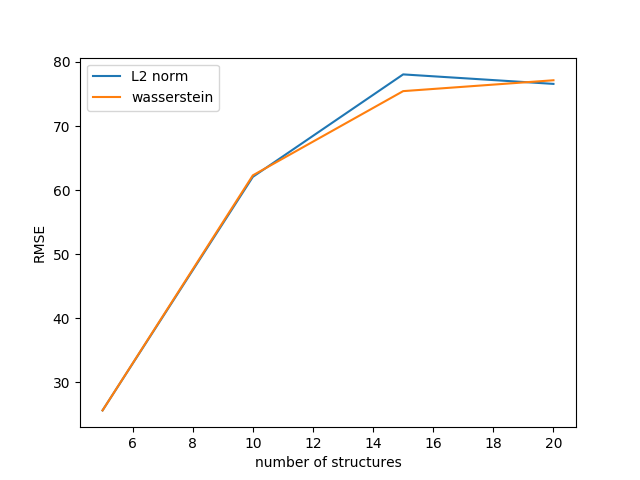

In [82]:
rmse = [score['RMSE'] for score in scores]
rmse_icdf = [score['RMSE'] for score in scores_icdf]
plt.close()
plt.plot(nbs_frames, rmse, label='L2 norm')
plt.plot(nbs_frames, rmse_icdf, label='wasserstein')
plt.xlabel("number of structures")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [197]:
frames = read('./data/CSD-500.xyz','0:5')
nb = 0
for i in range(len(frames)):
    nb = nb + frames[i].get_number_of_atoms()
print(nb)

678


In [175]:
# nearly perfect
get_score(chem_shifts_atoms_mean[test_ids]+np.random.rand(len(test_ids))*0.25, chem_shifts_atoms_mean[test_ids])

{'MAE': 0.12725944849574233,
 'RMSE': 0.12999884014574606,
 'SUP': 0.16853340376658466,
 'R2': 0.9999955129136372}

In [176]:
frames = read('./data/CSD-500.xyz',':')
print(len(frames))

500


In [9]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames)
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)
chem_shifts_atoms_mean = np.mean(chem_shifts_atoms, axis=1)

# SOAP: Power spectrum

In [262]:
soap.get_num_coefficients()

6

In [51]:
%time representation = soap.transform(frames)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.77 ms


In [52]:
X = representation.get_dense_feature_matrix(soap).T

In [53]:
X.shape

(24, 362)

# Learning the chemical shifts of a set of crystal structures

## learning utilities

In [ ]:
class KRR(object):
    def __init__(self,integration_grid, integration_grid_eval):
        self.integration_grid = integration_grid
        self.integration_grid_eval = integration_grid_eval
        
    def predict(self,frames):
        features = compute_representation(self.representation,frames)
        kernel = compute_atomic_kernel(self.zeta, self.X, features)
        return np.dot(self.weights, kernel)

def compute_atomic_kernel(zeta, rep1, rep2=None):
    if rep2 is not None:
        kernel = rep1.cosine_kernel_atomic(rep2, zeta)
    else:
        kernel = rep1.cosine_kernel_atomic(zeta)
    return kernel   

def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation, frames)
    kernel = compute_atomic_kernel(zeta, features, features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel


In [ ]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames)
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)

In [98]:
def compute_atomic_kernel(zeta, rep1, rep2=None):
    if rep2 is not None:
        kernel = rep1.cosine_kernel_atomic(rep2, zeta)
    else:
        kernel = rep1.cosine_kernel_atomic(zeta)
    return kernel

def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        #prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
        prop[ii] = cc.info['ENERGY']
    y = np.array(prop)
    return y

def split_dataset(frames, test_fraction, seed=10):
    N = len(frames)
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train = ids[:Ntrain]
    test = ids[Ntrain:]
    targets = extract_energy(frames)
    return [frames[ii] for ii in train],targets[train],[frames[ii] for ii in test],targets[test]

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)


score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation, frames)
    kernel = compute_atomic_kernel(zeta, features, features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel


## With the full power spectrum

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=1, 
              max_angular=1, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
frames_train, y_train, frames_test, y_test = split_dataset(frames,0.5)

In [ ]:
y_train = np.concatenate([frame.arrays['CS'] for frame in frames_train], axis=0)

In [ ]:
y_train = y_train[:,0]

In [ ]:
y_test = np.concatenate([frame.arrays['CS'] for frame in frames_test], axis=0)

In [ ]:
y_test = y_test[:,0]

In [ ]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames_train)

In [ ]:
zeta = 2

In [ ]:
features = compute_representation(soap, frames_train)

In [ ]:
features

In [ ]:
kernel = compute_atomic_kernel(zeta, features, features)

In [ ]:
kernel.shape

In [ ]:
# WTF?
#for i in range(len(kernel)):
#    kernel[i][0] = np.sqrt(i)/50

In [ ]:
kernel[191]

In [ ]:
# First, try without regularization -- the results will be nonsense
weights = np.linalg.solve(kernel,y_train)

In [ ]:
weights.shape

In [ ]:
model = KRR(zeta, weights, soap, features)

In [ ]:
y_pred = model.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
zeta = 2
Lambda = 10
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [ ]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
#sc = plt.scatter(y_pred, y_test, s=3)
#ax = plt.axis('scaled')
plt.plot(y_test, y_pred, '.')
plt.ylabel('DFT shift')
plt.xlabel('Predicted shift')
plt.savefig('R1.png', dpi=300)

## With just the radial spectrum

In [43]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5
              )
soap = SOAP(**hypers)

In [44]:
frames_train, y_train, frames_test, y_testr = split_dataset(frames,0.4)

NameError: name 'split_dataset' is not defined

In [45]:
zeta = 2
Lambda = 5e-3
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

NameError: name 'train_krr_model' is not defined

In [ ]:
y_predr = krr.predict(frames_test)
get_score(y_predr, y_testr)

In [ ]:
#plt.scatter(y_predr, y_testr, s=3)
#plt.scatter(y_predr, y_testr, s=3)
#ax = plt.axis('scaled')
plt.plot(y_pred, y_test, '.b')
plt.plot(y_predr, y_testr, '.y')
plt.legend(['Full','Radial'])
plt.ylabel('DFT energy / (eV/atom)')
plt.xlabel('Predicted energy / (eV/atom)')
plt.savefig('R1.png', dpi=300)

# Make a map of the dataset

## utils

In [ ]:
def compute_representation(representation,frames):
    expansions = soap.transform(frames)
    return expansions

def compute_kernel(zeta, rep1, rep2=None):
    if rep2 is None:
        kernel = rep1.cosine_kernel_global(zeta)
    else:
        kernel = rep1.cosine_kernel_global(rep2,zeta)
    return kernel

In [ ]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [ ]:
# Load the small molecules 
frames = read('./data/small_molecules-1000.xyz',':600')

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
zeta = 2

features = compute_representation(soap, frames)

kernel = compute_kernel(zeta,features)

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(kernel)

In [ ]:
X = kpca.transform(kernel)

In [ ]:
plt.scatter(X[:,0],X[:,1],s=3)
#plt.savefig('PCA.png',dpi=300)

## make an interactive map

In [ ]:
# package to visualize the structures in the notebook
# https://github.com/arose/nglview#released-version
import nglview

In [ ]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

In [ ]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
iwdg